# DEMO

In [2]:
from qutip import *
import numpy as np 
import matplotlib.pyplot as plt
import math
from skimage.feature import peak_local_max
import pickle
import os
import glob

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

saveDir = 'peaks'

##  plot peaks

In [47]:
def routine(E_i,wd_i):
    
    print('running param set {} {}'.format(E_i, wd_i))
    
    # Define all the variables 
    kappa = 0.0012 # 0.0012 
    gJC = 0.3347 # 0.3347
    wc = 10.5665 # Cavity frequency/detuning 10.5665
    w0 = 8.1831 # Qubit frequency 8.1831
    gamma=0.0001 # 0.0001
    Emax =0.01 # 0.01
    EN=1
    #E = 0.01 #0.01(original) # Epsilon
    E = E_i
    N = 50 #50
    nloop = 1

    #wd = 10.6005 # Driving frequency (10.6005 original)
    wd = wd_i
    wlist = np.linspace(wd, wd,nloop)

    # Identity operators are defined for the space of the light field and the space of the atom

    ida = identity(N)
    idatom = identity(2)

    # Define cavity field and atomic operators

    a  = tensor(destroy(N),idatom)
    sm = tensor(ida,sigmam())

    # Hamiltonian # Reminder check hamiltonian from caltech paper

    H1= 1*gJC*(a.dag()*sm + sm.dag()*a) + 1*E*(a+a.dag())

    # Collapse Operators

    C1    = math.sqrt(kappa)*a
    C2    = math.sqrt(gamma)*sm

    C1dC1 = C1.dag()*C1
    C2dC2 = C2.dag()*C2

    # Calculate the Liouvillian

    L1 = spre(C1)*spost(C1.dag())-0.5*spre(C1dC1)-0.5*spost(C1dC1)
    L2 = spre(C2)*spost(C2.dag())-0.5*spre(C2dC2)-0.5*spost(C2dC2)
    L12  = L1+L2

    gQ=math.sqrt(4)
    xvec=  np.arange(-10,10.01,0.025) # 0.025
    yvec = np.arange(-10,10.01,0.025) 

    #print("epsilon", E)
    #print("and drive frequency", wd)
    #print("kappa", kappa)
    k=0
    while k < nloop :
        wl = wlist[k]    
        H = (w0-wl)*(sm.dag()*sm) + (wc-wl)*(a.dag()*a) + H1    
        LH = -complex(0,1) * (spre(H) - spost(H))
        L_final = LH + L12

        # Steady States

        rhoss = steadystate(L_final)
        rhosscav=ptrace(rhoss,0)
        rhocavsq=rhosscav*rhosscav
        k += 1

        #subplot(ceil(sqrt(nloop)), 
        #ceil(sqrt(nloop)), k)
    plt.rcParams['figure.figsize'] = (20.0, 16.0)
    fig, ax = plt.subplots()
    Q3 = qfunc(rhosscav,xvec,yvec,gQ)
    c = ax.contourf(xvec, yvec, np.real(Q3), 500, cmap=plt.cm.get_cmap('winter'))
    

#         ax.set_xlim([-3.5, 6]) # -3.5 to 6
#         ax.set_ylim([-4, 3])
    plt.colorbar(c, ax=ax)
    plt.xlabel('x')
    plt.ylabel('y')
    


        #contour(xvec,yvec,real(Q3), 500)
        #plt.plot(xvec,yvec)
        #plt.show()
        #print(rhosscav)
        #print(rhoss)
    
    coordinates = peak_local_max(Q3)    
    for coord in coordinates:
        print('peak coords:{}'.format(coord))        
        coordHeight = Q3[coord[0], coord[1]]
        print('peak height:{}'.format(coordHeight))
        plt.plot(xvec[coord[1]], yvec[coord[0]], 'go', label='{}: {}'.format(coord, coordHeight))        
    plt.legend()
    plt.show()
    #print (Q3[coordinates])
    
#     newKey = len(savedInfo.keys()) + 1
    
#     infoPacket = {}
#     infoPacket['E_i'] = E_i
#     infoPacket['wd_i'] = wd_i
#     infoPacket['coors'] = coordinates
#     infoPacket['peaks'] = Q3[coordinates]
#     infoPacket['Q3'] = Q3
#     infoPacket['xvec'] = xvec
#     infoPacket['yvec'] = yvec
#     return infoPacket

## read peaks

In [9]:
relevantInfo = []
for peak in glob.glob(os.path.join('/mnt/c/Users/manish/Documents/GitHub/qpeak/peaks/peaksOverview', '*')):
    savedInfo = pickle.load(open(peak, 'rb'))    
    
    coors = savedInfo['coors']    
#     peaks = []
#     for coor in coors:        
#         peaks.append(savedInfo['Q3'][coor[0], coor[1]])
    peaks = savedInfo['peaks']
        
    relevantInfo_i = {}
    relevantInfo_i['peakName'] = peak
    relevantInfo_i['E'] = savedInfo['E_i']
    relevantInfo_i['wd'] = savedInfo['wd_i']
    if savedInfo['wd_i'] <= 0:
        print(savedInfo['wd_i'])
        break
    
    relevantInfo_i['peaks'] = peaks
    relevantInfo.append(relevantInfo_i)
    print('E:{}, wd_i:{}, peaks:{}'.format(relevantInfo_i['E'], relevantInfo_i['wd'], relevantInfo_i['peaks']))
    
print(len(relevantInfo))

E:0.00125, wd_i:10.6095, peaks:[0.29469260394324304]
E:0.00125, wd_i:10.6095266332, peaks:[0.29262884604029366]
E:0.00125, wd_i:10.6097663317, peaks:[0.2680640466785742]
E:0.00125, wd_i:10.6121633166, peaks:[0.250748730323286]
E:0.00133793969849, wd_i:10.6095, peaks:[0.2769248946367265]
E:0.00212939698492, wd_i:10.6095, peaks:[0.18317763906004722]
E:0.00212939698492, wd_i:10.6095266332, peaks:[0.1843846144855691]
E:0.00212939698492, wd_i:10.6095532663, peaks:[0.18557522117838904]
E:0.00212939698492, wd_i:10.6095798995, peaks:[0.18673116673177614]
E:0.00212939698492, wd_i:10.6096065327, peaks:[0.18784285919096658]
E:0.00212939698492, wd_i:10.6096331658, peaks:[0.18893395402484064]
E:0.00212939698492, wd_i:10.609659799, peaks:[0.19000522971536715]
E:0.00212939698492, wd_i:10.6096864322, peaks:[0.19103673146196112]
E:0.00212939698492, wd_i:10.6097130653, peaks:[0.19206014766654436]
E:0.00212939698492, wd_i:10.6097396985, peaks:[0.1930605207790055]
E:0.00133793969849, wd_i:10.6095266332, p

E:0.00212939698492, wd_i:10.6141341709, peaks:[0.3068650296698381]
E:0.00212939698492, wd_i:10.614160804, peaks:[0.30719823600847657]
E:0.00212939698492, wd_i:10.6141874372, peaks:[0.30750583429948886]
E:0.00212939698492, wd_i:10.6142140704, peaks:[0.307804334565281]
E:0.00212939698492, wd_i:10.6142407035, peaks:[0.30813728179090205]
E:0.00212939698492, wd_i:10.6142673367, peaks:[0.30844535938240436]
E:0.00133793969849, wd_i:10.609979397, peaks:[0.2034659581292427]
E:0.00212939698492, wd_i:10.6142939698, peaks:[0.3087289078338737]
E:0.00212939698492, wd_i:10.614320603, peaks:[0.30899197065704215]
E:0.00212939698492, wd_i:10.6143472362, peaks:[0.3092658265744233]
E:0.00212939698492, wd_i:10.6143738693, peaks:[0.30953585761872926]
E:0.00212939698492, wd_i:10.6144005025, peaks:[0.30983669316018714]
E:0.00212939698492, wd_i:10.6144271357, peaks:[0.31011409313376564]
E:0.00212939698492, wd_i:10.6144537688, peaks:[0.310368438863191]
E:0.00212939698492, wd_i:10.614480402, peaks:[0.31060012155

E:0.00133793969849, wd_i:10.610298995, peaks:[0.15819080943456737, 0.11665437918529682]
E:0.00214698492462, wd_i:10.6121633166, peaks:[0.2635249503876055]
E:0.00214698492462, wd_i:10.6121899497, peaks:[0.2642367127685384]
E:0.00214698492462, wd_i:10.6122165829, peaks:[0.26498369063887084]
E:0.00214698492462, wd_i:10.6122432161, peaks:[0.2657205583255009]
E:0.00214698492462, wd_i:10.6122698492, peaks:[0.2664588811154011]
E:0.00214698492462, wd_i:10.6122964824, peaks:[0.26720593664481085]
E:0.00214698492462, wd_i:10.6123231156, peaks:[0.2679306006607898]
E:0.00214698492462, wd_i:10.6123497487, peaks:[0.2686326156557315]
E:0.00214698492462, wd_i:10.6123763819, peaks:[0.2693551087469646]
E:0.00214698492462, wd_i:10.6124030151, peaks:[0.2700813423837766]
E:0.00133793969849, wd_i:10.6103256281, peaks:[0.15571841097678188, 0.11965105952415477]
E:0.00214698492462, wd_i:10.6124296482, peaks:[0.27081002667473664]
E:0.00214698492462, wd_i:10.6124562814, peaks:[0.2715449539357367]
E:0.002146984924

E:0.00216457286432, wd_i:10.6096864322, peaks:[0.19350746504187183]
E:0.00216457286432, wd_i:10.6097130653, peaks:[0.1944375698248478]
E:0.00216457286432, wd_i:10.6097396985, peaks:[0.19537358657455126]
E:0.00133793969849, wd_i:10.6105919598, peaks:[0.14686990624004842, 0.14673305050803334]
E:0.00216457286432, wd_i:10.6097663317, peaks:[0.19628187785832132]
E:0.00216457286432, wd_i:10.6097929648, peaks:[0.1971831628459456]
E:0.00216457286432, wd_i:10.609819598, peaks:[0.19807915268529563]
E:0.00216457286432, wd_i:10.6098462312, peaks:[0.198947512436106]
E:0.00216457286432, wd_i:10.6098728643, peaks:[0.1997893144977056]
E:0.00216457286432, wd_i:10.6098994975, peaks:[0.2006447451855475]
E:0.00216457286432, wd_i:10.6099261307, peaks:[0.20148117726876866]
E:0.00216457286432, wd_i:10.6099527638, peaks:[0.20229411274809475]
E:0.00216457286432, wd_i:10.609979397, peaks:[0.2031031349402873]
E:0.00216457286432, wd_i:10.6100060302, peaks:[0.2039198137285766]
E:0.00133793969849, wd_i:10.610618593

E:0.00216457286432, wd_i:10.6130155779, peaks:[0.28578139140457975]
E:0.00216457286432, wd_i:10.6130422111, peaks:[0.286396259788218]
E:0.00216457286432, wd_i:10.6130688442, peaks:[0.2870243063462386]
E:0.00216457286432, wd_i:10.6130954774, peaks:[0.2876744932910567]
E:0.00216457286432, wd_i:10.6131221106, peaks:[0.28830414887380107]
E:0.00216457286432, wd_i:10.6131487437, peaks:[0.2889076136230562]
E:0.00216457286432, wd_i:10.6131753769, peaks:[0.2894847488421369]
E:0.00216457286432, wd_i:10.6132020101, peaks:[0.29007466261269005]
E:0.00133793969849, wd_i:10.610938191, peaks:[0.17731736783958543]
E:0.00216457286432, wd_i:10.6132286432, peaks:[0.29067472000192096]
E:0.00216457286432, wd_i:10.6132552764, peaks:[0.2912670481507027]
E:0.00216457286432, wd_i:10.6132819095, peaks:[0.2918661272003539]
E:0.00216457286432, wd_i:10.6133085427, peaks:[0.2924383483299172]
E:0.00216457286432, wd_i:10.6133351759, peaks:[0.2929836059941216]
E:0.00216457286432, wd_i:10.613361809, peaks:[0.29354858098

E:0.00218216080402, wd_i:10.6111246231, peaks:[0.2354700795463855]
E:0.00218216080402, wd_i:10.6111512563, peaks:[0.2361974595957473]
E:0.00218216080402, wd_i:10.6111778894, peaks:[0.23692276260972647]
E:0.00218216080402, wd_i:10.6112045226, peaks:[0.2376311452818393]
E:0.00218216080402, wd_i:10.6112311558, peaks:[0.23835143754766241]
E:0.00218216080402, wd_i:10.6112577889, peaks:[0.2390870441181404]
E:0.00218216080402, wd_i:10.6112844221, peaks:[0.23980547306101557]
E:0.00218216080402, wd_i:10.6113110553, peaks:[0.24053884391309238]
E:0.00218216080402, wd_i:10.6113376884, peaks:[0.24127213804777067]
E:0.00133793969849, wd_i:10.6112844221, peaks:[0.20236235444420064]
E:0.00218216080402, wd_i:10.6113643216, peaks:[0.24198800482258845]
E:0.00218216080402, wd_i:10.6113909548, peaks:[0.24268743884968771]
E:0.00218216080402, wd_i:10.6114175879, peaks:[0.24343079301639564]
E:0.00218216080402, wd_i:10.6114442211, peaks:[0.24415652197589555]
E:0.00218216080402, wd_i:10.6114708543, peaks:[0.244

E:0.00218216080402, wd_i:10.6144271357, peaks:[0.309785488118992]
E:0.00218216080402, wd_i:10.6144537688, peaks:[0.31005036775517153]
E:0.00218216080402, wd_i:10.614480402, peaks:[0.3103209401261962]
E:0.00218216080402, wd_i:10.6145070352, peaks:[0.31056929486122614]
E:0.00218216080402, wd_i:10.6145336683, peaks:[0.3107958071442948]
E:0.00133793969849, wd_i:10.6116040201, peaks:[0.22185734585541658]
E:0.00218216080402, wd_i:10.6145603015, peaks:[0.3110008602030585]
E:0.00218216080402, wd_i:10.6145869347, peaks:[0.311184844504884]
E:0.00218216080402, wd_i:10.6146135678, peaks:[0.31140963016562906]
E:0.00218216080402, wd_i:10.614640201, peaks:[0.31163249885837185]
E:0.00218216080402, wd_i:10.6146668342, peaks:[0.3118593478024739]
E:0.00218216080402, wd_i:10.6146934673, peaks:[0.31206589569705073]
E:0.00218216080402, wd_i:10.6147201005, peaks:[0.31225253855559115]
E:0.00218216080402, wd_i:10.6147467337, peaks:[0.3124196764269373]
E:0.00218216080402, wd_i:10.6147733668, peaks:[0.3126103547

E:0.00219974874372, wd_i:10.6123763819, peaks:[0.26975183053845253]
E:0.00219974874372, wd_i:10.6124030151, peaks:[0.27046574718336]
E:0.00133793969849, wd_i:10.6119236181, peaks:[0.2398215222938292]
E:0.00219974874372, wd_i:10.6124296482, peaks:[0.27115712999630587]
E:0.00219974874372, wd_i:10.6124562814, peaks:[0.2718454416170555]
E:0.00219974874372, wd_i:10.6124829146, peaks:[0.27256250181609826]
E:0.00219974874372, wd_i:10.6125095477, peaks:[0.27325663788107396]
E:0.00219974874372, wd_i:10.6125361809, peaks:[0.27392988297033555]
E:0.00219974874372, wd_i:10.6125628141, peaks:[0.2746309536485895]
E:0.00219974874372, wd_i:10.6125894472, peaks:[0.27530867294042194]
E:0.00219974874372, wd_i:10.6126160804, peaks:[0.27597494631054464]
E:0.00219974874372, wd_i:10.6126427136, peaks:[0.27667793753305187]
E:0.00219974874372, wd_i:10.6126693467, peaks:[0.27735726145505013]
E:0.00133793969849, wd_i:10.6119502513, peaks:[0.241241844083841]
E:0.00219974874372, wd_i:10.6126959799, peaks:[0.2780127

E:0.00221733668342, wd_i:10.6103788945, peaks:[0.21672967911138658]
E:0.00221733668342, wd_i:10.6104055276, peaks:[0.21746218908174106]
E:0.00221733668342, wd_i:10.6104321608, peaks:[0.21817686717576096]
E:0.00221733668342, wd_i:10.610458794, peaks:[0.2188737243426818]
E:0.00221733668342, wd_i:10.6104854271, peaks:[0.21956679498913412]
E:0.00221733668342, wd_i:10.6105120603, peaks:[0.22027440947308918]
E:0.00221733668342, wd_i:10.6105386935, peaks:[0.22096459302958923]
E:0.00133793969849, wd_i:10.6122698492, peaks:[0.2571382930057717]
E:0.00221733668342, wd_i:10.6105653266, peaks:[0.22166714339162405]
E:0.00221733668342, wd_i:10.6105919598, peaks:[0.22237863276959993]
E:0.00221733668342, wd_i:10.610618593, peaks:[0.22307324008122006]
E:0.00221733668342, wd_i:10.6106452261, peaks:[0.22376272913524956]
E:0.00221733668342, wd_i:10.6106718593, peaks:[0.2244706590239903]
E:0.00221733668342, wd_i:10.6106984925, peaks:[0.22516213368502888]
E:0.00221733668342, wd_i:10.6107251256, peaks:[0.2258

E:0.00221733668342, wd_i:10.6134417085, peaks:[0.2949828140629266]
E:0.00221733668342, wd_i:10.6134683417, peaks:[0.29554340152158093]
E:0.00133793969849, wd_i:10.6125628141, peaks:[0.2700716572479057]
E:0.00221733668342, wd_i:10.6134949749, peaks:[0.2960773168431708]
E:0.00221733668342, wd_i:10.613521608, peaks:[0.2965845153829498]
E:0.00221733668342, wd_i:10.6135482412, peaks:[0.29706497074404603]
E:0.00221733668342, wd_i:10.6135748744, peaks:[0.2975493175201874]
E:0.00221733668342, wd_i:10.6136015075, peaks:[0.2980534333152408]
E:0.00221733668342, wd_i:10.6136281407, peaks:[0.29853542125165294]
E:0.00221733668342, wd_i:10.6136547739, peaks:[0.29903341133504985]
E:0.00221733668342, wd_i:10.613681407, peaks:[0.2995045083261201]
E:0.00221733668342, wd_i:10.6137080402, peaks:[0.29994875328148407]
E:0.00221733668342, wd_i:10.6137346734, peaks:[0.30040856565478175]
E:0.00133793969849, wd_i:10.6125894472, peaks:[0.2712142991939173]
E:0.00221733668342, wd_i:10.6137613065, peaks:[0.300876734

E:0.00223492462312, wd_i:10.6114442211, peaks:[0.2452492033875006]
E:0.00223492462312, wd_i:10.6114708543, peaks:[0.24593918413130875]
E:0.00223492462312, wd_i:10.6114974874, peaks:[0.24663937153312823]
E:0.00223492462312, wd_i:10.6115241206, peaks:[0.24735809301191944]
E:0.00223492462312, wd_i:10.6115507538, peaks:[0.2480590944724441]
E:0.00223492462312, wd_i:10.6115773869, peaks:[0.24878866253061319]
E:0.00223492462312, wd_i:10.6116040201, peaks:[0.2495037833337014]
E:0.00133793969849, wd_i:10.6129090452, peaks:[0.2839647991678024]
E:0.00223492462312, wd_i:10.6116306533, peaks:[0.25020096084781396]
E:0.00223492462312, wd_i:10.6116572864, peaks:[0.2508840551748777]
E:0.00223492462312, wd_i:10.6116839196, peaks:[0.2516102501087084]
E:0.00223492462312, wd_i:10.6117105528, peaks:[0.2523182515829955]
E:0.00223492462312, wd_i:10.6117371859, peaks:[0.25304966584293453]
E:0.00223492462312, wd_i:10.6117638191, peaks:[0.25377146327858846]
E:0.00223492462312, wd_i:10.6117904523, peaks:[0.254474

E:0.00225251256281, wd_i:10.6095532663, peaks:[0.19450753094968143]
E:0.00225251256281, wd_i:10.6095798995, peaks:[0.19541644935519056]
E:0.00225251256281, wd_i:10.6096065327, peaks:[0.1962949710781397]
E:0.00225251256281, wd_i:10.6096331658, peaks:[0.19716460066840477]
E:0.00225251256281, wd_i:10.609659799, peaks:[0.19802699441369373]
E:0.00225251256281, wd_i:10.6096864322, peaks:[0.19886136274922658]
E:0.00225251256281, wd_i:10.6097130653, peaks:[0.19966842326645293]
E:0.00225251256281, wd_i:10.6097396985, peaks:[0.2004825609001831]
E:0.00133793969849, wd_i:10.6132552764, peaks:[0.2957624001821113]
E:0.00225251256281, wd_i:10.6097663317, peaks:[0.2012803056093257]
E:0.00225251256281, wd_i:10.6097929648, peaks:[0.2020533636009806]
E:0.00225251256281, wd_i:10.609819598, peaks:[0.202842762178529]
E:0.00225251256281, wd_i:10.6098462312, peaks:[0.20361815995499835]
E:0.00225251256281, wd_i:10.6098728643, peaks:[0.20437134144951935]
E:0.00225251256281, wd_i:10.6098994975, peaks:[0.20513252

E:0.00225251256281, wd_i:10.6124829146, peaks:[0.2728474932962414]
E:0.00225251256281, wd_i:10.6125095477, peaks:[0.2735121341071244]
E:0.00225251256281, wd_i:10.6125361809, peaks:[0.27417466255005557]
E:0.00225251256281, wd_i:10.6125628141, peaks:[0.2748830268954191]
E:0.00225251256281, wd_i:10.6125894472, peaks:[0.2755686383885269]
E:0.00225251256281, wd_i:10.6126160804, peaks:[0.2762313048050301]
E:0.00225251256281, wd_i:10.6126427136, peaks:[0.2768708443873741]
E:0.00225251256281, wd_i:10.6126693467, peaks:[0.2775035709254644]
E:0.00133793969849, wd_i:10.6135482412, peaks:[0.30353038375315977]
E:0.00225251256281, wd_i:10.6126959799, peaks:[0.27814889751118144]
E:0.00225251256281, wd_i:10.6127226131, peaks:[0.278842340554996]
E:0.00225251256281, wd_i:10.6127492462, peaks:[0.27951338419846805]
E:0.00225251256281, wd_i:10.6127758794, peaks:[0.280160803582954]
E:0.00225251256281, wd_i:10.6128025126, peaks:[0.28078443538050435]
E:0.00225251256281, wd_i:10.6128291457, peaks:[0.2813841257

E:0.00227010050251, wd_i:10.610778392, peaks:[0.22879252375954845]
E:0.00227010050251, wd_i:10.6108050251, peaks:[0.2294563118182171]
E:0.00133793969849, wd_i:10.6138944724, peaks:[0.30980698759259623]
E:0.00227010050251, wd_i:10.6108316583, peaks:[0.2301101201798424]
E:0.00227010050251, wd_i:10.6108582915, peaks:[0.23080088888765055]
E:0.00227010050251, wd_i:10.6108849246, peaks:[0.23147592226742728]
E:0.00227010050251, wd_i:10.6109115578, peaks:[0.23217197169498127]
E:0.00227010050251, wd_i:10.610938191, peaks:[0.23286246568416988]
E:0.00227010050251, wd_i:10.6109648241, peaks:[0.23353713944243615]
E:0.00227010050251, wd_i:10.6109914573, peaks:[0.23419585828771747]
E:0.00227010050251, wd_i:10.6110180905, peaks:[0.2348720669063875]
E:0.00227010050251, wd_i:10.6110447236, peaks:[0.2355558516345272]
E:0.00227010050251, wd_i:10.6110713568, peaks:[0.23625764184535136]
E:0.00133793969849, wd_i:10.6139211055, peaks:[0.3101667990170691]
E:0.00227010050251, wd_i:10.6110979899, peaks:[0.236959

E:0.00227010050251, wd_i:10.6140276382, peaks:[0.30464668090414215]
E:0.00227010050251, wd_i:10.6140542714, peaks:[0.304982276656127]
E:0.00227010050251, wd_i:10.6140809045, peaks:[0.30530932710161107]
E:0.00227010050251, wd_i:10.6141075377, peaks:[0.30566875618739636]
E:0.00227010050251, wd_i:10.6141341709, peaks:[0.3060464868406368]
E:0.00227010050251, wd_i:10.614160804, peaks:[0.3063995190047778]
E:0.00227010050251, wd_i:10.6141874372, peaks:[0.30672809124822387]
E:0.00227010050251, wd_i:10.6142140704, peaks:[0.30703245775374155]
E:0.00227010050251, wd_i:10.6142407035, peaks:[0.3073128876841112]
E:0.00227010050251, wd_i:10.6142673367, peaks:[0.30764021685751397]
E:0.00133793969849, wd_i:10.6142407035, peaks:[0.3135971187442643]
E:0.00227010050251, wd_i:10.6142939698, peaks:[0.3079484074732738]
E:0.00227010050251, wd_i:10.614320603, peaks:[0.3082332765365794]
E:0.00227010050251, wd_i:10.6143472362, peaks:[0.30849968801715827]
E:0.00227010050251, wd_i:10.6143738693, peaks:[0.308775270

E:0.00228768844221, wd_i:10.6120567839, peaks:[0.26216522841831735]
E:0.00228768844221, wd_i:10.6120834171, peaks:[0.26283190603933315]
E:0.00228768844221, wd_i:10.6121100503, peaks:[0.2635411157791756]
E:0.00228768844221, wd_i:10.6121366834, peaks:[0.26423026206848316]
E:0.00125, wd_i:10.6126693467, peaks:[0.27451881715178056]
E:0.00133793969849, wd_i:10.6145603015, peaks:[0.31554420793043814]
E:0.00228768844221, wd_i:10.6121633166, peaks:[0.26492068441263156]
E:0.00228768844221, wd_i:10.6121899497, peaks:[0.26561982241988386]
E:0.00228768844221, wd_i:10.6122165829, peaks:[0.26629841691773903]
E:0.00228768844221, wd_i:10.6122432161, peaks:[0.2669562341309565]
E:0.00228768844221, wd_i:10.6122698492, peaks:[0.26765551698638257]
E:0.00228768844221, wd_i:10.6122964824, peaks:[0.2683415715235129]
E:0.00228768844221, wd_i:10.6123231156, peaks:[0.2690143250224151]
E:0.00228768844221, wd_i:10.6123497487, peaks:[0.2697088482676365]
E:0.00228768844221, wd_i:10.6123763819, peaks:[0.2703819323499

E:0.00230527638191, wd_i:10.6098994975, peaks:[0.20747476595773748]
E:0.00230527638191, wd_i:10.6099261307, peaks:[0.2081860776572282]
E:0.00230527638191, wd_i:10.6099527638, peaks:[0.20888605002088273]
E:0.00230527638191, wd_i:10.609979397, peaks:[0.20959582299176732]
E:0.00230527638191, wd_i:10.6100060302, peaks:[0.21030555516680965]
E:0.00135552763819, wd_i:10.6095532663, peaks:[0.2652601341662596]
E:0.00230527638191, wd_i:10.6100326633, peaks:[0.21099764586414554]
E:0.00230527638191, wd_i:10.6100592965, peaks:[0.21167225455728605]
E:0.00230527638191, wd_i:10.6100859296, peaks:[0.21236478929425068]
E:0.00230527638191, wd_i:10.6101125628, peaks:[0.2130488503054192]
E:0.00230527638191, wd_i:10.610139196, peaks:[0.21371590600367882]
E:0.00230527638191, wd_i:10.6101658291, peaks:[0.2144112361454237]
E:0.00230527638191, wd_i:10.6101924623, peaks:[0.2150977986211631]
E:0.00230527638191, wd_i:10.6102190955, peaks:[0.2157675622054742]
E:0.00230527638191, wd_i:10.6102457286, peaks:[0.2164502

E:0.00230527638191, wd_i:10.6129090452, peaks:[0.2833530122632165]
E:0.00230527638191, wd_i:10.6129356784, peaks:[0.28398154342009035]
E:0.00135552763819, wd_i:10.6098462312, peaks:[0.21882339899185246]
E:0.00230527638191, wd_i:10.6129623116, peaks:[0.28460041009392767]
E:0.00230527638191, wd_i:10.6129889447, peaks:[0.28519533207449027]
E:0.00230527638191, wd_i:10.6130155779, peaks:[0.28577927694392724]
E:0.00230527638191, wd_i:10.6130422111, peaks:[0.2863756786175545]
E:0.00230527638191, wd_i:10.6130688442, peaks:[0.28694774931892925]
E:0.00230527638191, wd_i:10.6130954774, peaks:[0.2875587902368788]
E:0.00230527638191, wd_i:10.6131221106, peaks:[0.28815761687921443]
E:0.00230527638191, wd_i:10.6131487437, peaks:[0.28873191023668565]
E:0.00230527638191, wd_i:10.6131753769, peaks:[0.28928155465647426]
E:0.00230527638191, wd_i:10.6132020101, peaks:[0.2898242003593641]
E:0.00135552763819, wd_i:10.6098728643, peaks:[0.21430282739042686]
E:0.00230527638191, wd_i:10.6132286432, peaks:[0.290

E:0.00232286432161, wd_i:10.610618593, peaks:[0.2262903848360719]
E:0.00232286432161, wd_i:10.6106452261, peaks:[0.2269380679183785]
E:0.00232286432161, wd_i:10.6106718593, peaks:[0.22759941352434526]
E:0.00232286432161, wd_i:10.6106984925, peaks:[0.2282607042530692]
E:0.00232286432161, wd_i:10.6107251256, peaks:[0.22890615866930553]
E:0.00232286432161, wd_i:10.6107517588, peaks:[0.22954175774156785]
E:0.00232286432161, wd_i:10.610778392, peaks:[0.2302142962881686]
E:0.00232286432161, wd_i:10.6108050251, peaks:[0.23087121148828713]
E:0.00135552763819, wd_i:10.6101658291, peaks:[0.16772229417760876, 0.1053353284588983]
E:0.00232286432161, wd_i:10.6108316583, peaks:[0.23153386010388763]
E:0.00232286432161, wd_i:10.6108582915, peaks:[0.2322055011947703]
E:0.00232286432161, wd_i:10.6108849246, peaks:[0.23286153771607726]
E:0.00232286432161, wd_i:10.6109115578, peaks:[0.23350187580218892]
E:0.00232286432161, wd_i:10.610938191, peaks:[0.2341560092519389]
E:0.00232286432161, wd_i:10.610964824

E:0.00135552763819, wd_i:10.6104321608, peaks:[0.14451428683900147, 0.13487048263694532]
E:0.00232286432161, wd_i:10.6134949749, peaks:[0.2956924997393711]
E:0.00232286432161, wd_i:10.613521608, peaks:[0.2961714428214081]
E:0.00232286432161, wd_i:10.6135482412, peaks:[0.29662882378995775]
E:0.00232286432161, wd_i:10.6135748744, peaks:[0.29713372352215256]
E:0.00232286432161, wd_i:10.6136015075, peaks:[0.29761321663383017]
E:0.00232286432161, wd_i:10.6136281407, peaks:[0.2980915780827094]
E:0.00232286432161, wd_i:10.6136547739, peaks:[0.29856541492662303]
E:0.00232286432161, wd_i:10.613681407, peaks:[0.2990136623409529]
E:0.00232286432161, wd_i:10.6137080402, peaks:[0.2994496492869195]
E:0.00232286432161, wd_i:10.6137346734, peaks:[0.29992394717505333]
E:0.00135552763819, wd_i:10.610458794, peaks:[0.14378004237235797, 0.13751518254360606]
E:0.00232286432161, wd_i:10.6137613065, peaks:[0.3003727742269288]
E:0.00232286432161, wd_i:10.6137879397, peaks:[0.30079618972375843]
E:0.00232286432

E:0.00234045226131, wd_i:10.6111778894, peaks:[0.24053688122122102]
E:0.00234045226131, wd_i:10.6112045226, peaks:[0.24121583877052016]
E:0.00234045226131, wd_i:10.6112311558, peaks:[0.24187844887913032]
E:0.00234045226131, wd_i:10.6112577889, peaks:[0.2425245396944351]
E:0.00234045226131, wd_i:10.6112844221, peaks:[0.24320047497478678]
E:0.00234045226131, wd_i:10.6113110553, peaks:[0.24385989132152702]
E:0.00234045226131, wd_i:10.6113376884, peaks:[0.24452353428762655]
E:0.00135552763819, wd_i:10.6107517588, peaks:[0.16414246770641566]
E:0.00234045226131, wd_i:10.6113643216, peaks:[0.2452133318589499]
E:0.00234045226131, wd_i:10.6113909548, peaks:[0.24588630581433563]
E:0.00234045226131, wd_i:10.6114175879, peaks:[0.24654229184999799]
E:0.00234045226131, wd_i:10.6114442211, peaks:[0.2472143312998069]
E:0.00234045226131, wd_i:10.6114708543, peaks:[0.24788320920549733]
E:0.00234045226131, wd_i:10.6114974874, peaks:[0.2485348642582022]
E:0.00234045226131, wd_i:10.6115241206, peaks:[0.249

E:0.00234045226131, wd_i:10.6142407035, peaks:[0.3069865688622481]
E:0.00234045226131, wd_i:10.6142673367, peaks:[0.30728995465809006]
E:0.00135552763819, wd_i:10.6110447236, peaks:[0.18741224099120207]
E:0.00234045226131, wd_i:10.6142939698, peaks:[0.3075703081853333]
E:0.00234045226131, wd_i:10.614320603, peaks:[0.3078278989415363]
E:0.00234045226131, wd_i:10.6143472362, peaks:[0.30810828029363996]
E:0.00234045226131, wd_i:10.6143738693, peaks:[0.3084052214662453]
E:0.00234045226131, wd_i:10.6144005025, peaks:[0.30870543506962633]
E:0.00234045226131, wd_i:10.6144271357, peaks:[0.3089834023485298]
E:0.00234045226131, wd_i:10.6144537688, peaks:[0.30923942039911456]
E:0.00234045226131, wd_i:10.614480402, peaks:[0.3094737966051353]
E:0.00234045226131, wd_i:10.6145070352, peaks:[0.30972571111627456]
E:0.00234045226131, wd_i:10.6145336683, peaks:[0.30999030971911135]
E:0.00135552763819, wd_i:10.6110713568, peaks:[0.18934731197483115]
E:0.00234045226131, wd_i:10.6145603015, peaks:[0.3102339

E:0.00235804020101, wd_i:10.6121633166, peaks:[0.26556463562996535]
E:0.00235804020101, wd_i:10.6121899497, peaks:[0.2662116371383331]
E:0.00235804020101, wd_i:10.6122165829, peaks:[0.26689593510103854]
E:0.00235804020101, wd_i:10.6122432161, peaks:[0.26756004444174025]
E:0.00235804020101, wd_i:10.6122698492, peaks:[0.2682078002425262]
E:0.00235804020101, wd_i:10.6122964824, peaks:[0.26888019510792266]
E:0.00235804020101, wd_i:10.6123231156, peaks:[0.26953195939377095]
E:0.00235804020101, wd_i:10.6123497487, peaks:[0.27016425970453084]
E:0.00235804020101, wd_i:10.6123763819, peaks:[0.2708455242605759]
E:0.00235804020101, wd_i:10.6124030151, peaks:[0.27150579225459903]
E:0.00135552763819, wd_i:10.6113909548, peaks:[5.55310610330276e-48, 0.2101782040421125]
E:0.00235804020101, wd_i:10.6124296482, peaks:[0.2721448643413874]
E:0.00235804020101, wd_i:10.6124562814, peaks:[0.27279240136726235]
E:0.00235804020101, wd_i:10.6124829146, peaks:[0.2734380055077754]
E:0.00235804020101, wd_i:10.6125

E:0.0023756281407, wd_i:10.6097663317, peaks:[0.20698100058692287]
E:0.0023756281407, wd_i:10.6097929648, peaks:[0.20765732020146704]
E:0.0023756281407, wd_i:10.609819598, peaks:[0.20832463733803425]
E:0.0023756281407, wd_i:10.6098462312, peaks:[0.20900494366547356]
E:0.0023756281407, wd_i:10.6098728643, peaks:[0.20966685618954806]
E:0.0023756281407, wd_i:10.6098994975, peaks:[0.21032177714509634]
E:0.0023756281407, wd_i:10.6099261307, peaks:[0.21100023435347268]
E:0.0023756281407, wd_i:10.6099527638, peaks:[0.21166141903295557]
E:0.0023756281407, wd_i:10.609979397, peaks:[0.2123062199204251]
E:0.0023756281407, wd_i:10.6100060302, peaks:[0.21297651131464926]
E:0.00135552763819, wd_i:10.6116839196, peaks:[0.22719114107411545]
E:0.0023756281407, wd_i:10.6100326633, peaks:[0.21363031065279256]
E:0.0023756281407, wd_i:10.6100592965, peaks:[0.21426771312825446]
E:0.0023756281407, wd_i:10.6100859296, peaks:[0.21490471066018213]
E:0.0023756281407, wd_i:10.6101125628, peaks:[0.2155632596915416

E:0.0023756281407, wd_i:10.6127758794, peaks:[0.28043286098599574]
E:0.0023756281407, wd_i:10.6128025126, peaks:[0.28103082507204163]
E:0.0023756281407, wd_i:10.6128291457, peaks:[0.28163527693642243]
E:0.0023756281407, wd_i:10.6128557789, peaks:[0.28222501034459757]
E:0.0023756281407, wd_i:10.6128824121, peaks:[0.28285814171247353]
E:0.0023756281407, wd_i:10.6129090452, peaks:[0.28346830647863197]
E:0.0023756281407, wd_i:10.6129356784, peaks:[0.2840553670018028]
E:0.00135552763819, wd_i:10.6119768844, peaks:[0.2430515667548539]
E:0.0023756281407, wd_i:10.6129623116, peaks:[0.2846191945338503]
E:0.0023756281407, wd_i:10.6129889447, peaks:[0.2851854131662816]
E:0.0023756281407, wd_i:10.6130155779, peaks:[0.28576028391488045]
E:0.0023756281407, wd_i:10.6130422111, peaks:[0.2863772570341153]
E:0.0023756281407, wd_i:10.6130688442, peaks:[0.286970691775123]
E:0.0023756281407, wd_i:10.6130954774, peaks:[0.28754046393868854]
E:0.0023756281407, wd_i:10.6131221106, peaks:[0.2880864589200776]
E:

E:0.0023932160804, wd_i:10.6105653266, peaks:[0.22693943875317615]
E:0.0023932160804, wd_i:10.6105919598, peaks:[0.22758005844856496]
E:0.0023932160804, wd_i:10.610618593, peaks:[0.2282220344681058]
E:0.0023932160804, wd_i:10.6106452261, peaks:[0.22884835327448105]
E:0.0023932160804, wd_i:10.6106718593, peaks:[0.22945897913883376]
E:0.0023932160804, wd_i:10.6106984925, peaks:[0.2300865929518062]
E:0.0023932160804, wd_i:10.6107251256, peaks:[0.23072479226220977]
E:0.0023932160804, wd_i:10.6107517588, peaks:[0.23136373162023513]
E:0.0023932160804, wd_i:10.610778392, peaks:[0.232015981885887]
E:0.0023932160804, wd_i:10.6108050251, peaks:[0.23265281628228188]
E:0.00135552763819, wd_i:10.6122964824, peaks:[0.2585429697681515]
E:0.0023932160804, wd_i:10.6108316583, peaks:[0.2332741663848584]
E:0.0023932160804, wd_i:10.6108582915, peaks:[0.23388964943671142]
E:0.0023932160804, wd_i:10.6108849246, peaks:[0.23452594735838733]
E:0.0023932160804, wd_i:10.6109115578, peaks:[0.23516504311301475]
E:

E:0.0023932160804, wd_i:10.6139211055, peaks:[0.30249222422991645]
E:0.0023932160804, wd_i:10.6139477387, peaks:[0.3028639738442714]
E:0.0023932160804, wd_i:10.6139743719, peaks:[0.3032714652836006]
E:0.0023932160804, wd_i:10.614001005, peaks:[0.3036547295930795]
E:0.00135552763819, wd_i:10.6126160804, peaks:[0.2723585406443729]
E:0.0023932160804, wd_i:10.6140276382, peaks:[0.3040139089585312]
E:0.0023932160804, wd_i:10.6140542714, peaks:[0.30434916137352863]
E:0.0023932160804, wd_i:10.6140809045, peaks:[0.3046667713338634]
E:0.0023932160804, wd_i:10.6141075377, peaks:[0.3050156545466047]
E:0.0023932160804, wd_i:10.6141341709, peaks:[0.305394204636233]
E:0.0023932160804, wd_i:10.614160804, peaks:[0.30574909337927775]
E:0.0023932160804, wd_i:10.6141874372, peaks:[0.3060805177771272]
E:0.0023932160804, wd_i:10.6142140704, peaks:[0.3063886892284698]
E:0.0023932160804, wd_i:10.6142407035, peaks:[0.3066738330524998]
E:0.0023932160804, wd_i:10.6142673367, peaks:[0.3069935088478897]
E:0.00135

E:0.00135552763819, wd_i:10.6129356784, peaks:[0.2848359264153447]
E:0.0024108040201, wd_i:10.6118969849, peaks:[0.2595059420532437]
E:0.0024108040201, wd_i:10.6119236181, peaks:[0.26014941693934623]
E:0.0024108040201, wd_i:10.6119502513, peaks:[0.2608048752759604]
E:0.0024108040201, wd_i:10.6119768844, peaks:[0.2614801302058953]
E:0.0024108040201, wd_i:10.6120035176, peaks:[0.2621367098742516]
E:0.0024108040201, wd_i:10.6120301508, peaks:[0.262774416074034]
E:0.0024108040201, wd_i:10.6120567839, peaks:[0.2634170317639815]
E:0.0024108040201, wd_i:10.6120834171, peaks:[0.2640640541447312]
E:0.0024108040201, wd_i:10.6121100503, peaks:[0.26470817577675065]
E:0.0024108040201, wd_i:10.6121366834, peaks:[0.2653866400025402]
E:0.00125, wd_i:10.6130422111, peaks:[0.2895665083940204]
E:0.00135552763819, wd_i:10.6129623116, peaks:[0.28584329157819943]
E:0.0024108040201, wd_i:10.6121633166, peaks:[0.26604568275137247]
E:0.0024108040201, wd_i:10.6121899497, peaks:[0.26668509797743345]
E:0.00241080

E:0.0024283919598, wd_i:10.6099527638, peaks:[0.21354766095467473]
E:0.0024283919598, wd_i:10.609979397, peaks:[0.21416332891623469]
E:0.0024283919598, wd_i:10.6100060302, peaks:[0.21478710604172602]
E:0.00135552763819, wd_i:10.6132819095, peaks:[0.29638886470021303]
E:0.0024283919598, wd_i:10.6100326633, peaks:[0.21542448162696765]
E:0.0024283919598, wd_i:10.6100592965, peaks:[0.21604610762108176]
E:0.0024283919598, wd_i:10.6100859296, peaks:[0.2166851917662398]
E:0.0024283919598, wd_i:10.6101125628, peaks:[0.2173184738399467]
E:0.0024283919598, wd_i:10.610139196, peaks:[0.2179362596325596]
E:0.0024283919598, wd_i:10.6101658291, peaks:[0.2185385068757828]
E:0.0024283919598, wd_i:10.6101924623, peaks:[0.21916072551776541]
E:0.0024283919598, wd_i:10.6102190955, peaks:[0.2197836571751429]
E:0.0024283919598, wd_i:10.6102457286, peaks:[0.22041681430587784]
E:0.0024283919598, wd_i:10.6102723618, peaks:[0.22105567873683055]
E:0.00135552763819, wd_i:10.6133085427, peaks:[0.2971938631084669]
E

E:0.0024283919598, wd_i:10.6129356784, peaks:[0.28407857465470593]
E:0.00135552763819, wd_i:10.6135748744, peaks:[0.30391385927029835]
E:0.0024283919598, wd_i:10.6129623116, peaks:[0.28465728364986403]
E:0.0024283919598, wd_i:10.6129889447, peaks:[0.28524019704554615]
E:0.0024283919598, wd_i:10.6130155779, peaks:[0.2858205242686183]
E:0.0024283919598, wd_i:10.6130422111, peaks:[0.2863778119248549]
E:0.0024283919598, wd_i:10.6130688442, peaks:[0.28691297585147735]
E:0.0024283919598, wd_i:10.6130954774, peaks:[0.2874992402484501]
E:0.0024283919598, wd_i:10.6131221106, peaks:[0.2880622902256691]
E:0.0024283919598, wd_i:10.6131487437, peaks:[0.2886020196950579]
E:0.0024283919598, wd_i:10.6131753769, peaks:[0.2891374012752003]
E:0.0024283919598, wd_i:10.6132020101, peaks:[0.28967648531093826]
E:0.00135552763819, wd_i:10.6136015075, peaks:[0.3044642457351662]
E:0.0024283919598, wd_i:10.6132286432, peaks:[0.29019653678395657]
E:0.0024283919598, wd_i:10.6132552764, peaks:[0.29076439139707294]


E:0.0024459798995, wd_i:10.610778392, peaks:[0.23322986692703085]
E:0.0024459798995, wd_i:10.6108050251, peaks:[0.2338637208335095]
E:0.00135552763819, wd_i:10.6138944724, peaks:[0.30959911514009997]
E:0.0024459798995, wd_i:10.6108316583, peaks:[0.23448228470723076]
E:0.0024459798995, wd_i:10.6108582915, peaks:[0.23511934754744168]
E:0.0024459798995, wd_i:10.6108849246, peaks:[0.2357517689050258]
E:0.0024459798995, wd_i:10.6109115578, peaks:[0.23636883670277356]
E:0.0024459798995, wd_i:10.610938191, peaks:[0.2369704485625737]
E:0.0024459798995, wd_i:10.6109648241, peaks:[0.2375869005145658]
E:0.0024459798995, wd_i:10.6109914573, peaks:[0.2382189543856663]
E:0.0024459798995, wd_i:10.6110180905, peaks:[0.23885357650046166]
E:0.0024459798995, wd_i:10.6110447236, peaks:[0.23949947935959676]
E:0.0024459798995, wd_i:10.6110713568, peaks:[0.24012979797118741]
E:0.00135552763819, wd_i:10.6139211055, peaks:[0.30997723317852205]
E:0.0024459798995, wd_i:10.6110979899, peaks:[0.24074438987288876]


E:0.0024459798995, wd_i:10.6137879397, peaks:[0.30024655969297853]
E:0.0024459798995, wd_i:10.6138145729, peaks:[0.3006341792368401]
E:0.0024459798995, wd_i:10.613841206, peaks:[0.30102434526654576]
E:0.0024459798995, wd_i:10.6138678392, peaks:[0.30142984226056313]
E:0.0024459798995, wd_i:10.6138944724, peaks:[0.3018626523019264]
E:0.0024459798995, wd_i:10.6139211055, peaks:[0.30227143697315684]
E:0.0024459798995, wd_i:10.6139477387, peaks:[0.3026562949750964]
E:0.0024459798995, wd_i:10.6139743719, peaks:[0.3030173404951075]
E:0.0024459798995, wd_i:10.614001005, peaks:[0.30335470302814355]
E:0.00135552763819, wd_i:10.6142140704, peaks:[0.31321116394449144]
E:0.0024459798995, wd_i:10.6140276382, peaks:[0.30373695828355746]
E:0.0024459798995, wd_i:10.6140542714, peaks:[0.3041030564163315]
E:0.0024459798995, wd_i:10.6140809045, peaks:[0.30444578759463914]
E:0.0024459798995, wd_i:10.6141075377, peaks:[0.30479169277205226]
E:0.0024459798995, wd_i:10.6141341709, peaks:[0.3051259212916545]
E:

E:0.0024635678392, wd_i:10.6117371859, peaks:[0.25628942947432454]
E:0.0024635678392, wd_i:10.6117638191, peaks:[0.2569296631281562]
E:0.0024635678392, wd_i:10.6117904523, peaks:[0.25755219083284975]
E:0.0024635678392, wd_i:10.6118170854, peaks:[0.25816445741177396]
E:0.0024635678392, wd_i:10.6118437186, peaks:[0.2587970052325049]
E:0.0024635678392, wd_i:10.6118703518, peaks:[0.25944974673041343]
E:0.00135552763819, wd_i:10.6145336683, peaks:[0.31531382365884686]
E:0.0024635678392, wd_i:10.6118969849, peaks:[0.2601150703150885]
E:0.0024635678392, wd_i:10.6119236181, peaks:[0.26076230303098596]
E:0.0024635678392, wd_i:10.6119502513, peaks:[0.2613912646731532]
E:0.0024635678392, wd_i:10.6119768844, peaks:[0.26200177689178517]
E:0.0024635678392, wd_i:10.6120035176, peaks:[0.26262706281155257]
E:0.0024635678392, wd_i:10.6120301508, peaks:[0.2632693335167078]
E:0.0024635678392, wd_i:10.6120567839, peaks:[0.26393297499770607]
E:0.0024635678392, wd_i:10.6120834171, peaks:[0.26458483664054466]

E:0.00248115577889, wd_i:10.609659799, peaks:[0.20846721158223483]
E:0.00248115577889, wd_i:10.6096864322, peaks:[0.20910480139211385]
E:0.00248115577889, wd_i:10.6097130653, peaks:[0.20972455823251815]
E:0.00248115577889, wd_i:10.6097396985, peaks:[0.2103568882609515]
E:0.00137311557789, wd_i:10.6095266332, peaks:[0.263753929148311]
E:0.00248115577889, wd_i:10.6097663317, peaks:[0.21099433966406134]
E:0.00248115577889, wd_i:10.6097929648, peaks:[0.21161466561119485]
E:0.00248115577889, wd_i:10.609819598, peaks:[0.21222249036332913]
E:0.00248115577889, wd_i:10.6098462312, peaks:[0.21285046398747204]
E:0.00248115577889, wd_i:10.6098728643, peaks:[0.21346201397239448]
E:0.00248115577889, wd_i:10.6098994975, peaks:[0.21405728298443616]
E:0.00248115577889, wd_i:10.6099261307, peaks:[0.21467241279056762]
E:0.00248115577889, wd_i:10.6099527638, peaks:[0.21528968006219149]
E:0.00248115577889, wd_i:10.609979397, peaks:[0.2158912822726017]
E:0.00248115577889, wd_i:10.6100060302, peaks:[0.216509

E:0.00248115577889, wd_i:10.6130155779, peaks:[0.2858274299190268]
E:0.00248115577889, wd_i:10.6130422111, peaks:[0.2864004888171752]
E:0.00248115577889, wd_i:10.6130688442, peaks:[0.28695091582761173]
E:0.00248115577889, wd_i:10.6130954774, peaks:[0.287478606521094]
E:0.00248115577889, wd_i:10.6131221106, peaks:[0.28798346548545517]
E:0.00248115577889, wd_i:10.6131487437, peaks:[0.28853404101453256]
E:0.00248115577889, wd_i:10.6131753769, peaks:[0.28908508826968404]
E:0.00248115577889, wd_i:10.6132020101, peaks:[0.289642024027158]
E:0.00137311557789, wd_i:10.6098728643, peaks:[0.20706563710985101]
E:0.00248115577889, wd_i:10.6132286432, peaks:[0.2901758498398154]
E:0.00248115577889, wd_i:10.6132552764, peaks:[0.2906864784385602]
E:0.00248115577889, wd_i:10.6132819095, peaks:[0.2911738327439056]
E:0.00248115577889, wd_i:10.6133085427, peaks:[0.2917091222247655]
E:0.00248115577889, wd_i:10.6133351759, peaks:[0.29222575215767777]
E:0.00248115577889, wd_i:10.613361809, peaks:[0.2927190015

E:0.00249874371859, wd_i:10.6106984925, peaks:[0.23261183137406388]
E:0.00249874371859, wd_i:10.6107251256, peaks:[0.23322958887019124]
E:0.00249874371859, wd_i:10.6107517588, peaks:[0.23383217716488455]
E:0.00249874371859, wd_i:10.610778392, peaks:[0.23443952005021462]
E:0.00249874371859, wd_i:10.6108050251, peaks:[0.23505522888424318]
E:0.00137311557789, wd_i:10.6101658291, peaks:[0.1614402385595971, 0.10964866552754218]
E:0.00249874371859, wd_i:10.6108316583, peaks:[0.23565573638863077]
E:0.00249874371859, wd_i:10.6108582915, peaks:[0.2362409591504982]
E:0.00249874371859, wd_i:10.6108849246, peaks:[0.2368537794016726]
E:0.00249874371859, wd_i:10.6109115578, peaks:[0.23746977870013164]
E:0.00249874371859, wd_i:10.610938191, peaks:[0.23807179556910082]
E:0.00249874371859, wd_i:10.6109648241, peaks:[0.2387010548869278]
E:0.00249874371859, wd_i:10.6109914573, peaks:[0.23931499307900758]
E:0.00249874371859, wd_i:10.6110180905, peaks:[0.23991348936829218]
E:0.00249874371859, wd_i:10.61104

E:0.00249874371859, wd_i:10.6135482412, peaks:[0.2960738210538677]
E:0.00249874371859, wd_i:10.6135748744, peaks:[0.296506416131647]
E:0.00249874371859, wd_i:10.6136015075, peaks:[0.29694990582367076]
E:0.00249874371859, wd_i:10.6136281407, peaks:[0.29740599956584995]
E:0.00249874371859, wd_i:10.6136547739, peaks:[0.29788637120781597]
E:0.00249874371859, wd_i:10.613681407, peaks:[0.29834302936142165]
E:0.00249874371859, wd_i:10.6137080402, peaks:[0.2987759869220918]
E:0.00249874371859, wd_i:10.6137346734, peaks:[0.29918527088679525]
E:0.00137311557789, wd_i:10.610458794, peaks:[0.14074191350906878, 0.1411417188307432]
E:0.00249874371859, wd_i:10.6137613065, peaks:[0.29957218151039355]
E:0.00249874371859, wd_i:10.6137879397, peaks:[0.3000104432256604]
E:0.00249874371859, wd_i:10.6138145729, peaks:[0.30042514296143613]
E:0.00249874371859, wd_i:10.613841206, peaks:[0.30082907048485225]
E:0.00249874371859, wd_i:10.6138678392, peaks:[0.30123684306493104]
E:0.00249874371859, wd_i:10.61389447

E:0.00251633165829, wd_i:10.6115241206, peaks:[0.2519630665303619]
E:0.00251633165829, wd_i:10.6115507538, peaks:[0.25256495590764594]
E:0.00251633165829, wd_i:10.6115773869, peaks:[0.2531671598145974]
E:0.00251633165829, wd_i:10.6116040201, peaks:[0.25380156578359736]
E:0.00137311557789, wd_i:10.610778392, peaks:[0.1689350803488867]
E:0.00251633165829, wd_i:10.6116306533, peaks:[0.25442619242367365]
E:0.00251633165829, wd_i:10.6116572864, peaks:[0.2550716901878587]
E:0.00251633165829, wd_i:10.6116839196, peaks:[0.25570006739765083]
E:0.00251633165829, wd_i:10.6117105528, peaks:[0.2563111737089515]
E:0.00251633165829, wd_i:10.6117371859, peaks:[0.25690486114220745]
E:0.00251633165829, wd_i:10.6117638191, peaks:[0.2575440584979536]
E:0.00251633165829, wd_i:10.6117904523, peaks:[0.25817045304992914]
E:0.00251633165829, wd_i:10.6118170854, peaks:[0.25880457768581994]
E:0.00251633165829, wd_i:10.6118437186, peaks:[0.2594412086423566]
E:0.00251633165829, wd_i:10.6118703518, peaks:[0.2600600

E:0.00251633165829, wd_i:10.6145336683, peaks:[0.3091406578570404]
E:0.00137311557789, wd_i:10.6110713568, peaks:[0.191017781929505]
E:0.00251633165829, wd_i:10.6145603015, peaks:[0.3093533870279575]
E:0.00251633165829, wd_i:10.6145869347, peaks:[0.30961651291900766]
E:0.00251633165829, wd_i:10.6146135678, peaks:[0.3098613015032176]
E:0.00251633165829, wd_i:10.614640201, peaks:[0.3100865126595168]
E:0.00251633165829, wd_i:10.6146668342, peaks:[0.3102924283752737]
E:0.00251633165829, wd_i:10.6146934673, peaks:[0.31047933736401845]
E:0.00251633165829, wd_i:10.6147201005, peaks:[0.3106673346170747]
E:0.00251633165829, wd_i:10.6147467337, peaks:[0.31089778756568337]
E:0.00251633165829, wd_i:10.6147733668, peaks:[0.31112852430863447]
E:0.00251633165829, wd_i:10.6148, peaks:[0.3113407724936865]
E:0.00125, wd_i:10.6133884422, peaks:[0.3006665426317323]
E:0.00137311557789, wd_i:10.6110979899, peaks:[0.19286962778759714]
E:0.00253391959799, wd_i:10.6095, peaks:[0.20666223369936482]
E:0.00253391

E:0.00137311557789, wd_i:10.6114175879, peaks:[0.21286455949303767]
E:0.00253391959799, wd_i:10.6126959799, peaks:[0.2790450064835148]
E:0.00253391959799, wd_i:10.6127226131, peaks:[0.2796028174286554]
E:0.00253391959799, wd_i:10.6127492462, peaks:[0.28018402962270555]
E:0.00253391959799, wd_i:10.6127758794, peaks:[0.2807958751336107]
E:0.00253391959799, wd_i:10.6128025126, peaks:[0.2813863904235481]
E:0.00253391959799, wd_i:10.6128291457, peaks:[0.28195544364667763]
E:0.00253391959799, wd_i:10.6128557789, peaks:[0.2825029110946995]
E:0.00253391959799, wd_i:10.6128824121, peaks:[0.28303637698001727]
E:0.00253391959799, wd_i:10.6129090452, peaks:[0.2836146300742899]
E:0.00253391959799, wd_i:10.6129356784, peaks:[0.284171118576769]
E:0.00137311557789, wd_i:10.6114442211, peaks:[0.21440235920676892]
E:0.00253391959799, wd_i:10.6129623116, peaks:[0.2847487160279655]
E:0.00253391959799, wd_i:10.6129889447, peaks:[0.28530673989439476]
E:0.00253391959799, wd_i:10.6130155779, peaks:[0.28584268

E:0.00255150753769, wd_i:10.6105919598, peaks:[0.23142561510133888]
E:0.00255150753769, wd_i:10.610618593, peaks:[0.2320172637412661]
E:0.00255150753769, wd_i:10.6106452261, peaks:[0.23261920904876227]
E:0.00255150753769, wd_i:10.6106718593, peaks:[0.23320612331586574]
E:0.00255150753769, wd_i:10.6106984925, peaks:[0.23378584136418393]
E:0.00255150753769, wd_i:10.6107251256, peaks:[0.23438517473614023]
E:0.00255150753769, wd_i:10.6107517588, peaks:[0.23496943965616715]
E:0.00255150753769, wd_i:10.610778392, peaks:[0.2355385603107736]
E:0.00255150753769, wd_i:10.6108050251, peaks:[0.2361518990543376]
E:0.00137311557789, wd_i:10.6117638191, peaks:[0.23227734463071764]
E:0.00255150753769, wd_i:10.6108316583, peaks:[0.23675204606789024]
E:0.00255150753769, wd_i:10.6108582915, peaks:[0.23733707171771481]
E:0.00255150753769, wd_i:10.6108849246, peaks:[0.23793630132842386]
E:0.00255150753769, wd_i:10.6109115578, peaks:[0.2385339225001414]
E:0.00255150753769, wd_i:10.610938191, peaks:[0.239116

E:0.00137311557789, wd_i:10.6120567839, peaks:[0.24749571961859657]
E:0.00255150753769, wd_i:10.6137613065, peaks:[0.29941708284518304]
E:0.00255150753769, wd_i:10.6137879397, peaks:[0.29980534905397166]
E:0.00255150753769, wd_i:10.6138145729, peaks:[0.3001706370928232]
E:0.00255150753769, wd_i:10.613841206, peaks:[0.300574257870513]
E:0.00255150753769, wd_i:10.6138678392, peaks:[0.3010082398963362]
E:0.00255150753769, wd_i:10.6138944724, peaks:[0.30141958732349267]
E:0.00255150753769, wd_i:10.6139211055, peaks:[0.30180787805691384]
E:0.00255150753769, wd_i:10.6139477387, peaks:[0.30217319908334533]
E:0.00255150753769, wd_i:10.6139743719, peaks:[0.3025156512096254]
E:0.00255150753769, wd_i:10.614001005, peaks:[0.3028986786261754]
E:0.00137311557789, wd_i:10.6120834171, peaks:[0.24879050032948985]
E:0.00255150753769, wd_i:10.6140276382, peaks:[0.30327118719456425]
E:0.00255150753769, wd_i:10.6140542714, peaks:[0.3036210682148563]
E:0.00255150753769, wd_i:10.6140809045, peaks:[0.30394845

E:0.00256909547739, wd_i:10.6114175879, peaks:[0.2502664706959319]
E:0.00256909547739, wd_i:10.6114442211, peaks:[0.25087176562443503]
E:0.00256909547739, wd_i:10.6114708543, peaks:[0.2514605819227959]
E:0.00256909547739, wd_i:10.6114974874, peaks:[0.2520658352178766]
E:0.00256909547739, wd_i:10.6115241206, peaks:[0.25268780000452]
E:0.00256909547739, wd_i:10.6115507538, peaks:[0.2532931232415733]
E:0.00256909547739, wd_i:10.6115773869, peaks:[0.2539024187166758]
E:0.00256909547739, wd_i:10.6116040201, peaks:[0.2545182101497979]
E:0.00137311557789, wd_i:10.6123763819, peaks:[0.26227923370640993]
E:0.00256909547739, wd_i:10.6116306533, peaks:[0.25511712060568775]
E:0.00256909547739, wd_i:10.6116572864, peaks:[0.25570983109686124]
E:0.00256909547739, wd_i:10.6116839196, peaks:[0.2563421841847756]
E:0.00256909547739, wd_i:10.6117105528, peaks:[0.2569574832132903]
E:0.00256909547739, wd_i:10.6117371859, peaks:[0.2575555822409464]
E:0.00256909547739, wd_i:10.6117638191, peaks:[0.25817013950

E:0.00137311557789, wd_i:10.6126959799, peaks:[0.27561403542198515]
E:0.00258668341709, wd_i:10.6095, peaks:[0.20856184016877008]
E:0.00258668341709, wd_i:10.6095266332, peaks:[0.20915494836940135]
E:0.00258668341709, wd_i:10.6095532663, peaks:[0.20974086135931286]
E:0.00258668341709, wd_i:10.6095798995, peaks:[0.2103542230902596]
E:0.00258668341709, wd_i:10.6096065327, peaks:[0.21095142971678646]
E:0.00258668341709, wd_i:10.6096331658, peaks:[0.2115324821789957]
E:0.00258668341709, wd_i:10.609659799, peaks:[0.21210997694295017]
E:0.00258668341709, wd_i:10.6096864322, peaks:[0.21269870982628952]
E:0.00258668341709, wd_i:10.6097130653, peaks:[0.2132715416388295]
E:0.00258668341709, wd_i:10.6097396985, peaks:[0.2138432812274968]
E:0.00137311557789, wd_i:10.6127226131, peaks:[0.27665836465218224]
E:0.00258668341709, wd_i:10.6097663317, peaks:[0.21443870025103112]
E:0.00258668341709, wd_i:10.6097929648, peaks:[0.2150185839128828]
E:0.00258668341709, wd_i:10.609819598, peaks:[0.215582978883

E:0.00258668341709, wd_i:10.6126427136, peaks:[0.2780495083829199]
E:0.00258668341709, wd_i:10.6126693467, peaks:[0.27863848349252435]
E:0.00137311557789, wd_i:10.6130155779, peaks:[0.2876180169674449]
E:0.00258668341709, wd_i:10.6126959799, peaks:[0.27920682593098506]
E:0.00258668341709, wd_i:10.6127226131, peaks:[0.27978285309845413]
E:0.00258668341709, wd_i:10.6127492462, peaks:[0.28035433610673505]
E:0.00258668341709, wd_i:10.6127758794, peaks:[0.2809048686067842]
E:0.00258668341709, wd_i:10.6128025126, peaks:[0.28145813692591987]
E:0.00258668341709, wd_i:10.6128291457, peaks:[0.28204058928093295]
E:0.00258668341709, wd_i:10.6128557789, peaks:[0.282601900559611]
E:0.00258668341709, wd_i:10.6128824121, peaks:[0.283141954635219]
E:0.00258668341709, wd_i:10.6129090452, peaks:[0.2836753769690962]
E:0.00258668341709, wd_i:10.6129356784, peaks:[0.2842167102011893]
E:0.00137311557789, wd_i:10.6130422111, peaks:[0.2885506715046926]
E:0.00258668341709, wd_i:10.6129623116, peaks:[0.284758728

E:0.00260427135678, wd_i:10.6102457286, peaks:[0.22517577224490012]
E:0.00260427135678, wd_i:10.6102723618, peaks:[0.2257231986613282]
E:0.00137311557789, wd_i:10.6133085427, peaks:[0.2969760622692201]
E:0.00260427135678, wd_i:10.610298995, peaks:[0.22629676917776678]
E:0.00260427135678, wd_i:10.6103256281, peaks:[0.22685577858306757]
E:0.00260427135678, wd_i:10.6103522613, peaks:[0.22743485057733664]
E:0.00260427135678, wd_i:10.6103788945, peaks:[0.22802324183309125]
E:0.00260427135678, wd_i:10.6104055276, peaks:[0.22859701178409275]
E:0.00260427135678, wd_i:10.6104321608, peaks:[0.22915605469665568]
E:0.00260427135678, wd_i:10.610458794, peaks:[0.229720312335797]
E:0.00260427135678, wd_i:10.6104854271, peaks:[0.23029113178728558]
E:0.00260427135678, wd_i:10.6105120603, peaks:[0.23084710857312996]
E:0.00260427135678, wd_i:10.6105386935, peaks:[0.23144321045819777]
E:0.00137311557789, wd_i:10.6133351759, peaks:[0.2977453572336816]
E:0.00260427135678, wd_i:10.6105653266, peaks:[0.232029

E:0.00260427135678, wd_i:10.6132819095, peaks:[0.2909973426114788]
E:0.00260427135678, wd_i:10.6133085427, peaks:[0.29150677134688496]
E:0.00260427135678, wd_i:10.6133351759, peaks:[0.2919939538561977]
E:0.00260427135678, wd_i:10.613361809, peaks:[0.2924890464904891]
E:0.00260427135678, wd_i:10.6133884422, peaks:[0.2929737338625809]
E:0.00260427135678, wd_i:10.6134150754, peaks:[0.29343592978039723]
E:0.00260427135678, wd_i:10.6134417085, peaks:[0.29390551321177466]
E:0.00260427135678, wd_i:10.6134683417, peaks:[0.2943986612027516]
E:0.00137311557789, wd_i:10.6136281407, peaks:[0.3047989585108401]
E:0.00260427135678, wd_i:10.6134949749, peaks:[0.2948692579765659]
E:0.00260427135678, wd_i:10.613521608, peaks:[0.29531727314353673]
E:0.00260427135678, wd_i:10.6135482412, peaks:[0.29574268747730936]
E:0.00260427135678, wd_i:10.6135748744, peaks:[0.29616553323976197]
E:0.00260427135678, wd_i:10.6136015075, peaks:[0.2966203714490647]
E:0.00260427135678, wd_i:10.6136281407, peaks:[0.297094514

E:0.00262185929648, wd_i:10.6113110553, peaks:[0.24864123143882494]
E:0.00262185929648, wd_i:10.6113376884, peaks:[0.24923011120706895]
E:0.00137311557789, wd_i:10.6139477387, peaks:[0.31015187355687096]
E:0.00262185929648, wd_i:10.6113643216, peaks:[0.24982138313370114]
E:0.00262185929648, wd_i:10.6113909548, peaks:[0.2503965239211974]
E:0.00262185929648, wd_i:10.6114175879, peaks:[0.2510079873866809]
E:0.00262185929648, wd_i:10.6114442211, peaks:[0.2516168527248406]
E:0.00262185929648, wd_i:10.6114708543, peaks:[0.25220943166514853]
E:0.00262185929648, wd_i:10.6114974874, peaks:[0.2527855882674983]
E:0.00262185929648, wd_i:10.6115241206, peaks:[0.25338023282572025]
E:0.00262185929648, wd_i:10.6115507538, peaks:[0.2539662639195583]
E:0.00262185929648, wd_i:10.6115773869, peaks:[0.25456569104531385]
E:0.00262185929648, wd_i:10.6116040201, peaks:[0.25518576458841513]
E:0.00137311557789, wd_i:10.6139743719, peaks:[0.31054209609955874]
E:0.00262185929648, wd_i:10.6116306533, peaks:[0.2557

E:0.00262185929648, wd_i:10.6143738693, peaks:[0.30702480496932794]
E:0.00262185929648, wd_i:10.6144005025, peaks:[0.3073174366840399]
E:0.00262185929648, wd_i:10.6144271357, peaks:[0.30761733168226907]
E:0.00262185929648, wd_i:10.6144537688, peaks:[0.30790171918506937]
E:0.00262185929648, wd_i:10.614480402, peaks:[0.3081657890018006]
E:0.00262185929648, wd_i:10.6145070352, peaks:[0.30840976763659594]
E:0.00262185929648, wd_i:10.6145336683, peaks:[0.30863389050267537]
E:0.00137311557789, wd_i:10.6142673367, peaks:[0.3135343796515461]
E:0.00262185929648, wd_i:10.6145603015, peaks:[0.3089082479100287]
E:0.00262185929648, wd_i:10.6145869347, peaks:[0.30916498527495817]
E:0.00262185929648, wd_i:10.6146135678, peaks:[0.30940232347113095]
E:0.00262185929648, wd_i:10.614640201, peaks:[0.3096205121595308]
E:0.00262185929648, wd_i:10.6146668342, peaks:[0.3098198082245489]
E:0.00262185929648, wd_i:10.6146934673, peaks:[0.3100052211498339]
E:0.00262185929648, wd_i:10.6147201005, peaks:[0.31023764

E:0.00263944723618, wd_i:10.6120035176, peaks:[0.2643013534726598]
E:0.00263944723618, wd_i:10.6120301508, peaks:[0.26487093776952086]
E:0.00263944723618, wd_i:10.6120567839, peaks:[0.2654342677828706]
E:0.00263944723618, wd_i:10.6120834171, peaks:[0.26603650620681185]
E:0.00263944723618, wd_i:10.6121100503, peaks:[0.2666465556302378]
E:0.00263944723618, wd_i:10.6121366834, peaks:[0.267257489287025]
E:0.00125, wd_i:10.6137346734, peaks:[0.30828951803780397]
E:0.00137311557789, wd_i:10.6145603015, peaks:[0.31533700898573036]
E:0.00263944723618, wd_i:10.6121633166, peaks:[0.26785007942543687]
E:0.00263944723618, wd_i:10.6121899497, peaks:[0.2684241694990464]
E:0.00263944723618, wd_i:10.6122165829, peaks:[0.26897960717510017]
E:0.00263944723618, wd_i:10.6122432161, peaks:[0.2695831078245072]
E:0.00263944723618, wd_i:10.6122698492, peaks:[0.2701720170094159]
E:0.00263944723618, wd_i:10.6122964824, peaks:[0.2707674748055579]
E:0.00263944723618, wd_i:10.6123231156, peaks:[0.27136256367962697

E:0.00265703517588, wd_i:10.6099527638, peaks:[0.2203620292595684]
E:0.00265703517588, wd_i:10.609979397, peaks:[0.22090877457831243]
E:0.00265703517588, wd_i:10.6100060302, peaks:[0.22144113299344972]
E:0.00139070351759, wd_i:10.6095532663, peaks:[0.2541549343151277]
E:0.00265703517588, wd_i:10.6100326633, peaks:[0.22198264281858854]
E:0.00265703517588, wd_i:10.6100592965, peaks:[0.22254296813382268]
E:0.00265703517588, wd_i:10.6100859296, peaks:[0.22309348859128023]
E:0.00265703517588, wd_i:10.6101125628, peaks:[0.2236659478638912]
E:0.00265703517588, wd_i:10.610139196, peaks:[0.22422425917608974]
E:0.00265703517588, wd_i:10.6101658291, peaks:[0.224768353908886]
E:0.00265703517588, wd_i:10.6101924623, peaks:[0.225298157868973]
E:0.00265703517588, wd_i:10.6102190955, peaks:[0.22585088039205015]
E:0.00265703517588, wd_i:10.6102457286, peaks:[0.22640921189205535]
E:0.00265703517588, wd_i:10.6102723618, peaks:[0.22697774073618593]
E:0.00139070351759, wd_i:10.6095798995, peaks:[0.24992019

E:0.00265703517588, wd_i:10.6130954774, peaks:[0.28743810651629226]
E:0.00265703517588, wd_i:10.6131221106, peaks:[0.28795801396982]
E:0.00265703517588, wd_i:10.6131487437, peaks:[0.28846598208886304]
E:0.00265703517588, wd_i:10.6131753769, peaks:[0.28895236697586435]
E:0.00265703517588, wd_i:10.6132020101, peaks:[0.2894653491737772]
E:0.00139070351759, wd_i:10.6098728643, peaks:[0.19976736762616454]
E:0.00265703517588, wd_i:10.6132286432, peaks:[0.2899838412628464]
E:0.00265703517588, wd_i:10.6132552764, peaks:[0.29048063500495463]
E:0.00265703517588, wd_i:10.6132819095, peaks:[0.2909556644640102]
E:0.00265703517588, wd_i:10.6133085427, peaks:[0.29140887266580656]
E:0.00265703517588, wd_i:10.6133351759, peaks:[0.29187361235552733]
E:0.00265703517588, wd_i:10.613361809, peaks:[0.29237452792497926]
E:0.00265703517588, wd_i:10.6133884422, peaks:[0.29287896282671383]
E:0.00265703517588, wd_i:10.6134150754, peaks:[0.29336136691614006]
E:0.00265703517588, wd_i:10.6134417085, peaks:[0.293821

E:0.00267462311558, wd_i:10.6110713568, peaks:[0.24421322600363823]
E:0.00139070351759, wd_i:10.6101924623, peaks:[0.15234878741291874, 0.1170577099245282]
E:0.00267462311558, wd_i:10.6110979899, peaks:[0.24478502264661967]
E:0.00267462311558, wd_i:10.6111246231, peaks:[0.24534870261696973]
E:0.00267462311558, wd_i:10.6111512563, peaks:[0.2459332610161648]
E:0.00267462311558, wd_i:10.6111778894, peaks:[0.24653080752501702]
E:0.00267462311558, wd_i:10.6112045226, peaks:[0.24711289639376316]
E:0.00267462311558, wd_i:10.6112311558, peaks:[0.24767939900925884]
E:0.00267462311558, wd_i:10.6112577889, peaks:[0.24823178054529646]
E:0.00267462311558, wd_i:10.6112844221, peaks:[0.24880849941574434]
E:0.00267462311558, wd_i:10.6113110553, peaks:[0.2493791699907548]
E:0.00267462311558, wd_i:10.6113376884, peaks:[0.2499901442629049]
E:0.00139070351759, wd_i:10.6102190955, peaks:[0.14957897035837942, 0.12010414220150223]
E:0.00267462311558, wd_i:10.6113643216, peaks:[0.2505852990168251]
E:0.0026746

E:0.00267462311558, wd_i:10.6142673367, peaks:[0.30566690891455955]
E:0.00139070351759, wd_i:10.6105120603, peaks:[0.14948601817104995]
E:0.00267462311558, wd_i:10.6142939698, peaks:[0.30596597277759185]
E:0.00267462311558, wd_i:10.614320603, peaks:[0.3062772976670385]
E:0.00267462311558, wd_i:10.6143472362, peaks:[0.30656798282340453]
E:0.00267462311558, wd_i:10.6143738693, peaks:[0.30683821298843345]
E:0.00267462311558, wd_i:10.6144005025, peaks:[0.30709443399582637]
E:0.00267462311558, wd_i:10.6144271357, peaks:[0.30735632771582216]
E:0.00267462311558, wd_i:10.6144537688, peaks:[0.30762886776465764]
E:0.00267462311558, wd_i:10.614480402, peaks:[0.3079232800683277]
E:0.00267462311558, wd_i:10.6145070352, peaks:[0.3081977535184292]
E:0.00267462311558, wd_i:10.6145336683, peaks:[0.3084525032494488]
E:0.00139070351759, wd_i:10.6105386935, peaks:[0.1518240101464427]
E:0.00267462311558, wd_i:10.6145603015, peaks:[0.30868775295136885]
E:0.00267462311558, wd_i:10.6145869347, peaks:[0.308903

E:0.00139070351759, wd_i:10.6108316583, peaks:[0.17551743217019053]
E:0.00269221105528, wd_i:10.6121633166, peaks:[0.26821473027563514]
E:0.00269221105528, wd_i:10.6121899497, peaks:[0.268797121085814]
E:0.00269221105528, wd_i:10.6122165829, peaks:[0.26936115137915884]
E:0.00269221105528, wd_i:10.6122432161, peaks:[0.2699268188834665]
E:0.00269221105528, wd_i:10.6122698492, peaks:[0.27049660805518205]
E:0.00269221105528, wd_i:10.6122964824, peaks:[0.2710543439501977]
E:0.00269221105528, wd_i:10.6123231156, peaks:[0.2716585021919125]
E:0.00269221105528, wd_i:10.6123497487, peaks:[0.27224390087443867]
E:0.00269221105528, wd_i:10.6123763819, peaks:[0.2728103927626484]
E:0.00269221105528, wd_i:10.6124030151, peaks:[0.27335783617590814]
E:0.00139070351759, wd_i:10.6108582915, peaks:[0.17751829751521803]
E:0.00269221105528, wd_i:10.6124296482, peaks:[0.27389588174239243]
E:0.00269221105528, wd_i:10.6124562814, peaks:[0.2744593723219503]
E:0.00269221105528, wd_i:10.6124829146, peaks:[0.275050

E:0.00270979899497, wd_i:10.609979397, peaks:[1.1961113140811985e-45, 0.2222173472930545]
E:0.00270979899497, wd_i:10.6100060302, peaks:[0.2227500886992397]
E:0.00139070351759, wd_i:10.6111512563, peaks:[0.19794904039655167]
E:0.00270979899497, wd_i:10.6100326633, peaks:[0.22330476617071462]
E:0.00270979899497, wd_i:10.6100592965, peaks:[0.2238454200025619]
E:0.00270979899497, wd_i:10.6100859296, peaks:[0.2243720027563235]
E:0.00270979899497, wd_i:10.6101125628, peaks:[0.2248891979031855]
E:0.00270979899497, wd_i:10.610139196, peaks:[0.22544531477650073]
E:0.00270979899497, wd_i:10.6101658291, peaks:[0.22598741781284973]
E:0.00270979899497, wd_i:10.6101924623, peaks:[0.22653558652767178]
E:0.00270979899497, wd_i:10.6102190955, peaks:[0.2270897028331616]
E:0.00270979899497, wd_i:10.6102457286, peaks:[0.22762972892849379]
E:0.00270979899497, wd_i:10.6102723618, peaks:[0.22815557174996273]
E:0.00139070351759, wd_i:10.6111778894, peaks:[0.1996418855816894]
E:0.00270979899497, wd_i:10.61029

E:0.00270979899497, wd_i:10.6132286432, peaks:[0.28990549043241215]
E:0.00270979899497, wd_i:10.6132552764, peaks:[0.2903938608931175]
E:0.00270979899497, wd_i:10.6132819095, peaks:[0.2908874921871265]
E:0.00270979899497, wd_i:10.6133085427, peaks:[0.29135973098729867]
E:0.00270979899497, wd_i:10.6133351759, peaks:[0.2918397209184724]
E:0.00270979899497, wd_i:10.613361809, peaks:[0.2923095651585602]
E:0.00270979899497, wd_i:10.6133884422, peaks:[0.2927577944685625]
E:0.00270979899497, wd_i:10.6134150754, peaks:[0.2932332460832155]
E:0.00270979899497, wd_i:10.6134417085, peaks:[0.2937138354793349]
E:0.00270979899497, wd_i:10.6134683417, peaks:[0.2941727478214737]
E:0.00139070351759, wd_i:10.6114974874, peaks:[0.21841647968317338]
E:0.00270979899497, wd_i:10.6134949749, peaks:[0.2946099520290262]
E:0.00270979899497, wd_i:10.613521608, peaks:[0.2950254268981452]
E:0.00270979899497, wd_i:10.6135482412, peaks:[0.2954393123231227]
E:0.00270979899497, wd_i:10.6135748744, peaks:[0.295890779772

E:0.00272738693467, wd_i:10.6108849246, peaks:[0.24112302840704747]
E:0.00272738693467, wd_i:10.6109115578, peaks:[0.2417058192726529]
E:0.00272738693467, wd_i:10.610938191, peaks:[0.24227375900889347]
E:0.00272738693467, wd_i:10.6109648241, peaks:[0.24282674599614773]
E:0.00272738693467, wd_i:10.6109914573, peaks:[0.2433646791634161]
E:0.00272738693467, wd_i:10.6110180905, peaks:[0.2439087665115472]
E:0.00272738693467, wd_i:10.6110447236, peaks:[0.24448015508817683]
E:0.00272738693467, wd_i:10.6110713568, peaks:[0.24504875303579113]
E:0.00139070351759, wd_i:10.6117904523, peaks:[0.23431807915912076]
E:0.00272738693467, wd_i:10.6110979899, peaks:[0.2456312267935946]
E:0.00272738693467, wd_i:10.6111246231, peaks:[0.2461985016081532]
E:0.00272738693467, wd_i:10.6111512563, peaks:[0.2467504598589752]
E:0.00272738693467, wd_i:10.6111778894, peaks:[0.2472869852318566]
E:0.00272738693467, wd_i:10.6112045226, peaks:[0.24786340472247337]
E:0.00272738693467, wd_i:10.6112311558, peaks:[0.2484338

E:0.00272738693467, wd_i:10.6140542714, peaks:[0.302862233679266]
E:0.00272738693467, wd_i:10.6140809045, peaks:[0.3032081504265697]
E:0.00272738693467, wd_i:10.6141075377, peaks:[0.3035433221628603]
E:0.00272738693467, wd_i:10.6141341709, peaks:[0.30388164934553946]
E:0.00272738693467, wd_i:10.614160804, peaks:[0.30419885184501305]
E:0.00272738693467, wd_i:10.6141874372, peaks:[0.3044950621461809]
E:0.00272738693467, wd_i:10.6142140704, peaks:[0.30484254166532004]
E:0.00272738693467, wd_i:10.6142407035, peaks:[0.30517113339389806]
E:0.00272738693467, wd_i:10.6142673367, peaks:[0.30547900457300087]
E:0.00139070351759, wd_i:10.6121100503, peaks:[0.25039729791106197]
E:0.00272738693467, wd_i:10.6142939698, peaks:[0.30576631049467734]
E:0.00272738693467, wd_i:10.614320603, peaks:[0.30603321680071843]
E:0.00272738693467, wd_i:10.6143472362, peaks:[0.3063009339904445]
E:0.00272738693467, wd_i:10.6143738693, peaks:[0.3066004404903016]
E:0.00272738693467, wd_i:10.6144005025, peaks:[0.30687988

E:0.00274497487437, wd_i:10.6118170854, peaks:[0.26118033775253635]
E:0.00274497487437, wd_i:10.6118437186, peaks:[0.2617470820907544]
E:0.00274497487437, wd_i:10.6118703518, peaks:[0.26229673400775166]
E:0.00139070351759, wd_i:10.6124030151, peaks:[0.2636058551233489]
E:0.00274497487437, wd_i:10.6118969849, peaks:[0.26288938167090714]
E:0.00274497487437, wd_i:10.6119236181, peaks:[0.2634741809892096]
E:0.00274497487437, wd_i:10.6119502513, peaks:[0.26404171312604535]
E:0.00274497487437, wd_i:10.6119768844, peaks:[0.2645918447775943]
E:0.00274497487437, wd_i:10.6120035176, peaks:[0.26515118434843804]
E:0.00274497487437, wd_i:10.6120301508, peaks:[0.2657079952883665]
E:0.00274497487437, wd_i:10.6120567839, peaks:[0.2662920503796313]
E:0.00274497487437, wd_i:10.6120834171, peaks:[0.2668841047619956]
E:0.00274497487437, wd_i:10.6121100503, peaks:[0.26745842526419505]
E:0.00274497487437, wd_i:10.6121366834, peaks:[0.268014872093701]
E:0.00125, wd_i:10.6140542714, peaks:[0.31259401881887233

E:0.00276256281407, wd_i:10.6097663317, peaks:[0.21927550483417238]
E:0.00276256281407, wd_i:10.6097929648, peaks:[0.2198014923223077]
E:0.00276256281407, wd_i:10.609819598, peaks:[0.22031333328566904]
E:0.00276256281407, wd_i:10.6098462312, peaks:[0.220831819774152]
E:0.00276256281407, wd_i:10.6098728643, peaks:[0.22137205635626536]
E:0.00276256281407, wd_i:10.6098994975, peaks:[0.22189828563579062]
E:0.00276256281407, wd_i:10.6099261307, peaks:[0.2224145916854495]
E:0.00276256281407, wd_i:10.6099527638, peaks:[0.22295179693714753]
E:0.00276256281407, wd_i:10.609979397, peaks:[0.22347506644928827]
E:0.00276256281407, wd_i:10.6100060302, peaks:[0.22398436260897875]
E:0.00139070351759, wd_i:10.6127492462, peaks:[0.2776792268023981]
E:0.00276256281407, wd_i:10.6100326633, peaks:[0.22451316650848205]
E:0.00276256281407, wd_i:10.6100592965, peaks:[0.22505230656430536]
E:0.00276256281407, wd_i:10.6100859296, peaks:[0.22557756454284644]
E:0.00276256281407, wd_i:10.6101125628, peaks:[0.226106

E:0.00276256281407, wd_i:10.6128824121, peaks:[0.28338153088408463]
E:0.00276256281407, wd_i:10.6129090452, peaks:[0.2839175390453449]
E:0.00276256281407, wd_i:10.6129356784, peaks:[0.2844333010911419]
E:0.00139070351759, wd_i:10.6130422111, peaks:[0.2884279678120459]
E:0.00276256281407, wd_i:10.6129623116, peaks:[0.2849287249322132]
E:0.00276256281407, wd_i:10.6129889447, peaks:[0.28540699368845734]
E:0.00276256281407, wd_i:10.6130155779, peaks:[0.28593592553349106]
E:0.00276256281407, wd_i:10.6130422111, peaks:[0.2864443902205357]
E:0.00276256281407, wd_i:10.6130688442, peaks:[0.28693516619605464]
E:0.00276256281407, wd_i:10.6130954774, peaks:[0.287443261805694]
E:0.00276256281407, wd_i:10.6131221106, peaks:[0.287930639160885]
E:0.00276256281407, wd_i:10.6131487437, peaks:[0.28839765439469855]
E:0.00276256281407, wd_i:10.6131753769, peaks:[0.28891845509065894]
E:0.00276256281407, wd_i:10.6132020101, peaks:[0.28941842653746735]
E:0.00139070351759, wd_i:10.6130688442, peaks:[0.28935386

E:0.00278015075377, wd_i:10.6107251256, peaks:[0.23874483400010002]
E:0.00278015075377, wd_i:10.6107517588, peaks:[0.23927533378637708]
E:0.00278015075377, wd_i:10.610778392, peaks:[0.23983160819911511]
E:0.00278015075377, wd_i:10.6108050251, peaks:[0.240373227844107]
E:0.00139070351759, wd_i:10.613361809, peaks:[0.29826137187505697]
E:0.00278015075377, wd_i:10.6108316583, peaks:[0.24092913672347704]
E:0.00278015075377, wd_i:10.6108582915, peaks:[0.2414816244871047]
E:0.00278015075377, wd_i:10.6108849246, peaks:[0.24201933408739268]
E:0.00278015075377, wd_i:10.6109115578, peaks:[0.2425421733335081]
E:0.00278015075377, wd_i:10.610938191, peaks:[0.24310129456036894]
E:0.00278015075377, wd_i:10.6109648241, peaks:[0.24365789582259129]
E:0.00278015075377, wd_i:10.6109914573, peaks:[0.24419957533168934]
E:0.00278015075377, wd_i:10.6110180905, peaks:[0.2447619803151211]
E:0.00278015075377, wd_i:10.6110447236, peaks:[0.24531413588170523]
E:0.00278015075377, wd_i:10.6110713568, peaks:[0.2458512

E:0.00278015075377, wd_i:10.613681407, peaks:[0.2974377038591961]
E:0.00278015075377, wd_i:10.6137080402, peaks:[0.29784583694605804]
E:0.00278015075377, wd_i:10.6137346734, peaks:[0.2982326533934186]
E:0.00139070351759, wd_i:10.6136547739, peaks:[0.3051646370276798]
E:0.00278015075377, wd_i:10.6137613065, peaks:[0.2985981801334485]
E:0.00278015075377, wd_i:10.6137879397, peaks:[0.2989794250873207]
E:0.00278015075377, wd_i:10.6138145729, peaks:[0.29937744961320784]
E:0.00278015075377, wd_i:10.613841206, peaks:[0.2997821237887986]
E:0.00278015075377, wd_i:10.6138678392, peaks:[0.30017415863371916]
E:0.00278015075377, wd_i:10.6138944724, peaks:[0.30054489986203503]
E:0.00278015075377, wd_i:10.6139211055, peaks:[0.3008944063041578]
E:0.00278015075377, wd_i:10.6139477387, peaks:[0.30125690229172103]
E:0.00278015075377, wd_i:10.6139743719, peaks:[0.30163898312508447]
E:0.00278015075377, wd_i:10.614001005, peaks:[0.3019999638840881]
E:0.00139070351759, wd_i:10.613681407, peaks:[0.30570265765

E:0.00279773869347, wd_i:10.6116572864, peaks:[0.25832951018956646]
E:0.00279773869347, wd_i:10.6116839196, peaks:[0.258893575984314]
E:0.00279773869347, wd_i:10.6117105528, peaks:[0.2594411369201671]
E:0.00279773869347, wd_i:10.6117371859, peaks:[0.2599720738016141]
E:0.00279773869347, wd_i:10.6117638191, peaks:[0.2605259128352628]
E:0.00279773869347, wd_i:10.6117904523, peaks:[0.26108454539908904]
E:0.00279773869347, wd_i:10.6118170854, peaks:[0.2616752383839496]
E:0.00279773869347, wd_i:10.6118437186, peaks:[0.2622491725413081]
E:0.00279773869347, wd_i:10.6118703518, peaks:[0.26280622024198674]
E:0.00139070351759, wd_i:10.614001005, peaks:[0.3107170441419354]
E:0.00279773869347, wd_i:10.6118969849, peaks:[0.26334625680889634]
E:0.00279773869347, wd_i:10.6119236181, peaks:[0.2638766438405903]
E:0.00279773869347, wd_i:10.6119502513, peaks:[0.2644518955396818]
E:0.00279773869347, wd_i:10.6119768844, peaks:[0.2650099735252021]
E:0.00279773869347, wd_i:10.6120035176, peaks:[0.26559013790

E:0.00279773869347, wd_i:10.6147467337, peaks:[0.3097039257384604]
E:0.00279773869347, wd_i:10.6147733668, peaks:[0.3099314082413234]
E:0.00279773869347, wd_i:10.6148, peaks:[0.3101639265825476]
E:0.00125, wd_i:10.6142407035, peaks:[0.31422145517031047]
E:0.00139070351759, wd_i:10.6142939698, peaks:[0.3136068983443609]
E:0.00281532663317, wd_i:10.6095, peaks:[0.21542618806272965]
E:0.00281532663317, wd_i:10.6095266332, peaks:[0.21593839858995448]
E:0.00281532663317, wd_i:10.6095532663, peaks:[0.21643669427136056]
E:0.00281532663317, wd_i:10.6095798995, peaks:[0.2169625091136107]
E:0.00281532663317, wd_i:10.6096065327, peaks:[0.21748860717930646]
E:0.00281532663317, wd_i:10.6096331658, peaks:[0.2180008433798149]
E:0.00281532663317, wd_i:10.609659799, peaks:[0.2184991551156632]
E:0.00281532663317, wd_i:10.6096864322, peaks:[0.2190155526286936]
E:0.00281532663317, wd_i:10.6097130653, peaks:[0.2195239782198244]
E:0.00281532663317, wd_i:10.6097396985, peaks:[0.2200184630174324]
E:0.00139070

E:0.00281532663317, wd_i:10.6124296482, peaks:[0.27447057281410825]
E:0.00281532663317, wd_i:10.6124562814, peaks:[0.2750404570944463]
E:0.00281532663317, wd_i:10.6124829146, peaks:[0.27559829916481643]
E:0.00281532663317, wd_i:10.6125095477, peaks:[0.2761373994862652]
E:0.00281532663317, wd_i:10.6125361809, peaks:[0.2766576383012201]
E:0.00281532663317, wd_i:10.6125628141, peaks:[0.2771589017292812]
E:0.00281532663317, wd_i:10.6125894472, peaks:[0.2776885921219053]
E:0.00281532663317, wd_i:10.6126160804, peaks:[0.278231651362521]
E:0.00281532663317, wd_i:10.6126427136, peaks:[0.27878953276842544]
E:0.00281532663317, wd_i:10.6126693467, peaks:[0.2793282131821595]
E:0.00139070351759, wd_i:10.6146135678, peaks:[0.3155080706401266]
E:0.00281532663317, wd_i:10.6126959799, peaks:[0.2798475805199335]
E:0.00281532663317, wd_i:10.6127226131, peaks:[0.28034752913925065]
E:0.00281532663317, wd_i:10.6127492462, peaks:[0.2808668704955546]
E:0.00281532663317, wd_i:10.6127758794, peaks:[0.2814012627

E:0.00283291457286, wd_i:10.6102190955, peaks:[0.22967891264991086]
E:0.00283291457286, wd_i:10.6102457286, peaks:[0.23019973158896292]
E:0.00283291457286, wd_i:10.6102723618, peaks:[0.2307066582003243]
E:0.00140829145729, wd_i:10.6095798995, peaks:[0.24365959347270463]
E:0.00283291457286, wd_i:10.610298995, peaks:[0.23120855896451442]
E:0.00283291457286, wd_i:10.6103256281, peaks:[0.23174747835433399]
E:0.00283291457286, wd_i:10.6103522613, peaks:[0.2322724578653711]
E:0.00283291457286, wd_i:10.6103788945, peaks:[0.23278679027745275]
E:0.00283291457286, wd_i:10.6104055276, peaks:[0.23332274014354182]
E:0.00283291457286, wd_i:10.6104321608, peaks:[0.2338446076156128]
E:0.00283291457286, wd_i:10.610458794, peaks:[0.23435229505817234]
E:0.00283291457286, wd_i:10.6104854271, peaks:[0.23487576923897474]
E:0.00283291457286, wd_i:10.6105120603, peaks:[0.2354160518643131]
E:0.00283291457286, wd_i:10.6105386935, peaks:[0.23594209899101995]
E:0.00140829145729, wd_i:10.6096065327, peaks:[0.23913

E:0.00283291457286, wd_i:10.6134683417, peaks:[0.29392186419373245]
E:0.00140829145729, wd_i:10.6098994975, peaks:[0.18789720650841488, 0.08647944714910447]
E:0.00283291457286, wd_i:10.6134949749, peaks:[0.2943318579103384]
E:0.00283291457286, wd_i:10.613521608, peaks:[0.2947217415982445]
E:0.00283291457286, wd_i:10.6135482412, peaks:[0.2951619541478927]
E:0.00283291457286, wd_i:10.6135748744, peaks:[0.29561593178492157]
E:0.00283291457286, wd_i:10.6136015075, peaks:[0.2960551705517178]
E:0.00283291457286, wd_i:10.6136281407, peaks:[0.29647344262418074]
E:0.00283291457286, wd_i:10.6136547739, peaks:[0.29687074742456815]
E:0.00283291457286, wd_i:10.613681407, peaks:[0.29724709401024857]
E:0.00283291457286, wd_i:10.6137080402, peaks:[0.297672310691435]
E:0.00283291457286, wd_i:10.6137346734, peaks:[0.29808187017584625]
E:0.00140829145729, wd_i:10.6099261307, peaks:[0.18344903039891072, 0.08959451017234575]
E:0.00283291457286, wd_i:10.6137613065, peaks:[0.2984705048249509]
E:0.00283291457

E:0.00285050251256, wd_i:10.6110979899, peaks:[0.24740981565001174]
E:0.00285050251256, wd_i:10.6111246231, peaks:[0.24794923536238656]
E:0.00285050251256, wd_i:10.6111512563, peaks:[0.24848686578599083]
E:0.00285050251256, wd_i:10.6111778894, peaks:[0.24900930013326442]
E:0.00285050251256, wd_i:10.6112045226, peaks:[0.24957079477187727]
E:0.00285050251256, wd_i:10.6112311558, peaks:[0.25012842309179395]
E:0.00285050251256, wd_i:10.6112577889, peaks:[0.25067075438945224]
E:0.00285050251256, wd_i:10.6112844221, peaks:[0.25119767607830745]
E:0.00285050251256, wd_i:10.6113110553, peaks:[0.2517329630492274]
E:0.00285050251256, wd_i:10.6113376884, peaks:[0.2522685388592507]
E:0.00140829145729, wd_i:10.6102190955, peaks:[0.14427916115019615, 0.12424218576633315]
E:0.00285050251256, wd_i:10.6113643216, peaks:[0.25281683952957007]
E:0.00285050251256, wd_i:10.6113909548, peaks:[0.2533880054766143]
E:0.00285050251256, wd_i:10.6114175879, peaks:[0.25394355510227246]
E:0.00285050251256, wd_i:10.61

E:0.00285050251256, wd_i:10.6140276382, peaks:[0.30205285666969195]
E:0.00285050251256, wd_i:10.6140542714, peaks:[0.3024061094560932]
E:0.00285050251256, wd_i:10.6140809045, peaks:[0.3027389345334732]
E:0.00285050251256, wd_i:10.6141075377, peaks:[0.30306456269913196]
E:0.00285050251256, wd_i:10.6141341709, peaks:[0.30339007283060054]
E:0.00285050251256, wd_i:10.614160804, peaks:[0.30369525792880586]
E:0.00285050251256, wd_i:10.6141874372, peaks:[0.30402098539196015]
E:0.00285050251256, wd_i:10.6142140704, peaks:[0.304359553008677]
E:0.00285050251256, wd_i:10.6142407035, peaks:[0.3046780095426142]
E:0.00285050251256, wd_i:10.6142673367, peaks:[0.3049764821284286]
E:0.00140829145729, wd_i:10.6105120603, peaks:[0.1527535614522919]
E:0.00285050251256, wd_i:10.6142939698, peaks:[0.3052551075754595]
E:0.00285050251256, wd_i:10.614320603, peaks:[0.30551403216318185]
E:0.00285050251256, wd_i:10.6143472362, peaks:[0.3058145259647932]
E:0.00285050251256, wd_i:10.6143738693, peaks:[0.3061070328

E:0.00286809045226, wd_i:10.6117638191, peaks:[0.2612218642453118]
E:0.00286809045226, wd_i:10.6117904523, peaks:[0.2617700527726648]
E:0.00286809045226, wd_i:10.6118170854, peaks:[0.2623016444995447]
E:0.00286809045226, wd_i:10.6118437186, peaks:[0.26281699333934044]
E:0.00286809045226, wd_i:10.6118703518, peaks:[0.26338440156032383]
E:0.00140829145729, wd_i:10.6108050251, peaks:[0.1758118683039915]
E:0.00286809045226, wd_i:10.6118969849, peaks:[0.2639350735939964]
E:0.00286809045226, wd_i:10.6119236181, peaks:[0.2644749375671154]
E:0.00286809045226, wd_i:10.6119502513, peaks:[0.2650321211375893]
E:0.00286809045226, wd_i:10.6119768844, peaks:[0.26557232761906174]
E:0.00286809045226, wd_i:10.6120035176, peaks:[0.26609543790179263]
E:0.00286809045226, wd_i:10.6120301508, peaks:[0.26665377823503533]
E:0.00286809045226, wd_i:10.6120567839, peaks:[0.26721285387424143]
E:0.00286809045226, wd_i:10.6120834171, peaks:[0.267754671785623]
E:0.00286809045226, wd_i:10.6121100503, peaks:[0.26827911

E:0.00125, wd_i:10.6144537688, peaks:[0.3154904908376786]
E:0.00140829145729, wd_i:10.6110979899, peaks:[0.1960674895601572]
E:0.00288567839196, wd_i:10.6095, peaks:[0.21719326369086395]
E:0.00288567839196, wd_i:10.6095266332, peaks:[0.2177001070386548]
E:0.00288567839196, wd_i:10.6095532663, peaks:[0.21819343681965742]
E:0.00288567839196, wd_i:10.6095798995, peaks:[0.2186791004283308]
E:0.00288567839196, wd_i:10.6096065327, peaks:[0.21918259608526022]
E:0.00288567839196, wd_i:10.6096331658, peaks:[0.21967253880826698]
E:0.00288567839196, wd_i:10.609659799, peaks:[0.22014904980181343]
E:0.00288567839196, wd_i:10.6096864322, peaks:[0.22066845068481958]
E:0.00288567839196, wd_i:10.6097130653, peaks:[0.2211743164577366]
E:0.00288567839196, wd_i:10.6097396985, peaks:[0.22166658014104254]
E:0.00140829145729, wd_i:10.6111246231, peaks:[0.19775979325597706]
E:0.00288567839196, wd_i:10.6097663317, peaks:[0.22216000757200827]
E:0.00288567839196, wd_i:10.6097929648, peaks:[0.22266257205820555]
E

E:0.00288567839196, wd_i:10.6126959799, peaks:[0.28002485169179897]
E:0.00288567839196, wd_i:10.6127226131, peaks:[0.2805424521460659]
E:0.00288567839196, wd_i:10.6127492462, peaks:[0.28104096682295876]
E:0.00288567839196, wd_i:10.6127758794, peaks:[0.2815204089738257]
E:0.00288567839196, wd_i:10.6128025126, peaks:[0.28201991350676975]
E:0.00288567839196, wd_i:10.6128291457, peaks:[0.2825205883389448]
E:0.00288567839196, wd_i:10.6128557789, peaks:[0.28305538884020653]
E:0.00288567839196, wd_i:10.6128824121, peaks:[0.2835708100666365]
E:0.00288567839196, wd_i:10.6129090452, peaks:[0.2840667617122286]
E:0.00288567839196, wd_i:10.6129356784, peaks:[0.2845431600863368]
E:0.00140829145729, wd_i:10.6114442211, peaks:[0.21643319430046454]
E:0.00288567839196, wd_i:10.6129623116, peaks:[0.28499992818777264]
E:0.00288567839196, wd_i:10.6129889447, peaks:[0.28550748428653244]
E:0.00288567839196, wd_i:10.6130155779, peaks:[0.2859989051682217]
E:0.00288567839196, wd_i:10.6130422111, peaks:[0.286487

E:0.00290326633166, wd_i:10.610298995, peaks:[0.23255064531017727]
E:0.00290326633166, wd_i:10.6103256281, peaks:[0.23307088695060543]
E:0.00290326633166, wd_i:10.6103522613, peaks:[0.2335772792389945]
E:0.00290326633166, wd_i:10.6103788945, peaks:[0.23406972972035017]
E:0.00290326633166, wd_i:10.6104055276, peaks:[0.2345823990271165]
E:0.00290326633166, wd_i:10.6104321608, peaks:[0.23510788275827751]
E:0.00290326633166, wd_i:10.610458794, peaks:[0.23561936740833317]
E:0.00290326633166, wd_i:10.6104854271, peaks:[0.23612581659115192]
E:0.00290326633166, wd_i:10.6105120603, peaks:[0.23664754709441937]
E:0.00290326633166, wd_i:10.6105386935, peaks:[0.23715513611253827]
E:0.00140829145729, wd_i:10.6117371859, peaks:[0.2321407589936559]
E:0.00290326633166, wd_i:10.6105653266, peaks:[0.2376484920458932]
E:0.00290326633166, wd_i:10.6105919598, peaks:[0.2381861034970519]
E:0.00290326633166, wd_i:10.610618593, peaks:[0.23871309347225372]
E:0.00290326633166, wd_i:10.6106452261, peaks:[0.2392258

E:0.00290326633166, wd_i:10.613361809, peaks:[0.2920602991755653]
E:0.00290326633166, wd_i:10.6133884422, peaks:[0.2925035646600428]
E:0.00290326633166, wd_i:10.6134150754, peaks:[0.29292653626975873]
E:0.00290326633166, wd_i:10.6134417085, peaks:[0.2933291872833226]
E:0.00290326633166, wd_i:10.6134683417, peaks:[0.29377018614184897]
E:0.00140829145729, wd_i:10.6120301508, peaks:[0.24693311714569216]
E:0.00290326633166, wd_i:10.6134949749, peaks:[0.2942069560528935]
E:0.00290326633166, wd_i:10.613521608, peaks:[0.29462337324866067]
E:0.00290326633166, wd_i:10.6135482412, peaks:[0.2950490428439615]
E:0.00290326633166, wd_i:10.6135748744, peaks:[0.29546136675183066]
E:0.00290326633166, wd_i:10.6136015075, peaks:[0.2958532041112427]
E:0.00290326633166, wd_i:10.6136281407, peaks:[0.29627982373788186]
E:0.00290326633166, wd_i:10.6136547739, peaks:[0.29670571385514316]
E:0.00290326633166, wd_i:10.613681407, peaks:[0.2971111185164581]
E:0.00290326633166, wd_i:10.6137080402, peaks:[0.297496046

E:0.00292085427136, wd_i:10.6111512563, peaks:[0.24942930064585472]
E:0.00292085427136, wd_i:10.6111778894, peaks:[0.24995919607017375]
E:0.00292085427136, wd_i:10.6112045226, peaks:[0.2504739682333417]
E:0.00292085427136, wd_i:10.6112311558, peaks:[0.25098164786159993]
E:0.00292085427136, wd_i:10.6112577889, peaks:[0.2515046664208377]
E:0.00292085427136, wd_i:10.6112844221, peaks:[0.25204131908339084]
E:0.00292085427136, wd_i:10.6113110553, peaks:[0.2526003221758502]
E:0.00292085427136, wd_i:10.6113376884, peaks:[0.2531440208957358]
E:0.00140829145729, wd_i:10.6123497487, peaks:[0.2614925417285931]
E:0.00292085427136, wd_i:10.6113643216, peaks:[0.25367230419871856]
E:0.00292085427136, wd_i:10.6113909548, peaks:[0.254185063757985]
E:0.00292085427136, wd_i:10.6114175879, peaks:[0.25469734898481894]
E:0.00292085427136, wd_i:10.6114442211, peaks:[0.2552457822701408]
E:0.00292085427136, wd_i:10.6114708543, peaks:[0.2557785828509987]
E:0.00292085427136, wd_i:10.6114974874, peaks:[0.25633392

E:0.00292085427136, wd_i:10.614160804, peaks:[0.30346870345815036]
E:0.00292085427136, wd_i:10.6141874372, peaks:[0.30378813525111226]
E:0.00292085427136, wd_i:10.6142140704, peaks:[0.3040878091900335]
E:0.00292085427136, wd_i:10.6142407035, peaks:[0.30436784302554326]
E:0.00292085427136, wd_i:10.6142673367, peaks:[0.3046795150762581]
E:0.00140829145729, wd_i:10.6126427136, peaks:[0.2735701380986943]
E:0.00292085427136, wd_i:10.6142939698, peaks:[0.30499353896147025]
E:0.00292085427136, wd_i:10.614320603, peaks:[0.30528814734523674]
E:0.00292085427136, wd_i:10.6143472362, peaks:[0.3055634758324519]
E:0.00292085427136, wd_i:10.6143738693, peaks:[0.30581966879921596]
E:0.00292085427136, wd_i:10.6144005025, peaks:[0.30605687918142105]
E:0.00292085427136, wd_i:10.6144271357, peaks:[0.3063412887786485]
E:0.00292085427136, wd_i:10.6144537688, peaks:[0.3066341836003325]
E:0.00292085427136, wd_i:10.614480402, peaks:[0.3069167210172218]
E:0.00292085427136, wd_i:10.6145070352, peaks:[0.307180491

E:0.00293844221106, wd_i:10.6121100503, peaks:[0.26871299237716506]
E:0.00293844221106, wd_i:10.6121366834, peaks:[0.26927259524555375]
E:0.00125, wd_i:10.614640201, peaks:[0.31627061673250484]
E:0.00140829145729, wd_i:10.6129623116, peaks:[0.2855593477039707]
E:0.00293844221106, wd_i:10.6121633166, peaks:[0.2698149900266996]
E:0.00293844221106, wd_i:10.6121899497, peaks:[0.2703400594678794]
E:0.00293844221106, wd_i:10.6122165829, peaks:[0.2708476900699884]
E:0.00293844221106, wd_i:10.6122432161, peaks:[0.2713529208785566]
E:0.00293844221106, wd_i:10.6122698492, peaks:[0.27189668703089115]
E:0.00293844221106, wd_i:10.6122964824, peaks:[0.2724228568509691]
E:0.00293844221106, wd_i:10.6123231156, peaks:[0.27294926456602786]
E:0.00293844221106, wd_i:10.6123497487, peaks:[0.2734793965942168]
E:0.00293844221106, wd_i:10.6123763819, peaks:[0.27399167494988497]
E:0.00293844221106, wd_i:10.6124030151, peaks:[0.2744876000312538]
E:0.00140829145729, wd_i:10.6129889447, peaks:[0.28646481497863663

E:0.00295603015075, wd_i:10.6100859296, peaks:[0.22953113363166547]
E:0.00295603015075, wd_i:10.6101125628, peaks:[0.2300054350341759]
E:0.00295603015075, wd_i:10.610139196, peaks:[0.23051877141336669]
E:0.00295603015075, wd_i:10.6101658291, peaks:[0.23102576319778811]
E:0.00295603015075, wd_i:10.6101924623, peaks:[0.23151916961258084]
E:0.00295603015075, wd_i:10.6102190955, peaks:[0.2319995502946307]
E:0.00295603015075, wd_i:10.6102457286, peaks:[0.23250312490773148]
E:0.00295603015075, wd_i:10.6102723618, peaks:[0.2329930092508608]
E:0.00140829145729, wd_i:10.6133085427, peaks:[0.2966580485724704]
E:0.00295603015075, wd_i:10.610298995, peaks:[0.23348173835044167]
E:0.00295603015075, wd_i:10.6103256281, peaks:[0.23400495385221584]
E:0.00295603015075, wd_i:10.6103522613, peaks:[0.2345144376303147]
E:0.00295603015075, wd_i:10.6103788945, peaks:[0.23501009811175452]
E:0.00295603015075, wd_i:10.6104055276, peaks:[0.23549387875649605]
E:0.00295603015075, wd_i:10.6104321608, peaks:[0.235999

E:0.00295603015075, wd_i:10.6135748744, peaks:[0.29536652880024866]
E:0.00295603015075, wd_i:10.6136015075, peaks:[0.2957789628404998]
E:0.00295603015075, wd_i:10.6136281407, peaks:[0.29617124646457627]
E:0.00295603015075, wd_i:10.6136547739, peaks:[0.29654338339720476]
E:0.00295603015075, wd_i:10.613681407, peaks:[0.296952458823952]
E:0.00295603015075, wd_i:10.6137080402, peaks:[0.2973589729439132]
E:0.00295603015075, wd_i:10.6137346734, peaks:[0.2977453588326572]
E:0.00140829145729, wd_i:10.6136547739, peaks:[0.3049966990955717]
E:0.00295603015075, wd_i:10.6137613065, peaks:[0.2981116357967551]
E:0.00295603015075, wd_i:10.6137879397, peaks:[0.2984613006713543]
E:0.00295603015075, wd_i:10.6138145729, peaks:[0.2988217686523794]
E:0.00295603015075, wd_i:10.613841206, peaks:[0.29921423379841844]
E:0.00295603015075, wd_i:10.6138678392, peaks:[0.29960903937194755]
E:0.00295603015075, wd_i:10.6138944724, peaks:[0.2999837176729511]
E:0.00295603015075, wd_i:10.6139211055, peaks:[0.30033831295

E:0.00297361809045, wd_i:10.6114442211, peaks:[0.25582170817823957]
E:0.00297361809045, wd_i:10.6114708543, peaks:[0.25633320576664576]
E:0.00297361809045, wd_i:10.6114974874, peaks:[0.2568589300683802]
E:0.00297361809045, wd_i:10.6115241206, peaks:[0.2574068479605766]
E:0.00297361809045, wd_i:10.6115507538, peaks:[0.257939086400255]
E:0.00297361809045, wd_i:10.6115773869, peaks:[0.2584555377681992]
E:0.00297361809045, wd_i:10.6116040201, peaks:[0.25895609763808863]
E:0.00140829145729, wd_i:10.6139743719, peaks:[0.3101942051593024]
E:0.00297361809045, wd_i:10.6116306533, peaks:[0.25947759850493546]
E:0.00297361809045, wd_i:10.6116572864, peaks:[0.25999220869515954]
E:0.00297361809045, wd_i:10.6116839196, peaks:[0.2605520212540786]
E:0.00297361809045, wd_i:10.6117105528, peaks:[0.2610958383765787]
E:0.00297361809045, wd_i:10.6117371859, peaks:[0.2616235497435385]
E:0.00297361809045, wd_i:10.6117638191, peaks:[0.26213504823117434]
E:0.00297361809045, wd_i:10.6117904523, peaks:[0.26263022

E:0.00299120603015, wd_i:10.6095266332, peaks:[0.2201126352191614]
E:0.00299120603015, wd_i:10.6095532663, peaks:[0.2205840665790428]
E:0.00299120603015, wd_i:10.6095798995, peaks:[0.22104227786320615]
E:0.00299120603015, wd_i:10.6096065327, peaks:[0.22150809024817125]
E:0.00299120603015, wd_i:10.6096331658, peaks:[0.2219851196195858]
E:0.00299120603015, wd_i:10.609659799, peaks:[0.22246236212650403]
E:0.00299120603015, wd_i:10.6096864322, peaks:[0.22296145924384753]
E:0.00299120603015, wd_i:10.6097130653, peaks:[0.22344733272276662]
E:0.00299120603015, wd_i:10.6097396985, peaks:[0.22391991066742928]
E:0.00140829145729, wd_i:10.614320603, peaks:[0.31367450002286784]
E:0.00299120603015, wd_i:10.6097663317, peaks:[0.22437912483218672]
E:0.00299120603015, wd_i:10.6097929648, peaks:[0.22484941464349736]
E:0.00299120603015, wd_i:10.609819598, peaks:[0.22533598726933618]
E:0.00299120603015, wd_i:10.6098462312, peaks:[0.22582008584409807]
E:0.00299120603015, wd_i:10.6098728643, peaks:[0.22632

E:0.00299120603015, wd_i:10.6127492462, peaks:[0.2812354122565074]
E:0.00299120603015, wd_i:10.6127758794, peaks:[0.28170751098974306]
E:0.00299120603015, wd_i:10.6128025126, peaks:[0.2822333515781347]
E:0.00299120603015, wd_i:10.6128291457, peaks:[0.2827416336449031]
E:0.00299120603015, wd_i:10.6128557789, peaks:[0.28323111735105133]
E:0.00299120603015, wd_i:10.6128824121, peaks:[0.28370172144300654]
E:0.00299120603015, wd_i:10.6129090452, peaks:[0.28415337081043274]
E:0.00299120603015, wd_i:10.6129356784, peaks:[0.28463237893163246]
E:0.00140829145729, wd_i:10.614640201, peaks:[0.3155446074898596]
E:0.00299120603015, wd_i:10.6129623116, peaks:[0.2851196562143011]
E:0.00299120603015, wd_i:10.6129889447, peaks:[0.2855878719559371]
E:0.00299120603015, wd_i:10.6130155779, peaks:[0.28606954632920095]
E:0.00299120603015, wd_i:10.6130422111, peaks:[0.2865371968057415]
E:0.00299120603015, wd_i:10.6130688442, peaks:[0.2869855774156154]
E:0.00299120603015, wd_i:10.6130954774, peaks:[0.28745390

E:0.00300879396985, wd_i:10.6105653266, peaks:[0.23935353095309345]
E:0.00300879396985, wd_i:10.6105919598, peaks:[0.23986101049488698]
E:0.00300879396985, wd_i:10.610618593, peaks:[0.24037224085536912]
E:0.00300879396985, wd_i:10.6106452261, peaks:[0.24086934276242622]
E:0.00300879396985, wd_i:10.6106718593, peaks:[0.24135222961633732]
E:0.00300879396985, wd_i:10.6106984925, peaks:[0.24184972180353526]
E:0.00300879396985, wd_i:10.6107251256, peaks:[0.24236728164530427]
E:0.00300879396985, wd_i:10.6107517588, peaks:[0.24287058378181306]
E:0.00300879396985, wd_i:10.610778392, peaks:[0.24337563920743926]
E:0.00300879396985, wd_i:10.6108050251, peaks:[0.24388800894035356]
E:0.00142587939698, wd_i:10.6096331658, peaks:[0.22761331316937172]
E:0.00300879396985, wd_i:10.6108316583, peaks:[0.24438598547690973]
E:0.00300879396985, wd_i:10.6108582915, peaks:[0.2448694837546689]
E:0.00300879396985, wd_i:10.6108849246, peaks:[0.2453974770804117]
E:0.00300879396985, wd_i:10.6109115578, peaks:[0.245

E:0.00300879396985, wd_i:10.6138678392, peaks:[0.29942200950391945]
E:0.00300879396985, wd_i:10.6138944724, peaks:[0.2997970153123037]
E:0.00300879396985, wd_i:10.6139211055, peaks:[0.30017450861242795]
E:0.00300879396985, wd_i:10.6139477387, peaks:[0.30053226527509586]
E:0.00300879396985, wd_i:10.6139743719, peaks:[0.30087033839606003]
E:0.00300879396985, wd_i:10.614001005, peaks:[0.30118878999835685]
E:0.00142587939698, wd_i:10.6099527638, peaks:[0.1720710099080718, 0.09715459421061942]
E:0.00300879396985, wd_i:10.6140276382, peaks:[0.301492948537806]
E:0.00300879396985, wd_i:10.6140542714, peaks:[0.3018458664149392]
E:0.00300879396985, wd_i:10.6140809045, peaks:[0.30217928720267734]
E:0.00300879396985, wd_i:10.6141075377, peaks:[0.3025040164691215]
E:0.00300879396985, wd_i:10.6141341709, peaks:[0.3028304844791457]
E:0.00300879396985, wd_i:10.614160804, peaks:[0.303137530971467]
E:0.00300879396985, wd_i:10.6141874372, peaks:[0.30342525310649276]
E:0.00300879396985, wd_i:10.6142140704

E:0.00302638190955, wd_i:10.6119768844, peaks:[0.2667016538778218]
E:0.00302638190955, wd_i:10.6120035176, peaks:[0.26718472608619903]
E:0.00302638190955, wd_i:10.6120301508, peaks:[0.2677087165006066]
E:0.00302638190955, wd_i:10.6120567839, peaks:[0.2682366706632503]
E:0.00302638190955, wd_i:10.6120834171, peaks:[0.26877549351569496]
E:0.00302638190955, wd_i:10.6121100503, peaks:[0.2692974989273968]
E:0.00302638190955, wd_i:10.6121366834, peaks:[0.2698025802563196]
E:0.0012675879397, wd_i:10.6095798995, peaks:[0.284487166958855]
E:0.00142587939698, wd_i:10.610298995, peaks:[0.13452188462814973, 0.1366402847065961]
E:0.00302638190955, wd_i:10.6121633166, peaks:[0.2702906344014142]
E:0.00302638190955, wd_i:10.6121899497, peaks:[0.2708072123217504]
E:0.00302638190955, wd_i:10.6122165829, peaks:[0.2713320466548504]
E:0.00302638190955, wd_i:10.6122432161, peaks:[0.27183971573795007]
E:0.00302638190955, wd_i:10.6122698492, peaks:[0.27234913363143026]
E:0.00302638190955, wd_i:10.6122964824, 

E:0.00142587939698, wd_i:10.6105919598, peaks:[5.058670965904228e-58, 0.16228082091768503]
E:0.00304396984925, wd_i:10.6097663317, peaks:[0.2254305184048578]
E:0.00304396984925, wd_i:10.6097929648, peaks:[0.22591459531769073]
E:0.00304396984925, wd_i:10.609819598, peaks:[0.22638544529779334]
E:0.00304396984925, wd_i:10.6098462312, peaks:[0.22684300144905448]
E:0.00304396984925, wd_i:10.6098728643, peaks:[0.22730546367337684]
E:0.00304396984925, wd_i:10.6098994975, peaks:[0.22779523689172185]
E:0.00304396984925, wd_i:10.6099261307, peaks:[0.22827172643679378]
E:0.00304396984925, wd_i:10.6099527638, peaks:[0.22874504934560744]
E:0.00304396984925, wd_i:10.609979397, peaks:[0.2292314728041886]
E:0.00304396984925, wd_i:10.6100060302, peaks:[0.22970454818081393]
E:0.00142587939698, wd_i:10.610618593, peaks:[0.16434558396790547]
E:0.00304396984925, wd_i:10.6100326633, peaks:[0.2301642110729965]
E:0.00304396984925, wd_i:10.6100592965, peaks:[0.23064532510916422]
E:0.00304396984925, wd_i:10.610

E:0.00142587939698, wd_i:10.6109115578, peaks:[0.18548832174836513]
E:0.00304396984925, wd_i:10.6129623116, peaks:[0.2851341026331659]
E:0.00304396984925, wd_i:10.6129889447, peaks:[0.2855925331736563]
E:0.00304396984925, wd_i:10.6130155779, peaks:[0.2860903675464775]
E:0.00304396984925, wd_i:10.6130422111, peaks:[0.28657360466650483]
E:0.00304396984925, wd_i:10.6130688442, peaks:[0.2870378776979828]
E:0.00304396984925, wd_i:10.6130954774, peaks:[0.287483125374462]
E:0.00304396984925, wd_i:10.6131221106, peaks:[0.2879092928207764]
E:0.00304396984925, wd_i:10.6131487437, peaks:[0.2883676770490036]
E:0.00304396984925, wd_i:10.6131753769, peaks:[0.2888296299491166]
E:0.00304396984925, wd_i:10.6132020101, peaks:[0.2892724253078543]
E:0.00142587939698, wd_i:10.610938191, peaks:[0.18729459142021107]
E:0.00304396984925, wd_i:10.6132286432, peaks:[0.28970051823497883]
E:0.00304396984925, wd_i:10.6132552764, peaks:[0.2901410906734225]
E:0.00304396984925, wd_i:10.6132819095, peaks:[0.29056233141

E:0.00306155778894, wd_i:10.6105919598, peaks:[0.24062809331795665]
E:0.00306155778894, wd_i:10.610618593, peaks:[0.24114426403760666]
E:0.00306155778894, wd_i:10.6106452261, peaks:[0.2416464198773059]
E:0.00306155778894, wd_i:10.6106718593, peaks:[0.24213447359784823]
E:0.00306155778894, wd_i:10.6106984925, peaks:[0.2426127729365538]
E:0.00306155778894, wd_i:10.6107251256, peaks:[0.24310940066607398]
E:0.00306155778894, wd_i:10.6107517588, peaks:[0.24359179127043176]
E:0.00306155778894, wd_i:10.610778392, peaks:[0.24409922666642742]
E:0.00306155778894, wd_i:10.6108050251, peaks:[0.2446171140035767]
E:0.00142587939698, wd_i:10.6112311558, peaks:[0.20556975294169613]
E:0.00306155778894, wd_i:10.6108316583, peaks:[0.24512072147585948]
E:0.00306155778894, wd_i:10.6108582915, peaks:[0.24560996311708053]
E:0.00306155778894, wd_i:10.6108849246, peaks:[0.24608475550457407]
E:0.00306155778894, wd_i:10.6109115578, peaks:[0.2465769252988227]
E:0.00306155778894, wd_i:10.610938191, peaks:[0.247078

E:0.00306155778894, wd_i:10.614001005, peaks:[0.3010467568007645]
E:0.00142587939698, wd_i:10.6115507538, peaks:[0.2231136972574842]
E:0.00306155778894, wd_i:10.6140276382, peaks:[0.3013691330828823]
E:0.00306155778894, wd_i:10.6140542714, peaks:[0.3016722894269595]
E:0.00306155778894, wd_i:10.6140809045, peaks:[0.30195870527933094]
E:0.00306155778894, wd_i:10.6141075377, peaks:[0.3022966669469786]
E:0.00306155778894, wd_i:10.6141341709, peaks:[0.3026465089395322]
E:0.00306155778894, wd_i:10.614160804, peaks:[0.3029777039850211]
E:0.00306155778894, wd_i:10.6141874372, peaks:[0.30328980880421635]
E:0.00306155778894, wd_i:10.6142140704, peaks:[0.3035829177162797]
E:0.00306155778894, wd_i:10.6142407035, peaks:[0.3038571334478077]
E:0.00306155778894, wd_i:10.6142673367, peaks:[0.30417342040588613]
E:0.00142587939698, wd_i:10.6115773869, peaks:[0.2245107499224425]
E:0.00306155778894, wd_i:10.6142939698, peaks:[0.3044825964964378]
E:0.00306155778894, wd_i:10.614320603, peaks:[0.3047730643312

E:0.00307914572864, wd_i:10.6120301508, peaks:[0.26807395320488436]
E:0.00307914572864, wd_i:10.6120567839, peaks:[0.2685685928375919]
E:0.00307914572864, wd_i:10.6120834171, peaks:[0.2690655189323397]
E:0.00307914572864, wd_i:10.6121100503, peaks:[0.2695974865531552]
E:0.00307914572864, wd_i:10.6121366834, peaks:[0.2701127375316432]
E:0.0012675879397, wd_i:10.6097396985, peaks:[0.2663279895729752]
E:0.00142587939698, wd_i:10.6118969849, peaks:[0.24083062301930944]
E:0.00307914572864, wd_i:10.6121633166, peaks:[0.2706111698753083]
E:0.00307914572864, wd_i:10.6121899497, peaks:[0.27109268518322865]
E:0.00307914572864, wd_i:10.6122165829, peaks:[0.27157330645886163]
E:0.00307914572864, wd_i:10.6122432161, peaks:[0.2720722719030218]
E:0.00307914572864, wd_i:10.6122698492, peaks:[0.27260069410732274]
E:0.00307914572864, wd_i:10.6122964824, peaks:[0.2731228831229387]
E:0.00307914572864, wd_i:10.6123231156, peaks:[0.2736278989269164]
E:0.00307914572864, wd_i:10.6123497487, peaks:[0.274115642

E:0.00309673366834, wd_i:10.6096331658, peaks:[0.22413262483147703]
E:0.00309673366834, wd_i:10.609659799, peaks:[0.22459015296251736]
E:0.00309673366834, wd_i:10.6096864322, peaks:[0.22504509429157768]
E:0.00309673366834, wd_i:10.6097130653, peaks:[0.2255122826992634]
E:0.00309673366834, wd_i:10.6097396985, peaks:[0.2259663737089548]
E:0.00142587939698, wd_i:10.6121899497, peaks:[0.2547046605145961]
E:0.00309673366834, wd_i:10.6097663317, peaks:[0.22641137169435488]
E:0.00309673366834, wd_i:10.6097929648, peaks:[0.22689790722543046]
E:0.00309673366834, wd_i:10.609819598, peaks:[0.22737133740656681]
E:0.00309673366834, wd_i:10.6098462312, peaks:[0.2278315924251232]
E:0.00309673366834, wd_i:10.6098728643, peaks:[0.22828864132518462]
E:0.00309673366834, wd_i:10.6098994975, peaks:[0.22875837194179463]
E:0.00309673366834, wd_i:10.6099261307, peaks:[0.22921485125973984]
E:0.00309673366834, wd_i:10.6099527638, peaks:[0.22967825576994258]
E:0.00309673366834, wd_i:10.609979397, peaks:[0.230167

E:0.00309673366834, wd_i:10.6130954774, peaks:[0.28750598632448715]
E:0.00309673366834, wd_i:10.6131221106, peaks:[0.2879484692644464]
E:0.00309673366834, wd_i:10.6131487437, peaks:[0.2883721151260028]
E:0.00309673366834, wd_i:10.6131753769, peaks:[0.28877687928117607]
E:0.00309673366834, wd_i:10.6132020101, peaks:[0.2892264858643195]
E:0.00142587939698, wd_i:10.6125361809, peaks:[0.2693951011476429]
E:0.00309673366834, wd_i:10.6132286432, peaks:[0.28966987858977683]
E:0.00309673366834, wd_i:10.6132552764, peaks:[0.29012751267354747]
E:0.00309673366834, wd_i:10.6132819095, peaks:[0.29056611661099413]
E:0.00309673366834, wd_i:10.6133085427, peaks:[0.2909856502587822]
E:0.00309673366834, wd_i:10.6133351759, peaks:[0.29138608016523526]
E:0.00309673366834, wd_i:10.613361809, peaks:[0.2918228547719211]
E:0.00309673366834, wd_i:10.6133884422, peaks:[0.2922592230018906]
E:0.00309673366834, wd_i:10.6134150754, peaks:[0.2926764411797366]
E:0.00309673366834, wd_i:10.6134417085, peaks:[0.29307448

E:0.00311432160804, wd_i:10.6111512563, peaks:[0.2517044799567974]
E:0.00311432160804, wd_i:10.6111778894, peaks:[0.2522302055756905]
E:0.00311432160804, wd_i:10.6112045226, peaks:[0.2527411816082222]
E:0.00311432160804, wd_i:10.6112311558, peaks:[0.2532373142653006]
E:0.00311432160804, wd_i:10.6112577889, peaks:[0.2537185120433773]
E:0.00311432160804, wd_i:10.6112844221, peaks:[0.2542010299313791]
E:0.00311432160804, wd_i:10.6113110553, peaks:[0.2546921376963812]
E:0.00311432160804, wd_i:10.6113376884, peaks:[0.25520937134876626]
E:0.00142587939698, wd_i:10.6128824121, peaks:[0.28261812427231037]
E:0.00311432160804, wd_i:10.6113643216, peaks:[0.25573435958054924]
E:0.00311432160804, wd_i:10.6113909548, peaks:[0.2562442515170268]
E:0.00311432160804, wd_i:10.6114175879, peaks:[0.2567389505912724]
E:0.00311432160804, wd_i:10.6114442211, peaks:[0.25721836297745904]
E:0.00311432160804, wd_i:10.6114708543, peaks:[0.2577115792194206]
E:0.00311432160804, wd_i:10.6114974874, peaks:[0.258227864

E:0.00311432160804, wd_i:10.6142407035, peaks:[0.3037215432561552]
E:0.00311432160804, wd_i:10.6142673367, peaks:[0.30400144348047453]
E:0.00142587939698, wd_i:10.6131753769, peaks:[0.29253735599991765]
E:0.00311432160804, wd_i:10.6142939698, peaks:[0.30426287111327394]
E:0.00311432160804, wd_i:10.614320603, peaks:[0.30456101650076445]
E:0.00311432160804, wd_i:10.6143472362, peaks:[0.3048577259255517]
E:0.00311432160804, wd_i:10.6143738693, peaks:[0.3051361520910541]
E:0.00311432160804, wd_i:10.6144005025, peaks:[0.30539641658763667]
E:0.00311432160804, wd_i:10.6144271357, peaks:[0.30563864850164496]
E:0.00311432160804, wd_i:10.6144537688, peaks:[0.30588944762809317]
E:0.00311432160804, wd_i:10.614480402, peaks:[0.3061595005276079]
E:0.00311432160804, wd_i:10.6145070352, peaks:[0.30644754874150043]
E:0.00311432160804, wd_i:10.6145336683, peaks:[0.30671773111512496]
E:0.00142587939698, wd_i:10.6132020101, peaks:[0.2933390649657814]
E:0.00311432160804, wd_i:10.6145603015, peaks:[0.306970

E:0.00313190954774, wd_i:10.6123231156, peaks:[0.27385237823743774]
E:0.00313190954774, wd_i:10.6123497487, peaks:[0.2743515076676533]
E:0.00313190954774, wd_i:10.6123763819, peaks:[0.27483349467272644]
E:0.00313190954774, wd_i:10.6124030151, peaks:[0.27529824899466826]
E:0.00142587939698, wd_i:10.613521608, peaks:[0.3019480551790945]
E:0.00313190954774, wd_i:10.6124296482, peaks:[0.2757634435263239]
E:0.00313190954774, wd_i:10.6124562814, peaks:[0.27624923934561824]
E:0.00313190954774, wd_i:10.6124829146, peaks:[0.2767648344970989]
E:0.00313190954774, wd_i:10.6125095477, peaks:[0.2772690277798974]
E:0.00313190954774, wd_i:10.6125361809, peaks:[0.27775573677364496]
E:0.00313190954774, wd_i:10.6125628141, peaks:[0.27822487339839924]
E:0.00313190954774, wd_i:10.6125894472, peaks:[0.27867635434809174]
E:0.00313190954774, wd_i:10.6126160804, peaks:[0.2791696150587168]
E:0.00313190954774, wd_i:10.6126427136, peaks:[0.27965814602337347]
E:0.00313190954774, wd_i:10.6126693467, peaks:[0.280128

E:0.00142587939698, wd_i:10.6138145729, peaks:[0.3077104881672334]
E:0.00314949748744, wd_i:10.6100326633, peaks:[0.2319777547313288]
E:0.00314949748744, wd_i:10.6100592965, peaks:[0.23245817003882868]
E:0.00314949748744, wd_i:10.6100859296, peaks:[0.23293464797346763]
E:0.00314949748744, wd_i:10.6101125628, peaks:[0.23339782086022232]
E:0.00314949748744, wd_i:10.610139196, peaks:[0.2338476195601686]
E:0.00314949748744, wd_i:10.6101658291, peaks:[0.2342953583473498]
E:0.00314949748744, wd_i:10.6101924623, peaks:[0.23477924145772952]
E:0.00314949748744, wd_i:10.6102190955, peaks:[0.2352497351657604]
E:0.00314949748744, wd_i:10.6102457286, peaks:[0.23572882417465868]
E:0.00314949748744, wd_i:10.6102723618, peaks:[0.23620850898945195]
E:0.00142587939698, wd_i:10.613841206, peaks:[0.3081374370793718]
E:0.00314949748744, wd_i:10.610298995, peaks:[0.2366746920487884]
E:0.00314949748744, wd_i:10.6103256281, peaks:[0.23712729605092658]
E:0.00314949748744, wd_i:10.6103522613, peaks:[0.237599216

E:0.00314949748744, wd_i:10.6130155779, peaks:[0.2861811454158098]
E:0.00314949748744, wd_i:10.6130422111, peaks:[0.2866216117699642]
E:0.00314949748744, wd_i:10.6130688442, peaks:[0.287043600906479]
E:0.00314949748744, wd_i:10.6130954774, peaks:[0.2874847876379985]
E:0.00314949748744, wd_i:10.6131221106, peaks:[0.2879433964399114]
E:0.00314949748744, wd_i:10.6131487437, peaks:[0.2883834531430288]
E:0.00314949748744, wd_i:10.6131753769, peaks:[0.2888049104854768]
E:0.00314949748744, wd_i:10.6132020101, peaks:[0.28922155807125494]
E:0.00142587939698, wd_i:10.6141341709, peaks:[0.3118827167992371]
E:0.00314949748744, wd_i:10.6132286432, peaks:[0.28964069436387835]
E:0.00314949748744, wd_i:10.6132552764, peaks:[0.290070121091961]
E:0.00314949748744, wd_i:10.6132819095, peaks:[0.2905258424406088]
E:0.00314949748744, wd_i:10.6133085427, peaks:[0.29096278515233215]
E:0.00314949748744, wd_i:10.6133351759, peaks:[0.2913809124401802]
E:0.00314949748744, wd_i:10.613361809, peaks:[0.2917801940449

E:0.00316708542714, wd_i:10.6106452261, peaks:[0.24310457440919636]
E:0.00316708542714, wd_i:10.6106718593, peaks:[0.24357696513793026]
E:0.00316708542714, wd_i:10.6106984925, peaks:[0.24403529434301036]
E:0.00316708542714, wd_i:10.6107251256, peaks:[0.24453471789213016]
E:0.00316708542714, wd_i:10.6107517588, peaks:[0.2450288844927119]
E:0.00316708542714, wd_i:10.610778392, peaks:[0.24550894588598826]
E:0.00316708542714, wd_i:10.6108050251, peaks:[0.2459748212147849]
E:0.00142587939698, wd_i:10.6144271357, peaks:[0.3143510694388239]
E:0.00316708542714, wd_i:10.6108316583, peaks:[0.2464604645396833]
E:0.00316708542714, wd_i:10.6108582915, peaks:[0.246933959954135]
E:0.00316708542714, wd_i:10.6108849246, peaks:[0.24741541527060018]
E:0.00316708542714, wd_i:10.6109115578, peaks:[0.24792528093583455]
E:0.00316708542714, wd_i:10.610938191, peaks:[0.24842086211177525]
E:0.00316708542714, wd_i:10.6109648241, peaks:[0.2489020744994768]
E:0.00316708542714, wd_i:10.6109914573, peaks:[0.24936883

E:0.00316708542714, wd_i:10.6137613065, peaks:[0.2975752252432366]
E:0.00316708542714, wd_i:10.6137879397, peaks:[0.2979442106978672]
E:0.00316708542714, wd_i:10.6138145729, peaks:[0.29831627279698264]
E:0.00316708542714, wd_i:10.613841206, peaks:[0.29866938111770847]
E:0.00316708542714, wd_i:10.6138678392, peaks:[0.2990035675960561]
E:0.00316708542714, wd_i:10.6138944724, peaks:[0.299349597129551]
E:0.00316708542714, wd_i:10.6139211055, peaks:[0.2997195555865158]
E:0.00316708542714, wd_i:10.6139477387, peaks:[0.3000706526075052]
E:0.00316708542714, wd_i:10.6139743719, peaks:[0.3004029334581736]
E:0.00316708542714, wd_i:10.614001005, peaks:[0.30071645123658713]
E:0.00142587939698, wd_i:10.6147467337, peaks:[0.3159661004171007]
E:0.00316708542714, wd_i:10.6140276382, peaks:[0.3010112668542804]
E:0.00316708542714, wd_i:10.6140542714, peaks:[0.30134066122449743]
E:0.00316708542714, wd_i:10.6140809045, peaks:[0.30167104950680096]
E:0.00316708542714, wd_i:10.6141075377, peaks:[0.30199473128

E:0.00318467336683, wd_i:10.6114442211, peaks:[0.2578885859847675]
E:0.00318467336683, wd_i:10.6114708543, peaks:[0.25837474980888586]
E:0.00318467336683, wd_i:10.6114974874, peaks:[0.2588708144130763]
E:0.00318467336683, wd_i:10.6115241206, peaks:[0.2593515988709935]
E:0.00318467336683, wd_i:10.6115507538, peaks:[0.2598349045273808]
E:0.00318467336683, wd_i:10.6115773869, peaks:[0.2603532589970779]
E:0.00318467336683, wd_i:10.6116040201, peaks:[0.26085624914237676]
E:0.00144346733668, wd_i:10.6097130653, peaks:[0.20577039080594223]
E:0.00318467336683, wd_i:10.6116306533, peaks:[0.2613437816576671]
E:0.00318467336683, wd_i:10.6116572864, peaks:[0.26181576628670533]
E:0.00318467336683, wd_i:10.6116839196, peaks:[0.26229079830351404]
E:0.00318467336683, wd_i:10.6117105528, peaks:[0.26277765060593605]
E:0.00318467336683, wd_i:10.6117371859, peaks:[0.26329300363223945]
E:0.00318467336683, wd_i:10.6117638191, peaks:[0.26380775405541934]
E:0.00318467336683, wd_i:10.6117904523, peaks:[0.26430

E:0.00318467336683, wd_i:10.6145869347, peaks:[0.3069612643540824]
E:0.00318467336683, wd_i:10.6146135678, peaks:[0.3072124319251207]
E:0.00318467336683, wd_i:10.614640201, peaks:[0.30744648431541405]
E:0.00318467336683, wd_i:10.6146668342, peaks:[0.30766357430389596]
E:0.00318467336683, wd_i:10.6146934673, peaks:[0.30786386070308475]
E:0.00318467336683, wd_i:10.6147201005, peaks:[0.30809235883159863]
E:0.00318467336683, wd_i:10.6147467337, peaks:[0.3083285508398907]
E:0.00318467336683, wd_i:10.6147733668, peaks:[0.30854820123156]
E:0.00318467336683, wd_i:10.6148, peaks:[0.30875147726976787]
E:0.0012675879397, wd_i:10.6100859296, peaks:[0.21405349686318087]
E:0.00144346733668, wd_i:10.6100326633, peaks:[0.15374094867663513, 0.11119724276576354]
E:0.00320226130653, wd_i:10.6095, peaks:[0.2238540272652407]
E:0.00320226130653, wd_i:10.6095266332, peaks:[0.22428160750343243]
E:0.00320226130653, wd_i:10.6095532663, peaks:[0.22473490640800914]
E:0.00320226130653, wd_i:10.6095798995, peaks:[0

E:0.00320226130653, wd_i:10.6121633166, peaks:[0.27123330629183595]
E:0.00320226130653, wd_i:10.6121899497, peaks:[0.27170544371720706]
E:0.00320226130653, wd_i:10.6122165829, peaks:[0.2721982204801504]
E:0.00320226130653, wd_i:10.6122432161, peaks:[0.2727083808837511]
E:0.00320226130653, wd_i:10.6122698492, peaks:[0.27320189014598645]
E:0.00320226130653, wd_i:10.6122964824, peaks:[0.27367865778108963]
E:0.00320226130653, wd_i:10.6123231156, peaks:[0.2741385971172158]
E:0.00320226130653, wd_i:10.6123497487, peaks:[0.2745929766781861]
E:0.00320226130653, wd_i:10.6123763819, peaks:[0.2750905067531104]
E:0.00320226130653, wd_i:10.6124030151, peaks:[0.2755710988905606]
E:0.00144346733668, wd_i:10.6103256281, peaks:[0.1307216684025199, 0.1429136761926514]
E:0.00320226130653, wd_i:10.6124296482, peaks:[0.276060468534836]
E:0.00320226130653, wd_i:10.6124562814, peaks:[0.27654315280272224]
E:0.00320226130653, wd_i:10.6124829146, peaks:[0.2770086907575799]
E:0.00320226130653, wd_i:10.6125095477

E:0.00321984924623, wd_i:10.610298995, peaks:[0.2377218820018867]
E:0.00321984924623, wd_i:10.6103256281, peaks:[0.2381813761808876]
E:0.00321984924623, wd_i:10.6103522613, peaks:[0.2386414034754977]
E:0.00321984924623, wd_i:10.6103788945, peaks:[0.23910923432699402]
E:0.00321984924623, wd_i:10.6104055276, peaks:[0.23956347987361667]
E:0.00321984924623, wd_i:10.6104321608, peaks:[0.24001946550046804]
E:0.00321984924623, wd_i:10.610458794, peaks:[0.24050919058279624]
E:0.00321984924623, wd_i:10.6104854271, peaks:[0.24098529127105664]
E:0.00321984924623, wd_i:10.6105120603, peaks:[0.24144768658119475]
E:0.00321984924623, wd_i:10.6105386935, peaks:[0.2418979652671816]
E:0.00144346733668, wd_i:10.6106718593, peaks:[0.1709526859857242]
E:0.00321984924623, wd_i:10.6105653266, peaks:[0.24236816373585038]
E:0.00321984924623, wd_i:10.6105919598, peaks:[0.24282452493481121]
E:0.00321984924623, wd_i:10.610618593, peaks:[0.24330974257534432]
E:0.00321984924623, wd_i:10.6106452261, peaks:[0.2438021

E:0.00321984924623, wd_i:10.6133884422, peaks:[0.29213442876655943]
E:0.00321984924623, wd_i:10.6134150754, peaks:[0.29252024044163927]
E:0.00321984924623, wd_i:10.6134417085, peaks:[0.29288751056071827]
E:0.00321984924623, wd_i:10.6134683417, peaks:[0.2932687552174085]
E:0.00144346733668, wd_i:10.6109648241, peaks:[0.19085656949329727]
E:0.00321984924623, wd_i:10.6134949749, peaks:[0.2936877838645255]
E:0.00321984924623, wd_i:10.613521608, peaks:[0.2941064125759225]
E:0.00321984924623, wd_i:10.6135482412, peaks:[0.2945063926486627]
E:0.00321984924623, wd_i:10.6135748744, peaks:[0.2948877147545112]
E:0.00321984924623, wd_i:10.6136015075, peaks:[0.2952503763775419]
E:0.00321984924623, wd_i:10.6136281407, peaks:[0.29561546699381486]
E:0.00321984924623, wd_i:10.6136547739, peaks:[0.29601448778045325]
E:0.00321984924623, wd_i:10.613681407, peaks:[0.2963948513214987]
E:0.00321984924623, wd_i:10.6137080402, peaks:[0.2967565655037636]
E:0.00321984924623, wd_i:10.6137346734, peaks:[0.297099645

E:0.00323743718593, wd_i:10.6110713568, peaks:[0.25161498410727584]
E:0.00144346733668, wd_i:10.6112577889, peaks:[0.20835385013160362]
E:0.00323743718593, wd_i:10.6110979899, peaks:[0.25206924896332844]
E:0.00323743718593, wd_i:10.6111246231, peaks:[0.25256591974590653]
E:0.00323743718593, wd_i:10.6111512563, peaks:[0.2530572076512944]
E:0.00323743718593, wd_i:10.6111778894, peaks:[0.25353391012466386]
E:0.00323743718593, wd_i:10.6112045226, peaks:[0.2540109887492486]
E:0.00323743718593, wd_i:10.6112311558, peaks:[0.25449406775581296]
E:0.00323743718593, wd_i:10.6112577889, peaks:[0.25496240437545414]
E:0.00323743718593, wd_i:10.6112844221, peaks:[0.25544421892496594]
E:0.00323743718593, wd_i:10.6113110553, peaks:[0.2559500181309393]
E:0.00323743718593, wd_i:10.6113376884, peaks:[0.25644100892220967]
E:0.00144346733668, wd_i:10.6112844221, peaks:[0.2098106100793079]
E:0.00323743718593, wd_i:10.6113643216, peaks:[0.25691710355189945]
E:0.00323743718593, wd_i:10.6113909548, peaks:[0.257

E:0.00323743718593, wd_i:10.6140809045, peaks:[0.3014480491749872]
E:0.00323743718593, wd_i:10.6141075377, peaks:[0.30174740827976354]
E:0.00323743718593, wd_i:10.6141341709, peaks:[0.3020741435599637]
E:0.00323743718593, wd_i:10.614160804, peaks:[0.3024095893039]
E:0.00323743718593, wd_i:10.6141874372, peaks:[0.30272679820306136]
E:0.00323743718593, wd_i:10.6142140704, peaks:[0.30302584778339586]
E:0.00323743718593, wd_i:10.6142407035, peaks:[0.30330682298279005]
E:0.00323743718593, wd_i:10.6142673367, peaks:[0.3035698160698208]
E:0.00144346733668, wd_i:10.6115773869, peaks:[0.2253097876894316]
E:0.00323743718593, wd_i:10.6142939698, peaks:[0.30387430492711914]
E:0.00323743718593, wd_i:10.614320603, peaks:[0.30417327878791567]
E:0.00323743718593, wd_i:10.6143472362, peaks:[0.30445442545989804]
E:0.00323743718593, wd_i:10.6143738693, peaks:[0.30471784966798604]
E:0.00323743718593, wd_i:10.6144005025, peaks:[0.30496366316076057]
E:0.00323743718593, wd_i:10.6144271357, peaks:[0.305191984

E:0.00325502512563, wd_i:10.6118170854, peaks:[0.26527750654229715]
E:0.00325502512563, wd_i:10.6118437186, peaks:[0.2657576332133579]
E:0.00325502512563, wd_i:10.6118703518, peaks:[0.2662219747151798]
E:0.00144346733668, wd_i:10.6118703518, peaks:[0.24004559120788282]
E:0.00325502512563, wd_i:10.6118969849, peaks:[0.26670339607994326]
E:0.00325502512563, wd_i:10.6119236181, peaks:[0.26717159850284855]
E:0.00325502512563, wd_i:10.6119502513, peaks:[0.26766069551266386]
E:0.00325502512563, wd_i:10.6119768844, peaks:[0.26816713761355376]
E:0.00325502512563, wd_i:10.6120035176, peaks:[0.26865760521809434]
E:0.00325502512563, wd_i:10.6120301508, peaks:[0.2691320102256325]
E:0.00325502512563, wd_i:10.6120567839, peaks:[0.26959026783331097]
E:0.00325502512563, wd_i:10.6120834171, peaks:[0.2700438452937316]
E:0.00325502512563, wd_i:10.6121100503, peaks:[0.2705399979771093]
E:0.00325502512563, wd_i:10.6121366834, peaks:[0.27101990809116255]
E:0.0012675879397, wd_i:10.6102723618, peaks:[0.18570

E:0.00327261306533, wd_i:10.6098462312, peaks:[0.2308291655883165]
E:0.00327261306533, wd_i:10.6098728643, peaks:[0.23126533877436017]
E:0.00327261306533, wd_i:10.6098994975, peaks:[0.23171798721561077]
E:0.00327261306533, wd_i:10.6099261307, peaks:[0.23216278036388327]
E:0.00327261306533, wd_i:10.6099527638, peaks:[0.2325944781486623]
E:0.00327261306533, wd_i:10.609979397, peaks:[0.2330368050992844]
E:0.00327261306533, wd_i:10.6100060302, peaks:[0.23350295857020928]
E:0.00144346733668, wd_i:10.6122165829, peaks:[0.25613000250296375]
E:0.00327261306533, wd_i:10.6100326633, peaks:[0.23395600775826594]
E:0.00327261306533, wd_i:10.6100592965, peaks:[0.23439588566470715]
E:0.00327261306533, wd_i:10.6100859296, peaks:[0.2348427349110725]
E:0.00327261306533, wd_i:10.6101125628, peaks:[0.23529090227350752]
E:0.00327261306533, wd_i:10.610139196, peaks:[0.235725804013155]
E:0.00327261306533, wd_i:10.6101658291, peaks:[0.23619203556171353]
E:0.00327261306533, wd_i:10.6101924623, peaks:[0.2366620

E:0.00144346733668, wd_i:10.6125361809, peaks:[0.2694978584953805]
E:0.00327261306533, wd_i:10.6132286432, peaks:[0.2896147196388496]
E:0.00327261306533, wd_i:10.6132552764, peaks:[0.29005430978765]
E:0.00327261306533, wd_i:10.6132819095, peaks:[0.290475732996225]
E:0.00327261306533, wd_i:10.6133085427, peaks:[0.2908789559495478]
E:0.00327261306533, wd_i:10.6133351759, peaks:[0.291263951324119]
E:0.00327261306533, wd_i:10.613361809, peaks:[0.2916439655095122]
E:0.00327261306533, wd_i:10.6133884422, peaks:[0.2920659260530362]
E:0.00327261306533, wd_i:10.6134150754, peaks:[0.2924696251664197]
E:0.00327261306533, wd_i:10.6134417085, peaks:[0.29285504325088463]
E:0.00327261306533, wd_i:10.6134683417, peaks:[0.2932433238856028]
E:0.00144346733668, wd_i:10.6125628141, peaks:[0.27055245634902875]
E:0.00327261306533, wd_i:10.6134949749, peaks:[0.2936249185635547]
E:0.00327261306533, wd_i:10.613521608, peaks:[0.2939899983280053]
E:0.00327261306533, wd_i:10.6135482412, peaks:[0.2944085097096651]

E:0.00329020100503, wd_i:10.6111512563, peaks:[0.2535581647419429]
E:0.00329020100503, wd_i:10.6111778894, peaks:[0.2540344577585392]
E:0.00329020100503, wd_i:10.6112045226, peaks:[0.25453278515960964]
E:0.00329020100503, wd_i:10.6112311558, peaks:[0.2550236907400605]
E:0.00329020100503, wd_i:10.6112577889, peaks:[0.25549997195705326]
E:0.00329020100503, wd_i:10.6112844221, peaks:[0.25596154646100644]
E:0.00329020100503, wd_i:10.6113110553, peaks:[0.2564083343685053]
E:0.00329020100503, wd_i:10.6113376884, peaks:[0.25690128476030266]
E:0.00144346733668, wd_i:10.6128824121, peaks:[0.28254754752909483]
E:0.00329020100503, wd_i:10.6113643216, peaks:[0.25738560509461617]
E:0.00329020100503, wd_i:10.6113909548, peaks:[0.25785606188073573]
E:0.00329020100503, wd_i:10.6114175879, peaks:[0.25834601012860375]
E:0.00329020100503, wd_i:10.6114442211, peaks:[0.2588210240728032]
E:0.00329020100503, wd_i:10.6114708543, peaks:[0.2592810199663787]
E:0.00329020100503, wd_i:10.6114974874, peaks:[0.25976

E:0.00329020100503, wd_i:10.6144537688, peaks:[0.305314722380406]
E:0.00329020100503, wd_i:10.614480402, peaks:[0.30555948774882996]
E:0.00329020100503, wd_i:10.6145070352, peaks:[0.30582077667602453]
E:0.00329020100503, wd_i:10.6145336683, peaks:[0.30610180265325126]
E:0.00144346733668, wd_i:10.6132020101, peaks:[0.293206403119278]
E:0.00329020100503, wd_i:10.6145603015, peaks:[0.30636573604959166]
E:0.00329020100503, wd_i:10.6145869347, peaks:[0.3066127031368947]
E:0.00329020100503, wd_i:10.6146135678, peaks:[0.30684283638851834]
E:0.00329020100503, wd_i:10.614640201, peaks:[0.30705627431449156]
E:0.00329020100503, wd_i:10.6146668342, peaks:[0.30728482230140075]
E:0.00329020100503, wd_i:10.6146934673, peaks:[0.3075345442373368]
E:0.00329020100503, wd_i:10.6147201005, peaks:[0.3077677955184379]
E:0.00329020100503, wd_i:10.6147467337, peaks:[0.30798472338889726]
E:0.00329020100503, wd_i:10.6147733668, peaks:[0.3081854805219516]
E:0.00329020100503, wd_i:10.6148, peaks:[0.308370224828322

E:0.00330778894472, wd_i:10.6122432161, peaks:[0.27318814606698993]
E:0.00330778894472, wd_i:10.6122698492, peaks:[0.27363315933847704]
E:0.00330778894472, wd_i:10.6122964824, peaks:[0.27408093331142275]
E:0.00330778894472, wd_i:10.6123231156, peaks:[0.2745640731264996]
E:0.00330778894472, wd_i:10.6123497487, peaks:[0.2750307051459998]
E:0.00330778894472, wd_i:10.6123763819, peaks:[0.275506746301717]
E:0.00330778894472, wd_i:10.6124030151, peaks:[0.27597523495472054]
E:0.00144346733668, wd_i:10.613521608, peaks:[0.30176389529511966]
E:0.00330778894472, wd_i:10.6124296482, peaks:[0.27642702446220224]
E:0.00330778894472, wd_i:10.6124562814, peaks:[0.2768638837229202]
E:0.00330778894472, wd_i:10.6124829146, peaks:[0.27735393130556063]
E:0.00330778894472, wd_i:10.6125095477, peaks:[0.27782718333503537]
E:0.00330778894472, wd_i:10.6125361809, peaks:[0.2782835623664414]
E:0.00330778894472, wd_i:10.6125628141, peaks:[0.27872299521938976]
E:0.00330778894472, wd_i:10.6125894472, peaks:[0.279147

E:0.00332537688442, wd_i:10.6099527638, peaks:[0.2334227148795659]
E:0.00332537688442, wd_i:10.609979397, peaks:[0.2338462817357469]
E:0.00332537688442, wd_i:10.6100060302, peaks:[0.23427428021823846]
E:0.00144346733668, wd_i:10.6138145729, peaks:[0.3075253263188248]
E:0.00332537688442, wd_i:10.6100326633, peaks:[0.23471419157058274]
E:0.00332537688442, wd_i:10.6100592965, peaks:[0.23516199753781344]
E:0.00332537688442, wd_i:10.6100859296, peaks:[0.23562861787348785]
E:0.00332537688442, wd_i:10.6101125628, peaks:[0.2360821156515207]
E:0.00332537688442, wd_i:10.610139196, peaks:[0.2365224228244887]
E:0.00332537688442, wd_i:10.6101658291, peaks:[0.23694947325381943]
E:0.00332537688442, wd_i:10.6101924623, peaks:[0.23738251416984227]
E:0.00332537688442, wd_i:10.6102190955, peaks:[0.23784478435801634]
E:0.00332537688442, wd_i:10.6102457286, peaks:[0.2382937796067281]
E:0.00332537688442, wd_i:10.6102723618, peaks:[0.2387543783454412]
E:0.00144346733668, wd_i:10.613841206, peaks:[0.307972153

E:0.00332537688442, wd_i:10.6130155779, peaks:[0.28629690308429045]
E:0.00332537688442, wd_i:10.6130422111, peaks:[0.2867155183014495]
E:0.00332537688442, wd_i:10.6130688442, peaks:[0.2871164368005455]
E:0.00332537688442, wd_i:10.6130954774, peaks:[0.2875086492111064]
E:0.00332537688442, wd_i:10.6131221106, peaks:[0.2879470913194903]
E:0.00332537688442, wd_i:10.6131487437, peaks:[0.2883677790723669]
E:0.00332537688442, wd_i:10.6131753769, peaks:[0.28879365407958296]
E:0.00332537688442, wd_i:10.6132020101, peaks:[0.2892121405414552]
E:0.00144346733668, wd_i:10.6141341709, peaks:[0.3117544644593216]
E:0.00332537688442, wd_i:10.6132286432, peaks:[0.28961272768996077]
E:0.00332537688442, wd_i:10.6132552764, peaks:[0.289995384128304]
E:0.00332537688442, wd_i:10.6132819095, peaks:[0.2904295156584019]
E:0.00332537688442, wd_i:10.6133085427, peaks:[0.2908496749433674]
E:0.00332537688442, wd_i:10.6133351759, peaks:[0.2912518582917692]
E:0.00332537688442, wd_i:10.613361809, peaks:[0.291636041044

E:0.00334296482412, wd_i:10.6107251256, peaks:[0.24666850040670155]
E:0.00334296482412, wd_i:10.6107517588, peaks:[0.24715589923063958]
E:0.00334296482412, wd_i:10.610778392, peaks:[0.24762943462382322]
E:0.00334296482412, wd_i:10.6108050251, peaks:[0.2480890293075201]
E:0.00144346733668, wd_i:10.6144271357, peaks:[0.31423873811618647]
E:0.00334296482412, wd_i:10.6108316583, peaks:[0.2485346086001984]
E:0.00334296482412, wd_i:10.6108582915, peaks:[0.24897364652379286]
E:0.00334296482412, wd_i:10.6108849246, peaks:[0.24943050265807135]
E:0.00334296482412, wd_i:10.6109115578, peaks:[0.24989946341681826]
E:0.00334296482412, wd_i:10.610938191, peaks:[0.2503886326219054]
E:0.00334296482412, wd_i:10.6109648241, peaks:[0.250863689818553]
E:0.00334296482412, wd_i:10.6109914573, peaks:[0.2513245572676475]
E:0.00334296482412, wd_i:10.6110180905, peaks:[0.2517711596686912]
E:0.00334296482412, wd_i:10.6110447236, peaks:[0.25221768759093777]
E:0.00334296482412, wd_i:10.6110713568, peaks:[0.25270156

E:0.00334296482412, wd_i:10.6139477387, peaks:[0.2996052705546182]
E:0.00334296482412, wd_i:10.6139743719, peaks:[0.29993600772411516]
E:0.00334296482412, wd_i:10.614001005, peaks:[0.3002488222904056]
E:0.00144346733668, wd_i:10.6147467337, peaks:[0.3158839323793041]
E:0.00334296482412, wd_i:10.6140276382, peaks:[0.3005437657364284]
E:0.00334296482412, wd_i:10.6140542714, peaks:[0.30082089637006426]
E:0.00334296482412, wd_i:10.6140809045, peaks:[0.30114996168878466]
E:0.00334296482412, wd_i:10.6141075377, peaks:[0.30147653463668594]
E:0.00334296482412, wd_i:10.6141341709, peaks:[0.3018016204480002]
E:0.00334296482412, wd_i:10.614160804, peaks:[0.3021089104138252]
E:0.00334296482412, wd_i:10.6141874372, peaks:[0.30239847383667207]
E:0.00334296482412, wd_i:10.6142140704, peaks:[0.30267038689927106]
E:0.00334296482412, wd_i:10.6142407035, peaks:[0.30297428033707724]
E:0.00334296482412, wd_i:10.6142673367, peaks:[0.3032827421448015]
E:0.00144346733668, wd_i:10.6147733668, peaks:[0.31599404

E:0.00336055276382, wd_i:10.6118437186, peaks:[0.2664188030968655]
E:0.00336055276382, wd_i:10.6118703518, peaks:[0.26686851757784275]
E:0.00146105527638, wd_i:10.6097396985, peaks:[0.1934252434964183, 0.08040739364440126]
E:0.00336055276382, wd_i:10.6118969849, peaks:[0.26735593291363735]
E:0.00336055276382, wd_i:10.6119236181, peaks:[0.2678442712595197]
E:0.00336055276382, wd_i:10.6119502513, peaks:[0.2683169659413241]
E:0.00336055276382, wd_i:10.6119768844, peaks:[0.2687739364509362]
E:0.00336055276382, wd_i:10.6120035176, peaks:[0.26921510548996813]
E:0.00336055276382, wd_i:10.6120301508, peaks:[0.26966634549144053]
E:0.00336055276382, wd_i:10.6120567839, peaks:[0.2701458435738085]
E:0.00336055276382, wd_i:10.6120834171, peaks:[0.27061544189883274]
E:0.00336055276382, wd_i:10.6121100503, peaks:[0.2710978785762338]
E:0.00336055276382, wd_i:10.6121366834, peaks:[0.2715643311058228]
E:0.0012675879397, wd_i:10.6105919598, peaks:[0.15807691256303988]
E:0.00146105527638, wd_i:10.60976633

E:0.00337814070352, wd_i:10.6097396985, peaks:[0.2307191674722788]
E:0.00146105527638, wd_i:10.6100592965, peaks:[0.1443154250239591, 0.11864773778809949]
E:0.00337814070352, wd_i:10.6097663317, peaks:[0.2311566776586516]
E:0.00337814070352, wd_i:10.6097929648, peaks:[0.23159367143136173]
E:0.00337814070352, wd_i:10.609819598, peaks:[0.23203955889336644]
E:0.00337814070352, wd_i:10.6098462312, peaks:[0.23247258085806835]
E:0.00337814070352, wd_i:10.6098728643, peaks:[0.23289267222526308]
E:0.00337814070352, wd_i:10.6098994975, peaks:[0.23329977040619232]
E:0.00337814070352, wd_i:10.6099261307, peaks:[0.23374937218297495]
E:0.00337814070352, wd_i:10.6099527638, peaks:[0.2341912608724021]
E:0.00337814070352, wd_i:10.609979397, peaks:[0.23462056319730387]
E:0.00337814070352, wd_i:10.6100060302, peaks:[0.23507044816369396]
E:0.00146105527638, wd_i:10.6100859296, peaks:[0.14132130157808198, 0.12170022357173746]
E:0.00337814070352, wd_i:10.6100326633, peaks:[0.23550729436692353]
E:0.00337814

E:0.00337814070352, wd_i:10.6128291457, peaks:[0.2832757310552419]
E:0.00337814070352, wd_i:10.6128557789, peaks:[0.2837243281061993]
E:0.00337814070352, wd_i:10.6128824121, peaks:[0.28417442124191955]
E:0.00337814070352, wd_i:10.6129090452, peaks:[0.2846223329465631]
E:0.00337814070352, wd_i:10.6129356784, peaks:[0.2850529466808969]
E:0.00146105527638, wd_i:10.6103788945, peaks:[0.15112260562225963]
E:0.00337814070352, wd_i:10.6129623116, peaks:[0.2854662105943516]
E:0.00337814070352, wd_i:10.6129889447, peaks:[0.2858620778636818]
E:0.00337814070352, wd_i:10.6130155779, peaks:[0.2863076204980328]
E:0.00337814070352, wd_i:10.6130422111, peaks:[0.2867415196174276]
E:0.00337814070352, wd_i:10.6130688442, peaks:[0.28715795717535586]
E:0.00337814070352, wd_i:10.6130954774, peaks:[0.2875568912511702]
E:0.00337814070352, wd_i:10.6131221106, peaks:[0.2879416074188756]
E:0.00337814070352, wd_i:10.6131487437, peaks:[0.28833812798262803]
E:0.00337814070352, wd_i:10.6131753769, peaks:[0.288771176

E:0.00339572864322, wd_i:10.6104321608, peaks:[0.242336722160946]
E:0.00339572864322, wd_i:10.610458794, peaks:[0.24278875358754423]
E:0.00339572864322, wd_i:10.6104854271, peaks:[0.24325726790006705]
E:0.00339572864322, wd_i:10.6105120603, peaks:[0.24371228110666834]
E:0.00339572864322, wd_i:10.6105386935, peaks:[0.24415371985567466]
E:0.00146105527638, wd_i:10.6106718593, peaks:[0.1734278646527202]
E:0.00339572864322, wd_i:10.6105653266, peaks:[0.24458151310135226]
E:0.00339572864322, wd_i:10.6105919598, peaks:[0.24501567660877616]
E:0.00339572864322, wd_i:10.610618593, peaks:[0.24547166656760738]
E:0.00339572864322, wd_i:10.6106452261, peaks:[0.2459329226796929]
E:0.00339572864322, wd_i:10.6106718593, peaks:[0.24640418596382785]
E:0.00339572864322, wd_i:10.6106984925, peaks:[0.2468617140755298]
E:0.00339572864322, wd_i:10.6107251256, peaks:[0.2473054332206225]
E:0.00339572864322, wd_i:10.6107517588, peaks:[0.24773527216890226]
E:0.00339572864322, wd_i:10.610778392, peaks:[0.24819165

E:0.00339572864322, wd_i:10.6133884422, peaks:[0.29197018240455663]
E:0.00339572864322, wd_i:10.6134150754, peaks:[0.2923418064766724]
E:0.00339572864322, wd_i:10.6134417085, peaks:[0.2927187910491073]
E:0.00339572864322, wd_i:10.6134683417, peaks:[0.29308659645266916]
E:0.00146105527638, wd_i:10.6109648241, peaks:[0.19261148353493093]
E:0.00339572864322, wd_i:10.6134949749, peaks:[0.2934667488333138]
E:0.00339572864322, wd_i:10.613521608, peaks:[0.29387219758456573]
E:0.00339572864322, wd_i:10.6135482412, peaks:[0.29425982574769344]
E:0.00339572864322, wd_i:10.6135748744, peaks:[0.2946296263237114]
E:0.00339572864322, wd_i:10.6136015075, peaks:[0.29498159836130355]
E:0.00339572864322, wd_i:10.6136281407, peaks:[0.29531574699175467]
E:0.00339572864322, wd_i:10.6136547739, peaks:[0.29568862623035785]
E:0.00339572864322, wd_i:10.613681407, peaks:[0.2960600652976065]
E:0.00339572864322, wd_i:10.6137080402, peaks:[0.2964136893535121]
E:0.00339572864322, wd_i:10.6137346734, peaks:[0.2967495

E:0.00341331658291, wd_i:10.6111246231, peaks:[0.254287644713772]
E:0.00341331658291, wd_i:10.6111512563, peaks:[0.25477392308600094]
E:0.00341331658291, wd_i:10.6111778894, peaks:[0.2552458939011907]
E:0.00341331658291, wd_i:10.6112045226, peaks:[0.2557034798986255]
E:0.00341331658291, wd_i:10.6112311558, peaks:[0.25614660623705393]
E:0.00341331658291, wd_i:10.6112577889, peaks:[0.2565752005243711]
E:0.00341331658291, wd_i:10.6112844221, peaks:[0.257041519754147]
E:0.00341331658291, wd_i:10.6113110553, peaks:[0.25750795238582674]
E:0.00341331658291, wd_i:10.6113376884, peaks:[0.2579904668991251]
E:0.00146105527638, wd_i:10.6112844221, peaks:[0.2109875199147395]
E:0.00341331658291, wd_i:10.6113643216, peaks:[0.2584621680233236]
E:0.00341331658291, wd_i:10.6113909548, peaks:[0.25891920669399293]
E:0.00341331658291, wd_i:10.6114175879, peaks:[0.25936150680212733]
E:0.00341331658291, wd_i:10.6114442211, peaks:[0.2598126680879933]
E:0.00341331658291, wd_i:10.6114708543, peaks:[0.2602932012

E:0.00341331658291, wd_i:10.6141075377, peaks:[0.30127876324659025]
E:0.00341331658291, wd_i:10.6141341709, peaks:[0.3015602092042173]
E:0.00341331658291, wd_i:10.614160804, peaks:[0.3018917709318687]
E:0.00341331658291, wd_i:10.6141874372, peaks:[0.3022102058200902]
E:0.00341331658291, wd_i:10.6142140704, peaks:[0.3025112368684824]
E:0.00341331658291, wd_i:10.6142407035, peaks:[0.30279493591832735]
E:0.00341331658291, wd_i:10.6142673367, peaks:[0.3030613813199024]
E:0.00146105527638, wd_i:10.6115773869, peaks:[0.2261306198533627]
E:0.00341331658291, wd_i:10.6142939698, peaks:[0.3033157785793274]
E:0.00341331658291, wd_i:10.614320603, peaks:[0.3036190191726962]
E:0.00341331658291, wd_i:10.6143472362, peaks:[0.3039051337415201]
E:0.00341331658291, wd_i:10.6143738693, peaks:[0.3041742108954237]
E:0.00341331658291, wd_i:10.6144005025, peaks:[0.3044263455512942]
E:0.00341331658291, wd_i:10.6144271357, peaks:[0.3046616388376616]
E:0.00341331658291, wd_i:10.6144537688, peaks:[0.3048949014060

E:0.00343090452261, wd_i:10.6118703518, peaks:[0.2673345381506501]
E:0.00146105527638, wd_i:10.6118703518, peaks:[0.24054903557279247]
E:0.00343090452261, wd_i:10.6118969849, peaks:[0.2677823253282837]
E:0.00343090452261, wd_i:10.6119236181, peaks:[0.26821459772544487]
E:0.00343090452261, wd_i:10.6119502513, peaks:[0.2686805072125446]
E:0.00343090452261, wd_i:10.6119768844, peaks:[0.26915146049599714]
E:0.00343090452261, wd_i:10.6120035176, peaks:[0.2696068248630869]
E:0.00343090452261, wd_i:10.6120301508, peaks:[0.270056697140002]
E:0.00343090452261, wd_i:10.6120567839, peaks:[0.2705146129058287]
E:0.00343090452261, wd_i:10.6120834171, peaks:[0.2709567718520455]
E:0.00343090452261, wd_i:10.6121100503, peaks:[0.27141096094218314]
E:0.00343090452261, wd_i:10.6121366834, peaks:[0.2718920459726391]
E:0.0012675879397, wd_i:10.6108050251, peaks:[0.15989524371602337]
E:0.00146105527638, wd_i:10.6118969849, peaks:[0.24183122728774173]
E:0.00343090452261, wd_i:10.6121633166, peaks:[0.272357295

E:0.00344849246231, wd_i:10.6096864322, peaks:[0.23095111395305704]
E:0.00344849246231, wd_i:10.6097130653, peaks:[0.23137944933204524]
E:0.00344849246231, wd_i:10.6097396985, peaks:[0.2318101867589337]
E:0.00146105527638, wd_i:10.6121899497, peaks:[0.2552214766355033]
E:0.00344849246231, wd_i:10.6097663317, peaks:[0.23222816384318276]
E:0.00344849246231, wd_i:10.6097929648, peaks:[0.23263331835258824]
E:0.00344849246231, wd_i:10.609819598, peaks:[0.2330511821048587]
E:0.00344849246231, wd_i:10.6098462312, peaks:[0.23349129246976527]
E:0.00344849246231, wd_i:10.6098728643, peaks:[0.23391856606788458]
E:0.00344849246231, wd_i:10.6098994975, peaks:[0.2343372902876531]
E:0.00344849246231, wd_i:10.6099261307, peaks:[0.23477216799237866]
E:0.00344849246231, wd_i:10.6099527638, peaks:[0.2351941121045945]
E:0.00344849246231, wd_i:10.609979397, peaks:[0.23560306064388598]
E:0.00344849246231, wd_i:10.6100060302, peaks:[0.23604419331016382]
E:0.00146105527638, wd_i:10.6122165829, peaks:[0.256373

E:0.00344849246231, wd_i:10.6129889447, peaks:[0.2859606110543972]
E:0.00344849246231, wd_i:10.6130155779, peaks:[0.2863592927914349]
E:0.00344849246231, wd_i:10.6130422111, peaks:[0.2867407882792004]
E:0.00344849246231, wd_i:10.6130688442, peaks:[0.2871525749133533]
E:0.00344849246231, wd_i:10.6130954774, peaks:[0.28757223669579496]
E:0.00344849246231, wd_i:10.6131221106, peaks:[0.287977196225362]
E:0.00344849246231, wd_i:10.6131487437, peaks:[0.28839465567648587]
E:0.00344849246231, wd_i:10.6131753769, peaks:[0.28879477808546056]
E:0.00344849246231, wd_i:10.6132020101, peaks:[0.2891775309001304]
E:0.00146105527638, wd_i:10.6125361809, peaks:[0.26957986876831413]
E:0.00344849246231, wd_i:10.6132286432, peaks:[0.28957521392820007]
E:0.00344849246231, wd_i:10.6132552764, peaks:[0.2899961442511684]
E:0.00344849246231, wd_i:10.6132819095, peaks:[0.2903996622182545]
E:0.00344849246231, wd_i:10.6133085427, peaks:[0.2907857407526887]
E:0.00344849246231, wd_i:10.6133351759, peaks:[0.291154358

E:0.00346608040201, wd_i:10.610778392, peaks:[0.24896025735602126]
E:0.00346608040201, wd_i:10.6108050251, peaks:[0.24940580988080205]
E:0.00146105527638, wd_i:10.6128291457, peaks:[0.28064586825559035]
E:0.00346608040201, wd_i:10.6108316583, peaks:[0.24983747913485999]
E:0.00346608040201, wd_i:10.6108582915, peaks:[0.25029216804172977]
E:0.00346608040201, wd_i:10.6108849246, peaks:[0.25076147311809543]
E:0.00346608040201, wd_i:10.6109115578, peaks:[0.2512168597853616]
E:0.00346608040201, wd_i:10.610938191, peaks:[0.25165825629514355]
E:0.00346608040201, wd_i:10.6109648241, peaks:[0.2520855933842981]
E:0.00346608040201, wd_i:10.6109914573, peaks:[0.25251509392251703]
E:0.00346608040201, wd_i:10.6110180905, peaks:[0.2529760107655092]
E:0.00346608040201, wd_i:10.6110447236, peaks:[0.2534376240286056]
E:0.00346608040201, wd_i:10.6110713568, peaks:[0.25390824044255256]
E:0.00146105527638, wd_i:10.6128557789, peaks:[0.2816040218040536]
E:0.00346608040201, wd_i:10.6110979899, peaks:[0.254364

E:0.00346608040201, wd_i:10.6138678392, peaks:[0.2982983815589114]
E:0.00346608040201, wd_i:10.6138944724, peaks:[0.2986569849962423]
E:0.00346608040201, wd_i:10.6139211055, peaks:[0.2989981043035427]
E:0.00346608040201, wd_i:10.6139477387, peaks:[0.29932177203439564]
E:0.00346608040201, wd_i:10.6139743719, peaks:[0.29962802700568925]
E:0.00346608040201, wd_i:10.614001005, peaks:[0.2999169142905566]
E:0.00146105527638, wd_i:10.6131487437, peaks:[0.29139352028866794]
E:0.00346608040201, wd_i:10.6140276382, peaks:[0.3002117820089278]
E:0.00346608040201, wd_i:10.6140542714, peaks:[0.30053785492317553]
E:0.00346608040201, wd_i:10.6140809045, peaks:[0.3008466315925971]
E:0.00346608040201, wd_i:10.6141075377, peaks:[0.301163450356801]
E:0.00346608040201, wd_i:10.6141341709, peaks:[0.3014659269930895]
E:0.00346608040201, wd_i:10.614160804, peaks:[0.3017511526999468]
E:0.00346608040201, wd_i:10.6141874372, peaks:[0.30202076667678485]
E:0.00346608040201, wd_i:10.6142140704, peaks:[0.30234313258

E:0.00348366834171, wd_i:10.6118170854, peaks:[0.2666997377468579]
E:0.00348366834171, wd_i:10.6118437186, peaks:[0.2671604984473413]
E:0.00348366834171, wd_i:10.6118703518, peaks:[0.26763392311516554]
E:0.00146105527638, wd_i:10.6134683417, peaks:[0.30027327283046756]
E:0.00348366834171, wd_i:10.6118969849, peaks:[0.26809205458173957]
E:0.00348366834171, wd_i:10.6119236181, peaks:[0.2685348191855243]
E:0.00348366834171, wd_i:10.6119502513, peaks:[0.26896214636530497]
E:0.00348366834171, wd_i:10.6119768844, peaks:[0.2693866459648779]
E:0.00348366834171, wd_i:10.6120035176, peaks:[0.2698515724183544]
E:0.00348366834171, wd_i:10.6120301508, peaks:[0.2703198902811569]
E:0.00348366834171, wd_i:10.6120567839, peaks:[0.2707886014450367]
E:0.00348366834171, wd_i:10.6120834171, peaks:[0.2712417140124639]
E:0.00348366834171, wd_i:10.6121100503, peaks:[0.2716791561144644]
E:0.00348366834171, wd_i:10.6121366834, peaks:[0.27210085914751764]
E:0.0012675879397, wd_i:10.6109648241, peaks:[0.172269324

E:0.00146105527638, wd_i:10.6137613065, peaks:[0.306417782204648]
E:0.00350125628141, wd_i:10.6095, peaks:[0.2288434260594082]
E:0.00350125628141, wd_i:10.6095266332, peaks:[0.22923638041733113]
E:0.00350125628141, wd_i:10.6095532663, peaks:[0.2296676501901314]
E:0.00350125628141, wd_i:10.6095798995, peaks:[0.2300863806189639]
E:0.00350125628141, wd_i:10.6096065327, peaks:[0.23049251318269767]
E:0.00350125628141, wd_i:10.6096331658, peaks:[0.23090516370770434]
E:0.00350125628141, wd_i:10.609659799, peaks:[0.23131889536401126]
E:0.00350125628141, wd_i:10.6096864322, peaks:[0.231719942031089]
E:0.00350125628141, wd_i:10.6097130653, peaks:[0.2321336626094943]
E:0.00350125628141, wd_i:10.6097396985, peaks:[0.23256979365505234]
E:0.00146105527638, wd_i:10.6137879397, peaks:[0.3068441643467643]
E:0.00350125628141, wd_i:10.6097663317, peaks:[0.23299322866419772]
E:0.00350125628141, wd_i:10.6097929648, peaks:[0.23340390514293238]
E:0.00350125628141, wd_i:10.609819598, peaks:[0.2338051334635845

E:0.00350125628141, wd_i:10.6126160804, peaks:[0.28009026655042096]
E:0.00350125628141, wd_i:10.6126427136, peaks:[0.28050995105060844]
E:0.00350125628141, wd_i:10.6126693467, peaks:[0.28096428059843476]
E:0.00146105527638, wd_i:10.6140809045, peaks:[0.31101563021001644]
E:0.00350125628141, wd_i:10.6126959799, peaks:[0.2814021096214587]
E:0.00350125628141, wd_i:10.6127226131, peaks:[0.28182337987005424]
E:0.00350125628141, wd_i:10.6127492462, peaks:[0.2822280373654646]
E:0.00350125628141, wd_i:10.6127758794, peaks:[0.28261603245887396]
E:0.00350125628141, wd_i:10.6128025126, peaks:[0.283042750946725]
E:0.00350125628141, wd_i:10.6128291457, peaks:[0.28347680438895634]
E:0.00350125628141, wd_i:10.6128557789, peaks:[0.28391927504481973]
E:0.00350125628141, wd_i:10.6128824121, peaks:[0.2843449669019826]
E:0.00350125628141, wd_i:10.6129090452, peaks:[0.2847538300784601]
E:0.00350125628141, wd_i:10.6129356784, peaks:[0.28514581930336497]
E:0.00146105527638, wd_i:10.6141075377, peaks:[0.31131

E:0.00351884422111, wd_i:10.6102190955, peaks:[0.24037048385572948]
E:0.00351884422111, wd_i:10.6102457286, peaks:[0.2408143695913946]
E:0.00351884422111, wd_i:10.6102723618, peaks:[0.24124509866835805]
E:0.00146105527638, wd_i:10.6143738693, peaks:[0.31370616188924744]
E:0.00351884422111, wd_i:10.610298995, peaks:[0.2416837741956704]
E:0.00351884422111, wd_i:10.6103256281, peaks:[0.24212127854860005]
E:0.00351884422111, wd_i:10.6103522613, peaks:[0.24254551779068015]
E:0.00351884422111, wd_i:10.6103788945, peaks:[0.24295642785390928]
E:0.00351884422111, wd_i:10.6104055276, peaks:[0.24339513380042513]
E:0.00351884422111, wd_i:10.6104321608, peaks:[0.2438428217594634]
E:0.00351884422111, wd_i:10.610458794, peaks:[0.2442771554324161]
E:0.00351884422111, wd_i:10.6104854271, peaks:[0.24469806808743977]
E:0.00351884422111, wd_i:10.6105120603, peaks:[0.24513554197769313]
E:0.00351884422111, wd_i:10.6105386935, peaks:[0.24556260297303786]
E:0.00146105527638, wd_i:10.6144005025, peaks:[0.31388

E:0.00351884422111, wd_i:10.6136547739, peaks:[0.2955165486473512]
E:0.00351884422111, wd_i:10.613681407, peaks:[0.29585888013866246]
E:0.00351884422111, wd_i:10.6137080402, peaks:[0.29618392694034057]
E:0.00351884422111, wd_i:10.6137346734, peaks:[0.2965122348989332]
E:0.00146105527638, wd_i:10.6147201005, peaks:[0.3156571157379328]
E:0.00351884422111, wd_i:10.6137613065, peaks:[0.2968337595644348]
E:0.00351884422111, wd_i:10.6137879397, peaks:[0.2972088385914825]
E:0.00351884422111, wd_i:10.6138145729, peaks:[0.29756658336481573]
E:0.00351884422111, wd_i:10.613841206, peaks:[0.29790701224179056]
E:0.00351884422111, wd_i:10.6138678392, peaks:[0.2982301495509867]
E:0.00351884422111, wd_i:10.6138944724, peaks:[0.2985360255998499]
E:0.00351884422111, wd_i:10.6139211055, peaks:[0.2988438159661056]
E:0.00351884422111, wd_i:10.6139477387, peaks:[0.29918728218866375]
E:0.00351884422111, wd_i:10.6139743719, peaks:[0.29951353456587243]
E:0.00351884422111, wd_i:10.614001005, peaks:[0.2998226119

E:0.00147864321608, wd_i:10.6096864322, peaks:[0.19566488727110357, 0.07827059124709491]
E:0.0035364321608, wd_i:10.6113643216, peaks:[0.25942498575236034]
E:0.0035364321608, wd_i:10.6113909548, peaks:[0.25985637407770634]
E:0.0035364321608, wd_i:10.6114175879, peaks:[0.26031968373180253]
E:0.0035364321608, wd_i:10.6114442211, peaks:[0.26076846082175575]
E:0.0035364321608, wd_i:10.6114708543, peaks:[0.26122142690962]
E:0.0035364321608, wd_i:10.6114974874, peaks:[0.26167421582344214]
E:0.0035364321608, wd_i:10.6115241206, peaks:[0.2621123250032461]
E:0.0035364321608, wd_i:10.6115507538, peaks:[0.26253568506465147]
E:0.0035364321608, wd_i:10.6115773869, peaks:[0.26300570371669474]
E:0.0035364321608, wd_i:10.6116040201, peaks:[0.26346796292920555]
E:0.00147864321608, wd_i:10.6097130653, peaks:[0.19072172838792958, 0.08143765009918395]
E:0.0035364321608, wd_i:10.6116306533, peaks:[0.2639154160722283]
E:0.0035364321608, wd_i:10.6116572864, peaks:[0.264347992214151]
E:0.0035364321608, wd_i:1

E:0.0035364321608, wd_i:10.6145603015, peaks:[0.30557166729568697]
E:0.0035364321608, wd_i:10.6145869347, peaks:[0.30579006183650487]
E:0.0035364321608, wd_i:10.6146135678, peaks:[0.30605828445027755]
E:0.0035364321608, wd_i:10.614640201, peaks:[0.30631049413572337]
E:0.0035364321608, wd_i:10.6146668342, peaks:[0.3065468032747169]
E:0.0035364321608, wd_i:10.6146934673, peaks:[0.306767329480532]
E:0.0035364321608, wd_i:10.6147201005, peaks:[0.3069721954684661]
E:0.0035364321608, wd_i:10.6147467337, peaks:[0.30716152892140625]
E:0.0035364321608, wd_i:10.6147733668, peaks:[0.30739691670673996]
E:0.0035364321608, wd_i:10.6148, peaks:[0.3076234372750183]
E:0.0012675879397, wd_i:10.6111512563, peaks:[0.18750527251693744]
E:0.00147864321608, wd_i:10.6100326633, peaks:[0.14158915075896752, 0.11982446547041013]
E:0.0035540201005, wd_i:10.6095, peaks:[0.2296432157976085]
E:0.0035540201005, wd_i:10.6095266332, peaks:[0.2300326277682635]
E:0.0035540201005, wd_i:10.6095532663, peaks:[0.230429986078

E:0.0035540201005, wd_i:10.6122432161, peaks:[0.27416449792330616]
E:0.0035540201005, wd_i:10.6122698492, peaks:[0.2746261880573314]
E:0.0035540201005, wd_i:10.6122964824, peaks:[0.27507212261633734]
E:0.0035540201005, wd_i:10.6123231156, peaks:[0.2755022352916327]
E:0.0035540201005, wd_i:10.6123497487, peaks:[0.2759164632472312]
E:0.0035540201005, wd_i:10.6123763819, peaks:[0.27634779989729713]
E:0.0035540201005, wd_i:10.6124030151, peaks:[0.2768012397163272]
E:0.00147864321608, wd_i:10.6103256281, peaks:[0.14977772379871276]
E:0.0035540201005, wd_i:10.6124296482, peaks:[0.2772387251075925]
E:0.0035540201005, wd_i:10.6124562814, peaks:[0.27766019362267497]
E:0.0035540201005, wd_i:10.6124829146, peaks:[0.2780655865061955]
E:0.0035540201005, wd_i:10.6125095477, peaks:[0.27848542836281354]
E:0.0035540201005, wd_i:10.6125361809, peaks:[0.2789046804071742]
E:0.0035540201005, wd_i:10.6125628141, peaks:[0.2793655555733289]
E:0.0035540201005, wd_i:10.6125894472, peaks:[0.27981024981548225]
E:

E:0.0035716080402, wd_i:10.6102723618, peaks:[0.24186383935453973]
E:0.00147864321608, wd_i:10.6106452261, peaks:[2.916061483319869e-48, 0.1740268176675352]
E:0.0035716080402, wd_i:10.610298995, peaks:[0.2423001740384067]
E:0.0035716080402, wd_i:10.6103256281, peaks:[0.24274447991908946]
E:0.0035716080402, wd_i:10.6103522613, peaks:[0.24317559377704273]
E:0.0035716080402, wd_i:10.6103788945, peaks:[0.2435934513228834]
E:0.0035716080402, wd_i:10.6104055276, peaks:[0.2439979903170738]
E:0.0035716080402, wd_i:10.6104321608, peaks:[0.244410818772854]
E:0.0035716080402, wd_i:10.610458794, peaks:[0.24484827070368406]
E:0.0035716080402, wd_i:10.6104854271, peaks:[0.24528737734492964]
E:0.0035716080402, wd_i:10.6105120603, peaks:[0.24573506410664808]
E:0.0035716080402, wd_i:10.6105386935, peaks:[0.24616935907858462]
E:0.00147864321608, wd_i:10.6106718593, peaks:[0.17580085616562677]
E:0.0035716080402, wd_i:10.6105653266, peaks:[0.24659019610683056]
E:0.0035716080402, wd_i:10.6105919598, peaks:

E:0.0035716080402, wd_i:10.6134949749, peaks:[0.2932792991549082]
E:0.0035716080402, wd_i:10.613521608, peaks:[0.29367020002587135]
E:0.0035716080402, wd_i:10.6135482412, peaks:[0.2940440082649185]
E:0.0035716080402, wd_i:10.6135748744, peaks:[0.2944007194670662]
E:0.0035716080402, wd_i:10.6136015075, peaks:[0.2947403346492523]
E:0.0035716080402, wd_i:10.6136281407, peaks:[0.2950628602749306]
E:0.0035716080402, wd_i:10.6136547739, peaks:[0.2954037626625263]
E:0.0035716080402, wd_i:10.613681407, peaks:[0.29576434965560006]
E:0.0035716080402, wd_i:10.6137080402, peaks:[0.29610785703293246]
E:0.0035716080402, wd_i:10.6137346734, peaks:[0.29644940038235573]
E:0.00147864321608, wd_i:10.6109914573, peaks:[0.19586477037743788]
E:0.0035716080402, wd_i:10.6137613065, peaks:[0.2967878662870581]
E:0.0035716080402, wd_i:10.6137879397, peaks:[0.29710921440749527]
E:0.0035716080402, wd_i:10.6138145729, peaks:[0.2974294991866004]
E:0.0035716080402, wd_i:10.613841206, peaks:[0.2977888554990207]
E:0.00

E:0.0035891959799, wd_i:10.6113110553, peaks:[0.25896195443314024]
E:0.0035891959799, wd_i:10.6113376884, peaks:[0.25941023435969346]
E:0.00147864321608, wd_i:10.6112844221, peaks:[0.21213756019140292]
E:0.0035891959799, wd_i:10.6113643216, peaks:[0.2598441417458577]
E:0.0035891959799, wd_i:10.6113909548, peaks:[0.26026360976788515]
E:0.0035891959799, wd_i:10.6114175879, peaks:[0.260698706313648]
E:0.0035891959799, wd_i:10.6114442211, peaks:[0.2611217359611276]
E:0.0035891959799, wd_i:10.6114708543, peaks:[0.26158940785598267]
E:0.0035891959799, wd_i:10.6114974874, peaks:[0.26205153735516035]
E:0.0035891959799, wd_i:10.6115241206, peaks:[0.26249910696774825]
E:0.0035891959799, wd_i:10.6115507538, peaks:[0.2629320470701607]
E:0.0035891959799, wd_i:10.6115773869, peaks:[0.2633502907442144]
E:0.0035891959799, wd_i:10.6116040201, peaks:[0.26378316806198215]
E:0.00147864321608, wd_i:10.6113110553, peaks:[0.21351285518112353]
E:0.0035891959799, wd_i:10.6116306533, peaks:[0.26424034964174997]

E:0.0035891959799, wd_i:10.6147201005, peaks:[0.3068373841937446]
E:0.0035891959799, wd_i:10.6147467337, peaks:[0.30704909747832565]
E:0.0035891959799, wd_i:10.6147733668, peaks:[0.30724548011851166]
E:0.0035891959799, wd_i:10.6148, peaks:[0.30742666047560624]
E:0.0012675879397, wd_i:10.6113110553, peaks:[0.1992268425873964]
E:0.00147864321608, wd_i:10.6116306533, peaks:[0.22950239839466377]
E:0.0036067839196, wd_i:10.6095, peaks:[0.2303901407675634]
E:0.0036067839196, wd_i:10.6095266332, peaks:[0.23078946751334312]
E:0.0036067839196, wd_i:10.6095532663, peaks:[0.23120416212737044]
E:0.0036067839196, wd_i:10.6095798995, peaks:[0.2316063457869366]
E:0.0036067839196, wd_i:10.6096065327, peaks:[0.23199596370128844]
E:0.0036067839196, wd_i:10.6096331658, peaks:[0.23238180932330338]
E:0.0036067839196, wd_i:10.609659799, peaks:[0.2328067391785827]
E:0.0036067839196, wd_i:10.6096864322, peaks:[0.2332190997942613]
E:0.0036067839196, wd_i:10.6097130653, peaks:[0.2336188327365327]
E:0.0036067839

E:0.0036067839196, wd_i:10.6123763819, peaks:[0.27653226757443805]
E:0.0036067839196, wd_i:10.6124030151, peaks:[0.2769269483958814]
E:0.00147864321608, wd_i:10.6119236181, peaks:[0.2435466909115019]
E:0.0036067839196, wd_i:10.6124296482, peaks:[0.277369777438927]
E:0.0036067839196, wd_i:10.6124562814, peaks:[0.2778037093194604]
E:0.0036067839196, wd_i:10.6124829146, peaks:[0.27822417700644053]
E:0.0036067839196, wd_i:10.6125095477, peaks:[0.2786582810585949]
E:0.0036067839196, wd_i:10.6125361809, peaks:[0.27907638938322143]
E:0.0036067839196, wd_i:10.6125628141, peaks:[0.27947844655630383]
E:0.0036067839196, wd_i:10.6125894472, peaks:[0.27990830878732265]
E:0.0036067839196, wd_i:10.6126160804, peaks:[0.2803497580295891]
E:0.0036067839196, wd_i:10.6126427136, peaks:[0.28077509120886684]
E:0.0036067839196, wd_i:10.6126693467, peaks:[0.28118425419250775]
E:0.00147864321608, wd_i:10.6119502513, peaks:[0.2447733303205954]
E:0.0036067839196, wd_i:10.6126959799, peaks:[0.2815771968218395]
E:

E:0.0036243718593, wd_i:10.6100859296, peaks:[0.2395975836493226]
E:0.0036243718593, wd_i:10.6101125628, peaks:[0.2399951578905301]
E:0.0036243718593, wd_i:10.610139196, peaks:[0.240390171516701]
E:0.0036243718593, wd_i:10.6101658291, peaks:[0.2408107227828464]
E:0.0036243718593, wd_i:10.6101924623, peaks:[0.24123172193634435]
E:0.0036243718593, wd_i:10.6102190955, peaks:[0.24166961842558138]
E:0.0036243718593, wd_i:10.6102457286, peaks:[0.2420970504955206]
E:0.0036243718593, wd_i:10.6102723618, peaks:[0.24251137722061883]
E:0.00147864321608, wd_i:10.6122432161, peaks:[0.2577900824881678]
E:0.0036243718593, wd_i:10.610298995, peaks:[0.24291253869106097]
E:0.0036243718593, wd_i:10.6103256281, peaks:[0.24332074550963817]
E:0.0036243718593, wd_i:10.6103522613, peaks:[0.24375887686543807]
E:0.0036243718593, wd_i:10.6103788945, peaks:[0.24418382570338795]
E:0.0036243718593, wd_i:10.6104055276, peaks:[0.24459863004708093]
E:0.0036243718593, wd_i:10.6104321608, peaks:[0.24502944480335895]
E:0

E:0.0036243718593, wd_i:10.6136281407, peaks:[0.2950231547257098]
E:0.0036243718593, wd_i:10.6136547739, peaks:[0.2953466446312989]
E:0.0036243718593, wd_i:10.613681407, peaks:[0.2956532636972748]
E:0.0036243718593, wd_i:10.6137080402, peaks:[0.29599486760905697]
E:0.0036243718593, wd_i:10.6137346734, peaks:[0.2963494742101068]
E:0.00147864321608, wd_i:10.6125894472, peaks:[0.2716964326112619]
E:0.0036243718593, wd_i:10.6137613065, peaks:[0.29670623868587537]
E:0.0036243718593, wd_i:10.6137879397, peaks:[0.29704608094637414]
E:0.0036243718593, wd_i:10.6138145729, peaks:[0.29736901918823394]
E:0.0036243718593, wd_i:10.613841206, peaks:[0.2976750771495087]
E:0.0036243718593, wd_i:10.6138678392, peaks:[0.2979947194527338]
E:0.0036243718593, wd_i:10.6138944724, peaks:[0.2983389064057063]
E:0.0036243718593, wd_i:10.6139211055, peaks:[0.2986662473955535]
E:0.0036243718593, wd_i:10.6139477387, peaks:[0.29897677342139545]
E:0.0036243718593, wd_i:10.6139743719, peaks:[0.2992705211146194]
E:0.00

E:0.00364195979899, wd_i:10.6116839196, peaks:[0.265437867741116]
E:0.00364195979899, wd_i:10.6117105528, peaks:[0.26589334268397896]
E:0.00364195979899, wd_i:10.6117371859, peaks:[0.26633404945249]
E:0.00364195979899, wd_i:10.6117638191, peaks:[0.26675992152695305]
E:0.00364195979899, wd_i:10.6117904523, peaks:[0.26717089525878956]
E:0.00364195979899, wd_i:10.6118170854, peaks:[0.267606006814283]
E:0.00364195979899, wd_i:10.6118437186, peaks:[0.2680562896226661]
E:0.00364195979899, wd_i:10.6118703518, peaks:[0.26849162023221695]
E:0.00147864321608, wd_i:10.6129356784, peaks:[0.2843555419106378]
E:0.00364195979899, wd_i:10.6118969849, peaks:[0.26891193391605833]
E:0.00364195979899, wd_i:10.6119236181, peaks:[0.26934816268268985]
E:0.00364195979899, wd_i:10.6119502513, peaks:[0.26977041350422837]
E:0.00364195979899, wd_i:10.6119768844, peaks:[0.27019189706550045]
E:0.00364195979899, wd_i:10.6120035176, peaks:[0.27065373776822066]
E:0.00364195979899, wd_i:10.6120301508, peaks:[0.27110042

E:0.00365954773869, wd_i:10.6095, peaks:[0.23112132073255878]
E:0.00365954773869, wd_i:10.6095266332, peaks:[0.2315074977102137]
E:0.00365954773869, wd_i:10.6095532663, peaks:[0.2319279253216998]
E:0.00365954773869, wd_i:10.6095798995, peaks:[0.23233589507681252]
E:0.00365954773869, wd_i:10.6096065327, peaks:[0.23273135169716533]
E:0.00365954773869, wd_i:10.6096331658, peaks:[0.23311424151126006]
E:0.00365954773869, wd_i:10.609659799, peaks:[0.2335032102964303]
E:0.00365954773869, wd_i:10.6096864322, peaks:[0.23389352190809545]
E:0.00365954773869, wd_i:10.6097130653, peaks:[0.23430136068292093]
E:0.00365954773869, wd_i:10.6097396985, peaks:[0.23472669715975136]
E:0.00147864321608, wd_i:10.6132552764, peaks:[0.29448338105616223]
E:0.00365954773869, wd_i:10.6097663317, peaks:[0.23513943014091326]
E:0.00365954773869, wd_i:10.6097929648, peaks:[0.23553950118011938]
E:0.00365954773869, wd_i:10.609819598, peaks:[0.23592685384315623]
E:0.00365954773869, wd_i:10.6098462312, peaks:[0.2363099192

E:0.00365954773869, wd_i:10.6126427136, peaks:[0.28086297948960887]
E:0.00365954773869, wd_i:10.6126693467, peaks:[0.2812854154503061]
E:0.00147864321608, wd_i:10.6135482412, peaks:[0.30200153020623716]
E:0.00365954773869, wd_i:10.6126959799, peaks:[0.28169180966918156]
E:0.00365954773869, wd_i:10.6127226131, peaks:[0.2820821147498491]
E:0.00365954773869, wd_i:10.6127492462, peaks:[0.28247547470807943]
E:0.00365954773869, wd_i:10.6127758794, peaks:[0.2828644771405234]
E:0.00365954773869, wd_i:10.6128025126, peaks:[0.28329206526786865]
E:0.00365954773869, wd_i:10.6128291457, peaks:[0.2837205950679903]
E:0.00365954773869, wd_i:10.6128557789, peaks:[0.28413289159693134]
E:0.00365954773869, wd_i:10.6128824121, peaks:[0.2845289106118308]
E:0.00365954773869, wd_i:10.6129090452, peaks:[0.28490861208819723]
E:0.00365954773869, wd_i:10.6129356784, peaks:[0.2852845695854087]
E:0.00147864321608, wd_i:10.6135748744, peaks:[0.30260519386093293]
E:0.00365954773869, wd_i:10.6129623116, peaks:[0.28570

E:0.00367713567839, wd_i:10.6104854271, peaks:[0.24643968621860357]
E:0.00367713567839, wd_i:10.6105120603, peaks:[0.24683796586821316]
E:0.00367713567839, wd_i:10.6105386935, peaks:[0.24724692235263987]
E:0.00147864321608, wd_i:10.6138678392, peaks:[0.3080409224350321]
E:0.00367713567839, wd_i:10.6105653266, peaks:[0.24768276171234846]
E:0.00367713567839, wd_i:10.6105919598, peaks:[0.24810523904401688]
E:0.00367713567839, wd_i:10.610618593, peaks:[0.24853169323394422]
E:0.00367713567839, wd_i:10.6106452261, peaks:[0.2489594341127592]
E:0.00367713567839, wd_i:10.6106718593, peaks:[0.2493736986398237]
E:0.00367713567839, wd_i:10.6106984925, peaks:[0.2497744259252888]
E:0.00367713567839, wd_i:10.6107251256, peaks:[0.25021448768335935]
E:0.00367713567839, wd_i:10.6107517588, peaks:[0.2506532697356436]
E:0.00367713567839, wd_i:10.610778392, peaks:[0.25107848777589725]
E:0.00367713567839, wd_i:10.6108050251, peaks:[0.2514900791461138]
E:0.00147864321608, wd_i:10.6138944724, peaks:[0.3084504

E:0.00367713567839, wd_i:10.6134417085, peaks:[0.2924706828988919]
E:0.00367713567839, wd_i:10.6134683417, peaks:[0.2928568230274689]
E:0.00147864321608, wd_i:10.614160804, peaks:[0.31172900143975896]
E:0.00367713567839, wd_i:10.6134949749, peaks:[0.2932262739706769]
E:0.00367713567839, wd_i:10.613521608, peaks:[0.29357902881617604]
E:0.00367713567839, wd_i:10.6135482412, peaks:[0.29391508569108393]
E:0.00367713567839, wd_i:10.6135748744, peaks:[0.294234447784351]
E:0.00367713567839, wd_i:10.6136015075, peaks:[0.2945892847705506]
E:0.00367713567839, wd_i:10.6136281407, peaks:[0.2949472301029047]
E:0.00367713567839, wd_i:10.6136547739, peaks:[0.29528848355514636]
E:0.00367713567839, wd_i:10.613681407, peaks:[0.2956130539847553]
E:0.00367713567839, wd_i:10.6137080402, peaks:[0.2959346877520618]
E:0.00367713567839, wd_i:10.6137346734, peaks:[0.29625418738568465]
E:0.00147864321608, wd_i:10.6141874372, peaks:[0.31202936535613707]
E:0.00367713567839, wd_i:10.6137613065, peaks:[0.29658831435

E:0.00369472361809, wd_i:10.6114442211, peaks:[0.26191348639208206]
E:0.00369472361809, wd_i:10.6114708543, peaks:[0.2623409749980737]
E:0.00369472361809, wd_i:10.6114974874, peaks:[0.2627540479143714]
E:0.00369472361809, wd_i:10.6115241206, peaks:[0.26315264452096804]
E:0.00369472361809, wd_i:10.6115507538, peaks:[0.2636040973470147]
E:0.00369472361809, wd_i:10.6115773869, peaks:[0.26404188713361787]
E:0.00369472361809, wd_i:10.6116040201, peaks:[0.2644651546456236]
E:0.00147864321608, wd_i:10.6145070352, peaks:[0.3145479737598653]
E:0.00369472361809, wd_i:10.6116306533, peaks:[0.26490431090099725]
E:0.00369472361809, wd_i:10.6116572864, peaks:[0.2653302929528445]
E:0.00369472361809, wd_i:10.6116839196, peaks:[0.265741616276386]
E:0.00369472361809, wd_i:10.6117105528, peaks:[0.2661781908648573]
E:0.00369472361809, wd_i:10.6117371859, peaks:[0.26662904130628157]
E:0.00369472361809, wd_i:10.6117638191, peaks:[0.2670651844619664]
E:0.00369472361809, wd_i:10.6117904523, peaks:[0.267486556

E:0.00371231155779, wd_i:10.6095, peaks:[0.23186211317773373]
E:0.00371231155779, wd_i:10.6095266332, peaks:[0.23224053919943086]
E:0.00371231155779, wd_i:10.6095532663, peaks:[0.23260645285399859]
E:0.00371231155779, wd_i:10.6095798995, peaks:[0.23301724735775914]
E:0.00371231155779, wd_i:10.6096065327, peaks:[0.23341872317014212]
E:0.00371231155779, wd_i:10.6096331658, peaks:[0.23380997677607784]
E:0.00371231155779, wd_i:10.609659799, peaks:[0.23421806572603152]
E:0.00371231155779, wd_i:10.6096864322, peaks:[0.23461360969744707]
E:0.00371231155779, wd_i:10.6097130653, peaks:[0.23499655452320103]
E:0.00371231155779, wd_i:10.6097396985, peaks:[0.23538143026921282]
E:0.00149623115578, wd_i:10.6095266332, peaks:[0.21886223917683092]
E:0.00371231155779, wd_i:10.6097663317, peaks:[0.23580043515997792]
E:0.00371231155779, wd_i:10.6097929648, peaks:[0.23620683517914604]
E:0.00371231155779, wd_i:10.609819598, peaks:[0.23660057358385783]
E:0.00371231155779, wd_i:10.6098462312, peaks:[0.2369924

E:0.00371231155779, wd_i:10.6124030151, peaks:[0.27727586135233306]
E:0.00149623115578, wd_i:10.6097929648, peaks:[0.16923989322148134, 0.09563638170588358]
E:0.00371231155779, wd_i:10.6124296482, peaks:[0.277681335068998]
E:0.00371231155779, wd_i:10.6124562814, peaks:[0.2781006251757017]
E:0.00371231155779, wd_i:10.6124829146, peaks:[0.2785042592118413]
E:0.00371231155779, wd_i:10.6125095477, peaks:[0.2788944690680026]
E:0.00371231155779, wd_i:10.6125361809, peaks:[0.27933788609896665]
E:0.00371231155779, wd_i:10.6125628141, peaks:[0.27976559154388886]
E:0.00371231155779, wd_i:10.6125894472, peaks:[0.28017753179725147]
E:0.00371231155779, wd_i:10.6126160804, peaks:[0.28057365692737074]
E:0.00371231155779, wd_i:10.6126427136, peaks:[0.2809539207232537]
E:0.00371231155779, wd_i:10.6126693467, peaks:[0.28135120349008524]
E:0.00149623115578, wd_i:10.609819598, peaks:[0.16486785667023052, 0.09890823019611972]
E:0.00371231155779, wd_i:10.6126959799, peaks:[0.2817709508894843]
E:0.0037123115

E:0.00372989949749, wd_i:10.610458794, peaks:[0.24656597194159466]
E:0.00372989949749, wd_i:10.6104854271, peaks:[0.24698515380960942]
E:0.00372989949749, wd_i:10.6105120603, peaks:[0.24739106981232678]
E:0.00372989949749, wd_i:10.6105386935, peaks:[0.24779138826662303]
E:0.00149623115578, wd_i:10.610139196, peaks:[0.12677709461369824, 0.13548445932822567]
E:0.00372989949749, wd_i:10.6105653266, peaks:[0.24820216454198527]
E:0.00372989949749, wd_i:10.6105919598, peaks:[0.24859956800408137]
E:0.00372989949749, wd_i:10.610618593, peaks:[0.24904165143883092]
E:0.00372989949749, wd_i:10.6106452261, peaks:[0.24947721461649142]
E:0.00372989949749, wd_i:10.6106718593, peaks:[0.2498993816840868]
E:0.00372989949749, wd_i:10.6106984925, peaks:[0.25030809140616045]
E:0.00372989949749, wd_i:10.6107251256, peaks:[0.25070328486001625]
E:0.00372989949749, wd_i:10.6107517588, peaks:[0.2511144418213699]
E:0.00372989949749, wd_i:10.610778392, peaks:[0.2515477509835804]
E:0.00372989949749, wd_i:10.610805

E:0.00372989949749, wd_i:10.6134683417, peaks:[0.2927856995205385]
E:0.00149623115578, wd_i:10.6104321608, peaks:[0.16155143354999454]
E:0.00372989949749, wd_i:10.6134949749, peaks:[0.29315363473831474]
E:0.00372989949749, wd_i:10.613521608, peaks:[0.29352322569774225]
E:0.00372989949749, wd_i:10.6135482412, peaks:[0.29387630704384404]
E:0.00372989949749, wd_i:10.6135748744, peaks:[0.29421287831604165]
E:0.00372989949749, wd_i:10.6136015075, peaks:[0.2945329439980311]
E:0.00372989949749, wd_i:10.6136281407, peaks:[0.2948365135346559]
E:0.00372989949749, wd_i:10.6136547739, peaks:[0.29519487325861465]
E:0.00372989949749, wd_i:10.613681407, peaks:[0.29553711664685384]
E:0.00372989949749, wd_i:10.6137080402, peaks:[0.295871827072093]
E:0.00372989949749, wd_i:10.6137346734, peaks:[0.2962091284279913]
E:0.00149623115578, wd_i:10.610458794, peaks:[0.16355718161588356]
E:0.00372989949749, wd_i:10.6137613065, peaks:[0.2965298949362181]
E:0.00372989949749, wd_i:10.6137879397, peaks:[0.296834145

E:0.00374748743719, wd_i:10.6113909548, peaks:[0.26139867279798773]
E:0.00374748743719, wd_i:10.6114175879, peaks:[0.2617993037906192]
E:0.00374748743719, wd_i:10.6114442211, peaks:[0.2622506181356085]
E:0.00374748743719, wd_i:10.6114708543, peaks:[0.262687691755816]
E:0.00374748743719, wd_i:10.6114974874, peaks:[0.2631104610027149]
E:0.00374748743719, wd_i:10.6115241206, peaks:[0.2635188648154678]
E:0.00374748743719, wd_i:10.6115507538, peaks:[0.26392040674515305]
E:0.00374748743719, wd_i:10.6115773869, peaks:[0.26433118040572484]
E:0.00374748743719, wd_i:10.6116040201, peaks:[0.26477041904786996]
E:0.00149623115578, wd_i:10.610778392, peaks:[0.18477822380777942]
E:0.00374748743719, wd_i:10.6116306533, peaks:[0.2652209065299658]
E:0.00374748743719, wd_i:10.6116572864, peaks:[0.26565691708941164]
E:0.00374748743719, wd_i:10.6116839196, peaks:[0.26607838750966434]
E:0.00374748743719, wd_i:10.6117105528, peaks:[0.26648525731162576]
E:0.00374748743719, wd_i:10.6117371859, peaks:[0.2668864

E:0.00374748743719, wd_i:10.6143472362, peaks:[0.30299100618435626]
E:0.00374748743719, wd_i:10.6143738693, peaks:[0.3032541158572192]
E:0.00374748743719, wd_i:10.6144005025, peaks:[0.30350142561066107]
E:0.00374748743719, wd_i:10.6144271357, peaks:[0.3037330150711551]
E:0.00374748743719, wd_i:10.6144537688, peaks:[0.303956324522492]
E:0.00374748743719, wd_i:10.614480402, peaks:[0.30421077071215974]
E:0.00374748743719, wd_i:10.6145070352, peaks:[0.30448914522283105]
E:0.00374748743719, wd_i:10.6145336683, peaks:[0.30475186830420253]
E:0.00149623115578, wd_i:10.6110713568, peaks:[0.2019385568335546]
E:0.00374748743719, wd_i:10.6145603015, peaks:[0.3049990266078461]
E:0.00374748743719, wd_i:10.6145869347, peaks:[0.30523071174221994]
E:0.00374748743719, wd_i:10.6146135678, peaks:[0.3054470201863832]
E:0.00374748743719, wd_i:10.614640201, peaks:[0.30566861140654467]
E:0.00374748743719, wd_i:10.6146668342, peaks:[0.3059227757585811]
E:0.00374748743719, wd_i:10.6146934673, peaks:[0.306161701

E:0.00376507537688, wd_i:10.6122964824, peaks:[0.27580250389315514]
E:0.00376507537688, wd_i:10.6123231156, peaks:[0.27620979756583736]
E:0.00376507537688, wd_i:10.6123497487, peaks:[0.27660172777198155]
E:0.00376507537688, wd_i:10.6123763819, peaks:[0.27697824567650514]
E:0.00376507537688, wd_i:10.6124030151, peaks:[0.2773970188245149]
E:0.00149623115578, wd_i:10.6113909548, peaks:[0.21858160556149855]
E:0.00376507537688, wd_i:10.6124296482, peaks:[0.27781892411375303]
E:0.00376507537688, wd_i:10.6124562814, peaks:[0.2782505650965731]
E:0.00376507537688, wd_i:10.6124829146, peaks:[0.27866670763305973]
E:0.00376507537688, wd_i:10.6125095477, peaks:[0.2790673000819135]
E:0.00376507537688, wd_i:10.6125361809, peaks:[0.27945229429754165]
E:0.00376507537688, wd_i:10.6125628141, peaks:[0.27985631517423787]
E:0.00376507537688, wd_i:10.6125894472, peaks:[0.2802811279381134]
E:0.00376507537688, wd_i:10.6126160804, peaks:[0.28069029075949103]
E:0.00376507537688, wd_i:10.6126427136, peaks:[0.281

E:0.00378266331658, wd_i:10.6104055276, peaks:[0.24628843694608685]
E:0.00378266331658, wd_i:10.6104321608, peaks:[0.24667754956353222]
E:0.00378266331658, wd_i:10.610458794, peaks:[0.2470621870509418]
E:0.00378266331658, wd_i:10.6104854271, peaks:[0.24748902877409998]
E:0.00378266331658, wd_i:10.6105120603, peaks:[0.24790267981273245]
E:0.00378266331658, wd_i:10.6105386935, peaks:[0.24832334360761973]
E:0.00149623115578, wd_i:10.6117371859, peaks:[0.23530426511925398]
E:0.00378266331658, wd_i:10.6105653266, peaks:[0.24874193283139137]
E:0.00378266331658, wd_i:10.6105919598, peaks:[0.2491472234892876]
E:0.00378266331658, wd_i:10.610618593, peaks:[0.24953915825585635]
E:0.00378266331658, wd_i:10.6106452261, peaks:[0.24995398654220155]
E:0.00378266331658, wd_i:10.6106718593, peaks:[0.25038414324061037]
E:0.00378266331658, wd_i:10.6106984925, peaks:[0.25080092330310033]
E:0.00378266331658, wd_i:10.6107251256, peaks:[0.25120426741150803]
E:0.00378266331658, wd_i:10.6107517588, peaks:[0.251

E:0.00378266331658, wd_i:10.6137613065, peaks:[0.2964673852172061]
E:0.00378266331658, wd_i:10.6137879397, peaks:[0.2967895117690424]
E:0.00378266331658, wd_i:10.6138145729, peaks:[0.2970953154389507]
E:0.00378266331658, wd_i:10.613841206, peaks:[0.29738482067138944]
E:0.00378266331658, wd_i:10.6138678392, peaks:[0.29772382508649975]
E:0.00378266331658, wd_i:10.6138944724, peaks:[0.29805204831276283]
E:0.00378266331658, wd_i:10.6139211055, peaks:[0.29836400283926023]
E:0.00378266331658, wd_i:10.6139477387, peaks:[0.29865971904461414]
E:0.00378266331658, wd_i:10.6139743719, peaks:[0.2989392324073774]
E:0.00378266331658, wd_i:10.614001005, peaks:[0.2992055725721404]
E:0.00149623115578, wd_i:10.6120834171, peaks:[0.251161683235019]
E:0.00378266331658, wd_i:10.6140276382, peaks:[0.29952353019601324]
E:0.00378266331658, wd_i:10.6140542714, peaks:[0.2998253356968065]
E:0.00378266331658, wd_i:10.6140809045, peaks:[0.3001282256779828]
E:0.00378266331658, wd_i:10.6141075377, peaks:[0.3004239948

E:0.00380025125628, wd_i:10.6114175879, peaks:[0.2621820637088612]
E:0.00380025125628, wd_i:10.6114442211, peaks:[0.26257515679726573]
E:0.00380025125628, wd_i:10.6114708543, peaks:[0.2629969378834286]
E:0.00380025125628, wd_i:10.6114974874, peaks:[0.2634294341144824]
E:0.00380025125628, wd_i:10.6115241206, peaks:[0.26384767606106396]
E:0.00380025125628, wd_i:10.6115507538, peaks:[0.2642677163318542]
E:0.00380025125628, wd_i:10.6115773869, peaks:[0.264688409951695]
E:0.00380025125628, wd_i:10.6116040201, peaks:[0.2650947213066468]
E:0.00149623115578, wd_i:10.6123763819, peaks:[0.26347779980414776]
E:0.00380025125628, wd_i:10.6116306533, peaks:[0.26550050125327906]
E:0.00380025125628, wd_i:10.6116572864, peaks:[0.2659465577573201]
E:0.00380025125628, wd_i:10.6116839196, peaks:[0.2663781927876803]
E:0.00380025125628, wd_i:10.6117105528, peaks:[0.2667953453487003]
E:0.00380025125628, wd_i:10.6117371859, peaks:[0.2671979571741899]
E:0.00380025125628, wd_i:10.6117638191, peaks:[0.2675859727

E:0.00380025125628, wd_i:10.6145070352, peaks:[0.30432749593846253]
E:0.00380025125628, wd_i:10.6145336683, peaks:[0.30457813341693996]
E:0.00149623115578, wd_i:10.6126693467, peaks:[0.27478752722942995]
E:0.00380025125628, wd_i:10.6145603015, peaks:[0.3048457905809407]
E:0.00380025125628, wd_i:10.6145869347, peaks:[0.3050980806341296]
E:0.00380025125628, wd_i:10.6146135678, peaks:[0.3053350928401353]
E:0.00380025125628, wd_i:10.614640201, peaks:[0.30555692117817296]
E:0.00380025125628, wd_i:10.6146668342, peaks:[0.3057636642554125]
E:0.00380025125628, wd_i:10.6146934673, peaks:[0.3059796327198197]
E:0.00380025125628, wd_i:10.6147201005, peaks:[0.306224338141167]
E:0.00380025125628, wd_i:10.6147467337, peaks:[0.30645409636356047]
E:0.00380025125628, wd_i:10.6147733668, peaks:[0.3066690115860201]
E:0.00380025125628, wd_i:10.6148, peaks:[0.30686919235093274]
E:0.0012675879397, wd_i:10.6119502513, peaks:[0.23951045087062162]
E:0.00149623115578, wd_i:10.6126959799, peaks:[0.275792585622347

E:0.00381783919598, wd_i:10.6121100503, peaks:[0.27305880252657344]
E:0.00381783919598, wd_i:10.6121366834, peaks:[0.27347409266482137]
E:0.0012675879397, wd_i:10.6119768844, peaks:[0.24099052665294513]
E:0.00149623115578, wd_i:10.6129623116, peaks:[0.28519491031786837]
E:0.00381783919598, wd_i:10.6121633166, peaks:[0.2739138119778399]
E:0.00381783919598, wd_i:10.6121899497, peaks:[0.2743385225322718]
E:0.00381783919598, wd_i:10.6122165829, peaks:[0.2747481685100887]
E:0.00381783919598, wd_i:10.6122432161, peaks:[0.27514269720764567]
E:0.00381783919598, wd_i:10.6122698492, peaks:[0.27552205906928073]
E:0.00381783919598, wd_i:10.6122964824, peaks:[0.2759479850893785]
E:0.00381783919598, wd_i:10.6123231156, peaks:[0.27636728651878967]
E:0.00381783919598, wd_i:10.6123497487, peaks:[0.2767713717939249]
E:0.00381783919598, wd_i:10.6123763819, peaks:[0.27716240411409504]
E:0.00381783919598, wd_i:10.6124030151, peaks:[0.2775662108609093]
E:0.00149623115578, wd_i:10.6129889447, peaks:[0.286051

E:0.00383542713568, wd_i:10.6098994975, peaks:[0.2392595947094313]
E:0.00383542713568, wd_i:10.6099261307, peaks:[0.23964979543649606]
E:0.00383542713568, wd_i:10.6099527638, peaks:[0.24002726926240142]
E:0.00383542713568, wd_i:10.609979397, peaks:[0.24042243471370317]
E:0.00383542713568, wd_i:10.6100060302, peaks:[0.24080519314957824]
E:0.00149623115578, wd_i:10.6132819095, peaks:[0.29510888597559015]
E:0.00383542713568, wd_i:10.6100326633, peaks:[0.24119670008459615]
E:0.00383542713568, wd_i:10.6100592965, peaks:[0.24161675597126267]
E:0.00383542713568, wd_i:10.6100859296, peaks:[0.2420240416037278]
E:0.00383542713568, wd_i:10.6101125628, peaks:[0.24241850161881354]
E:0.00383542713568, wd_i:10.610139196, peaks:[0.2428000827836539]
E:0.00383542713568, wd_i:10.6101658291, peaks:[0.24316873399927802]
E:0.00383542713568, wd_i:10.6101924623, peaks:[0.2435811191429238]
E:0.00383542713568, wd_i:10.6102190955, peaks:[0.2439871171400953]
E:0.00383542713568, wd_i:10.6102457286, peaks:[0.244396

E:0.00383542713568, wd_i:10.6134417085, peaks:[0.2923849077201469]
E:0.00383542713568, wd_i:10.6134683417, peaks:[0.29274831422681047]
E:0.00149623115578, wd_i:10.6136281407, peaks:[0.30352520703973207]
E:0.00383542713568, wd_i:10.6134949749, peaks:[0.293095571818301]
E:0.00383542713568, wd_i:10.613521608, peaks:[0.2934266781039413]
E:0.00383542713568, wd_i:10.6135482412, peaks:[0.29374163531139774]
E:0.00383542713568, wd_i:10.6135748744, peaks:[0.29406623505933027]
E:0.00383542713568, wd_i:10.6136015075, peaks:[0.29442032448725985]
E:0.00383542713568, wd_i:10.6136281407, peaks:[0.29475826793876453]
E:0.00383542713568, wd_i:10.6136547739, peaks:[0.29508007216885507]
E:0.00383542713568, wd_i:10.613681407, peaks:[0.29539529009897136]
E:0.00383542713568, wd_i:10.6137080402, peaks:[0.2957121000764919]
E:0.00383542713568, wd_i:10.6137346734, peaks:[0.2960145402318614]
E:0.00149623115578, wd_i:10.6136547739, peaks:[0.30407438333008296]
E:0.00383542713568, wd_i:10.6137613065, peaks:[0.2963704

E:0.00385301507538, wd_i:10.6112844221, peaks:[0.2604584508833325]
E:0.00385301507538, wd_i:10.6113110553, peaks:[0.26086392703937705]
E:0.00385301507538, wd_i:10.6113376884, peaks:[0.26125537926906606]
E:0.00149623115578, wd_i:10.6139477387, peaks:[0.3090251423217887]
E:0.00385301507538, wd_i:10.6113643216, peaks:[0.26168296413096326]
E:0.00385301507538, wd_i:10.6113909548, peaks:[0.26211396677610393]
E:0.00385301507538, wd_i:10.6114175879, peaks:[0.2625309132382161]
E:0.00385301507538, wd_i:10.6114442211, peaks:[0.262933745771632]
E:0.00385301507538, wd_i:10.6114708543, peaks:[0.263322409152706]
E:0.00385301507538, wd_i:10.6114974874, peaks:[0.26372226390804393]
E:0.00385301507538, wd_i:10.6115241206, peaks:[0.26414022463297937]
E:0.00385301507538, wd_i:10.6115507538, peaks:[0.26457858785414773]
E:0.00385301507538, wd_i:10.6115773869, peaks:[0.2650092213442623]
E:0.00385301507538, wd_i:10.6116040201, peaks:[0.26542558309885145]
E:0.00149623115578, wd_i:10.6139743719, peaks:[0.3093737

E:0.00385301507538, wd_i:10.6145336683, peaks:[0.30446143080358035]
E:0.00149623115578, wd_i:10.6142673367, peaks:[0.3126552368551749]
E:0.00385301507538, wd_i:10.6145603015, peaks:[0.3046805721841808]
E:0.00385301507538, wd_i:10.6145869347, peaks:[0.30492783481504887]
E:0.00385301507538, wd_i:10.6146135678, peaks:[0.30518519843689923]
E:0.00385301507538, wd_i:10.614640201, peaks:[0.30542747422472305]
E:0.00385301507538, wd_i:10.6146668342, peaks:[0.30565475373570206]
E:0.00385301507538, wd_i:10.6146934673, peaks:[0.30586713301069884]
E:0.00385301507538, wd_i:10.6147201005, peaks:[0.3060647124853557]
E:0.00385301507538, wd_i:10.6147467337, peaks:[0.3062754908448174]
E:0.00385301507538, wd_i:10.6147733668, peaks:[0.3065111281396429]
E:0.00385301507538, wd_i:10.6148, peaks:[0.3067321035471623]
E:0.0012675879397, wd_i:10.6121100503, peaks:[0.2482289473276799]
E:0.00149623115578, wd_i:10.6142939698, peaks:[0.3128589954087349]
E:0.00387060301508, wd_i:10.6095, peaks:[0.2338859640711621]
E:0

E:0.00387060301508, wd_i:10.6125894472, peaks:[0.28049998862158937]
E:0.00387060301508, wd_i:10.6126160804, peaks:[0.28086426156183997]
E:0.00387060301508, wd_i:10.6126427136, peaks:[0.2812418928601305]
E:0.00387060301508, wd_i:10.6126693467, peaks:[0.2816460573007102]
E:0.00149623115578, wd_i:10.6146135678, peaks:[0.3149824556797194]
E:0.00387060301508, wd_i:10.6126959799, peaks:[0.28205140059180506]
E:0.00387060301508, wd_i:10.6127226131, peaks:[0.28245431598508103]
E:0.00387060301508, wd_i:10.6127492462, peaks:[0.2828416885651308]
E:0.00387060301508, wd_i:10.6127758794, peaks:[0.2832134802472054]
E:0.00387060301508, wd_i:10.6128025126, peaks:[0.28357472560978014]
E:0.00387060301508, wd_i:10.6128291457, peaks:[0.28398652382809964]
E:0.00387060301508, wd_i:10.6128557789, peaks:[0.28438270182489805]
E:0.00387060301508, wd_i:10.6128824121, peaks:[0.28476322293716355]
E:0.00387060301508, wd_i:10.6129090452, peaks:[0.2851280543326805]
E:0.00387060301508, wd_i:10.6129356784, peaks:[0.28547

E:0.00388819095477, wd_i:10.610458794, peaks:[0.24811960561615756]
E:0.00388819095477, wd_i:10.6104854271, peaks:[0.24852886990220227]
E:0.00388819095477, wd_i:10.6105120603, peaks:[0.2489249976198508]
E:0.00388819095477, wd_i:10.6105386935, peaks:[0.2493079349804768]
E:0.00151381909548, wd_i:10.6096065327, peaks:[0.19565855309528846, 0.07693243714398082]
E:0.00388819095477, wd_i:10.6105653266, peaks:[0.24970236334637927]
E:0.00388819095477, wd_i:10.6105919598, peaks:[0.25012367326841645]
E:0.00388819095477, wd_i:10.610618593, peaks:[0.25053177779477515]
E:0.00388819095477, wd_i:10.6106452261, peaks:[0.2509266209891198]
E:0.00388819095477, wd_i:10.6106718593, peaks:[0.25132108568828754]
E:0.00388819095477, wd_i:10.6106984925, peaks:[0.2517198175476875]
E:0.00388819095477, wd_i:10.6107251256, peaks:[0.2521051848021081]
E:0.00388819095477, wd_i:10.6107517588, peaks:[0.2525313943106099]
E:0.00388819095477, wd_i:10.610778392, peaks:[0.2529556066441893]
E:0.00388819095477, wd_i:10.610805025

E:0.00388819095477, wd_i:10.6133884422, peaks:[0.2916737622744598]
E:0.00388819095477, wd_i:10.6134150754, peaks:[0.2920137351051896]
E:0.00388819095477, wd_i:10.6134417085, peaks:[0.2923377340649671]
E:0.00388819095477, wd_i:10.6134683417, peaks:[0.2926795256117905]
E:0.00151381909548, wd_i:10.6098994975, peaks:[0.14613516502917995, 0.11299002550431131]
E:0.00388819095477, wd_i:10.6134949749, peaks:[0.29304301859099335]
E:0.00388819095477, wd_i:10.613521608, peaks:[0.2933905311074421]
E:0.00388819095477, wd_i:10.6135482412, peaks:[0.2937220620740946]
E:0.00388819095477, wd_i:10.6135748744, peaks:[0.2940376149221958]
E:0.00388819095477, wd_i:10.6136015075, peaks:[0.2943371976147331]
E:0.00388819095477, wd_i:10.6136281407, peaks:[0.2946685478680473]
E:0.00388819095477, wd_i:10.6136547739, peaks:[0.29500733021510916]
E:0.00388819095477, wd_i:10.613681407, peaks:[0.29533546227589913]
E:0.00388819095477, wd_i:10.6137080402, peaks:[0.2956693652888432]
E:0.00388819095477, wd_i:10.6137346734,

E:0.00390577889447, wd_i:10.6110713568, peaks:[0.2575302059161455]
E:0.00151381909548, wd_i:10.6101924623, peaks:[0.14441203203215888, 0.12127279162172248]
E:0.00390577889447, wd_i:10.6110979899, peaks:[0.25795787379826646]
E:0.00390577889447, wd_i:10.6111246231, peaks:[0.25837186694324843]
E:0.00390577889447, wd_i:10.6111512563, peaks:[0.2587721290125458]
E:0.00390577889447, wd_i:10.6111778894, peaks:[0.2591617680172405]
E:0.00390577889447, wd_i:10.6112045226, peaks:[0.25956473428225474]
E:0.00390577889447, wd_i:10.6112311558, peaks:[0.2599538581147797]
E:0.00390577889447, wd_i:10.6112577889, peaks:[0.26038843213978236]
E:0.00390577889447, wd_i:10.6112844221, peaks:[0.26081723000172374]
E:0.00390577889447, wd_i:10.6113110553, peaks:[0.26123215729894045]
E:0.00390577889447, wd_i:10.6113376884, peaks:[0.26163315758049605]
E:0.00151381909548, wd_i:10.6102190955, peaks:[0.1469048246864623]
E:0.00390577889447, wd_i:10.6113643216, peaks:[0.2620201768449219]
E:0.00390577889447, wd_i:10.61139

E:0.00390577889447, wd_i:10.6141341709, peaks:[0.3004213283545946]
E:0.00390577889447, wd_i:10.614160804, peaks:[0.30072903831652525]
E:0.00390577889447, wd_i:10.6141874372, peaks:[0.3010210646601284]
E:0.00390577889447, wd_i:10.6142140704, peaks:[0.3012974560478509]
E:0.00390577889447, wd_i:10.6142407035, peaks:[0.3015582659595599]
E:0.00390577889447, wd_i:10.6142673367, peaks:[0.3018035526600178]
E:0.00151381909548, wd_i:10.6105120603, peaks:[0.16997725289289295]
E:0.00390577889447, wd_i:10.6142939698, peaks:[0.30206106564536994]
E:0.00390577889447, wd_i:10.614320603, peaks:[0.30234494324306277]
E:0.00390577889447, wd_i:10.6143472362, peaks:[0.3026133757127488]
E:0.00390577889447, wd_i:10.6143738693, peaks:[0.30286642711670503]
E:0.00390577889447, wd_i:10.6144005025, peaks:[0.30310416622831127]
E:0.00390577889447, wd_i:10.6144271357, peaks:[0.3033266664809654]
E:0.00390577889447, wd_i:10.6144537688, peaks:[0.30355481264765144]
E:0.00390577889447, wd_i:10.614480402, peaks:[0.303820551

E:0.00392336683417, wd_i:10.6118170854, peaks:[0.2690656575182667]
E:0.00392336683417, wd_i:10.6118437186, peaks:[0.26946529544291403]
E:0.00392336683417, wd_i:10.6118703518, peaks:[0.26985043349798116]
E:0.00151381909548, wd_i:10.6108050251, peaks:[0.18831398862699283]
E:0.00392336683417, wd_i:10.6118969849, peaks:[0.27025350204624643]
E:0.00392336683417, wd_i:10.6119236181, peaks:[0.27067878066952566]
E:0.00392336683417, wd_i:10.6119502513, peaks:[0.27108952152417554]
E:0.00392336683417, wd_i:10.6119768844, peaks:[0.27148567178628996]
E:0.00392336683417, wd_i:10.6120035176, peaks:[0.27186718148734473]
E:0.00392336683417, wd_i:10.6120301508, peaks:[0.27225444955597317]
E:0.00392336683417, wd_i:10.6120567839, peaks:[0.27264797092565113]
E:0.00392336683417, wd_i:10.6120834171, peaks:[0.2730789873548867]
E:0.00392336683417, wd_i:10.6121100503, peaks:[0.2735012360830731]
E:0.00392336683417, wd_i:10.6121366834, peaks:[0.2739087318966389]
E:0.0012675879397, wd_i:10.6122964824, peaks:[0.2576

E:0.00392336683417, wd_i:10.6147467337, peaks:[0.30612541672355104]
E:0.00392336683417, wd_i:10.6147733668, peaks:[0.3063209773629244]
E:0.00392336683417, wd_i:10.6148, peaks:[0.3065021445806826]
E:0.0012675879397, wd_i:10.6123231156, peaks:[0.25890078149694895]
E:0.00151381909548, wd_i:10.6110979899, peaks:[0.20476394513547916]
E:0.00394095477387, wd_i:10.6095, peaks:[0.23474875973230366]
E:0.00394095477387, wd_i:10.6095266332, peaks:[0.23512466281613542]
E:0.00394095477387, wd_i:10.6095532663, peaks:[0.23548818087006693]
E:0.00394095477387, wd_i:10.6095798995, peaks:[0.23583926887562232]
E:0.00394095477387, wd_i:10.6096065327, peaks:[0.23621617636208825]
E:0.00394095477387, wd_i:10.6096331658, peaks:[0.23660372385042644]
E:0.00394095477387, wd_i:10.609659799, peaks:[0.2369895606528802]
E:0.00394095477387, wd_i:10.6096864322, peaks:[0.23738265600255964]
E:0.00394095477387, wd_i:10.6097130653, peaks:[0.23776329053210132]
E:0.00394095477387, wd_i:10.6097396985, peaks:[0.2381314152926202

E:0.00394095477387, wd_i:10.6123497487, peaks:[0.27711450186716446]
E:0.00394095477387, wd_i:10.6123763819, peaks:[0.2774912250688857]
E:0.00394095477387, wd_i:10.6124030151, peaks:[0.27789815464756196]
E:0.00151381909548, wd_i:10.6113909548, peaks:[0.219557510958321]
E:0.00394095477387, wd_i:10.6124296482, peaks:[0.2783153007334643]
E:0.00394095477387, wd_i:10.6124562814, peaks:[0.2787173906840369]
E:0.00394095477387, wd_i:10.6124829146, peaks:[0.2791043792767184]
E:0.00394095477387, wd_i:10.6125095477, peaks:[0.2794762245557875]
E:0.00394095477387, wd_i:10.6125361809, peaks:[0.2798339183032087]
E:0.00394095477387, wd_i:10.6125628141, peaks:[0.2802459533083824]
E:0.00394095477387, wd_i:10.6125894472, peaks:[0.28064280664876]
E:0.00394095477387, wd_i:10.6126160804, peaks:[0.28102443668778015]
E:0.00394095477387, wd_i:10.6126427136, peaks:[0.281400971513171]
E:0.00394095477387, wd_i:10.6126693467, peaks:[0.2817811017564948]
E:0.00151381909548, wd_i:10.6114175879, peaks:[0.22084193791052

E:0.00395854271357, wd_i:10.609979397, peaks:[0.2417590263657824]
E:0.00395854271357, wd_i:10.6100060302, peaks:[0.24215859900446896]
E:0.00151381909548, wd_i:10.6116839196, peaks:[0.23344724456056126]
E:0.00395854271357, wd_i:10.6100326633, peaks:[0.24254548914235896]
E:0.00395854271357, wd_i:10.6100592965, peaks:[0.2429196463584964]
E:0.00395854271357, wd_i:10.6100859296, peaks:[0.24329083014437627]
E:0.00395854271357, wd_i:10.6101125628, peaks:[0.24366942851482223]
E:0.00395854271357, wd_i:10.610139196, peaks:[0.24405193210496784]
E:0.00395854271357, wd_i:10.6101658291, peaks:[0.2444655218340455]
E:0.00395854271357, wd_i:10.6101924623, peaks:[0.2448693022933015]
E:0.00395854271357, wd_i:10.6102190955, peaks:[0.24526025489888867]
E:0.00395854271357, wd_i:10.6102457286, peaks:[0.24563832846340283]
E:0.00395854271357, wd_i:10.6102723618, peaks:[0.2460034738981279]
E:0.00151381909548, wd_i:10.6117105528, peaks:[0.2347008275198952]
E:0.00395854271357, wd_i:10.610298995, peaks:[0.24640265

E:0.00395854271357, wd_i:10.6130155779, peaks:[0.2866648291623488]
E:0.00395854271357, wd_i:10.6130422111, peaks:[0.287013559090996]
E:0.00395854271357, wd_i:10.6130688442, peaks:[0.2874081885536449]
E:0.00395854271357, wd_i:10.6130954774, peaks:[0.2877872374536182]
E:0.00395854271357, wd_i:10.6131221106, peaks:[0.2881506811066764]
E:0.00395854271357, wd_i:10.6131487437, peaks:[0.28849849878454803]
E:0.00395854271357, wd_i:10.6131753769, peaks:[0.2888306737411151]
E:0.00395854271357, wd_i:10.6132020101, peaks:[0.2891761308750594]
E:0.00151381909548, wd_i:10.6120035176, peaks:[0.24803758792915118]
E:0.00395854271357, wd_i:10.6132286432, peaks:[0.2895481540944124]
E:0.00395854271357, wd_i:10.6132552764, peaks:[0.2899045153492533]
E:0.00395854271357, wd_i:10.6132819095, peaks:[0.29024520050731273]
E:0.00395854271357, wd_i:10.6133085427, peaks:[0.29058640334018077]
E:0.00395854271357, wd_i:10.6133351759, peaks:[0.290923274950636]
E:0.00395854271357, wd_i:10.613361809, peaks:[0.291248797848

E:0.00397613065327, wd_i:10.6108050251, peaks:[0.2540514492319305]
E:0.00151381909548, wd_i:10.6122964824, peaks:[0.2604791218648803]
E:0.00397613065327, wd_i:10.6108316583, peaks:[0.25446317008162816]
E:0.00397613065327, wd_i:10.6108582915, peaks:[0.2548615308063584]
E:0.00397613065327, wd_i:10.6108849246, peaks:[0.2552604677787073]
E:0.00397613065327, wd_i:10.6109115578, peaks:[0.2556620481545822]
E:0.00397613065327, wd_i:10.610938191, peaks:[0.2560501633483019]
E:0.00397613065327, wd_i:10.6109648241, peaks:[0.2564311943591424]
E:0.00397613065327, wd_i:10.6109914573, peaks:[0.25685866333832]
E:0.00397613065327, wd_i:10.6110180905, peaks:[0.2572726498199546]
E:0.00397613065327, wd_i:10.6110447236, peaks:[0.25767309855142523]
E:0.00397613065327, wd_i:10.6110713568, peaks:[0.25805995662012676]
E:0.00151381909548, wd_i:10.6123231156, peaks:[0.2615547211382968]
E:0.00397613065327, wd_i:10.6110979899, peaks:[0.25843317346908723]
E:0.00397613065327, wd_i:10.6111246231, peaks:[0.258830565173

E:0.00397613065327, wd_i:10.6137613065, peaks:[0.2962013445577464]
E:0.00397613065327, wd_i:10.6137879397, peaks:[0.2965160012983312]
E:0.00397613065327, wd_i:10.6138145729, peaks:[0.2968149639045617]
E:0.00397613065327, wd_i:10.613841206, peaks:[0.2970982552753298]
E:0.00397613065327, wd_i:10.6138678392, peaks:[0.2973977961212734]
E:0.00397613065327, wd_i:10.6138944724, peaks:[0.2977203514903961]
E:0.00397613065327, wd_i:10.6139211055, peaks:[0.29802726383126216]
E:0.00397613065327, wd_i:10.6139477387, peaks:[0.29831856067873175]
E:0.00397613065327, wd_i:10.6139743719, peaks:[0.2985942741397947]
E:0.00397613065327, wd_i:10.614001005, peaks:[0.2988544408842874]
E:0.00151381909548, wd_i:10.6126160804, peaks:[0.27290087760490644]
E:0.00397613065327, wd_i:10.6140276382, peaks:[0.2991343368634239]
E:0.00397613065327, wd_i:10.6140542714, peaks:[0.29943350488817816]
E:0.00397613065327, wd_i:10.6140809045, peaks:[0.29974224999614724]
E:0.00397613065327, wd_i:10.6141075377, peaks:[0.3000355237

E:0.00399371859296, wd_i:10.6116306533, peaks:[0.26656711576826586]
E:0.00399371859296, wd_i:10.6116572864, peaks:[0.2669821812259177]
E:0.00399371859296, wd_i:10.6116839196, peaks:[0.26738310167051094]
E:0.00399371859296, wd_i:10.6117105528, peaks:[0.2677807561000988]
E:0.00399371859296, wd_i:10.6117371859, peaks:[0.2681829021355526]
E:0.00399371859296, wd_i:10.6117638191, peaks:[0.2685707865115096]
E:0.00399371859296, wd_i:10.6117904523, peaks:[0.26895485683194403]
E:0.00399371859296, wd_i:10.6118170854, peaks:[0.269383058091231]
E:0.00399371859296, wd_i:10.6118437186, peaks:[0.26979696579784085]
E:0.00399371859296, wd_i:10.6118703518, peaks:[0.2701965272431116]
E:0.00151381909548, wd_i:10.6129356784, peaks:[0.284240432987152]
E:0.00399371859296, wd_i:10.6118969849, peaks:[0.27058169245004227]
E:0.00399371859296, wd_i:10.6119236181, peaks:[0.27095241419919197]
E:0.00399371859296, wd_i:10.6119502513, peaks:[0.2713477245637058]
E:0.00399371859296, wd_i:10.6119768844, peaks:[0.271758629

E:0.00399371859296, wd_i:10.6145869347, peaks:[0.3045977785629183]
E:0.00399371859296, wd_i:10.6146135678, peaks:[0.3048398236680441]
E:0.00399371859296, wd_i:10.614640201, peaks:[0.30506717416171514]
E:0.00399371859296, wd_i:10.6146668342, peaks:[0.3052799163189908]
E:0.00399371859296, wd_i:10.6146934673, peaks:[0.3054781405786905]
E:0.00399371859296, wd_i:10.6147201005, peaks:[0.30570070161269947]
E:0.00399371859296, wd_i:10.6147467337, peaks:[0.3059373557181555]
E:0.00399371859296, wd_i:10.6147733668, peaks:[0.30615961039927087]
E:0.00399371859296, wd_i:10.6148, peaks:[0.3063675606283544]
E:0.0012675879397, wd_i:10.6125361809, peaks:[0.26870331211500187]
E:0.00151381909548, wd_i:10.6132286432, peaks:[0.2934118578371653]
E:0.00401130653266, wd_i:10.6095, peaks:[0.23554019259184544]
E:0.00401130653266, wd_i:10.6095266332, peaks:[0.2359250217732285]
E:0.00401130653266, wd_i:10.6095532663, peaks:[0.23629752778870636]
E:0.00401130653266, wd_i:10.6095798995, peaks:[0.23667250846786095]
E:

E:0.00151381909548, wd_i:10.613521608, peaks:[0.30105656708916295]
E:0.00401130653266, wd_i:10.6124296482, peaks:[0.27846582708297507]
E:0.00401130653266, wd_i:10.6124562814, peaks:[0.27886085518023046]
E:0.00401130653266, wd_i:10.6124829146, peaks:[0.27926443201769935]
E:0.00401130653266, wd_i:10.6125095477, peaks:[0.2796530518017349]
E:0.00401130653266, wd_i:10.6125361809, peaks:[0.28002667424704925]
E:0.00401130653266, wd_i:10.6125628141, peaks:[0.2803852623175451]
E:0.00401130653266, wd_i:10.6125894472, peaks:[0.28073364830266817]
E:0.00401130653266, wd_i:10.6126160804, peaks:[0.28112797056355576]
E:0.00401130653266, wd_i:10.6126427136, peaks:[0.2815248598949395]
E:0.00401130653266, wd_i:10.6126693467, peaks:[0.2819223057326914]
E:0.00151381909548, wd_i:10.6135482412, peaks:[0.3016544286442624]
E:0.00401130653266, wd_i:10.6126959799, peaks:[0.28230461016721997]
E:0.00401130653266, wd_i:10.6127226131, peaks:[0.28267173745941426]
E:0.00401130653266, wd_i:10.6127492462, peaks:[0.28302

E:0.00151381909548, wd_i:10.6138145729, peaks:[0.30683002654916725]
E:0.00402889447236, wd_i:10.6100326633, peaks:[0.2432349756871861]
E:0.00402889447236, wd_i:10.6100592965, peaks:[0.24361910705472897]
E:0.00402889447236, wd_i:10.6100859296, peaks:[0.24401692322405746]
E:0.00402889447236, wd_i:10.6101125628, peaks:[0.24440558651808275]
E:0.00402889447236, wd_i:10.610139196, peaks:[0.24478150644100197]
E:0.00402889447236, wd_i:10.6101658291, peaks:[0.24514463522337632]
E:0.00402889447236, wd_i:10.6101924623, peaks:[0.24552914044541255]
E:0.00402889447236, wd_i:10.6102190955, peaks:[0.2459303489001836]
E:0.00402889447236, wd_i:10.6102457286, peaks:[0.24631876090578925]
E:0.00402889447236, wd_i:10.6102723618, peaks:[0.24669432661555765]
E:0.00151381909548, wd_i:10.613841206, peaks:[0.3072737604927002]
E:0.00402889447236, wd_i:10.610298995, peaks:[0.24707305419856532]
E:0.00402889447236, wd_i:10.6103256281, peaks:[0.24745251038094274]
E:0.00402889447236, wd_i:10.6103522613, peaks:[0.24781

E:0.00402889447236, wd_i:10.6132020101, peaks:[0.2892082343590135]
E:0.00151381909548, wd_i:10.6141341709, peaks:[0.31119122566486485]
E:0.00402889447236, wd_i:10.6132286432, peaks:[0.28952925032141014]
E:0.00402889447236, wd_i:10.6132552764, peaks:[0.28985419575681076]
E:0.00402889447236, wd_i:10.6132819095, peaks:[0.29021511638480685]
E:0.00402889447236, wd_i:10.6133085427, peaks:[0.29057443250751896]
E:0.00402889447236, wd_i:10.6133351759, peaks:[0.2909316815813858]
E:0.00402889447236, wd_i:10.613361809, peaks:[0.29127339418094106]
E:0.00402889447236, wd_i:10.6133884422, peaks:[0.2915995630813256]
E:0.00402889447236, wd_i:10.6134150754, peaks:[0.291910185138445]
E:0.00402889447236, wd_i:10.6134417085, peaks:[0.2922690775193965]
E:0.00402889447236, wd_i:10.6134683417, peaks:[0.29261961413207943]
E:0.00151381909548, wd_i:10.614160804, peaks:[0.31143511852554956]
E:0.00402889447236, wd_i:10.6134949749, peaks:[0.29295459720823186]
E:0.00402889447236, wd_i:10.613521608, peaks:[0.29327402

E:0.00404648241206, wd_i:10.6108050251, peaks:[0.2546073272773973]
E:0.00151381909548, wd_i:10.6144271357, peaks:[0.3137921508827245]
E:0.00404648241206, wd_i:10.6108316583, peaks:[0.25499452375702586]
E:0.00404648241206, wd_i:10.6108582915, peaks:[0.25536837973804155]
E:0.00404648241206, wd_i:10.6108849246, peaks:[0.25578642710166155]
E:0.00404648241206, wd_i:10.6109115578, peaks:[0.2561997585503951]
E:0.00404648241206, wd_i:10.610938191, peaks:[0.2565997326114727]
E:0.00404648241206, wd_i:10.6109648241, peaks:[0.2569862974233927]
E:0.00404648241206, wd_i:10.6109914573, peaks:[0.25735940342413605]
E:0.00404648241206, wd_i:10.6110180905, peaks:[0.25774093272532206]
E:0.00404648241206, wd_i:10.6110447236, peaks:[0.2581534725656026]
E:0.00404648241206, wd_i:10.6110713568, peaks:[0.2585525367498549]
E:0.00151381909548, wd_i:10.6144537688, peaks:[0.3139772872727283]
E:0.00404648241206, wd_i:10.6110979899, peaks:[0.25894067462070464]
E:0.00404648241206, wd_i:10.6111246231, peaks:[0.25934220

E:0.00404648241206, wd_i:10.614160804, peaks:[0.3004610884815116]
E:0.00404648241206, wd_i:10.6141874372, peaks:[0.3007323741794679]
E:0.00404648241206, wd_i:10.6142140704, peaks:[0.300988462089433]
E:0.00404648241206, wd_i:10.6142407035, peaks:[0.30122940483885646]
E:0.00404648241206, wd_i:10.6142673367, peaks:[0.3015018777449198]
E:0.00151381909548, wd_i:10.6147733668, peaks:[0.31568900534042066]
E:0.00404648241206, wd_i:10.6142939698, peaks:[0.30178183414645104]
E:0.00404648241206, wd_i:10.614320603, peaks:[0.30204671103156433]
E:0.00404648241206, wd_i:10.6143472362, peaks:[0.3022965659209331]
E:0.00404648241206, wd_i:10.6143738693, peaks:[0.30253146071805587]
E:0.00404648241206, wd_i:10.6144005025, peaks:[0.30275146166695743]
E:0.00404648241206, wd_i:10.6144271357, peaks:[0.3029945387499706]
E:0.00404648241206, wd_i:10.6144537688, peaks:[0.3032533267661546]
E:0.00404648241206, wd_i:10.614480402, peaks:[0.303507515791186]
E:0.00404648241206, wd_i:10.6145070352, peaks:[0.303759675559

E:0.00406407035176, wd_i:10.6117638191, peaks:[0.2689308296945668]
E:0.00406407035176, wd_i:10.6117904523, peaks:[0.2693186271686714]
E:0.00406407035176, wd_i:10.6118170854, peaks:[0.2696922104491754]
E:0.00406407035176, wd_i:10.6118437186, peaks:[0.2700709754398748]
E:0.00406407035176, wd_i:10.6118703518, peaks:[0.2704849189959663]
E:0.00153140703518, wd_i:10.6097396985, peaks:[0.16363992057331664, 0.09810069195918383]
E:0.00406407035176, wd_i:10.6118969849, peaks:[0.2708846188692388]
E:0.00406407035176, wd_i:10.6119236181, peaks:[0.27127002672851785]
E:0.00406407035176, wd_i:10.6119502513, peaks:[0.27164424452087416]
E:0.00406407035176, wd_i:10.6119768844, peaks:[0.27202983548720505]
E:0.00406407035176, wd_i:10.6120035176, peaks:[0.27240102433063146]
E:0.00406407035176, wd_i:10.6120301508, peaks:[0.27281780723614135]
E:0.00406407035176, wd_i:10.6120567839, peaks:[0.27322963495012764]
E:0.00406407035176, wd_i:10.6120834171, peaks:[0.2736270263624236]
E:0.00406407035176, wd_i:10.612110

E:0.00408165829146, wd_i:10.6095798995, peaks:[0.23744109004314923]
E:0.00408165829146, wd_i:10.6096065327, peaks:[0.23782803071196537]
E:0.00408165829146, wd_i:10.6096331658, peaks:[0.23820263405097483]
E:0.00408165829146, wd_i:10.609659799, peaks:[0.23856485416427392]
E:0.00408165829146, wd_i:10.6096864322, peaks:[0.23891464703943593]
E:0.00408165829146, wd_i:10.6097130653, peaks:[0.23926662111567606]
E:0.00408165829146, wd_i:10.6097396985, peaks:[0.23964580638182745]
E:0.00153140703518, wd_i:10.6100592965, peaks:[0.12344529187514137, 0.13484917295614837]
E:0.00408165829146, wd_i:10.6097663317, peaks:[0.24002031732550763]
E:0.00408165829146, wd_i:10.6097929648, peaks:[0.24041176044872467]
E:0.00408165829146, wd_i:10.609819598, peaks:[0.24079101214190943]
E:0.00408165829146, wd_i:10.6098462312, peaks:[0.24115775857879276]
E:0.00408165829146, wd_i:10.6098728643, peaks:[0.24151195433510592]
E:0.00408165829146, wd_i:10.6098994975, peaks:[0.24188077594347182]
E:0.00408165829146, wd_i:10.6

E:0.00408165829146, wd_i:10.6128557789, peaks:[0.284603252191017]
E:0.00408165829146, wd_i:10.6128824121, peaks:[0.28496802577904756]
E:0.00408165829146, wd_i:10.6129090452, peaks:[0.2853176643317451]
E:0.00408165829146, wd_i:10.6129356784, peaks:[0.2856758179678262]
E:0.00153140703518, wd_i:10.6103788945, peaks:[0.16320831765779456]
E:0.00408165829146, wd_i:10.6129623116, peaks:[0.28602270759566545]
E:0.00408165829146, wd_i:10.6129889447, peaks:[0.2863709309534952]
E:0.00408165829146, wd_i:10.6130155779, peaks:[0.28675829676744063]
E:0.00408165829146, wd_i:10.6130422111, peaks:[0.2871304390566557]
E:0.00408165829146, wd_i:10.6130688442, peaks:[0.28748733410714444]
E:0.00408165829146, wd_i:10.6130954774, peaks:[0.2878289619005881]
E:0.00408165829146, wd_i:10.6131221106, peaks:[0.28815530613800794]
E:0.00408165829146, wd_i:10.6131487437, peaks:[0.2884999283309832]
E:0.00408165829146, wd_i:10.6131753769, peaks:[0.28886648535091014]
E:0.00408165829146, wd_i:10.6132020101, peaks:[0.2892177

E:0.00409924623116, wd_i:10.6108582915, peaks:[0.255800566981193]
E:0.00409924623116, wd_i:10.6108849246, peaks:[0.256169951559732]
E:0.00409924623116, wd_i:10.6109115578, peaks:[0.25656350260916083]
E:0.00409924623116, wd_i:10.610938191, peaks:[0.25697240686451117]
E:0.00409924623116, wd_i:10.6109648241, peaks:[0.25736798300108166]
E:0.00409924623116, wd_i:10.6109914573, peaks:[0.2577501808094871]
E:0.00409924623116, wd_i:10.6110180905, peaks:[0.2581189523695295]
E:0.00409924623116, wd_i:10.6110447236, peaks:[0.2584910206364362]
E:0.00409924623116, wd_i:10.6110713568, peaks:[0.258883013133747]
E:0.00153140703518, wd_i:10.6107251256, peaks:[0.1855170303780466]
E:0.00409924623116, wd_i:10.6110979899, peaks:[0.25928944994374936]
E:0.00409924623116, wd_i:10.6111246231, peaks:[0.25970022946783716]
E:0.00409924623116, wd_i:10.6111512563, peaks:[0.26009751341362897]
E:0.00409924623116, wd_i:10.6111778894, peaks:[0.2604812515576903]
E:0.00409924623116, wd_i:10.6112045226, peaks:[0.26085139601

E:0.00409924623116, wd_i:10.6137879397, peaks:[0.29632286023114224]
E:0.00409924623116, wd_i:10.6138145729, peaks:[0.29662105074927125]
E:0.00409924623116, wd_i:10.613841206, peaks:[0.2969440684962769]
E:0.00409924623116, wd_i:10.6138678392, peaks:[0.29725177445563344]
E:0.00409924623116, wd_i:10.6138944724, peaks:[0.29754419111843955]
E:0.00409924623116, wd_i:10.6139211055, peaks:[0.2978213452447061]
E:0.00409924623116, wd_i:10.6139477387, peaks:[0.2980832678567727]
E:0.00409924623116, wd_i:10.6139743719, peaks:[0.2983621389621267]
E:0.00409924623116, wd_i:10.614001005, peaks:[0.2986634563717031]
E:0.00153140703518, wd_i:10.6110180905, peaks:[0.20188487237216599]
E:0.00409924623116, wd_i:10.6140276382, peaks:[0.2989495796228234]
E:0.00409924623116, wd_i:10.6140542714, peaks:[0.2992386767730391]
E:0.00409924623116, wd_i:10.6140809045, peaks:[0.29951891107393247]
E:0.00409924623116, wd_i:10.6141075377, peaks:[0.29978397760655484]
E:0.00409924623116, wd_i:10.6141341709, peaks:[0.30003391

E:0.00411683417085, wd_i:10.6116306533, peaks:[0.2672031313125472]
E:0.00411683417085, wd_i:10.6116572864, peaks:[0.26760095628254343]
E:0.00411683417085, wd_i:10.6116839196, peaks:[0.26798698010290933]
E:0.00411683417085, wd_i:10.6117105528, peaks:[0.2683589712509699]
E:0.00411683417085, wd_i:10.6117371859, peaks:[0.2687512368828825]
E:0.00411683417085, wd_i:10.6117638191, peaks:[0.26916373859594334]
E:0.00411683417085, wd_i:10.6117904523, peaks:[0.26956218082385003]
E:0.00411683417085, wd_i:10.6118170854, peaks:[0.2699465156661936]
E:0.00411683417085, wd_i:10.6118437186, peaks:[0.27031669785211465]
E:0.00411683417085, wd_i:10.6118703518, peaks:[0.2706726847632918]
E:0.00153140703518, wd_i:10.6113376884, peaks:[0.21794080898938098]
E:0.00411683417085, wd_i:10.6118969849, peaks:[0.2710751594324519]
E:0.00411683417085, wd_i:10.6119236181, peaks:[0.27147154490595643]
E:0.00411683417085, wd_i:10.6119502513, peaks:[0.27186234972777096]
E:0.00411683417085, wd_i:10.6119768844, peaks:[0.27225

E:0.00413442211055, wd_i:10.6097130653, peaks:[0.23984845871394106]
E:0.00413442211055, wd_i:10.6097396985, peaks:[0.2402097946224308]
E:0.00153140703518, wd_i:10.6116572864, peaks:[0.23286095425907735]
E:0.00413442211055, wd_i:10.6097663317, peaks:[0.24055867484114427]
E:0.00413442211055, wd_i:10.6097929648, peaks:[0.24093958239073088]
E:0.00413442211055, wd_i:10.609819598, peaks:[0.24132615346307765]
E:0.00413442211055, wd_i:10.6098462312, peaks:[0.24170026998240227]
E:0.00413442211055, wd_i:10.6098728643, peaks:[0.24206188599258693]
E:0.00413442211055, wd_i:10.6098994975, peaks:[0.24241095751162164]
E:0.00413442211055, wd_i:10.6099261307, peaks:[0.24276524751075293]
E:0.00413442211055, wd_i:10.6099527638, peaks:[0.24314708316247233]
E:0.00413442211055, wd_i:10.609979397, peaks:[0.2435257826114814]
E:0.00413442211055, wd_i:10.6100060302, peaks:[0.24391682352081476]
E:0.00153140703518, wd_i:10.6116839196, peaks:[0.23407913279523496]
E:0.00413442211055, wd_i:10.6100326633, peaks:[0.244

E:0.00413442211055, wd_i:10.6131487437, peaks:[0.28852724593868934]
E:0.00413442211055, wd_i:10.6131753769, peaks:[0.2888376959552957]
E:0.00413442211055, wd_i:10.6132020101, peaks:[0.28919702280309156]
E:0.00153140703518, wd_i:10.6120035176, peaks:[0.24840652219503231]
E:0.00413442211055, wd_i:10.6132286432, peaks:[0.28954771568439314]
E:0.00413442211055, wd_i:10.6132552764, peaks:[0.2898832276087218]
E:0.00413442211055, wd_i:10.6132819095, peaks:[0.2902280055230713]
E:0.00413442211055, wd_i:10.6133085427, peaks:[0.2905597008057705]
E:0.00413442211055, wd_i:10.6133351759, peaks:[0.29087615387236165]
E:0.00413442211055, wd_i:10.613361809, peaks:[0.291213624261881]
E:0.00413442211055, wd_i:10.6133884422, peaks:[0.2915703425029872]
E:0.00413442211055, wd_i:10.6134150754, peaks:[0.29191181014921236]
E:0.00413442211055, wd_i:10.6134417085, peaks:[0.29223802256480574]
E:0.00413442211055, wd_i:10.6134683417, peaks:[0.2925489790409953]
E:0.00153140703518, wd_i:10.6120301508, peaks:[0.24955938

E:0.00415201005025, wd_i:10.6109115578, peaks:[0.2569429655893399]
E:0.00415201005025, wd_i:10.610938191, peaks:[0.25731228823534424]
E:0.00415201005025, wd_i:10.6109648241, peaks:[0.25771689864389447]
E:0.00415201005025, wd_i:10.6109914573, peaks:[0.2581082119498865]
E:0.00415201005025, wd_i:10.6110180905, peaks:[0.2584861795553687]
E:0.00415201005025, wd_i:10.6110447236, peaks:[0.258876435073591]
E:0.00415201005025, wd_i:10.6110713568, peaks:[0.2592565351743147]
E:0.00153140703518, wd_i:10.6123231156, peaks:[0.2617434560598591]
E:0.00415201005025, wd_i:10.6110979899, peaks:[0.25962319191377287]
E:0.00415201005025, wd_i:10.6111246231, peaks:[0.26002576482632295]
E:0.00415201005025, wd_i:10.6111512563, peaks:[0.26043239816830693]
E:0.00415201005025, wd_i:10.6111778894, peaks:[0.26082557145087365]
E:0.00415201005025, wd_i:10.6112045226, peaks:[0.2612052360823257]
E:0.00415201005025, wd_i:10.6112311558, peaks:[0.2615713458025504]
E:0.00415201005025, wd_i:10.6112577889, peaks:[0.261934242

E:0.00415201005025, wd_i:10.6143738693, peaks:[0.3022974364830468]
E:0.00415201005025, wd_i:10.6144005025, peaks:[0.3025545478331764]
E:0.00415201005025, wd_i:10.6144271357, peaks:[0.3027970373949429]
E:0.00415201005025, wd_i:10.6144537688, peaks:[0.30302496916795063]
E:0.00415201005025, wd_i:10.614480402, peaks:[0.30326021764422634]
E:0.00415201005025, wd_i:10.6145070352, peaks:[0.30348154896558216]
E:0.00415201005025, wd_i:10.6145336683, peaks:[0.3037244343872532]
E:0.00153140703518, wd_i:10.6126693467, peaks:[0.2749118885517091]
E:0.00415201005025, wd_i:10.6145603015, peaks:[0.30398477120452994]
E:0.00415201005025, wd_i:10.6145869347, peaks:[0.3042306658960393]
E:0.00415201005025, wd_i:10.6146135678, peaks:[0.3044621908107316]
E:0.00415201005025, wd_i:10.614640201, peaks:[0.3046794222743203]
E:0.00415201005025, wd_i:10.6146668342, peaks:[0.30488244052933317]
E:0.00415201005025, wd_i:10.6146934673, peaks:[0.3050889250701017]
E:0.00415201005025, wd_i:10.6147201005, peaks:[0.3053307284

E:0.00416959798995, wd_i:10.6124030151, peaks:[0.27846683038199826]
E:0.00153140703518, wd_i:10.6129889447, peaks:[0.2859169027604275]
E:0.00416959798995, wd_i:10.6124296482, peaks:[0.27886263979132947]
E:0.00416959798995, wd_i:10.6124562814, peaks:[0.2792479456578391]
E:0.00416959798995, wd_i:10.6124829146, peaks:[0.27961864398628394]
E:0.00416959798995, wd_i:10.6125095477, peaks:[0.2799747001781259]
E:0.00416959798995, wd_i:10.6125361809, peaks:[0.28032095034793664]
E:0.00416959798995, wd_i:10.6125628141, peaks:[0.2806751630690025]
E:0.00416959798995, wd_i:10.6125894472, peaks:[0.2810529569617355]
E:0.00416959798995, wd_i:10.6126160804, peaks:[0.2814480552766567]
E:0.00416959798995, wd_i:10.6126427136, peaks:[0.2818284198487761]
E:0.00416959798995, wd_i:10.6126693467, peaks:[0.2821940169032089]
E:0.00153140703518, wd_i:10.6130155779, peaks:[0.2868159944176997]
E:0.00416959798995, wd_i:10.6126959799, peaks:[0.28254481586626795]
E:0.00416959798995, wd_i:10.6127226131, peaks:[0.28288078

E:0.00418718592965, wd_i:10.6101658291, peaks:[0.2466159507911451]
E:0.00418718592965, wd_i:10.6101924623, peaks:[0.24699293702480307]
E:0.00418718592965, wd_i:10.6102190955, peaks:[0.24738317380655267]
E:0.00418718592965, wd_i:10.6102457286, peaks:[0.2477607088281253]
E:0.00418718592965, wd_i:10.6102723618, peaks:[0.24812549599475478]
E:0.00153140703518, wd_i:10.6133085427, peaks:[0.2955341013663089]
E:0.00418718592965, wd_i:10.610298995, peaks:[0.24847749127565827]
E:0.00418718592965, wd_i:10.6103256281, peaks:[0.24886097662623324]
E:0.00418718592965, wd_i:10.6103522613, peaks:[0.24925171230523696]
E:0.00418718592965, wd_i:10.6103788945, peaks:[0.24962965180205995]
E:0.00418718592965, wd_i:10.6104055276, peaks:[0.24999474894255805]
E:0.00418718592965, wd_i:10.6104321608, peaks:[0.25036032186632795]
E:0.00418718592965, wd_i:10.610458794, peaks:[0.2507283799284716]
E:0.00418718592965, wd_i:10.6104854271, peaks:[0.2510896934796269]
E:0.00418718592965, wd_i:10.6105120603, peaks:[0.251496

E:0.00418718592965, wd_i:10.6133884422, peaks:[0.2915159107753968]
E:0.00418718592965, wd_i:10.6134150754, peaks:[0.2918672704119583]
E:0.00418718592965, wd_i:10.6134417085, peaks:[0.29220876302230914]
E:0.00418718592965, wd_i:10.6134683417, peaks:[0.2925351413004367]
E:0.00153140703518, wd_i:10.6136281407, peaks:[0.30316191355888067]
E:0.00418718592965, wd_i:10.6134949749, peaks:[0.2928464056349471]
E:0.00418718592965, wd_i:10.613521608, peaks:[0.29314256027774577]
E:0.00418718592965, wd_i:10.6135482412, peaks:[0.2934266950781701]
E:0.00418718592965, wd_i:10.6135748744, peaks:[0.29376288004197376]
E:0.00418718592965, wd_i:10.6136015075, peaks:[0.2940839620069461]
E:0.00418718592965, wd_i:10.6136281407, peaks:[0.29439518349240035]
E:0.00418718592965, wd_i:10.6136547739, peaks:[0.2947113983924428]
E:0.00418718592965, wd_i:10.613681407, peaks:[0.2950124810515526]
E:0.00418718592965, wd_i:10.6137080402, peaks:[0.2952984451380825]
E:0.00418718592965, wd_i:10.6137346734, peaks:[0.2956117701

E:0.00420477386935, wd_i:10.6112844221, peaks:[0.26264111861013945]
E:0.00420477386935, wd_i:10.6113110553, peaks:[0.26300459027695733]
E:0.00420477386935, wd_i:10.6113376884, peaks:[0.26341697099704897]
E:0.00153140703518, wd_i:10.6139477387, peaks:[0.308708186549312]
E:0.00420477386935, wd_i:10.6113643216, peaks:[0.2638208377324861]
E:0.00420477386935, wd_i:10.6113909548, peaks:[0.26421111885990534]
E:0.00420477386935, wd_i:10.6114175879, peaks:[0.26458776763253]
E:0.00420477386935, wd_i:10.6114442211, peaks:[0.2649507396891238]
E:0.00420477386935, wd_i:10.6114708543, peaks:[0.26532142378993345]
E:0.00420477386935, wd_i:10.6114974874, peaks:[0.2657247183853605]
E:0.00420477386935, wd_i:10.6115241206, peaks:[0.26611431758844944]
E:0.00420477386935, wd_i:10.6115507538, peaks:[0.2664901753204705]
E:0.00420477386935, wd_i:10.6115773869, peaks:[0.2668621818976432]
E:0.00420477386935, wd_i:10.6116040201, peaks:[0.26723873002414394]
E:0.00153140703518, wd_i:10.6139743719, peaks:[0.309067918

E:0.00153140703518, wd_i:10.6142407035, peaks:[0.3121396152270146]
E:0.00420477386935, wd_i:10.6142939698, peaks:[0.3014677227639709]
E:0.00420477386935, wd_i:10.614320603, peaks:[0.301718395359378]
E:0.00420477386935, wd_i:10.6143472362, peaks:[0.30195447804121955]
E:0.00420477386935, wd_i:10.6143738693, peaks:[0.3021760296765119]
E:0.00420477386935, wd_i:10.6144005025, peaks:[0.3024069695482556]
E:0.00420477386935, wd_i:10.6144271357, peaks:[0.30266768767032853]
E:0.00420477386935, wd_i:10.6144537688, peaks:[0.3029139471526903]
E:0.00420477386935, wd_i:10.614480402, peaks:[0.30316009874637356]
E:0.00420477386935, wd_i:10.6145070352, peaks:[0.3033998037903474]
E:0.00420477386935, wd_i:10.6145336683, peaks:[0.303625142889072]
E:0.00153140703518, wd_i:10.6142673367, peaks:[0.31240991371278254]
E:0.00420477386935, wd_i:10.6145603015, peaks:[0.30383618682164437]
E:0.00420477386935, wd_i:10.6145869347, peaks:[0.30408183588556237]
E:0.00420477386935, wd_i:10.6146135678, peaks:[0.30433193224

E:0.00422236180905, wd_i:10.6121366834, peaks:[0.27488421565586124]
E:0.0012675879397, wd_i:10.6132020101, peaks:[0.2949121467038375]
E:0.00153140703518, wd_i:10.6145603015, peaks:[0.3145525422067647]
E:0.00422236180905, wd_i:10.6121633166, peaks:[0.2752727981535892]
E:0.00422236180905, wd_i:10.6121899497, peaks:[0.2756471230068181]
E:0.00422236180905, wd_i:10.6122165829, peaks:[0.2760236338806696]
E:0.00422236180905, wd_i:10.6122432161, peaks:[0.2763971204983488]
E:0.00422236180905, wd_i:10.6122698492, peaks:[0.27675624905128193]
E:0.00422236180905, wd_i:10.6122964824, peaks:[0.2771147164689637]
E:0.00422236180905, wd_i:10.6123231156, peaks:[0.2775147654253571]
E:0.00422236180905, wd_i:10.6123497487, peaks:[0.27790043028633665]
E:0.00422236180905, wd_i:10.6123763819, peaks:[0.2782716726132508]
E:0.00422236180905, wd_i:10.6124030151, peaks:[0.27862845688467874]
E:0.00153140703518, wd_i:10.6145869347, peaks:[0.31471291041177085]
E:0.00422236180905, wd_i:10.6124296482, peaks:[0.278970750

E:0.00423994974874, wd_i:10.6096864322, peaks:[0.24053031289864907]
E:0.00423994974874, wd_i:10.6097130653, peaks:[0.24090733466570213]
E:0.00423994974874, wd_i:10.6097396985, peaks:[0.24128336413082924]
E:0.00154899497487, wd_i:10.6095266332, peaks:[0.1962392150221043, 0.07536468684431218]
E:0.00423994974874, wd_i:10.6097663317, peaks:[0.241647032235227]
E:0.00423994974874, wd_i:10.6097929648, peaks:[0.24199829613311774]
E:0.00423994974874, wd_i:10.609819598, peaks:[0.24233711490756107]
E:0.00423994974874, wd_i:10.6098462312, peaks:[0.24268958061291984]
E:0.00423994974874, wd_i:10.6098728643, peaks:[0.24305846247133336]
E:0.00423994974874, wd_i:10.6098994975, peaks:[0.2434352394881444]
E:0.00423994974874, wd_i:10.6099261307, peaks:[0.24381583905983914]
E:0.00423994974874, wd_i:10.6099527638, peaks:[0.24418396142408955]
E:0.00423994974874, wd_i:10.609979397, peaks:[0.24453956270646116]
E:0.00423994974874, wd_i:10.6100060302, peaks:[0.24488260102941276]
E:0.00154899497487, wd_i:10.60955

E:0.00423994974874, wd_i:10.6127492462, peaks:[0.2833612691478464]
E:0.00423994974874, wd_i:10.6127758794, peaks:[0.283685269198156]
E:0.00423994974874, wd_i:10.6128025126, peaks:[0.28405324029240436]
E:0.00423994974874, wd_i:10.6128291457, peaks:[0.2844179384721836]
E:0.00423994974874, wd_i:10.6128557789, peaks:[0.2847679097159933]
E:0.00423994974874, wd_i:10.6128824121, peaks:[0.28511856990357204]
E:0.00423994974874, wd_i:10.6129090452, peaks:[0.28546574021733623]
E:0.00423994974874, wd_i:10.6129356784, peaks:[0.28579810351266016]
E:0.00154899497487, wd_i:10.6098462312, peaks:[1.8852135129098575e-59, 0.14057716852673763, 0.11547767998311959]
E:0.00423994974874, wd_i:10.6129623116, peaks:[0.28614560926417504]
E:0.00423994974874, wd_i:10.6129889447, peaks:[0.2865187623001024]
E:0.00423994974874, wd_i:10.6130155779, peaks:[0.286877088519737]
E:0.00423994974874, wd_i:10.6130422111, peaks:[0.28722056771123405]
E:0.00423994974874, wd_i:10.6130688442, peaks:[0.2875491831021366]
E:0.00423994

E:0.00425753768844, wd_i:10.6103256281, peaks:[0.24945304126245205]
E:0.00425753768844, wd_i:10.6103522613, peaks:[0.2497991578719229]
E:0.00425753768844, wd_i:10.6103788945, peaks:[0.2501814179695369]
E:0.00425753768844, wd_i:10.6104055276, peaks:[0.2505575763391373]
E:0.00425753768844, wd_i:10.6104321608, peaks:[0.2509481448594805]
E:0.00425753768844, wd_i:10.610458794, peaks:[0.2513273433605023]
E:0.00425753768844, wd_i:10.6104854271, peaks:[0.2516936968526104]
E:0.00425753768844, wd_i:10.6105120603, peaks:[0.2520471618701019]
E:0.00425753768844, wd_i:10.6105386935, peaks:[0.2524155028645884]
E:0.00154899497487, wd_i:10.610139196, peaks:[0.14631337339050116]
E:0.00425753768844, wd_i:10.6105653266, peaks:[0.25280822478170084]
E:0.00425753768844, wd_i:10.6105919598, peaks:[0.2531880534978251]
E:0.00425753768844, wd_i:10.610618593, peaks:[0.2535549434025848]
E:0.00425753768844, wd_i:10.6106452261, peaks:[0.2539106753314468]
E:0.00425753768844, wd_i:10.6106718593, peaks:[0.2542798678637

E:0.00425753768844, wd_i:10.6137613065, peaks:[0.29583678645530476]
E:0.00425753768844, wd_i:10.6137879397, peaks:[0.29612858126942815]
E:0.00425753768844, wd_i:10.6138145729, peaks:[0.29644606917862387]
E:0.00425753768844, wd_i:10.613841206, peaks:[0.2967486649690696]
E:0.00425753768844, wd_i:10.6138678392, peaks:[0.2970363888340068]
E:0.00425753768844, wd_i:10.6138944724, peaks:[0.29730926490264165]
E:0.00425753768844, wd_i:10.6139211055, peaks:[0.29756732123457963]
E:0.00425753768844, wd_i:10.6139477387, peaks:[0.2978390166879721]
E:0.00425753768844, wd_i:10.6139743719, peaks:[0.2981368523324236]
E:0.00425753768844, wd_i:10.614001005, peaks:[0.29841990051786893]
E:0.00154899497487, wd_i:10.6104854271, peaks:[0.17313283682150415]
E:0.00425753768844, wd_i:10.6140276382, peaks:[0.2986975500280488]
E:0.00425753768844, wd_i:10.6140542714, peaks:[0.2989747565078009]
E:0.00425753768844, wd_i:10.6140809045, peaks:[0.29923719842213914]
E:0.00425753768844, wd_i:10.6141075377, peaks:[0.2994849

E:0.00427512562814, wd_i:10.6116839196, peaks:[0.2686904513042902]
E:0.00427512562814, wd_i:10.6117105528, peaks:[0.2690939124884938]
E:0.00427512562814, wd_i:10.6117371859, peaks:[0.26948359666114785]
E:0.00427512562814, wd_i:10.6117638191, peaks:[0.2698594599158347]
E:0.00427512562814, wd_i:10.6117904523, peaks:[0.2702214608608332]
E:0.00427512562814, wd_i:10.6118170854, peaks:[0.2705695606388327]
E:0.00427512562814, wd_i:10.6118437186, peaks:[0.2709295773018475]
E:0.00427512562814, wd_i:10.6118703518, peaks:[0.2713182686426142]
E:0.00154899497487, wd_i:10.6108050251, peaks:[0.19188640907802487]
E:0.00427512562814, wd_i:10.6118969849, peaks:[0.27171592526447097]
E:0.00427512562814, wd_i:10.6119236181, peaks:[0.2721046756956481]
E:0.00427512562814, wd_i:10.6119502513, peaks:[0.27247944324977136]
E:0.00427512562814, wd_i:10.6119768844, peaks:[0.2728401879640967]
E:0.00427512562814, wd_i:10.6120035176, peaks:[0.2731868725113016]
E:0.00427512562814, wd_i:10.6120301508, peaks:[0.273582349

E:0.00427512562814, wd_i:10.6146934673, peaks:[0.3048466603055839]
E:0.00427512562814, wd_i:10.6147201005, peaks:[0.3050651261871367]
E:0.00427512562814, wd_i:10.6147467337, peaks:[0.30526979311135627]
E:0.00427512562814, wd_i:10.6147733668, peaks:[0.30546074338239443]
E:0.00427512562814, wd_i:10.6148, peaks:[0.3056380628099564]
E:0.0012675879397, wd_i:10.6133884422, peaks:[2.499316440308469e-49, 0.3004533633464383]
E:0.00154899497487, wd_i:10.6110979899, peaks:[0.2073347960481077]
E:0.00429271356784, wd_i:10.6095, peaks:[0.23859613999991136]
E:0.00429271356784, wd_i:10.6095266332, peaks:[0.23893316656207444]
E:0.00429271356784, wd_i:10.6095532663, peaks:[0.23927785197078835]
E:0.00429271356784, wd_i:10.6095798995, peaks:[0.2396272892808735]
E:0.00429271356784, wd_i:10.6096065327, peaks:[0.24000254139410043]
E:0.00429271356784, wd_i:10.6096331658, peaks:[0.24037277919618277]
E:0.00429271356784, wd_i:10.609659799, peaks:[0.24073073676781612]
E:0.00429271356784, wd_i:10.6096864322, peaks

E:0.00429271356784, wd_i:10.6127226131, peaks:[0.28309528198172823]
E:0.00429271356784, wd_i:10.6127492462, peaks:[0.28344704558308237]
E:0.00429271356784, wd_i:10.6127758794, peaks:[0.28378422927869085]
E:0.00429271356784, wd_i:10.6128025126, peaks:[0.28410681162186846]
E:0.00429271356784, wd_i:10.6128291457, peaks:[0.28443915118590174]
E:0.00429271356784, wd_i:10.6128557789, peaks:[0.28480244990086023]
E:0.00429271356784, wd_i:10.6128824121, peaks:[0.28516716745956927]
E:0.00429271356784, wd_i:10.6129090452, peaks:[0.2855277511793284]
E:0.00429271356784, wd_i:10.6129356784, peaks:[0.28587365651928065]
E:0.00154899497487, wd_i:10.6114442211, peaks:[0.22385131661601607]
E:0.00429271356784, wd_i:10.6129623116, peaks:[0.2862048638752756]
E:0.00429271356784, wd_i:10.6129889447, peaks:[0.2865213569487115]
E:0.00429271356784, wd_i:10.6130155779, peaks:[0.28688761961478265]
E:0.00429271356784, wd_i:10.6130422111, peaks:[0.2872449203053023]
E:0.00429271356784, wd_i:10.6130688442, peaks:[0.287

E:0.00431030150754, wd_i:10.6105386935, peaks:[0.25282561885041466]
E:0.00154899497487, wd_i:10.6117371859, peaks:[0.23711113540322087]
E:0.00431030150754, wd_i:10.6105653266, peaks:[0.25317345594966423]
E:0.00431030150754, wd_i:10.6105919598, peaks:[0.2535618779175553]
E:0.00431030150754, wd_i:10.610618593, peaks:[0.2539374288164307]
E:0.00431030150754, wd_i:10.6106452261, peaks:[0.25431138719311236]
E:0.00431030150754, wd_i:10.6106718593, peaks:[0.2546892990447613]
E:0.00431030150754, wd_i:10.6106984925, peaks:[0.255054251697221]
E:0.00431030150754, wd_i:10.6107251256, peaks:[0.255406202651405]
E:0.00431030150754, wd_i:10.6107517588, peaks:[0.25578436708951735]
E:0.00431030150754, wd_i:10.610778392, peaks:[0.25617605725745923]
E:0.00431030150754, wd_i:10.6108050251, peaks:[0.25655473874840884]
E:0.00154899497487, wd_i:10.6117638191, peaks:[0.23829192514017247]
E:0.00431030150754, wd_i:10.6108316583, peaks:[0.25692036700119797]
E:0.00431030150754, wd_i:10.6108582915, peaks:[0.25727289

E:0.00154899497487, wd_i:10.6120567839, peaks:[0.25105754522630913]
E:0.00431030150754, wd_i:10.6137613065, peaks:[0.29581055373316545]
E:0.00431030150754, wd_i:10.6137879397, peaks:[0.29608923711784924]
E:0.00431030150754, wd_i:10.6138145729, peaks:[0.29635317452500204]
E:0.00431030150754, wd_i:10.613841206, peaks:[0.2966566739910654]
E:0.00431030150754, wd_i:10.6138678392, peaks:[0.2969606797208738]
E:0.00431030150754, wd_i:10.6138944724, peaks:[0.29724996157226047]
E:0.00431030150754, wd_i:10.6139211055, peaks:[0.2975245439873533]
E:0.00431030150754, wd_i:10.6139477387, peaks:[0.2977844552516839]
E:0.00431030150754, wd_i:10.6139743719, peaks:[0.2980297274844257]
E:0.00431030150754, wd_i:10.614001005, peaks:[0.298311459322054]
E:0.00154899497487, wd_i:10.6120834171, peaks:[0.2521759001589346]
E:0.00431030150754, wd_i:10.6140276382, peaks:[0.2986007073965914]
E:0.00431030150754, wd_i:10.6140542714, peaks:[0.2988946631284692]
E:0.00431030150754, wd_i:10.6140809045, peaks:[0.29917397151

E:0.00432788944724, wd_i:10.6117105528, peaks:[0.26930104434440677]
E:0.00432788944724, wd_i:10.6117371859, peaks:[0.269680132380944]
E:0.00432788944724, wd_i:10.6117638191, peaks:[0.2700666263651503]
E:0.00432788944724, wd_i:10.6117904523, peaks:[0.27043935663155266]
E:0.00432788944724, wd_i:10.6118170854, peaks:[0.2707982833791755]
E:0.00432788944724, wd_i:10.6118437186, peaks:[0.2711703911290559]
E:0.00432788944724, wd_i:10.6118703518, peaks:[0.2715290399228739]
E:0.00154899497487, wd_i:10.6124030151, peaks:[0.26506422026133675]
E:0.00432788944724, wd_i:10.6118969849, peaks:[0.2718887961126591]
E:0.00432788944724, wd_i:10.6119236181, peaks:[0.2722884392245875]
E:0.00432788944724, wd_i:10.6119502513, peaks:[0.2726742035060915]
E:0.00432788944724, wd_i:10.6119768844, peaks:[0.2730460480125724]
E:0.00432788944724, wd_i:10.6120035176, peaks:[0.27340393439863686]
E:0.00432788944724, wd_i:10.6120301508, peaks:[0.2737478269371062]
E:0.00432788944724, wd_i:10.6120567839, peaks:[0.2741139923

E:0.00434547738693, wd_i:10.6096065327, peaks:[0.24049481985860705]
E:0.00434547738693, wd_i:10.6096331658, peaks:[0.24087149323919946]
E:0.00434547738693, wd_i:10.609659799, peaks:[0.24123687770355257]
E:0.00434547738693, wd_i:10.6096864322, peaks:[0.24158998593734068]
E:0.00434547738693, wd_i:10.6097130653, peaks:[0.24193077808410543]
E:0.00434547738693, wd_i:10.6097396985, peaks:[0.24226574952571936]
E:0.00154899497487, wd_i:10.6127226131, peaks:[0.27685682419461427]
E:0.00434547738693, wd_i:10.6097663317, peaks:[0.24260977215624402]
E:0.00434547738693, wd_i:10.6097929648, peaks:[0.24296924178580012]
E:0.00434547738693, wd_i:10.609819598, peaks:[0.24334403499201332]
E:0.00434547738693, wd_i:10.6098462312, peaks:[0.243714061003873]
E:0.00434547738693, wd_i:10.6098728643, peaks:[0.24407170482762633]
E:0.00434547738693, wd_i:10.6098994975, peaks:[0.24441692555879155]
E:0.00434547738693, wd_i:10.6099261307, peaks:[0.24474968424436266]
E:0.00434547738693, wd_i:10.6099527638, peaks:[0.245

E:0.00434547738693, wd_i:10.6127492462, peaks:[0.2835046587786125]
E:0.00434547738693, wd_i:10.6127758794, peaks:[0.2838549144670447]
E:0.00434547738693, wd_i:10.6128025126, peaks:[0.2841906909355024]
E:0.00434547738693, wd_i:10.6128291457, peaks:[0.2845201983682087]
E:0.00434547738693, wd_i:10.6128557789, peaks:[0.2848530248984293]
E:0.00434547738693, wd_i:10.6128824121, peaks:[0.2851876979982861]
E:0.00434547738693, wd_i:10.6129090452, peaks:[0.2855615686975842]
E:0.00434547738693, wd_i:10.6129356784, peaks:[0.28592088917297687]
E:0.00154899497487, wd_i:10.6130422111, peaks:[0.28759706936365004]
E:0.00434547738693, wd_i:10.6129623116, peaks:[0.28626563802881083]
E:0.00434547738693, wd_i:10.6129889447, peaks:[0.28659579711159977]
E:0.00434547738693, wd_i:10.6130155779, peaks:[0.2869113515286013]
E:0.00434547738693, wd_i:10.6130422111, peaks:[0.2872411730302897]
E:0.00434547738693, wd_i:10.6130688442, peaks:[0.2875975518366137]
E:0.00434547738693, wd_i:10.6130954774, peaks:[0.287939312

E:0.00436306532663, wd_i:10.6108582915, peaks:[0.25763188702917134]
E:0.00436306532663, wd_i:10.6108849246, peaks:[0.2579958004228388]
E:0.00436306532663, wd_i:10.6109115578, peaks:[0.2583590077561049]
E:0.00436306532663, wd_i:10.610938191, peaks:[0.2587091044391491]
E:0.00436306532663, wd_i:10.6109648241, peaks:[0.25909799424600655]
E:0.00436306532663, wd_i:10.6109914573, peaks:[0.2594882811818669]
E:0.00436306532663, wd_i:10.6110180905, peaks:[0.25986544845762166]
E:0.00436306532663, wd_i:10.6110447236, peaks:[0.2602294528635968]
E:0.00436306532663, wd_i:10.6110713568, peaks:[0.2605802534062426]
E:0.00154899497487, wd_i:10.6133884422, peaks:[0.29751473265777506]
E:0.00436306532663, wd_i:10.6110979899, peaks:[0.26092811181107206]
E:0.00436306532663, wd_i:10.6111246231, peaks:[0.2613190690070421]
E:0.00436306532663, wd_i:10.6111512563, peaks:[0.26169681401948336]
E:0.00436306532663, wd_i:10.6111778894, peaks:[0.2620613039618112]
E:0.00436306532663, wd_i:10.6112045226, peaks:[0.26243799

E:0.00436306532663, wd_i:10.6138678392, peaks:[0.29685582159449464]
E:0.00436306532663, wd_i:10.6138944724, peaks:[0.29716128332325104]
E:0.00436306532663, wd_i:10.6139211055, peaks:[0.29745216642590294]
E:0.00436306532663, wd_i:10.6139477387, peaks:[0.29772849561203835]
E:0.00436306532663, wd_i:10.6139743719, peaks:[0.2979902993499007]
E:0.00436306532663, wd_i:10.614001005, peaks:[0.29824512441392564]
E:0.00154899497487, wd_i:10.613681407, peaks:[0.3040916849949871]
E:0.00436306532663, wd_i:10.6140276382, peaks:[0.29850104833233065]
E:0.00436306532663, wd_i:10.6140542714, peaks:[0.2987848595901765]
E:0.00436306532663, wd_i:10.6140809045, peaks:[0.29908079548887756]
E:0.00436306532663, wd_i:10.6141075377, peaks:[0.2993622329180814]
E:0.00436306532663, wd_i:10.6141341709, peaks:[0.29962920651689495]
E:0.00436306532663, wd_i:10.614160804, peaks:[0.2998817547278506]
E:0.00436306532663, wd_i:10.6141874372, peaks:[0.3001199197779951]
E:0.00436306532663, wd_i:10.6142140704, peaks:[0.30037754

E:0.00438065326633, wd_i:10.6118170854, peaks:[0.271003486511161]
E:0.00438065326633, wd_i:10.6118437186, peaks:[0.2713867530319594]
E:0.00438065326633, wd_i:10.6118703518, peaks:[0.2717562574022407]
E:0.00154899497487, wd_i:10.614001005, peaks:[0.30928843732589767]
E:0.00438065326633, wd_i:10.6118969849, peaks:[0.2721119615727527]
E:0.00438065326633, wd_i:10.6119236181, peaks:[0.27245383002659423]
E:0.00438065326633, wd_i:10.6119502513, peaks:[0.27284071380974245]
E:0.00438065326633, wd_i:10.6119768844, peaks:[0.27322360984711874]
E:0.00438065326633, wd_i:10.6120035176, peaks:[0.2735926499558748]
E:0.00438065326633, wd_i:10.6120301508, peaks:[0.2739477973574436]
E:0.00438065326633, wd_i:10.6120567839, peaks:[0.2742890178738493]
E:0.00438065326633, wd_i:10.6120834171, peaks:[0.2746261897298776]
E:0.00438065326633, wd_i:10.6121100503, peaks:[0.2750083101334341]
E:0.00438065326633, wd_i:10.6121366834, peaks:[0.2753764856420116]
E:0.0012675879397, wd_i:10.613681407, peaks:[0.3071587502148

E:0.0012675879397, wd_i:10.6137080402, peaks:[0.3076163722079378]
E:0.00154899497487, wd_i:10.6142939698, peaks:[0.31252346463746794]
E:0.00439824120603, wd_i:10.6095, peaks:[0.23961454470309493]
E:0.00439824120603, wd_i:10.6095266332, peaks:[0.2399860739494292]
E:0.00439824120603, wd_i:10.6095532663, peaks:[0.24034544085957515]
E:0.00439824120603, wd_i:10.6095798995, peaks:[0.24069260529622788]
E:0.00439824120603, wd_i:10.6096065327, peaks:[0.24102752902087635]
E:0.00439824120603, wd_i:10.6096331658, peaks:[0.24135017569754855]
E:0.00439824120603, wd_i:10.609659799, peaks:[0.24171141523307516]
E:0.00439824120603, wd_i:10.6096864322, peaks:[0.24207204742764335]
E:0.00439824120603, wd_i:10.6097130653, peaks:[0.24242040922106406]
E:0.00439824120603, wd_i:10.6097396985, peaks:[0.2427743064563724]
E:0.00154899497487, wd_i:10.614320603, peaks:[0.3127572230071209]
E:0.00439824120603, wd_i:10.6097663317, peaks:[0.24312595243838872]
E:0.00439824120603, wd_i:10.6097929648, peaks:[0.243465258013

E:0.00439824120603, wd_i:10.6126693467, peaks:[0.2825537372176963]
E:0.00154899497487, wd_i:10.6146135678, peaks:[0.3147616180789633]
E:0.00439824120603, wd_i:10.6126959799, peaks:[0.2828903374499406]
E:0.00439824120603, wd_i:10.6127226131, peaks:[0.28321259605381693]
E:0.00439824120603, wd_i:10.6127492462, peaks:[0.2835347706640933]
E:0.00439824120603, wd_i:10.6127758794, peaks:[0.2838979838117525]
E:0.00439824120603, wd_i:10.6128025126, peaks:[0.28424683951897184]
E:0.00439824120603, wd_i:10.6128291457, peaks:[0.2845903387828091]
E:0.00439824120603, wd_i:10.6128557789, peaks:[0.28493632327245383]
E:0.00439824120603, wd_i:10.6128824121, peaks:[0.2852678753264099]
E:0.00439824120603, wd_i:10.6129090452, peaks:[0.2855849776682299]
E:0.00439824120603, wd_i:10.6129356784, peaks:[0.28594046143068896]
E:0.00154899497487, wd_i:10.614640201, peaks:[0.3148977358758989]
E:0.00439824120603, wd_i:10.6129623116, peaks:[0.2862986221154384]
E:0.00439824120603, wd_i:10.6129889447, peaks:[0.2866423171

E:0.00441582914573, wd_i:10.6105919598, peaks:[0.25434309486679213]
E:0.00441582914573, wd_i:10.610618593, peaks:[0.2546987079672164]
E:0.00441582914573, wd_i:10.6106452261, peaks:[0.25504145730864214]
E:0.00441582914573, wd_i:10.6106718593, peaks:[0.25541777783429254]
E:0.00441582914573, wd_i:10.6106984925, peaks:[0.2558003603957069]
E:0.00441582914573, wd_i:10.6107251256, peaks:[0.25617007521829205]
E:0.00441582914573, wd_i:10.6107517588, peaks:[0.2565268804937048]
E:0.00441582914573, wd_i:10.610778392, peaks:[0.2568707365273814]
E:0.00441582914573, wd_i:10.6108050251, peaks:[0.2572072230942748]
E:0.00156658291457, wd_i:10.6096331658, peaks:[0.1677337174293186, 0.09362323295895852]
E:0.00441582914573, wd_i:10.6108316583, peaks:[0.2575908982816296]
E:0.00441582914573, wd_i:10.6108582915, peaks:[0.2579616208074021]
E:0.00441582914573, wd_i:10.6108849246, peaks:[0.2583430905834646]
E:0.00441582914573, wd_i:10.6109115578, peaks:[0.25871545464219636]
E:0.00441582914573, wd_i:10.610938191,

E:0.00441582914573, wd_i:10.6134683417, peaks:[0.2924152174933798]
E:0.00156658291457, wd_i:10.6098994975, peaks:[6.250743100797505e-54, 0.12806766714124768, 0.1257396497822521]
E:0.00441582914573, wd_i:10.6134949749, peaks:[0.29272223269663905]
E:0.00441582914573, wd_i:10.613521608, peaks:[0.2930147095588397]
E:0.00441582914573, wd_i:10.6135482412, peaks:[0.2932926563831726]
E:0.00441582914573, wd_i:10.6135748744, peaks:[0.29357078998793157]
E:0.00441582914573, wd_i:10.6136015075, peaks:[0.29388211348148335]
E:0.00441582914573, wd_i:10.6136281407, peaks:[0.29421022388695406]
E:0.00441582914573, wd_i:10.6136547739, peaks:[0.29452377298634674]
E:0.00441582914573, wd_i:10.613681407, peaks:[0.29482276991429707]
E:0.00441582914573, wd_i:10.6137080402, peaks:[0.29510722740380474]
E:0.00441582914573, wd_i:10.6137346734, peaks:[0.29537716178684487]
E:0.00156658291457, wd_i:10.6099261307, peaks:[1.216934355426779e-51, 0.12524202638938475, 0.12863409856726557]
E:0.00441582914573, wd_i:10.613761

E:0.00156658291457, wd_i:10.6102190955, peaks:[0.15651969413541772]
E:0.00443341708543, wd_i:10.6113643216, peaks:[0.2650281134441162]
E:0.00443341708543, wd_i:10.6113909548, peaks:[0.2653939814203639]
E:0.00443341708543, wd_i:10.6114175879, peaks:[0.26574648116956356]
E:0.00443341708543, wd_i:10.6114442211, peaks:[0.2660996727308565]
E:0.00443341708543, wd_i:10.6114708543, peaks:[0.2664523618018305]
E:0.00443341708543, wd_i:10.6114974874, peaks:[0.26681757284295665]
E:0.00443341708543, wd_i:10.6115241206, peaks:[0.26721116764833025]
E:0.00443341708543, wd_i:10.6115507538, peaks:[0.26759133312359834]
E:0.00443341708543, wd_i:10.6115773869, peaks:[0.2679580283526216]
E:0.00443341708543, wd_i:10.6116040201, peaks:[0.26831121477748104]
E:0.00156658291457, wd_i:10.6102457286, peaks:[0.1586655060530224]
E:0.00443341708543, wd_i:10.6116306533, peaks:[0.2686508562140342]
E:0.00443341708543, wd_i:10.6116572864, peaks:[0.26902446903756755]
E:0.00443341708543, wd_i:10.6116839196, peaks:[0.269404

E:0.00443341708543, wd_i:10.6145070352, peaks:[0.3029287438743305]
E:0.00443341708543, wd_i:10.6145336683, peaks:[0.30316381533327685]
E:0.00156658291457, wd_i:10.6105386935, peaks:[0.17870791434250966]
E:0.00443341708543, wd_i:10.6145603015, peaks:[0.3033850797611811]
E:0.00443341708543, wd_i:10.6145869347, peaks:[0.30359260171907126]
E:0.00443341708543, wd_i:10.6146135678, peaks:[0.30380591355210157]
E:0.00443341708543, wd_i:10.614640201, peaks:[0.30405284431403395]
E:0.00443341708543, wd_i:10.6146668342, peaks:[0.3042861079578456]
E:0.00443341708543, wd_i:10.6146934673, peaks:[0.3045057720445586]
E:0.00443341708543, wd_i:10.6147201005, peaks:[0.30471190755996475]
E:0.00443341708543, wd_i:10.6147467337, peaks:[0.3049045888630337]
E:0.00443341708543, wd_i:10.6147733668, peaks:[0.3050838936320183]
E:0.00443341708543, wd_i:10.6148, peaks:[0.3053093605457068]
E:0.0012675879397, wd_i:10.6138678392, peaks:[0.3101543666260484]
E:0.00156658291457, wd_i:10.6105653266, peaks:[0.180283020739994

E:0.00445100502513, wd_i:10.6123763819, peaks:[0.2787970031131566]
E:0.00445100502513, wd_i:10.6124030151, peaks:[0.27913677969505163]
E:0.00156658291457, wd_i:10.6108582915, peaks:[0.19638875213873144]
E:0.00445100502513, wd_i:10.6124296482, peaks:[0.2794691132116938]
E:0.00445100502513, wd_i:10.6124562814, peaks:[0.27980676086161943]
E:0.00445100502513, wd_i:10.6124829146, peaks:[0.28015521306001717]
E:0.00445100502513, wd_i:10.6125095477, peaks:[0.28053418430818483]
E:0.00445100502513, wd_i:10.6125361809, peaks:[0.28089904667114524]
E:0.00445100502513, wd_i:10.6125628141, peaks:[0.28124977133578904]
E:0.00445100502513, wd_i:10.6125894472, peaks:[0.28158633234367353]
E:0.00445100502513, wd_i:10.6126160804, peaks:[0.2819087066087769]
E:0.00445100502513, wd_i:10.6126427136, peaks:[0.28225631564037995]
E:0.00445100502513, wd_i:10.6126693467, peaks:[0.2826198469543584]
E:0.00156658291457, wd_i:10.6108849246, peaks:[0.19778430280925258]
E:0.00445100502513, wd_i:10.6126959799, peaks:[0.282

E:0.00446859296482, wd_i:10.610458794, peaks:[0.2529206873547894]
E:0.00446859296482, wd_i:10.6104854271, peaks:[0.25325746518777675]
E:0.00446859296482, wd_i:10.6105120603, peaks:[0.25360749104691366]
E:0.00446859296482, wd_i:10.6105386935, peaks:[0.25395909092191027]
E:0.00156658291457, wd_i:10.6112045226, peaks:[0.21368114183885084]
E:0.00446859296482, wd_i:10.6105653266, peaks:[0.2543410473663116]
E:0.00446859296482, wd_i:10.6105919598, peaks:[0.2547181900854276]
E:0.00446859296482, wd_i:10.610618593, peaks:[0.2550825719805456]
E:0.00446859296482, wd_i:10.6106452261, peaks:[0.2554341526194911]
E:0.00446859296482, wd_i:10.6106718593, peaks:[0.25577289364309574]
E:0.00446859296482, wd_i:10.6106984925, peaks:[0.2561297796005654]
E:0.00446859296482, wd_i:10.6107251256, peaks:[0.25650839497956707]
E:0.00446859296482, wd_i:10.6107517588, peaks:[0.2568741683466733]
E:0.00446859296482, wd_i:10.610778392, peaks:[0.25722705925522454]
E:0.00446859296482, wd_i:10.6108050251, peaks:[0.257578385

E:0.00446859296482, wd_i:10.6137613065, peaks:[0.2956318136648441]
E:0.00446859296482, wd_i:10.6137879397, peaks:[0.29588847270137836]
E:0.00446859296482, wd_i:10.6138145729, peaks:[0.29619662725988066]
E:0.00446859296482, wd_i:10.613841206, peaks:[0.29649367286777084]
E:0.00446859296482, wd_i:10.6138678392, peaks:[0.29677636729835954]
E:0.00446859296482, wd_i:10.6138944724, peaks:[0.29704473321750413]
E:0.00446859296482, wd_i:10.6139211055, peaks:[0.29729879685505733]
E:0.00446859296482, wd_i:10.6139477387, peaks:[0.29753858799658683]
E:0.00446859296482, wd_i:10.6139743719, peaks:[0.2978241614095627]
E:0.00446859296482, wd_i:10.614001005, peaks:[0.29810408864530347]
E:0.00156658291457, wd_i:10.6115507538, peaks:[0.22944383606719293]
E:0.00446859296482, wd_i:10.6140276382, peaks:[0.29839053600464166]
E:0.00446859296482, wd_i:10.6140542714, peaks:[0.29866471101091696]
E:0.00446859296482, wd_i:10.6140809045, peaks:[0.2989246359915047]
E:0.00446859296482, wd_i:10.6141075377, peaks:[0.2991

E:0.00448618090452, wd_i:10.6119236181, peaks:[0.27286888189553904]
E:0.00448618090452, wd_i:10.6119502513, peaks:[0.27321903530928965]
E:0.00448618090452, wd_i:10.6119768844, peaks:[0.2735554765687667]
E:0.00448618090452, wd_i:10.6120035176, peaks:[0.2738877066129804]
E:0.00448618090452, wd_i:10.6120301508, peaks:[0.2742652015940931]
E:0.00448618090452, wd_i:10.6120567839, peaks:[0.27462897025628624]
E:0.00448618090452, wd_i:10.6120834171, peaks:[0.27498183377048724]
E:0.00448618090452, wd_i:10.6121100503, peaks:[0.27534441869669657]
E:0.00448618090452, wd_i:10.6121366834, peaks:[0.27569318997871217]
E:0.0012675879397, wd_i:10.614001005, peaks:[0.31187504607266103]
E:0.00156658291457, wd_i:10.6118969849, peaks:[0.24461890139563947]
E:0.00448618090452, wd_i:10.6121633166, peaks:[0.2760281168891686]
E:0.00448618090452, wd_i:10.6121899497, peaks:[0.2763943618133474]
E:0.00448618090452, wd_i:10.6122165829, peaks:[0.27677058203561966]
E:0.00448618090452, wd_i:10.6122432161, peaks:[0.277132

E:0.00450376884422, wd_i:10.6098994975, peaks:[0.2457677020387967]
E:0.00450376884422, wd_i:10.6099261307, peaks:[0.24612409033643678]
E:0.00450376884422, wd_i:10.6099527638, peaks:[0.24648783963189927]
E:0.00450376884422, wd_i:10.609979397, peaks:[0.24684701113120947]
E:0.00450376884422, wd_i:10.6100060302, peaks:[0.24719379510054956]
E:0.00156658291457, wd_i:10.6122165829, peaks:[0.25791878527067]
E:0.00450376884422, wd_i:10.6100326633, peaks:[0.2475281539838879]
E:0.00450376884422, wd_i:10.6100592965, peaks:[0.2478585426071974]
E:0.00450376884422, wd_i:10.6100859296, peaks:[0.24823189276258495]
E:0.00450376884422, wd_i:10.6101125628, peaks:[0.24859282433033852]
E:0.00450376884422, wd_i:10.610139196, peaks:[0.24894129756508787]
E:0.00450376884422, wd_i:10.6101658291, peaks:[0.24927727469686178]
E:0.00450376884422, wd_i:10.6101924623, peaks:[0.24962200518410155]
E:0.00450376884422, wd_i:10.6102190955, peaks:[0.24996008001304518]
E:0.00450376884422, wd_i:10.6102457286, peaks:[0.2503181

E:0.00450376884422, wd_i:10.6128291457, peaks:[0.28467281118820276]
E:0.00450376884422, wd_i:10.6128557789, peaks:[0.2850214518859915]
E:0.00450376884422, wd_i:10.6128824121, peaks:[0.2853792032050861]
E:0.00450376884422, wd_i:10.6129090452, peaks:[0.28572273863444747]
E:0.00450376884422, wd_i:10.6129356784, peaks:[0.2860520404923712]
E:0.00156658291457, wd_i:10.6125095477, peaks:[0.2692216896313537]
E:0.00450376884422, wd_i:10.6129623116, peaks:[0.28636709414234773]
E:0.00450376884422, wd_i:10.6129889447, peaks:[0.28666788800765164]
E:0.00450376884422, wd_i:10.6130155779, peaks:[0.2870102680951318]
E:0.00450376884422, wd_i:10.6130422111, peaks:[0.28735214181167495]
E:0.00450376884422, wd_i:10.6130688442, peaks:[0.28767974517415507]
E:0.00450376884422, wd_i:10.6130954774, peaks:[0.2879930671038786]
E:0.00450376884422, wd_i:10.6131221106, peaks:[0.2882920996633358]
E:0.00450376884422, wd_i:10.6131487437, peaks:[0.28858608320763274]
E:0.00450376884422, wd_i:10.6131753769, peaks:[0.288910

E:0.00452135678392, wd_i:10.6108050251, peaks:[0.2579239302109425]
E:0.00156658291457, wd_i:10.6128291457, peaks:[0.2805333735738068]
E:0.00452135678392, wd_i:10.6108316583, peaks:[0.2582872327268338]
E:0.00452135678392, wd_i:10.6108582915, peaks:[0.2586376382782509]
E:0.00452135678392, wd_i:10.6108849246, peaks:[0.2589751096371642]
E:0.00452135678392, wd_i:10.6109115578, peaks:[0.2593430791564176]
E:0.00452135678392, wd_i:10.610938191, peaks:[0.2597208660025028]
E:0.00452135678392, wd_i:10.6109648241, peaks:[0.26008571431458544]
E:0.00452135678392, wd_i:10.6109914573, peaks:[0.2604375848468017]
E:0.00452135678392, wd_i:10.6110180905, peaks:[0.2607764405038421]
E:0.00452135678392, wd_i:10.6110447236, peaks:[0.2611050378920223]
E:0.00452135678392, wd_i:10.6110713568, peaks:[0.26148081523246214]
E:0.00156658291457, wd_i:10.6128557789, peaks:[3.3314012306066975e-46, 0.28142904471836055]
E:0.00452135678392, wd_i:10.6110979899, peaks:[0.2618469407621477]
E:0.00452135678392, wd_i:10.61112462

E:0.00452135678392, wd_i:10.6141341709, peaks:[0.2993686556252011]
E:0.00452135678392, wd_i:10.614160804, peaks:[0.2996025038710871]
E:0.00452135678392, wd_i:10.6141874372, peaks:[0.2998652086514306]
E:0.00452135678392, wd_i:10.6142140704, peaks:[0.3001391248249897]
E:0.00452135678392, wd_i:10.6142407035, peaks:[0.30039904385930183]
E:0.00452135678392, wd_i:10.6142673367, peaks:[0.3006450071183321]
E:0.00156658291457, wd_i:10.6131753769, peaks:[0.29151801732424665]
E:0.00452135678392, wd_i:10.6142939698, peaks:[0.3008770594712489]
E:0.00452135678392, wd_i:10.614320603, peaks:[0.3010952492680207]
E:0.00452135678392, wd_i:10.6143472362, peaks:[0.3013271157019971]
E:0.00452135678392, wd_i:10.6143738693, peaks:[0.3015851226635238]
E:0.00452135678392, wd_i:10.6144005025, peaks:[0.3018293208295789]
E:0.00452135678392, wd_i:10.6144271357, peaks:[0.3020597612456735]
E:0.00452135678392, wd_i:10.6144537688, peaks:[0.30228195982924577]
E:0.00452135678392, wd_i:10.614480402, peaks:[0.3025059353655

E:0.00453894472362, wd_i:10.6117638191, peaks:[0.2708891009897802]
E:0.00453894472362, wd_i:10.6117904523, peaks:[0.2712632797859385]
E:0.00453894472362, wd_i:10.6118170854, peaks:[0.2716239543889732]
E:0.00453894472362, wd_i:10.6118437186, peaks:[0.27197109012146153]
E:0.00453894472362, wd_i:10.6118703518, peaks:[0.27230465473144816]
E:0.00156658291457, wd_i:10.6134683417, peaks:[0.2993116180935704]
E:0.00453894472362, wd_i:10.6118969849, peaks:[0.2726612506498865]
E:0.00453894472362, wd_i:10.6119236181, peaks:[0.2730359923277614]
E:0.00453894472362, wd_i:10.6119502513, peaks:[0.27339714935852427]
E:0.00453894472362, wd_i:10.6119768844, peaks:[0.2737446880995084]
E:0.00453894472362, wd_i:10.6120035176, peaks:[0.27407857739171826]
E:0.00453894472362, wd_i:10.6120301508, peaks:[0.27440364945547197]
E:0.00453894472362, wd_i:10.6120567839, peaks:[0.2747588639075623]
E:0.00453894472362, wd_i:10.6120834171, peaks:[0.2751268675954499]
E:0.00453894472362, wd_i:10.6121100503, peaks:[0.27550070

E:0.00453894472362, wd_i:10.6147733668, peaks:[0.3049096970896868]
E:0.00453894472362, wd_i:10.6148, peaks:[0.30511104131635963]
E:0.0012675879397, wd_i:10.6141874372, peaks:[0.31365073677486777]
E:0.00156658291457, wd_i:10.6137613065, peaks:[0.3054220629069453]
E:0.00455653266332, wd_i:10.6095, peaks:[0.24113342707418084]
E:0.00455653266332, wd_i:10.6095266332, peaks:[0.2414650498628889]
E:0.00455653266332, wd_i:10.6095532663, peaks:[0.2417845123765813]
E:0.00455653266332, wd_i:10.6095798995, peaks:[0.24211604876282367]
E:0.00455653266332, wd_i:10.6096065327, peaks:[0.242443342819498]
E:0.00455653266332, wd_i:10.6096331658, peaks:[0.2427986628813572]
E:0.00455653266332, wd_i:10.609659799, peaks:[0.24315930532479482]
E:0.00455653266332, wd_i:10.6096864322, peaks:[0.24350776997909404]
E:0.00455653266332, wd_i:10.6097130653, peaks:[0.2438440197606143]
E:0.00455653266332, wd_i:10.6097396985, peaks:[0.24416801947725078]
E:0.00156658291457, wd_i:10.6137879397, peaks:[0.305854557289196]
E:0.

E:0.00455653266332, wd_i:10.6126427136, peaks:[0.2824434098866925]
E:0.00455653266332, wd_i:10.6126693467, peaks:[0.28276270211981314]
E:0.00156658291457, wd_i:10.6140809045, peaks:[0.3101687305578941]
E:0.00455653266332, wd_i:10.6126959799, peaks:[0.28306796464825734]
E:0.00455653266332, wd_i:10.6127226131, peaks:[0.28340780448286623]
E:0.00455653266332, wd_i:10.6127492462, peaks:[0.2837542450334555]
E:0.00455653266332, wd_i:10.6127758794, peaks:[0.28409083601440954]
E:0.00455653266332, wd_i:10.6128025126, peaks:[0.2844343205886842]
E:0.00455653266332, wd_i:10.6128291457, peaks:[0.28476371331472555]
E:0.00455653266332, wd_i:10.6128557789, peaks:[0.2850789976836596]
E:0.00455653266332, wd_i:10.6128824121, peaks:[0.28539517575574874]
E:0.00455653266332, wd_i:10.6129090452, peaks:[0.2857517455854598]
E:0.00455653266332, wd_i:10.6129356784, peaks:[0.2860941967239457]
E:0.00156658291457, wd_i:10.6141075377, peaks:[0.3104552206664268]
E:0.00455653266332, wd_i:10.6129623116, peaks:[0.2864225

E:0.00457412060302, wd_i:10.6107251256, peaks:[0.25717451476865194]
E:0.00457412060302, wd_i:10.6107517588, peaks:[0.2575193793323723]
E:0.00457412060302, wd_i:10.610778392, peaks:[0.2578567296612397]
E:0.00457412060302, wd_i:10.6108050251, peaks:[0.2582419192868396]
E:0.00156658291457, wd_i:10.6144271357, peaks:[0.31340581688348335]
E:0.00457412060302, wd_i:10.6108316583, peaks:[0.25861431895191567]
E:0.00457412060302, wd_i:10.6108582915, peaks:[0.25897388853173287]
E:0.00457412060302, wd_i:10.6108849246, peaks:[0.2593205899964449]
E:0.00457412060302, wd_i:10.6109115578, peaks:[0.25965438742346175]
E:0.00457412060302, wd_i:10.610938191, peaks:[0.2600026480254308]
E:0.00457412060302, wd_i:10.6109648241, peaks:[0.2603767937149987]
E:0.00457412060302, wd_i:10.6109914573, peaks:[0.26073803270439155]
E:0.00457412060302, wd_i:10.6110180905, peaks:[0.2610863270706063]
E:0.00457412060302, wd_i:10.6110447236, peaks:[0.26143171432941376]
E:0.00457412060302, wd_i:10.6110713568, peaks:[0.26178057

E:0.00457412060302, wd_i:10.6138678392, peaks:[0.2966120892003323]
E:0.00457412060302, wd_i:10.6138944724, peaks:[0.2968945991513474]
E:0.00457412060302, wd_i:10.6139211055, peaks:[0.29718017938667773]
E:0.00457412060302, wd_i:10.6139477387, peaks:[0.2974516972050171]
E:0.00457412060302, wd_i:10.6139743719, peaks:[0.29770917923626666]
E:0.00457412060302, wd_i:10.614001005, peaks:[0.2979728145854581]
E:0.00156658291457, wd_i:10.6147467337, peaks:[0.3152947332975551]
E:0.00457412060302, wd_i:10.6140276382, peaks:[0.29822449464642387]
E:0.00457412060302, wd_i:10.6140542714, peaks:[0.29847291240097146]
E:0.00457412060302, wd_i:10.6140809045, peaks:[0.29876492402540955]
E:0.00457412060302, wd_i:10.6141075377, peaks:[0.2990429262925274]
E:0.00457412060302, wd_i:10.6141341709, peaks:[0.29930695089394005]
E:0.00457412060302, wd_i:10.614160804, peaks:[0.29955703297621816]
E:0.00457412060302, wd_i:10.6141874372, peaks:[0.29979321112417406]
E:0.00457412060302, wd_i:10.6142140704, peaks:[0.3000155

E:0.00459170854271, wd_i:10.6118703518, peaks:[0.27251492560024293]
E:0.00158417085427, wd_i:10.6097396985, peaks:[0.14267241636767672, 0.11162590309595158]
E:0.00459170854271, wd_i:10.6118969849, peaks:[0.2728458436802662]
E:0.00459170854271, wd_i:10.6119236181, peaks:[0.27317697826564447]
E:0.00459170854271, wd_i:10.6119502513, peaks:[0.27354908466047584]
E:0.00459170854271, wd_i:10.6119768844, peaks:[0.27390766689196194]
E:0.00459170854271, wd_i:10.6120035176, peaks:[0.2742526926995335]
E:0.00459170854271, wd_i:10.6120301508, peaks:[0.2745929033832146]
E:0.00459170854271, wd_i:10.6120567839, peaks:[0.2749365112587907]
E:0.00459170854271, wd_i:10.6120834171, peaks:[0.2752664839471364]
E:0.00459170854271, wd_i:10.6121100503, peaks:[0.27563086178977403]
E:0.00459170854271, wd_i:10.6121366834, peaks:[0.276002268907461]
E:0.0012675879397, wd_i:10.614320603, peaks:[0.31463629832256645]
E:0.00158417085427, wd_i:10.6097663317, peaks:[0.13877889908766267, 0.11481721196959449]
E:0.00459170854

E:0.00460929648241, wd_i:10.6096331658, peaks:[0.24325211466869787]
E:0.00460929648241, wd_i:10.609659799, peaks:[0.24359921992881603]
E:0.00460929648241, wd_i:10.6096864322, peaks:[0.24395540586878786]
E:0.00460929648241, wd_i:10.6097130653, peaks:[0.24429942086204479]
E:0.00460929648241, wd_i:10.6097396985, peaks:[0.24463122900395473]
E:0.00158417085427, wd_i:10.6100592965, peaks:[0.14570798892823322]
E:0.00460929648241, wd_i:10.6097663317, peaks:[0.24495079627873376]
E:0.00460929648241, wd_i:10.6097929648, peaks:[0.24526970148060853]
E:0.00460929648241, wd_i:10.609819598, peaks:[0.24562013758511037]
E:0.00460929648241, wd_i:10.6098462312, peaks:[0.2459661043946163]
E:0.00460929648241, wd_i:10.6098728643, peaks:[0.24632540705176503]
E:0.00460929648241, wd_i:10.6098994975, peaks:[0.24667386696726468]
E:0.00460929648241, wd_i:10.6099261307, peaks:[0.24701002820935142]
E:0.00460929648241, wd_i:10.6099527638, peaks:[0.24733385597716656]
E:0.00460929648241, wd_i:10.609979397, peaks:[0.247

E:0.00460929648241, wd_i:10.6132020101, peaks:[0.2892846322405655]
E:0.00158417085427, wd_i:10.6104055276, peaks:[0.17275465555022537]
E:0.00460929648241, wd_i:10.6132286432, peaks:[0.28957880819620796]
E:0.00460929648241, wd_i:10.6132552764, peaks:[0.2898827591244696]
E:0.00460929648241, wd_i:10.6132819095, peaks:[0.29021807649368175]
E:0.00460929648241, wd_i:10.6133085427, peaks:[0.29053927642631205]
E:0.00460929648241, wd_i:10.6133351759, peaks:[0.2908463555545916]
E:0.00460929648241, wd_i:10.613361809, peaks:[0.291139313667994]
E:0.00460929648241, wd_i:10.6133884422, peaks:[0.2914181537200402]
E:0.00460929648241, wd_i:10.6134150754, peaks:[0.2917084120076815]
E:0.00460929648241, wd_i:10.6134417085, peaks:[0.29202817125431124]
E:0.00460929648241, wd_i:10.6134683417, peaks:[0.2923338167881606]
E:0.00158417085427, wd_i:10.6104321608, peaks:[0.17443673424841852]
E:0.00460929648241, wd_i:10.6134949749, peaks:[0.2926253526587124]
E:0.00460929648241, wd_i:10.613521608, peaks:[0.2929027861

E:0.00462688442211, wd_i:10.6112045226, peaks:[0.26386049336049905]
E:0.00462688442211, wd_i:10.6112311558, peaks:[0.2642076188761023]
E:0.00462688442211, wd_i:10.6112577889, peaks:[0.2645416807330359]
E:0.00462688442211, wd_i:10.6112844221, peaks:[0.2648626468221054]
E:0.00462688442211, wd_i:10.6113110553, peaks:[0.2652302116823115]
E:0.00462688442211, wd_i:10.6113376884, peaks:[0.26559191636301804]
E:0.00158417085427, wd_i:10.6107517588, peaks:[0.19242282545607997]
E:0.00462688442211, wd_i:10.6113643216, peaks:[0.2659536621483819]
E:0.00462688442211, wd_i:10.6113909548, peaks:[0.2663154166635719]
E:0.00462688442211, wd_i:10.6114175879, peaks:[0.26666402168606756]
E:0.00462688442211, wd_i:10.6114442211, peaks:[0.2669994433708091]
E:0.00462688442211, wd_i:10.6114708543, peaks:[0.26734474713336115]
E:0.00462688442211, wd_i:10.6114974874, peaks:[0.2677212164781748]
E:0.00462688442211, wd_i:10.6115241206, peaks:[0.2680844958048985]
E:0.00462688442211, wd_i:10.6115507538, peaks:[0.26843454

E:0.00462688442211, wd_i:10.6141874372, peaks:[0.29973582242383356]
E:0.00462688442211, wd_i:10.6142140704, peaks:[0.29997434364918135]
E:0.00462688442211, wd_i:10.6142407035, peaks:[0.30019913477432386]
E:0.00462688442211, wd_i:10.6142673367, peaks:[0.3004312333747284]
E:0.00158417085427, wd_i:10.6110447236, peaks:[0.2071910599486047]
E:0.00462688442211, wd_i:10.6142939698, peaks:[0.3006961124471013]
E:0.00462688442211, wd_i:10.614320603, peaks:[0.3009473067167501]
E:0.00462688442211, wd_i:10.6143472362, peaks:[0.30118486022636776]
E:0.00462688442211, wd_i:10.6143738693, peaks:[0.30140882034152167]
E:0.00462688442211, wd_i:10.6144005025, peaks:[0.3016192377234902]
E:0.00462688442211, wd_i:10.6144271357, peaks:[0.30181758905559075]
E:0.00462688442211, wd_i:10.6144537688, peaks:[0.3020678435113898]
E:0.00462688442211, wd_i:10.614480402, peaks:[0.30231827722831045]
E:0.00462688442211, wd_i:10.6145070352, peaks:[0.30256216915461087]
E:0.00462688442211, wd_i:10.6145336683, peaks:[0.3027925

E:0.00464447236181, wd_i:10.6121899497, peaks:[0.27684266818088754]
E:0.00464447236181, wd_i:10.6122165829, peaks:[0.2771845470577363]
E:0.00464447236181, wd_i:10.6122432161, peaks:[0.27751278709737376]
E:0.00464447236181, wd_i:10.6122698492, peaks:[0.277827364230975]
E:0.00464447236181, wd_i:10.6122964824, peaks:[0.27816574697537044]
E:0.00464447236181, wd_i:10.6123231156, peaks:[0.27852165321737526]
E:0.00464447236181, wd_i:10.6123497487, peaks:[0.2788638847379881]
E:0.00464447236181, wd_i:10.6123763819, peaks:[0.2792038024317196]
E:0.00464447236181, wd_i:10.6124030151, peaks:[0.2795438180791598]
E:0.00158417085427, wd_i:10.6113909548, peaks:[0.22315103154597946]
E:0.00464447236181, wd_i:10.6124296482, peaks:[0.2798700856180505]
E:0.00464447236181, wd_i:10.6124562814, peaks:[0.2801854955420465]
E:0.00464447236181, wd_i:10.6124829146, peaks:[0.28055326507822664]
E:0.00464447236181, wd_i:10.6125095477, peaks:[0.280907275897727]
E:0.00464447236181, wd_i:10.6125361809, peaks:[0.281247502

E:0.00158417085427, wd_i:10.6116839196, peaks:[0.23595062187346702]
E:0.00466206030151, wd_i:10.6100326633, peaks:[0.2487704767914752]
E:0.00466206030151, wd_i:10.6100592965, peaks:[0.24911688860598713]
E:0.00466206030151, wd_i:10.6100859296, peaks:[0.24945828919749732]
E:0.00466206030151, wd_i:10.6101125628, peaks:[0.24980660217400605]
E:0.00466206030151, wd_i:10.610139196, peaks:[0.2501425340411099]
E:0.00466206030151, wd_i:10.6101658291, peaks:[0.2504660505845387]
E:0.00466206030151, wd_i:10.6101924623, peaks:[0.25081492110159354]
E:0.00466206030151, wd_i:10.6102190955, peaks:[0.25117800098626153]
E:0.00466206030151, wd_i:10.6102457286, peaks:[0.251528671578166]
E:0.00466206030151, wd_i:10.6102723618, peaks:[0.251866896469128]
E:0.00158417085427, wd_i:10.6117105528, peaks:[0.2370923764732606]
E:0.00466206030151, wd_i:10.610298995, peaks:[0.25219264121669444]
E:0.00466206030151, wd_i:10.6103256281, peaks:[0.2525058733531903]
E:0.00466206030151, wd_i:10.6103522613, peaks:[0.2528672366

E:0.00466206030151, wd_i:10.6131487437, peaks:[0.28864901118373254]
E:0.00466206030151, wd_i:10.6131753769, peaks:[0.28898493265064135]
E:0.00466206030151, wd_i:10.6132020101, peaks:[0.2893068526390653]
E:0.00158417085427, wd_i:10.6120035176, peaks:[0.24952463025806654]
E:0.00466206030151, wd_i:10.6132286432, peaks:[0.2896147649597213]
E:0.00466206030151, wd_i:10.6132552764, peaks:[0.2899086664671834]
E:0.00466206030151, wd_i:10.6132819095, peaks:[0.2901885570677227]
E:0.00466206030151, wd_i:10.6133085427, peaks:[0.2905134125061241]
E:0.00466206030151, wd_i:10.6133351759, peaks:[0.29083444891225535]
E:0.00466206030151, wd_i:10.613361809, peaks:[0.2911414739801024]
E:0.00466206030151, wd_i:10.6133884422, peaks:[0.2914344883773023]
E:0.00466206030151, wd_i:10.6134150754, peaks:[0.2917134958852822]
E:0.00466206030151, wd_i:10.6134417085, peaks:[0.2919785034036724]
E:0.00466206030151, wd_i:10.6134683417, peaks:[0.2922881596781459]
E:0.00158417085427, wd_i:10.6120301508, peaks:[0.2506590706

E:0.00467964824121, wd_i:10.6111778894, peaks:[0.2637385335107465]
E:0.00467964824121, wd_i:10.6112045226, peaks:[0.26410836389579634]
E:0.00467964824121, wd_i:10.6112311558, peaks:[0.26446523905069264]
E:0.00467964824121, wd_i:10.6112577889, peaks:[0.26480912377140714]
E:0.00467964824121, wd_i:10.6112844221, peaks:[0.26513998502346414]
E:0.00467964824121, wd_i:10.6113110553, peaks:[0.265480327973822]
E:0.00467964824121, wd_i:10.6113376884, peaks:[0.26581090926151485]
E:0.00158417085427, wd_i:10.6123497487, peaks:[0.26338516500636233]
E:0.00467964824121, wd_i:10.6113643216, peaks:[0.26618200875563486]
E:0.00467964824121, wd_i:10.6113909548, peaks:[0.266553706546901]
E:0.00467964824121, wd_i:10.6114175879, peaks:[0.26691233230867756]
E:0.00467964824121, wd_i:10.6114442211, peaks:[0.26725785125681345]
E:0.00467964824121, wd_i:10.6114708543, peaks:[0.26759023082834654]
E:0.00467964824121, wd_i:10.6114974874, peaks:[0.2679136364727101]
E:0.00467964824121, wd_i:10.6115241206, peaks:[0.26828

E:0.00467964824121, wd_i:10.6142140704, peaks:[0.29990535311181876]
E:0.00467964824121, wd_i:10.6142407035, peaks:[0.300146227908076]
E:0.00467964824121, wd_i:10.6142673367, peaks:[0.30037350194748164]
E:0.00158417085427, wd_i:10.6126427136, peaks:[0.27412742085471553]
E:0.00467964824121, wd_i:10.6142939698, peaks:[0.3005872199381126]
E:0.00467964824121, wd_i:10.614320603, peaks:[0.30083129381746965]
E:0.00467964824121, wd_i:10.6143472362, peaks:[0.3010851057157138]
E:0.00467964824121, wd_i:10.6143738693, peaks:[0.3013254079902933]
E:0.00467964824121, wd_i:10.6144005025, peaks:[0.3015522475002091]
E:0.00467964824121, wd_i:10.6144271357, peaks:[0.30176567432535606]
E:0.00467964824121, wd_i:10.6144537688, peaks:[0.3019794456356684]
E:0.00467964824121, wd_i:10.614480402, peaks:[0.3021864534128051]
E:0.00467964824121, wd_i:10.6145070352, peaks:[0.3024422564870454]
E:0.00467964824121, wd_i:10.6145336683, peaks:[0.30268922010790944]
E:0.00158417085427, wd_i:10.6126693467, peaks:[0.2750542654

E:0.0046972361809, wd_i:10.6120301508, peaks:[0.2748944195322925]
E:0.0046972361809, wd_i:10.6120567839, peaks:[0.27526024786368025]
E:0.0046972361809, wd_i:10.6120834171, peaks:[0.2756126239496408]
E:0.0046972361809, wd_i:10.6121100503, peaks:[0.2759515186664067]
E:0.0046972361809, wd_i:10.6121366834, peaks:[0.2762769053455728]
E:0.0012675879397, wd_i:10.614640201, peaks:[0.3162294108005635]
E:0.00158417085427, wd_i:10.6129623116, peaks:[3.483987919758729e-46, 0.2849101771202526]
E:0.0046972361809, wd_i:10.6121633166, peaks:[0.2765892125367668]
E:0.0046972361809, wd_i:10.6121899497, peaks:[0.2769560462207935]
E:0.0046972361809, wd_i:10.6122165829, peaks:[0.27730936334298206]
E:0.0046972361809, wd_i:10.6122432161, peaks:[0.2776491360596745]
E:0.0046972361809, wd_i:10.6122698492, peaks:[0.27797533903907967]
E:0.0046972361809, wd_i:10.6122964824, peaks:[0.2782879494742162]
E:0.0046972361809, wd_i:10.6123231156, peaks:[0.27859921723579656]
E:0.0046972361809, wd_i:10.6123497487, peaks:[0.2

E:0.0047148241206, wd_i:10.6100060302, peaks:[0.24882442207824268]
E:0.00158417085427, wd_i:10.6132819095, peaks:[0.2944402952102472]
E:0.0047148241206, wd_i:10.6100326633, peaks:[0.24915374996692294]
E:0.0047148241206, wd_i:10.6100592965, peaks:[0.24948481662560706]
E:0.0047148241206, wd_i:10.6100859296, peaks:[0.24984382461127555]
E:0.0047148241206, wd_i:10.6101125628, peaks:[0.25020039957734513]
E:0.0047148241206, wd_i:10.610139196, peaks:[0.2505446434973255]
E:0.0047148241206, wd_i:10.6101658291, peaks:[0.2508765213990598]
E:0.0047148241206, wd_i:10.6101924623, peaks:[0.25119600024940936]
E:0.0047148241206, wd_i:10.6102190955, peaks:[0.2515298954675074]
E:0.0047148241206, wd_i:10.6102457286, peaks:[0.2518889862273217]
E:0.0047148241206, wd_i:10.6102723618, peaks:[0.25223568496894905]
E:0.00158417085427, wd_i:10.6133085427, peaks:[0.29515582641579174]
E:0.0047148241206, wd_i:10.610298995, peaks:[0.25256995647620994]
E:0.0047148241206, wd_i:10.6103256281, peaks:[0.2528999701529163]
E

E:0.0047148241206, wd_i:10.6132020101, peaks:[0.28930364201760556]
E:0.00158417085427, wd_i:10.6136015075, peaks:[0.30215548082282573]
E:0.0047148241206, wd_i:10.6132286432, peaks:[0.28962515088288493]
E:0.0047148241206, wd_i:10.6132552764, peaks:[0.2899327550761746]
E:0.0047148241206, wd_i:10.6132819095, peaks:[0.2902264523860044]
E:0.0047148241206, wd_i:10.6133085427, peaks:[0.2905062436074697]
E:0.0047148241206, wd_i:10.6133351759, peaks:[0.29079709702297724]
E:0.0047148241206, wd_i:10.613361809, peaks:[0.29111803617439513]
E:0.0047148241206, wd_i:10.6133884422, peaks:[0.29142507220126346]
E:0.0047148241206, wd_i:10.6134150754, peaks:[0.29171820659980524]
E:0.0047148241206, wd_i:10.6134417085, peaks:[0.2919974439308491]
E:0.0047148241206, wd_i:10.6134683417, peaks:[0.29226279182312803]
E:0.00158417085427, wd_i:10.6136281407, peaks:[0.3026910181400017]
E:0.0047148241206, wd_i:10.6134949749, peaks:[0.29253718393356004]
E:0.0047148241206, wd_i:10.613521608, peaks:[0.29284346001383704]


E:0.0047324120603, wd_i:10.6113110553, peaks:[0.2657481782862537]
E:0.0047324120603, wd_i:10.6113376884, peaks:[0.2660886844499425]
E:0.00158417085427, wd_i:10.6139477387, peaks:[0.30825241841301465]
E:0.0047324120603, wd_i:10.6113643216, peaks:[0.2664161651669408]
E:0.0047324120603, wd_i:10.6113909548, peaks:[0.26676666480390976]
E:0.0047324120603, wd_i:10.6114175879, peaks:[0.2671352814996345]
E:0.0047324120603, wd_i:10.6114442211, peaks:[0.26749086847819487]
E:0.0047324120603, wd_i:10.6114708543, peaks:[0.26783339221770425]
E:0.0047324120603, wd_i:10.6114974874, peaks:[0.268162821405642]
E:0.0047324120603, wd_i:10.6115241206, peaks:[0.2684791269496235]
E:0.0047324120603, wd_i:10.6115507538, peaks:[0.2688350575985285]
E:0.0047324120603, wd_i:10.6115773869, peaks:[0.2691924703432688]
E:0.0047324120603, wd_i:10.6116040201, peaks:[0.2695367528514406]
E:0.00158417085427, wd_i:10.6139743719, peaks:[0.3085898665631241]
E:0.0047324120603, wd_i:10.6116306533, peaks:[0.26988205311797864]
E:0.

E:0.00158417085427, wd_i:10.6142673367, peaks:[0.31201845180274024]
E:0.0047324120603, wd_i:10.6145603015, peaks:[0.302807951638693]
E:0.0047324120603, wd_i:10.6145869347, peaks:[0.30304476754217596]
E:0.0047324120603, wd_i:10.6146135678, peaks:[0.30326843368093154]
E:0.0047324120603, wd_i:10.614640201, peaks:[0.303479007671912]
E:0.0047324120603, wd_i:10.6146668342, peaks:[0.303676550184806]
E:0.0047324120603, wd_i:10.6146934673, peaks:[0.30386112490328415]
E:0.0047324120603, wd_i:10.6147201005, peaks:[0.30408664289766046]
E:0.0047324120603, wd_i:10.6147467337, peaks:[0.3043109178489185]
E:0.0047324120603, wd_i:10.6147733668, peaks:[0.30452229146667265]
E:0.0047324120603, wd_i:10.6148, peaks:[0.30472082937859324]
E:0.0012675879397, wd_i:10.6147733668, peaks:[0.3166491043364323]
E:0.00158417085427, wd_i:10.6142939698, peaks:[0.3122417808460162]
E:0.00475, wd_i:10.6095, peaks:[0.24282152224162903]
E:0.00475, wd_i:10.6095266332, peaks:[0.24314528201516858]
E:0.00475, wd_i:10.6095532663, 

E:0.00475, wd_i:10.6127226131, peaks:[0.28364700913698176]
E:0.00475, wd_i:10.6127492462, peaks:[0.2839950801644286]
E:0.00475, wd_i:10.6127758794, peaks:[0.2843294378442318]
E:0.00475, wd_i:10.6128025126, peaks:[0.28465006557183015]
E:0.00475, wd_i:10.6128291457, peaks:[0.2849569494833924]
E:0.00475, wd_i:10.6128557789, peaks:[0.28525007846691164]
E:0.00475, wd_i:10.6128824121, peaks:[0.2855883917943217]
E:0.00475, wd_i:10.6129090452, peaks:[0.28592300677223315]
E:0.00475, wd_i:10.6129356784, peaks:[0.28624385949702735]
E:0.00158417085427, wd_i:10.614640201, peaks:[0.31470088108636896]
E:0.00475, wd_i:10.6129623116, peaks:[0.2865509386776303]
E:0.00475, wd_i:10.6129889447, peaks:[0.28684423583932184]
E:0.00475, wd_i:10.6130155779, peaks:[0.2871237453329643]
E:0.00475, wd_i:10.6130422111, peaks:[0.2874522663933232]
E:0.00475, wd_i:10.6130688442, peaks:[0.2877730796865575]
E:0.00475, wd_i:10.6130954774, peaks:[0.2880801010759141]
E:0.00475, wd_i:10.6131221106, peaks:[0.28839451425662105

E:0.00160175879397, wd_i:10.6108050251, peaks:[0.19674534799912194]
E:0.0012851758794, wd_i:10.6096331658, peaks:[0.2746024283269883]
E:0.00160175879397, wd_i:10.6108316583, peaks:[0.19807857151939628]
E:0.00160175879397, wd_i:10.6108582915, peaks:[0.1993881708220949]
E:0.00160175879397, wd_i:10.6108849246, peaks:[0.200717527486239]
E:0.00160175879397, wd_i:10.6109115578, peaks:[0.20202202322566523]
E:0.00160175879397, wd_i:10.610938191, peaks:[0.2033011326555634]
E:0.00160175879397, wd_i:10.6109648241, peaks:[0.20459623389755427]
E:0.00160175879397, wd_i:10.6109914573, peaks:[0.20587782529840765]
E:0.00160175879397, wd_i:10.6110180905, peaks:[0.20713314731001115]
E:0.00160175879397, wd_i:10.6110447236, peaks:[0.20838486446004204]
E:0.00160175879397, wd_i:10.6110713568, peaks:[0.209633843781705]
E:0.0012851758794, wd_i:10.609659799, peaks:[0.2713712636352507]
E:0.00160175879397, wd_i:10.6110979899, peaks:[0.21086954236425046]
E:0.00160175879397, wd_i:10.6111246231, peaks:[0.21212129171

E:0.00160175879397, wd_i:10.6140809045, peaks:[0.30988903448124694]
E:0.00160175879397, wd_i:10.6141075377, peaks:[0.31021245708679646]
E:0.00160175879397, wd_i:10.6141341709, peaks:[0.31050487234237484]
E:0.00160175879397, wd_i:10.614160804, peaks:[0.31076698049227736]
E:0.00160175879397, wd_i:10.6141874372, peaks:[0.3110356255201463]
E:0.00160175879397, wd_i:10.6142140704, peaks:[0.31133719242181207]
E:0.00160175879397, wd_i:10.6142407035, peaks:[0.3116352628168289]
E:0.00160175879397, wd_i:10.6142673367, peaks:[0.3119047315489013]
E:0.0012851758794, wd_i:10.609979397, peaks:[0.2246026872840743]
E:0.00160175879397, wd_i:10.6142939698, peaks:[0.31214631389424474]
E:0.00160175879397, wd_i:10.614320603, peaks:[0.3123607317022027]
E:0.00160175879397, wd_i:10.6143472362, peaks:[0.3125929699745525]
E:0.00160175879397, wd_i:10.6143738693, peaks:[0.3128289958201149]
E:0.00160175879397, wd_i:10.6144005025, peaks:[0.31303953795240286]
E:0.00160175879397, wd_i:10.6144271357, peaks:[0.3132253023

E:0.00161934673367, wd_i:10.6118437186, peaks:[0.24376441373898344]
E:0.00161934673367, wd_i:10.6118703518, peaks:[0.24485955839972853]
E:0.0012851758794, wd_i:10.6102723618, peaks:[0.17924355427782698]
E:0.00161934673367, wd_i:10.6118969849, peaks:[0.24595469102467485]
E:0.00161934673367, wd_i:10.6119236181, peaks:[0.24705126516506687]
E:0.00161934673367, wd_i:10.6119502513, peaks:[0.24812031124405398]
E:0.00161934673367, wd_i:10.6119768844, peaks:[0.24922368452364133]
E:0.00161934673367, wd_i:10.6120035176, peaks:[0.25030779958955157]
E:0.00161934673367, wd_i:10.6120301508, peaks:[0.2513630588770438]
E:0.00161934673367, wd_i:10.6120567839, peaks:[0.2524208170175186]
E:0.00161934673367, wd_i:10.6120834171, peaks:[0.2534888278780661]
E:0.00161934673367, wd_i:10.6121100503, peaks:[0.254526843864398]
E:0.00161934673367, wd_i:10.6121366834, peaks:[0.2555793889374464]
E:0.00125, wd_i:10.6106452261, peaks:[0.16021496847572714]
E:0.0012851758794, wd_i:10.610298995, peaks:[0.17592243114943648

E:0.00163693467337, wd_i:10.6096864322, peaks:[0.13093156421054783, 0.11832994429180847]
E:0.00163693467337, wd_i:10.6097130653, peaks:[0.12723621565400134, 0.1214636962866154]
E:0.00163693467337, wd_i:10.6097396985, peaks:[0.1237788504082599, 0.12452364069094077]
E:0.0012851758794, wd_i:10.6105919598, peaks:[0.15443166906671077]
E:0.00163693467337, wd_i:10.6097663317, peaks:[0.1205785738699331, 0.1274911557462762]
E:0.00163693467337, wd_i:10.6097929648, peaks:[0.11761891644823158, 0.13036756920537582]
E:0.00163693467337, wd_i:10.609819598, peaks:[0.11493548063700698, 0.1331692752180204]
E:0.00163693467337, wd_i:10.6098462312, peaks:[0.11248625902061253, 0.13590652100817216]
E:0.00163693467337, wd_i:10.6098728643, peaks:[0.11033743178931872, 0.1385620746747362]
E:0.00163693467337, wd_i:10.6098994975, peaks:[0.10848975379946782, 0.1411543140641214]
E:0.00163693467337, wd_i:10.6099261307, peaks:[0.10699042278219661, 0.14367591334628338]
E:0.00163693467337, wd_i:10.6099527638, peaks:[0.10

E:0.00163693467337, wd_i:10.6126693467, peaks:[0.27525782809631033]
E:0.0012851758794, wd_i:10.6108849246, peaks:[0.16682528356156115]
E:0.00163693467337, wd_i:10.6126959799, peaks:[0.2761479940756553]
E:0.00163693467337, wd_i:10.6127226131, peaks:[0.2770492821359492]
E:0.00163693467337, wd_i:10.6127492462, peaks:[0.27794923428296925]
E:0.00163693467337, wd_i:10.6127758794, peaks:[0.2788163770330043]
E:0.00163693467337, wd_i:10.6128025126, peaks:[0.27966767844355234]
E:0.00163693467337, wd_i:10.6128291457, peaks:[0.2805356800165051]
E:0.00163693467337, wd_i:10.6128557789, peaks:[0.28142730816035716]
E:0.00163693467337, wd_i:10.6128824121, peaks:[0.2823037324948041]
E:0.00163693467337, wd_i:10.6129090452, peaks:[0.28314645328676225]
E:0.00163693467337, wd_i:10.6129356784, peaks:[0.2839551458666422]
E:0.0012851758794, wd_i:10.6109115578, peaks:[0.16917530543261242]
E:0.00163693467337, wd_i:10.6129623116, peaks:[0.28479199518294546]
E:0.00163693467337, wd_i:10.6129889447, peaks:[0.2856051

E:0.00165452261307, wd_i:10.6104321608, peaks:[0.1828779613609836]
E:0.00165452261307, wd_i:10.610458794, peaks:[0.1843040477920118]
E:0.00165452261307, wd_i:10.6104854271, peaks:[0.18569795276122228]
E:0.00165452261307, wd_i:10.6105120603, peaks:[0.18708670594069174]
E:0.00165452261307, wd_i:10.6105386935, peaks:[0.18843645463325326]
E:0.0012851758794, wd_i:10.6112045226, peaks:[0.19286053254896157]
E:0.00165452261307, wd_i:10.6105653266, peaks:[0.189749570244844]
E:0.00165452261307, wd_i:10.6105919598, peaks:[0.1910621900981281]
E:0.00165452261307, wd_i:10.610618593, peaks:[0.19235884338855402]
E:0.00165452261307, wd_i:10.6106452261, peaks:[0.1936254687988095]
E:0.00165452261307, wd_i:10.6106718593, peaks:[0.19489780826311248]
E:0.00165452261307, wd_i:10.6106984925, peaks:[0.19615344879598937]
E:0.00165452261307, wd_i:10.6107251256, peaks:[0.19738467323225264]
E:0.00165452261307, wd_i:10.6107517588, peaks:[0.19864172362871643]
E:0.00165452261307, wd_i:10.610778392, peaks:[0.199875134

E:0.00165452261307, wd_i:10.613681407, peaks:[0.3031162757255869]
E:0.00165452261307, wd_i:10.6137080402, peaks:[0.3036598994764899]
E:0.00165452261307, wd_i:10.6137346734, peaks:[0.3041670352067657]
E:0.0012851758794, wd_i:10.6115241206, peaks:[0.21437849314925378]
E:0.00165452261307, wd_i:10.6137613065, peaks:[0.30463801806946333]
E:0.00165452261307, wd_i:10.6137879397, peaks:[0.3050732248302396]
E:0.00165452261307, wd_i:10.6138145729, peaks:[0.3054962175130407]
E:0.00165452261307, wd_i:10.613841206, peaks:[0.3059764558933999]
E:0.00165452261307, wd_i:10.6138678392, peaks:[0.3064418437737355]
E:0.00165452261307, wd_i:10.6138944724, peaks:[0.30687249607661615]
E:0.00165452261307, wd_i:10.6139211055, peaks:[0.3072689055538002]
E:0.00165452261307, wd_i:10.6139477387, peaks:[0.30763159716300775]
E:0.00165452261307, wd_i:10.6139743719, peaks:[0.30800198942092755]
E:0.00165452261307, wd_i:10.614001005, peaks:[0.30837670703821063]
E:0.0012851758794, wd_i:10.6115507538, peaks:[0.216074423324

E:0.00167211055276, wd_i:10.6111512563, peaks:[0.21733782199883808]
E:0.00167211055276, wd_i:10.6111778894, peaks:[0.21845395080221597]
E:0.00167211055276, wd_i:10.6112045226, peaks:[0.21954634684141566]
E:0.00167211055276, wd_i:10.6112311558, peaks:[0.22066747679726054]
E:0.00167211055276, wd_i:10.6112577889, peaks:[0.22176945496841413]
E:0.00167211055276, wd_i:10.6112844221, peaks:[0.22284767359291122]
E:0.00167211055276, wd_i:10.6113110553, peaks:[0.22392457147726041]
E:0.00167211055276, wd_i:10.6113376884, peaks:[0.22501478955389934]
E:0.0012851758794, wd_i:10.6118170854, peaks:[0.23228442840036503]
E:0.00167211055276, wd_i:10.6113643216, peaks:[0.22608208269633615]
E:0.00167211055276, wd_i:10.6113909548, peaks:[0.2271435233365259]
E:0.00167211055276, wd_i:10.6114175879, peaks:[0.22821801499360075]
E:0.00167211055276, wd_i:10.6114442211, peaks:[0.22927335534620719]
E:0.00167211055276, wd_i:10.6114708543, peaks:[0.2303647359865837]
E:0.00167211055276, wd_i:10.6114974874, peaks:[0.23

E:0.00167211055276, wd_i:10.614320603, peaks:[0.3118977068959706]
E:0.00167211055276, wd_i:10.6143472362, peaks:[0.3121562799064579]
E:0.00167211055276, wd_i:10.6143738693, peaks:[0.3123888241739402]
E:0.00167211055276, wd_i:10.6144005025, peaks:[0.3125959974836492]
E:0.00167211055276, wd_i:10.6144271357, peaks:[0.31277846118898595]
E:0.00167211055276, wd_i:10.6144537688, peaks:[0.3129579537572966]
E:0.00167211055276, wd_i:10.614480402, peaks:[0.31318565984300617]
E:0.00167211055276, wd_i:10.6145070352, peaks:[0.31340922618577066]
E:0.00167211055276, wd_i:10.6145336683, peaks:[0.31360952960459326]
E:0.0012851758794, wd_i:10.6121366834, peaks:[0.24989740347303302]
E:0.00167211055276, wd_i:10.6145603015, peaks:[0.31378721048794433]
E:0.00167211055276, wd_i:10.6145869347, peaks:[0.31394290716035655]
E:0.00167211055276, wd_i:10.6146135678, peaks:[0.3140878400370986]
E:0.00167211055276, wd_i:10.614640201, peaks:[0.3142711563347244]
E:0.00167211055276, wd_i:10.6146668342, peaks:[0.3144338179

E:0.0012851758794, wd_i:10.6124030151, peaks:[0.26275451090641294]
E:0.00168969849246, wd_i:10.6118969849, peaks:[0.24762962233761657]
E:0.00168969849246, wd_i:10.6119236181, peaks:[0.2486409370235061]
E:0.00168969849246, wd_i:10.6119502513, peaks:[0.24967824391822527]
E:0.00168969849246, wd_i:10.6119768844, peaks:[0.2506895883548533]
E:0.00168969849246, wd_i:10.6120035176, peaks:[0.25171106422444234]
E:0.00168969849246, wd_i:10.6120301508, peaks:[0.2527377165234108]
E:0.00168969849246, wd_i:10.6120567839, peaks:[0.2537372491560478]
E:0.00168969849246, wd_i:10.6120834171, peaks:[0.2547090868676479]
E:0.00168969849246, wd_i:10.6121100503, peaks:[0.25572043054495963]
E:0.00168969849246, wd_i:10.6121366834, peaks:[1.8263076217020947e-52, 0.2567048652596398]
E:0.00125, wd_i:10.6108582915, peaks:[0.16339828347651167]
E:0.0012851758794, wd_i:10.6124296482, peaks:[0.26395988429299944]
E:0.00168969849246, wd_i:10.6121633166, peaks:[0.2577067516852041]
E:0.00168969849246, wd_i:10.6121899497, pe

E:0.00170728643216, wd_i:10.6095798995, peaks:[0.1212562834569148, 0.1226172124886979]
E:0.00170728643216, wd_i:10.6096065327, peaks:[0.11751697256420804, 0.12576842012502534]
E:0.00170728643216, wd_i:10.6096331658, peaks:[0.11403272083789284, 0.1288310964959761]
E:0.00170728643216, wd_i:10.609659799, peaks:[0.11083327589397757, 0.13178756770678224]
E:0.00170728643216, wd_i:10.6096864322, peaks:[0.10789861505696073, 0.13463714686419634]
E:0.00170728643216, wd_i:10.6097130653, peaks:[0.10524535211492972, 0.1374044514156899]
E:0.00170728643216, wd_i:10.6097396985, peaks:[0.1028781999244077, 0.14008158550414018]
E:0.0012851758794, wd_i:10.6127226131, peaks:[0.2767526426375518]
E:0.00170728643216, wd_i:10.6097663317, peaks:[0.100816135116922, 0.14265963867852213]
E:0.00170728643216, wd_i:10.6097929648, peaks:[0.09912247895387168, 0.14515264255301158]
E:0.00170728643216, wd_i:10.609819598, peaks:[0.09788689022243527, 0.1475733597948602]
E:0.00170728643216, wd_i:10.6098462312, peaks:[0.14991

E:0.00170728643216, wd_i:10.6126427136, peaks:[0.27463138543092447]
E:0.00170728643216, wd_i:10.6126693467, peaks:[0.2754861525264072]
E:0.0012851758794, wd_i:10.6130155779, peaks:[0.28827651042799407]
E:0.00170728643216, wd_i:10.6126959799, peaks:[0.27637383790589326]
E:0.00170728643216, wd_i:10.6127226131, peaks:[0.2772381389745774]
E:0.00170728643216, wd_i:10.6127492462, peaks:[0.2780712361622327]
E:0.00170728643216, wd_i:10.6127758794, peaks:[0.2788997681649182]
E:0.00170728643216, wd_i:10.6128025126, peaks:[0.279738143075975]
E:0.00170728643216, wd_i:10.6128291457, peaks:[0.28060955918128594]
E:0.00170728643216, wd_i:10.6128557789, peaks:[0.281456337210686]
E:0.00170728643216, wd_i:10.6128824121, peaks:[0.28227116549517534]
E:0.00170728643216, wd_i:10.6129090452, peaks:[0.28305376100363966]
E:0.00170728643216, wd_i:10.6129356784, peaks:[0.28386508905106256]
E:0.0012851758794, wd_i:10.6130422111, peaks:[0.2892097259333352]
E:0.00170728643216, wd_i:10.6129623116, peaks:[0.2846587910

E:0.00172487437186, wd_i:10.6102457286, peaks:[0.1803411435111038]
E:0.00172487437186, wd_i:10.6102723618, peaks:[0.18181839072235462]
E:0.0012851758794, wd_i:10.6133085427, peaks:[0.2979926206650612]
E:0.00172487437186, wd_i:10.610298995, peaks:[0.18326666477382098]
E:0.00172487437186, wd_i:10.6103256281, peaks:[0.18466550266012632]
E:0.00172487437186, wd_i:10.6103522613, peaks:[0.18601834309741616]
E:0.00172487437186, wd_i:10.6103788945, peaks:[0.18737177868278643]
E:0.00172487437186, wd_i:10.6104055276, peaks:[0.18868096124824102]
E:0.00172487437186, wd_i:10.6104321608, peaks:[0.18994769349865034]
E:0.00172487437186, wd_i:10.610458794, peaks:[0.1911995080639892]
E:0.00172487437186, wd_i:10.6104854271, peaks:[0.19243700819663187]
E:0.00172487437186, wd_i:10.6105120603, peaks:[0.19363835855415987]
E:0.00172487437186, wd_i:10.6105386935, peaks:[0.19484047690350517]
E:0.0012851758794, wd_i:10.6133351759, peaks:[0.2987691139136417]
E:0.00172487437186, wd_i:10.6105653266, peaks:[0.1960196

E:0.00172487437186, wd_i:10.6135482412, peaks:[0.2998709475294166]
E:0.00172487437186, wd_i:10.6135748744, peaks:[0.3004308992849552]
E:0.00172487437186, wd_i:10.6136015075, peaks:[0.3009552988655834]
E:0.00172487437186, wd_i:10.6136281407, peaks:[0.30147123079955535]
E:0.00172487437186, wd_i:10.6136547739, peaks:[0.3020097474976274]
E:0.00172487437186, wd_i:10.613681407, peaks:[0.30256588422388053]
E:0.00172487437186, wd_i:10.6137080402, peaks:[0.3030867816535315]
E:0.00172487437186, wd_i:10.6137346734, peaks:[0.30357268217734334]
E:0.0012851758794, wd_i:10.6136547739, peaks:[0.306425520622633]
E:0.00172487437186, wd_i:10.6137613065, peaks:[0.30402386788243085]
E:0.00172487437186, wd_i:10.6137879397, peaks:[0.30448706744366943]
E:0.00172487437186, wd_i:10.6138145729, peaks:[0.304948173866677]
E:0.00172487437186, wd_i:10.613841206, peaks:[0.3054109695752398]
E:0.00172487437186, wd_i:10.6138678392, peaks:[0.30585982134926504]
E:0.00172487437186, wd_i:10.6138944724, peaks:[0.306275117359

E:0.0012851758794, wd_i:10.6139477387, peaks:[0.31105381840171575]
E:0.00174246231156, wd_i:10.6113643216, peaks:[0.22901745802889847]
E:0.00174246231156, wd_i:10.6113909548, peaks:[0.23000963998459711]
E:0.00174246231156, wd_i:10.6114175879, peaks:[0.23098040340401632]
E:0.00174246231156, wd_i:10.6114442211, peaks:[0.23198348439304367]
E:0.00174246231156, wd_i:10.6114708543, peaks:[0.23297065716101195]
E:0.00174246231156, wd_i:10.6114974874, peaks:[0.2339870560825074]
E:0.00174246231156, wd_i:10.6115241206, peaks:[0.2349888153642012]
E:0.00174246231156, wd_i:10.6115507538, peaks:[0.2359696789215653]
E:0.00174246231156, wd_i:10.6115773869, peaks:[0.23696243506800158]
E:0.00174246231156, wd_i:10.6116040201, peaks:[0.23796241612790517]
E:0.0012851758794, wd_i:10.6139743719, peaks:[0.3114077900023006]
E:0.00174246231156, wd_i:10.6116306533, peaks:[0.23894151872206332]
E:0.00174246231156, wd_i:10.6116572864, peaks:[0.2399162698276513]
E:0.00174246231156, wd_i:10.6116839196, peaks:[0.240909

E:0.00174246231156, wd_i:10.614320603, peaks:[0.31144569600631405]
E:0.00174246231156, wd_i:10.6143472362, peaks:[0.31169718956263676]
E:0.00174246231156, wd_i:10.6143738693, peaks:[0.3119229104761488]
E:0.00174246231156, wd_i:10.6144005025, peaks:[0.3121234715532355]
E:0.00174246231156, wd_i:10.6144271357, peaks:[0.31235634189021966]
E:0.00174246231156, wd_i:10.6144537688, peaks:[0.31258145090725387]
E:0.00174246231156, wd_i:10.614480402, peaks:[0.3127827793476466]
E:0.00174246231156, wd_i:10.6145070352, peaks:[0.3129906227962812]
E:0.00174246231156, wd_i:10.6145336683, peaks:[0.3131844413824945]
E:0.0012851758794, wd_i:10.6142673367, peaks:[0.3141519536729104]
E:0.00174246231156, wd_i:10.6145603015, peaks:[0.3133556694134156]
E:0.00174246231156, wd_i:10.6145869347, peaks:[0.3135550689874094]
E:0.00174246231156, wd_i:10.6146135678, peaks:[0.31375361053404593]
E:0.00174246231156, wd_i:10.614640201, peaks:[0.31393083823590523]
E:0.00174246231156, wd_i:10.6146668342, peaks:[0.31408733462

E:0.00125, wd_i:10.6110713568, peaks:[0.17986915113268134]
E:0.0012851758794, wd_i:10.6145603015, peaks:[0.315785811346232]
E:0.00176005025126, wd_i:10.6121633166, peaks:[0.25871029227322584]
E:0.00176005025126, wd_i:10.6121899497, peaks:[0.2596789326921395]
E:0.00176005025126, wd_i:10.6122165829, peaks:[0.26062283480676923]
E:0.00176005025126, wd_i:10.6122432161, peaks:[0.2615391343693662]
E:0.00176005025126, wd_i:10.6122698492, peaks:[0.26244415951976136]
E:0.00176005025126, wd_i:10.6122964824, peaks:[0.2633717125152823]
E:0.00176005025126, wd_i:10.6123231156, peaks:[0.26427107032999114]
E:0.00176005025126, wd_i:10.6123497487, peaks:[0.2651867232588683]
E:0.00176005025126, wd_i:10.6123763819, peaks:[0.26609345976999316]
E:0.00176005025126, wd_i:10.6124030151, peaks:[0.26698335275547175]
E:0.0012851758794, wd_i:10.6145869347, peaks:[0.3159321994206407]
E:0.00176005025126, wd_i:10.6124296482, peaks:[0.26790105614737]
E:0.00176005025126, wd_i:10.6124562814, peaks:[0.26878990269430697]
E

E:0.00177763819095, wd_i:10.6100326633, peaks:[0.17408215162653315]
E:0.00177763819095, wd_i:10.6100592965, peaks:[0.17567947639591205]
E:0.00177763819095, wd_i:10.6100859296, peaks:[0.17723954276806567]
E:0.00177763819095, wd_i:10.6101125628, peaks:[0.17874976694415173]
E:0.00177763819095, wd_i:10.610139196, peaks:[0.18022175635357365]
E:0.00177763819095, wd_i:10.6101658291, peaks:[0.18168175876072773]
E:0.00177763819095, wd_i:10.6101924623, peaks:[0.18309423526297774]
E:0.00177763819095, wd_i:10.6102190955, peaks:[0.1844735802241167]
E:0.00177763819095, wd_i:10.6102457286, peaks:[0.18583186894419287]
E:0.00177763819095, wd_i:10.6102723618, peaks:[0.1871451727748303]
E:0.0013027638191, wd_i:10.6095798995, peaks:[0.276354918096992]
E:0.00177763819095, wd_i:10.610298995, peaks:[0.1884466159130077]
E:0.00177763819095, wd_i:10.6103256281, peaks:[0.18972205233301637]
E:0.00177763819095, wd_i:10.6103522613, peaks:[0.1909558312285384]
E:0.00177763819095, wd_i:10.6103788945, peaks:[0.19215655

E:0.00177763819095, wd_i:10.6131753769, peaks:[0.29050531756069026]
E:0.00177763819095, wd_i:10.6132020101, peaks:[0.29122166880912403]
E:0.0013027638191, wd_i:10.6098728643, peaks:[0.23509249109625444]
E:0.00177763819095, wd_i:10.6132286432, peaks:[0.29190472527051253]
E:0.00177763819095, wd_i:10.6132552764, peaks:[0.29258484231859255]
E:0.00177763819095, wd_i:10.6132819095, peaks:[0.2932764563273473]
E:0.00177763819095, wd_i:10.6133085427, peaks:[0.2939345137206574]
E:0.00177763819095, wd_i:10.6133351759, peaks:[0.29459274461854557]
E:0.00177763819095, wd_i:10.613361809, peaks:[0.29524642741248003]
E:0.00177763819095, wd_i:10.6133884422, peaks:[0.29586590125915546]
E:0.00177763819095, wd_i:10.6134150754, peaks:[0.29649106071454356]
E:0.00177763819095, wd_i:10.6134417085, peaks:[0.29711901902171844]
E:0.00177763819095, wd_i:10.6134683417, peaks:[0.29771278903578935]
E:0.0013027638191, wd_i:10.6098994975, peaks:[0.2308022281624353]
E:0.00177763819095, wd_i:10.6134949749, peaks:[0.29831

E:0.00179522613065, wd_i:10.6110713568, peaks:[0.22041049593867876]
E:0.0013027638191, wd_i:10.6101924623, peaks:[0.18363073013451137]
E:0.00179522613065, wd_i:10.6110979899, peaks:[0.22137617758375702]
E:0.00179522613065, wd_i:10.6111246231, peaks:[0.22235480755553974]
E:0.00179522613065, wd_i:10.6111512563, peaks:[0.22333364425573046]
E:0.00179522613065, wd_i:10.6111778894, peaks:[0.2242916596736334]
E:0.00179522613065, wd_i:10.6112045226, peaks:[0.2252360029595478]
E:0.00179522613065, wd_i:10.6112311558, peaks:[0.22620672487111024]
E:0.00179522613065, wd_i:10.6112577889, peaks:[0.22715860950080616]
E:0.00179522613065, wd_i:10.6112844221, peaks:[0.22814377477518435]
E:0.00179522613065, wd_i:10.6113110553, peaks:[0.22910821483362778]
E:0.00179522613065, wd_i:10.6113376884, peaks:[0.2300518273344117]
E:0.0013027638191, wd_i:10.6102190955, peaks:[0.1798717675954901]
E:0.00179522613065, wd_i:10.6113643216, peaks:[0.23099652508061136]
E:0.00179522613065, wd_i:10.6113909548, peaks:[0.23195

E:0.00179522613065, wd_i:10.6141874372, peaks:[0.3096433500033648]
E:0.00179522613065, wd_i:10.6142140704, peaks:[0.3099591166213372]
E:0.00179522613065, wd_i:10.6142407035, peaks:[0.3102472734204325]
E:0.00179522613065, wd_i:10.6142673367, peaks:[0.3105357688880991]
E:0.0013027638191, wd_i:10.6105120603, peaks:[0.15315685468420134]
E:0.00179522613065, wd_i:10.6142939698, peaks:[0.31081366895612594]
E:0.00179522613065, wd_i:10.614320603, peaks:[0.31106499897004486]
E:0.00179522613065, wd_i:10.6143472362, peaks:[0.3113159759078092]
E:0.00179522613065, wd_i:10.6143738693, peaks:[0.3115903907943911]
E:0.00179522613065, wd_i:10.6144005025, peaks:[0.3118395447490573]
E:0.00179522613065, wd_i:10.6144271357, peaks:[0.31206400632024917]
E:0.00179522613065, wd_i:10.6144537688, peaks:[0.31226435019615323]
E:0.00179522613065, wd_i:10.614480402, peaks:[0.3124411558867776]
E:0.00179522613065, wd_i:10.6145070352, peaks:[0.3126448123159697]
E:0.00179522613065, wd_i:10.6145336683, peaks:[0.31287818156

E:0.00181281407035, wd_i:10.6121633166, peaks:[0.2594972490970106]
E:0.00181281407035, wd_i:10.6121899497, peaks:[0.260391085302228]
E:0.00181281407035, wd_i:10.6122165829, peaks:[0.2612594725770275]
E:0.00181281407035, wd_i:10.6122432161, peaks:[0.2621649836357357]
E:0.00181281407035, wd_i:10.6122698492, peaks:[0.26304382286264977]
E:0.00181281407035, wd_i:10.6122964824, peaks:[0.26395308434663545]
E:0.00181281407035, wd_i:10.6123231156, peaks:[0.26484308585766553]
E:0.00181281407035, wd_i:10.6123497487, peaks:[0.2657057383590028]
E:0.00181281407035, wd_i:10.6123763819, peaks:[9.434758600387016e-47, 0.2665935769667815]
E:0.00181281407035, wd_i:10.6124030151, peaks:[0.26746696003908055]
E:0.0013027638191, wd_i:10.6108582915, peaks:[0.166307911324401]
E:0.00181281407035, wd_i:10.6124296482, peaks:[0.2683125330120652]
E:0.00181281407035, wd_i:10.6124562814, peaks:[0.26916211853447003]
E:0.00181281407035, wd_i:10.6124829146, peaks:[0.27001804912589095]
E:0.00181281407035, wd_i:10.61250954

E:0.00183040201005, wd_i:10.6098462312, peaks:[0.16927311848192114]
E:0.00183040201005, wd_i:10.6098728643, peaks:[0.17093944176442588]
E:0.00183040201005, wd_i:10.6098994975, peaks:[0.17258487099456096]
E:0.00183040201005, wd_i:10.6099261307, peaks:[0.17417887931564216]
E:0.00183040201005, wd_i:10.6099527638, peaks:[0.17571913883614185]
E:0.00183040201005, wd_i:10.609979397, peaks:[0.17722686956254713]
E:0.00183040201005, wd_i:10.6100060302, peaks:[0.17871340974732888]
E:0.0013027638191, wd_i:10.6111512563, peaks:[0.19036723158373098]
E:0.00183040201005, wd_i:10.6100326633, peaks:[0.18015316192654648]
E:0.00183040201005, wd_i:10.6100592965, peaks:[0.18154742846635766]
E:0.00183040201005, wd_i:10.6100859296, peaks:[0.18294109468176126]
E:0.00183040201005, wd_i:10.6101125628, peaks:[0.1842951805918118]
E:0.00183040201005, wd_i:10.610139196, peaks:[0.18560686461407302]
E:0.00183040201005, wd_i:10.6101658291, peaks:[0.18689769723942753]
E:0.00183040201005, wd_i:10.6101924623, peaks:[0.188

E:0.00183040201005, wd_i:10.6131221106, peaks:[0.28892937556691006]
E:0.00183040201005, wd_i:10.6131487437, peaks:[0.28959170118805205]
E:0.00183040201005, wd_i:10.6131753769, peaks:[0.2902831789421095]
E:0.00183040201005, wd_i:10.6132020101, peaks:[0.2910050335268399]
E:0.0013027638191, wd_i:10.6114708543, peaks:[0.21195131050537847]
E:0.00183040201005, wd_i:10.6132286432, peaks:[0.2917081108843166]
E:0.00183040201005, wd_i:10.6132552764, peaks:[0.2923790308733093]
E:0.00183040201005, wd_i:10.6132819095, peaks:[0.2930176147261131]
E:0.00183040201005, wd_i:10.6133085427, peaks:[0.2936389527642455]
E:0.00183040201005, wd_i:10.6133351759, peaks:[0.29427357365625323]
E:0.00183040201005, wd_i:10.613361809, peaks:[0.2949479292853963]
E:0.00183040201005, wd_i:10.6133884422, peaks:[0.29559373615041395]
E:0.00183040201005, wd_i:10.6134150754, peaks:[0.29620657821692215]
E:0.00183040201005, wd_i:10.6134417085, peaks:[0.29678638076806574]
E:0.00183040201005, wd_i:10.6134683417, peaks:[0.29734638

E:0.00184798994975, wd_i:10.6109648241, peaks:[0.21903583406508895]
E:0.00184798994975, wd_i:10.6109914573, peaks:[0.21996870268552984]
E:0.00184798994975, wd_i:10.6110180905, peaks:[0.22090036642931804]
E:0.00184798994975, wd_i:10.6110447236, peaks:[0.2218249563446444]
E:0.00184798994975, wd_i:10.6110713568, peaks:[0.22277157061546152]
E:0.0013027638191, wd_i:10.6117904523, peaks:[0.2313155449504681]
E:0.00184798994975, wd_i:10.6110979899, peaks:[0.2236988000108898]
E:0.00184798994975, wd_i:10.6111246231, peaks:[0.22460634691474896]
E:0.00184798994975, wd_i:10.6111512563, peaks:[0.22552291921838977]
E:0.00184798994975, wd_i:10.6111778894, peaks:[0.2264443715768691]
E:0.00184798994975, wd_i:10.6112045226, peaks:[0.22735610688234514]
E:0.00184798994975, wd_i:10.6112311558, peaks:[0.22829403961661518]
E:0.00184798994975, wd_i:10.6112577889, peaks:[0.22921199160962072]
E:0.00184798994975, wd_i:10.6112844221, peaks:[0.23010979292962622]
E:0.00184798994975, wd_i:10.6113110553, peaks:[0.2310

E:0.00184798994975, wd_i:10.6142673367, peaks:[0.3101275766431886]
E:0.0013027638191, wd_i:10.6121100503, peaks:[0.24882473385904644]
E:0.00184798994975, wd_i:10.6142939698, peaks:[0.31044514582932425]
E:0.00184798994975, wd_i:10.614320603, peaks:[0.3107435546084032]
E:0.00184798994975, wd_i:10.6143472362, peaks:[0.3110159902521439]
E:0.00184798994975, wd_i:10.6143738693, peaks:[0.31126298088472537]
E:0.00184798994975, wd_i:10.6144005025, peaks:[0.3114850640357102]
E:0.00184798994975, wd_i:10.6144271357, peaks:[0.31170986938111334]
E:0.00184798994975, wd_i:10.6144537688, peaks:[0.311957146818674]
E:0.00184798994975, wd_i:10.614480402, peaks:[0.312180729290872]
E:0.00184798994975, wd_i:10.6145070352, peaks:[0.3123811569100306]
E:0.00184798994975, wd_i:10.6145336683, peaks:[0.3125762001444366]
E:0.0013027638191, wd_i:10.6121366834, peaks:[0.25019023906370397]
E:0.00184798994975, wd_i:10.6145603015, peaks:[0.3127688178902597]
E:0.00184798994975, wd_i:10.6145869347, peaks:[0.31296086968315

E:0.00186557788945, wd_i:10.6119236181, peaks:[0.25222862766070997]
E:0.00186557788945, wd_i:10.6119502513, peaks:[0.25313665913669714]
E:0.00186557788945, wd_i:10.6119768844, peaks:[0.2540221031271787]
E:0.00186557788945, wd_i:10.6120035176, peaks:[0.2548845013370949]
E:0.00186557788945, wd_i:10.6120301508, peaks:[0.2557851424734164]
E:0.00186557788945, wd_i:10.6120567839, peaks:[0.25666381999735566]
E:0.00186557788945, wd_i:10.6120834171, peaks:[0.2575638096733247]
E:0.00186557788945, wd_i:10.6121100503, peaks:[0.25845675169541477]
E:0.00186557788945, wd_i:10.6121366834, peaks:[0.259325233955684]
E:0.00125, wd_i:10.6113909548, peaks:[0.2036871736901079]
E:0.0013027638191, wd_i:10.6124296482, peaks:[0.2641092147095213]
E:0.00186557788945, wd_i:10.6121633166, peaks:[0.2601688407290064]
E:0.00186557788945, wd_i:10.6121899497, peaks:[0.26103981633549106]
E:0.00186557788945, wd_i:10.6122165829, peaks:[0.26190520624954866]
E:0.00186557788945, wd_i:10.6122432161, peaks:[0.2628009349157638]


E:0.00188316582915, wd_i:10.6097663317, peaks:[0.1711046176238305]
E:0.00188316582915, wd_i:10.6097929648, peaks:[0.17272429813644896]
E:0.00188316582915, wd_i:10.609819598, peaks:[0.17427990811328983]
E:0.00188316582915, wd_i:10.6098462312, peaks:[0.17580457693459348]
E:0.00188316582915, wd_i:10.6098728643, peaks:[0.1772797245865117]
E:0.00188316582915, wd_i:10.6098994975, peaks:[0.1787106293541095]
E:0.00188316582915, wd_i:10.6099261307, peaks:[0.18012947629869513]
E:0.00188316582915, wd_i:10.6099527638, peaks:[0.1815018041340737]
E:0.00188316582915, wd_i:10.609979397, peaks:[0.18282975931007434]
E:0.00188316582915, wd_i:10.6100060302, peaks:[0.18414770705818032]
E:0.0013027638191, wd_i:10.6127492462, peaks:[0.2778016443065732]
E:0.00188316582915, wd_i:10.6100326633, peaks:[0.18543935199360453]
E:0.00188316582915, wd_i:10.6100592965, peaks:[0.18669170591162662]
E:0.00188316582915, wd_i:10.6100859296, peaks:[0.1879151241603559]
E:0.00188316582915, wd_i:10.6101125628, peaks:[0.18913903

E:0.00188316582915, wd_i:10.6131487437, peaks:[0.2894563042119626]
E:0.00188316582915, wd_i:10.6131753769, peaks:[0.29016192145207814]
E:0.00188316582915, wd_i:10.6132020101, peaks:[0.29084024670800473]
E:0.0013027638191, wd_i:10.6130688442, peaks:[0.29004372341969936]
E:0.00188316582915, wd_i:10.6132286432, peaks:[0.2914875498778937]
E:0.00188316582915, wd_i:10.6132552764, peaks:[0.29211783520755746]
E:0.00188316582915, wd_i:10.6132819095, peaks:[0.2927785149948943]
E:0.00188316582915, wd_i:10.6133085427, peaks:[0.2934118379898294]
E:0.00188316582915, wd_i:10.6133351759, peaks:[0.2940698180582636]
E:0.00188316582915, wd_i:10.613361809, peaks:[0.29469606875937593]
E:0.00188316582915, wd_i:10.6133884422, peaks:[0.29529047381725393]
E:0.00188316582915, wd_i:10.6134150754, peaks:[0.2958764404658877]
E:0.00188316582915, wd_i:10.6134417085, peaks:[0.29648404282635443]
E:0.00188316582915, wd_i:10.6134683417, peaks:[0.29705976583615185]
E:0.0013027638191, wd_i:10.6130954774, peaks:[0.29096664

E:0.00190075376884, wd_i:10.6110979899, peaks:[0.22580936982209576]
E:0.00190075376884, wd_i:10.6111246231, peaks:[0.22668331651064857]
E:0.00190075376884, wd_i:10.6111512563, peaks:[0.2275562971881144]
E:0.00190075376884, wd_i:10.6111778894, peaks:[0.2284488529169351]
E:0.00190075376884, wd_i:10.6112045226, peaks:[0.22932223916226985]
E:0.00190075376884, wd_i:10.6112311558, peaks:[0.23019945128593558]
E:0.00190075376884, wd_i:10.6112577889, peaks:[0.2310881126858436]
E:0.00190075376884, wd_i:10.6112844221, peaks:[0.23195745458398284]
E:0.00190075376884, wd_i:10.6113110553, peaks:[0.23280731186171408]
E:0.00190075376884, wd_i:10.6113376884, peaks:[0.23368376575730967]
E:0.0013027638191, wd_i:10.6134150754, peaks:[0.30075170431430387]
E:0.00190075376884, wd_i:10.6113643216, peaks:[0.2345526437976934]
E:0.00190075376884, wd_i:10.6113909548, peaks:[0.23544487795963603]
E:0.00190075376884, wd_i:10.6114175879, peaks:[0.23633044813484838]
E:0.00190075376884, wd_i:10.6114442211, peaks:[0.2371

E:0.00190075376884, wd_i:10.6140542714, peaks:[0.30722621843379333]
E:0.00190075376884, wd_i:10.6140809045, peaks:[0.30762174607761955]
E:0.00190075376884, wd_i:10.6141075377, peaks:[0.30798845951153214]
E:0.00190075376884, wd_i:10.6141341709, peaks:[0.30832676500567235]
E:0.00190075376884, wd_i:10.614160804, peaks:[0.3086370887490105]
E:0.00190075376884, wd_i:10.6141874372, peaks:[0.3089198754809583]
E:0.00190075376884, wd_i:10.6142140704, peaks:[0.3092479707862565]
E:0.00190075376884, wd_i:10.6142407035, peaks:[0.30955291110245775]
E:0.00190075376884, wd_i:10.6142673367, peaks:[0.30983140681173277]
E:0.0013027638191, wd_i:10.6137080402, peaks:[0.30722837355731547]
E:0.00190075376884, wd_i:10.6142939698, peaks:[0.3101151714021959]
E:0.00190075376884, wd_i:10.614320603, peaks:[0.31038365844611243]
E:0.00190075376884, wd_i:10.6143472362, peaks:[0.3106309481985024]
E:0.00190075376884, wd_i:10.6143738693, peaks:[0.31092354482048684]
E:0.00190075376884, wd_i:10.6144005025, peaks:[0.3111912

E:0.00191834170854, wd_i:10.6117638191, peaks:[0.24801095039344043]
E:0.00191834170854, wd_i:10.6117904523, peaks:[0.24888860377087407]
E:0.00191834170854, wd_i:10.6118170854, peaks:[0.24976596659572617]
E:0.00191834170854, wd_i:10.6118437186, peaks:[0.250622620855712]
E:0.00191834170854, wd_i:10.6118703518, peaks:[0.25146958514868456]
E:0.0013027638191, wd_i:10.614001005, peaks:[0.31155328596655363]
E:0.00191834170854, wd_i:10.6118969849, peaks:[0.25234256667102417]
E:0.00191834170854, wd_i:10.6119236181, peaks:[0.2531941452645426]
E:0.00191834170854, wd_i:10.6119502513, peaks:[0.25404143797188994]
E:0.00191834170854, wd_i:10.6119768844, peaks:[0.2549130531206005]
E:0.00191834170854, wd_i:10.6120035176, peaks:[0.2557623504264366]
E:0.00191834170854, wd_i:10.6120301508, peaks:[0.2566310997149162]
E:0.00191834170854, wd_i:10.6120567839, peaks:[0.2574950311380673]
E:0.00191834170854, wd_i:10.6120834171, peaks:[0.2583358510838304]
E:0.00191834170854, wd_i:10.6121100503, peaks:[0.259153155

E:0.00193592964824, wd_i:10.6095, peaks:[0.1600059248048343]
E:0.00193592964824, wd_i:10.6095266332, peaks:[0.162047653434347]
E:0.00193592964824, wd_i:10.6095532663, peaks:[0.1640035360203895]
E:0.00193592964824, wd_i:10.6095798995, peaks:[0.1658911980495183]
E:0.00193592964824, wd_i:10.6096065327, peaks:[0.16772165502553954]
E:0.00193592964824, wd_i:10.6096331658, peaks:[0.16947295935628764]
E:0.00193592964824, wd_i:10.609659799, peaks:[0.17114775516994446]
E:0.00193592964824, wd_i:10.6096864322, peaks:[0.17278445084539046]
E:0.00193592964824, wd_i:10.6097130653, peaks:[0.1743589479842133]
E:0.00193592964824, wd_i:10.6097396985, peaks:[0.17586745815645413]
E:0.0013027638191, wd_i:10.614320603, peaks:[0.31441215133304334]
E:0.00193592964824, wd_i:10.6097663317, peaks:[0.17732611254579977]
E:0.00193592964824, wd_i:10.6097929648, peaks:[0.17875725959328023]
E:0.00193592964824, wd_i:10.609819598, peaks:[0.18013348939495874]
E:0.00193592964824, wd_i:10.6098462312, peaks:[0.181469800287985

E:0.00193592964824, wd_i:10.6125095477, peaks:[0.2716555811624094]
E:0.00193592964824, wd_i:10.6125361809, peaks:[0.27245441834384376]
E:0.00193592964824, wd_i:10.6125628141, peaks:[0.27325105424540547]
E:0.00193592964824, wd_i:10.6125894472, peaks:[0.27405908370428705]
E:0.00193592964824, wd_i:10.6126160804, peaks:[0.2748405097571999]
E:0.00193592964824, wd_i:10.6126427136, peaks:[0.2755951137572151]
E:0.00193592964824, wd_i:10.6126693467, peaks:[0.27632831244663003]
E:0.0013027638191, wd_i:10.6146135678, peaks:[0.3159569256867555]
E:0.00193592964824, wd_i:10.6126959799, peaks:[0.2770898695506163]
E:0.00193592964824, wd_i:10.6127226131, peaks:[0.2778816019207843]
E:0.00193592964824, wd_i:10.6127492462, peaks:[0.2786604252086212]
E:0.00193592964824, wd_i:10.6127758794, peaks:[0.2794118837025197]
E:0.00193592964824, wd_i:10.6128025126, peaks:[0.2801357684881254]
E:0.00193592964824, wd_i:10.6128291457, peaks:[0.2808597017334655]
E:0.00193592964824, wd_i:10.6128557789, peaks:[0.2815889933

E:0.00195351758794, wd_i:10.6104055276, peaks:[0.20547710419570384]
E:0.00195351758794, wd_i:10.6104321608, peaks:[0.2063639857978403]
E:0.00195351758794, wd_i:10.610458794, peaks:[0.20726628050771545]
E:0.00195351758794, wd_i:10.6104854271, peaks:[0.20815253144738577]
E:0.00195351758794, wd_i:10.6105120603, peaks:[0.2090486243403959]
E:0.00195351758794, wd_i:10.6105386935, peaks:[0.20993873100629232]
E:0.00132035175879, wd_i:10.6096065327, peaks:[0.2682868630367652]
E:0.00195351758794, wd_i:10.6105653266, peaks:[0.21080680145036912]
E:0.00195351758794, wd_i:10.6105919598, peaks:[0.21165634380032763]
E:0.00195351758794, wd_i:10.610618593, peaks:[0.21253175624787665]
E:0.00195351758794, wd_i:10.6106452261, peaks:[0.21338704329330122]
E:0.00195351758794, wd_i:10.6106718593, peaks:[0.21422264094924015]
E:0.00195351758794, wd_i:10.6106984925, peaks:[0.2150828646016856]
E:0.00195351758794, wd_i:10.6107251256, peaks:[0.2159329477477936]
E:0.00195351758794, wd_i:10.6107517588, peaks:[0.216778

E:0.00195351758794, wd_i:10.6137346734, peaks:[0.3019367537509509]
E:0.00132035175879, wd_i:10.6099261307, peaks:[0.21953897264969277]
E:0.00195351758794, wd_i:10.6137613065, peaks:[0.3023989775907558]
E:0.00195351758794, wd_i:10.6137879397, peaks:[0.302830817593576]
E:0.00195351758794, wd_i:10.6138145729, peaks:[0.30324848132735693]
E:0.00195351758794, wd_i:10.613841206, peaks:[0.303697947601109]
E:0.00195351758794, wd_i:10.6138678392, peaks:[0.3041638876065359]
E:0.00195351758794, wd_i:10.6138944724, peaks:[0.3046033559918942]
E:0.00195351758794, wd_i:10.6139211055, peaks:[0.30501304550838015]
E:0.00195351758794, wd_i:10.6139477387, peaks:[0.3053932296803112]
E:0.00195351758794, wd_i:10.6139743719, peaks:[0.30577649305536136]
E:0.00195351758794, wd_i:10.614001005, peaks:[0.30617610211001456]
E:0.00132035175879, wd_i:10.6099527638, peaks:[0.21507173751435338]
E:0.00195351758794, wd_i:10.6140276382, peaks:[0.3065469871808503]
E:0.00195351758794, wd_i:10.6140542714, peaks:[0.30690087675

E:0.00197110552764, wd_i:10.6116572864, peaks:[0.24577651061928432]
E:0.00197110552764, wd_i:10.6116839196, peaks:[0.24661331856592966]
E:0.00197110552764, wd_i:10.6117105528, peaks:[0.24743383004295483]
E:0.00197110552764, wd_i:10.6117371859, peaks:[0.24829487371502867]
E:0.00197110552764, wd_i:10.6117638191, peaks:[0.2491363049018784]
E:0.00197110552764, wd_i:10.6117904523, peaks:[0.2499578208368464]
E:0.00197110552764, wd_i:10.6118170854, peaks:[0.2507790076237255]
E:0.00197110552764, wd_i:10.6118437186, peaks:[0.2516166644886697]
E:0.00197110552764, wd_i:10.6118703518, peaks:[0.25243385800640933]
E:0.00132035175879, wd_i:10.6102723618, peaks:[0.166828224330218]
E:0.00197110552764, wd_i:10.6118969849, peaks:[0.2532734786668394]
E:0.00197110552764, wd_i:10.6119236181, peaks:[0.2541133124253731]
E:0.00197110552764, wd_i:10.6119502513, peaks:[0.2549319144759071]
E:0.00197110552764, wd_i:10.6119768844, peaks:[0.2557714441899737]
E:0.00197110552764, wd_i:10.6120035176, peaks:[0.256604826

E:0.00198869346734, wd_i:10.6096864322, peaks:[0.17872328526661352]
E:0.00198869346734, wd_i:10.6097130653, peaks:[0.18011229284154898]
E:0.00198869346734, wd_i:10.6097396985, peaks:[0.18144529727677627]
E:0.00132035175879, wd_i:10.6105919598, peaks:[0.14859580715433704]
E:0.00198869346734, wd_i:10.6097663317, peaks:[0.1827251501963527]
E:0.00198869346734, wd_i:10.6097929648, peaks:[0.18398666202564437]
E:0.00198869346734, wd_i:10.609819598, peaks:[0.1852133749713817]
E:0.00198869346734, wd_i:10.6098462312, peaks:[0.18640044948270956]
E:0.00198869346734, wd_i:10.6098728643, peaks:[0.18758281610823024]
E:0.00198869346734, wd_i:10.6098994975, peaks:[0.18872611193737754]
E:0.00198869346734, wd_i:10.6099261307, peaks:[0.18983231714265736]
E:0.00198869346734, wd_i:10.6099527638, peaks:[0.19094529563236234]
E:0.00198869346734, wd_i:10.609979397, peaks:[0.1920290139988613]
E:0.00198869346734, wd_i:10.6100060302, peaks:[0.19308065947566558]
E:0.00132035175879, wd_i:10.610618593, peaks:[0.14901

E:0.00198869346734, wd_i:10.6129090452, peaks:[0.28309411138647583]
E:0.00198869346734, wd_i:10.6129356784, peaks:[0.28376548585776723]
E:0.00132035175879, wd_i:10.6109115578, peaks:[0.17303712480772987]
E:0.00198869346734, wd_i:10.6129623116, peaks:[0.2844678712909939]
E:0.00198869346734, wd_i:10.6129889447, peaks:[0.28518768350607904]
E:0.00198869346734, wd_i:10.6130155779, peaks:[0.2858940013097832]
E:0.00198869346734, wd_i:10.6130422111, peaks:[0.28657226901058325]
E:0.00198869346734, wd_i:10.6130688442, peaks:[0.28722229362547996]
E:0.00198869346734, wd_i:10.6130954774, peaks:[0.28785725108431026]
E:0.00198869346734, wd_i:10.6131221106, peaks:[0.28852504303586324]
E:0.00198869346734, wd_i:10.6131487437, peaks:[0.2892125279897195]
E:0.00198869346734, wd_i:10.6131753769, peaks:[0.2898815011180262]
E:0.00198869346734, wd_i:10.6132020101, peaks:[0.2905215283325462]
E:0.00132035175879, wd_i:10.610938191, peaks:[0.1752840004954274]
E:0.00198869346734, wd_i:10.6132286432, peaks:[0.291132

E:0.00200628140704, wd_i:10.6108316583, peaks:[0.22147803669395466]
E:0.00200628140704, wd_i:10.6108582915, peaks:[0.22229360225520683]
E:0.00200628140704, wd_i:10.6108849246, peaks:[0.22311245435011387]
E:0.00200628140704, wd_i:10.6109115578, peaks:[0.2239143829836959]
E:0.00200628140704, wd_i:10.610938191, peaks:[0.22472046755206088]
E:0.00200628140704, wd_i:10.6109648241, peaks:[0.22553881267014295]
E:0.00200628140704, wd_i:10.6109914573, peaks:[0.22634006259008901]
E:0.00200628140704, wd_i:10.6110180905, peaks:[0.22712527641493013]
E:0.00200628140704, wd_i:10.6110447236, peaks:[0.227948888247223]
E:0.00200628140704, wd_i:10.6110713568, peaks:[0.22875509567262325]
E:0.00132035175879, wd_i:10.6112577889, peaks:[0.19930305936360104]
E:0.00200628140704, wd_i:10.6110979899, peaks:[0.22957377529880837]
E:0.00200628140704, wd_i:10.6111246231, peaks:[0.2303962255576264]
E:0.00200628140704, wd_i:10.6111512563, peaks:[0.2312008922002271]
E:0.00200628140704, wd_i:10.6111778894, peaks:[0.23198

E:0.00200628140704, wd_i:10.6141075377, peaks:[0.3072819222288901]
E:0.00200628140704, wd_i:10.6141341709, peaks:[0.30762723312929624]
E:0.00200628140704, wd_i:10.614160804, peaks:[0.30794552745857623]
E:0.00200628140704, wd_i:10.6141874372, peaks:[0.30823718026589564]
E:0.00200628140704, wd_i:10.6142140704, peaks:[0.3085717326511125]
E:0.00200628140704, wd_i:10.6142407035, peaks:[0.3088870641975436]
E:0.00200628140704, wd_i:10.6142673367, peaks:[0.3091766675036584]
E:0.00132035175879, wd_i:10.6115773869, peaks:[0.2194438961564906]
E:0.00200628140704, wd_i:10.6142939698, peaks:[0.3094409529220592]
E:0.00200628140704, wd_i:10.614320603, peaks:[0.3097196691654332]
E:0.00200628140704, wd_i:10.6143472362, peaks:[0.3099743175346351]
E:0.00200628140704, wd_i:10.6143738693, peaks:[0.31027910426713495]
E:0.00200628140704, wd_i:10.6144005025, peaks:[0.310559467084883]
E:0.00200628140704, wd_i:10.6144271357, peaks:[0.310815843238194]
E:0.00200628140704, wd_i:10.6144537688, peaks:[0.3110486797469

E:0.00202386934673, wd_i:10.6117105528, peaks:[0.2485613691403786]
E:0.00202386934673, wd_i:10.6117371859, peaks:[0.24934817279330784]
E:0.00202386934673, wd_i:10.6117638191, peaks:[0.2501459726443269]
E:0.00202386934673, wd_i:10.6117904523, peaks:[0.2509484821758775]
E:0.00202386934673, wd_i:10.6118170854, peaks:[0.25174176412472743]
E:0.00202386934673, wd_i:10.6118437186, peaks:[0.25256930062547517]
E:0.00202386934673, wd_i:10.6118703518, peaks:[0.2533768053892743]
E:0.00132035175879, wd_i:10.6118703518, peaks:[0.23640536104369483]
E:0.00202386934673, wd_i:10.6118969849, peaks:[0.25416395691330784]
E:0.00202386934673, wd_i:10.6119236181, peaks:[0.2549762960115749]
E:0.00202386934673, wd_i:10.6119502513, peaks:[0.25577814330849713]
E:0.00202386934673, wd_i:10.6119768844, peaks:[0.2565590227687195]
E:0.00202386934673, wd_i:10.6120035176, peaks:[0.25737300443139577]
E:0.00202386934673, wd_i:10.6120301508, peaks:[0.25817711537172133]
E:0.00202386934673, wd_i:10.6120567839, peaks:[0.25896

E:0.00202386934673, wd_i:10.614640201, peaks:[0.3124526830560913]
E:0.00202386934673, wd_i:10.6146668342, peaks:[0.3126319080513935]
E:0.00202386934673, wd_i:10.6146934673, peaks:[0.3128068495918208]
E:0.00202386934673, wd_i:10.6147201005, peaks:[0.31301596822032435]
E:0.00202386934673, wd_i:10.6147467337, peaks:[0.31320523213213797]
E:0.00202386934673, wd_i:10.6147733668, peaks:[0.31337509290548377]
E:0.00202386934673, wd_i:10.6148, peaks:[0.31352600304270517]
E:0.00125, wd_i:10.6097396985, peaks:[0.2713097082052324]
E:0.00125, wd_i:10.6118969849, peaks:[0.23599760813099036]
E:0.00132035175879, wd_i:10.6121633166, peaks:[0.2517713614199997]
E:0.00204145728643, wd_i:10.6095, peaks:[0.17417989487275434]
E:0.00204145728643, wd_i:10.6095266332, peaks:[0.17570563956280927]
E:0.00204145728643, wd_i:10.6095532663, peaks:[0.17718946174663636]
E:0.00204145728643, wd_i:10.6095798995, peaks:[0.1786123607668129]
E:0.00204145728643, wd_i:10.6096065327, peaks:[0.17999047050124153]
E:0.0020414572864

E:0.00204145728643, wd_i:10.6125361809, peaks:[0.2730609621672179]
E:0.00204145728643, wd_i:10.6125628141, peaks:[0.2738319919860417]
E:0.00204145728643, wd_i:10.6125894472, peaks:[0.27457796947244595]
E:0.00204145728643, wd_i:10.6126160804, peaks:[0.27529868242263256]
E:0.00204145728643, wd_i:10.6126427136, peaks:[0.2760364629897216]
E:0.00204145728643, wd_i:10.6126693467, peaks:[0.2767642234693226]
E:0.00132035175879, wd_i:10.6124829146, peaks:[0.26656384024817775]
E:0.00204145728643, wd_i:10.6126959799, peaks:[0.27746630156978974]
E:0.00204145728643, wd_i:10.6127226131, peaks:[0.278210408992849]
E:0.00204145728643, wd_i:10.6127492462, peaks:[0.2789330158059179]
E:0.00204145728643, wd_i:10.6127758794, peaks:[0.279629637781026]
E:0.00204145728643, wd_i:10.6128025126, peaks:[0.28035086396564873]
E:0.00204145728643, wd_i:10.6128291457, peaks:[0.2810530128245075]
E:0.00204145728643, wd_i:10.6128557789, peaks:[0.2817287278865116]
E:0.00204145728643, wd_i:10.6128824121, peaks:[0.2824417104

E:0.00205904522613, wd_i:10.6104055276, peaks:[0.21092899094817774]
E:0.00205904522613, wd_i:10.6104321608, peaks:[0.21173053965416588]
E:0.00205904522613, wd_i:10.610458794, peaks:[0.21253907159898086]
E:0.00205904522613, wd_i:10.6104854271, peaks:[0.2133467734410304]
E:0.00205904522613, wd_i:10.6105120603, peaks:[0.2141340561409716]
E:0.00205904522613, wd_i:10.6105386935, peaks:[0.21490121349957494]
E:0.00132035175879, wd_i:10.6128025126, peaks:[0.2799208689048808]
E:0.00205904522613, wd_i:10.6105653266, peaks:[0.21569553701665267]
E:0.00205904522613, wd_i:10.6105919598, peaks:[0.21647643633897817]
E:0.00205904522613, wd_i:10.610618593, peaks:[0.21727417462954482]
E:0.00205904522613, wd_i:10.6106452261, peaks:[0.21806689481278516]
E:0.00205904522613, wd_i:10.6106718593, peaks:[0.21884156810214817]
E:0.00205904522613, wd_i:10.6106984925, peaks:[0.21959840131800942]
E:0.00205904522613, wd_i:10.6107251256, peaks:[0.2203857882322656]
E:0.00205904522613, wd_i:10.6107517588, peaks:[0.22115

E:0.00205904522613, wd_i:10.6135482412, peaks:[0.2978083639032903]
E:0.00205904522613, wd_i:10.6135748744, peaks:[0.29833515650269793]
E:0.00205904522613, wd_i:10.6136015075, peaks:[0.29883294343792227]
E:0.00205904522613, wd_i:10.6136281407, peaks:[0.2993052535329249]
E:0.00205904522613, wd_i:10.6136547739, peaks:[0.2997954408417635]
E:0.00205904522613, wd_i:10.613681407, peaks:[0.30030114199569413]
E:0.00205904522613, wd_i:10.6137080402, peaks:[0.30081125828405486]
E:0.00205904522613, wd_i:10.6137346734, peaks:[0.30129237524280145]
E:0.00132035175879, wd_i:10.6131221106, peaks:[0.2917036506298429]
E:0.00205904522613, wd_i:10.6137613065, peaks:[0.30174459244462015]
E:0.00205904522613, wd_i:10.6137879397, peaks:[0.30216803463593245]
E:0.00205904522613, wd_i:10.6138145729, peaks:[0.30258846781051274]
E:0.00205904522613, wd_i:10.613841206, peaks:[0.3030323534607336]
E:0.00205904522613, wd_i:10.6138678392, peaks:[0.3034876473507458]
E:0.00205904522613, wd_i:10.6138944724, peaks:[0.3039223

E:0.00207663316583, wd_i:10.6112577889, peaks:[0.2364104786261933]
E:0.00207663316583, wd_i:10.6112844221, peaks:[0.2371883157790986]
E:0.00207663316583, wd_i:10.6113110553, peaks:[0.23796858401357943]
E:0.00207663316583, wd_i:10.6113376884, peaks:[0.23873092632597348]
E:0.00132035175879, wd_i:10.6134150754, peaks:[0.30053154620754163]
E:0.00207663316583, wd_i:10.6113643216, peaks:[0.23947890384270823]
E:0.00207663316583, wd_i:10.6113909548, peaks:[0.24026628942764777]
E:0.00207663316583, wd_i:10.6114175879, peaks:[0.24103556178766505]
E:0.00207663316583, wd_i:10.6114442211, peaks:[0.24182413670422348]
E:0.00207663316583, wd_i:10.6114708543, peaks:[0.24260923427938527]
E:0.00207663316583, wd_i:10.6114974874, peaks:[0.2433760853120189]
E:0.00207663316583, wd_i:10.6115241206, peaks:[0.2441245261896583]
E:0.00207663316583, wd_i:10.6115507538, peaks:[0.2448930860416783]
E:0.00207663316583, wd_i:10.6115773869, peaks:[0.24566704934435357]
E:0.00207663316583, wd_i:10.6116040201, peaks:[0.2464

E:0.00207663316583, wd_i:10.6141874372, peaks:[0.3078434319170253]
E:0.00207663316583, wd_i:10.6142140704, peaks:[0.30816278606585296]
E:0.00207663316583, wd_i:10.6142407035, peaks:[0.30845664446287974]
E:0.00207663316583, wd_i:10.6142673367, peaks:[0.30872537274319717]
E:0.00132035175879, wd_i:10.6137080402, peaks:[0.3070066057147672]
E:0.00207663316583, wd_i:10.6142939698, peaks:[0.30899382960578964]
E:0.00207663316583, wd_i:10.614320603, peaks:[0.3092895102290615]
E:0.00207663316583, wd_i:10.6143472362, peaks:[0.3095988335213576]
E:0.00207663316583, wd_i:10.6143738693, peaks:[0.3098838096028982]
E:0.00207663316583, wd_i:10.6144005025, peaks:[0.31014483562644773]
E:0.00207663316583, wd_i:10.6144271357, peaks:[0.31038231979148817]
E:0.00207663316583, wd_i:10.6144537688, peaks:[0.3106210861345577]
E:0.00207663316583, wd_i:10.614480402, peaks:[0.31088605072114595]
E:0.00207663316583, wd_i:10.6145070352, peaks:[0.3111283730409572]
E:0.00207663316583, wd_i:10.6145336683, peaks:[0.31134847

E:0.00209422110553, wd_i:10.6122698492, peaks:[0.2659405279287621]
E:0.00209422110553, wd_i:10.6122964824, peaks:[0.26669984307529604]
E:0.00209422110553, wd_i:10.6123231156, peaks:[0.26747154604353796]
E:0.00209422110553, wd_i:10.6123497487, peaks:[0.268241240745391]
E:0.00209422110553, wd_i:10.6123763819, peaks:[0.26898766795185775]
E:0.00209422110553, wd_i:10.6124030151, peaks:[0.2697105704096084]
E:0.00132035175879, wd_i:10.6140542714, peaks:[0.31198211541196785]
E:0.00209422110553, wd_i:10.6124296482, peaks:[0.2704202482183188]
E:0.00209422110553, wd_i:10.6124562814, peaks:[0.27115122501812255]
E:0.00209422110553, wd_i:10.6124829146, peaks:[0.2719118003974602]
E:0.00209422110553, wd_i:10.6125095477, peaks:[0.272665842043773]
E:0.00209422110553, wd_i:10.6125361809, peaks:[0.27339570892492326]
E:0.00209422110553, wd_i:10.6125628141, peaks:[0.27410118349166396]
E:0.00209422110553, wd_i:10.6125894472, peaks:[0.2747959457966884]
E:0.00209422110553, wd_i:10.6126160804, peaks:[0.27550812

E:0.00211180904523, wd_i:10.610458794, peaks:[0.21481253082085996]
E:0.00211180904523, wd_i:10.6104854271, peaks:[0.2155714091765048]
E:0.00211180904523, wd_i:10.6105120603, peaks:[0.21633100379976067]
E:0.00211180904523, wd_i:10.6105386935, peaks:[0.21709642580555427]
E:0.00132035175879, wd_i:10.6144005025, peaks:[0.31483089235460526]
E:0.00211180904523, wd_i:10.6105653266, peaks:[0.21786767723379805]
E:0.00211180904523, wd_i:10.6105919598, peaks:[0.21862063480512656]
E:0.00211180904523, wd_i:10.610618593, peaks:[0.21935549070024044]
E:0.00211180904523, wd_i:10.6106452261, peaks:[0.22010745345669586]
E:0.00211180904523, wd_i:10.6106718593, peaks:[0.22085481489045256]
E:0.00211180904523, wd_i:10.6106984925, peaks:[0.22158484630010325]
E:0.00211180904523, wd_i:10.6107251256, peaks:[0.2223469195469088]
E:0.00211180904523, wd_i:10.6107517588, peaks:[0.22309863288796475]
E:0.00211180904523, wd_i:10.610778392, peaks:[0.22383365861399465]
E:0.00211180904523, wd_i:10.6108050251, peaks:[0.2245

E:0.00211180904523, wd_i:10.6134417085, peaks:[0.2953676450922207]
E:0.00211180904523, wd_i:10.6134683417, peaks:[0.29594504429791463]
E:0.00132035175879, wd_i:10.6146934673, peaks:[0.3162126967727849]
E:0.00211180904523, wd_i:10.6134949749, peaks:[0.29650690350308695]
E:0.00211180904523, wd_i:10.613521608, peaks:[0.29704056088975384]
E:0.00211180904523, wd_i:10.6135482412, peaks:[0.2975459886852011]
E:0.00211180904523, wd_i:10.6135748744, peaks:[0.29802318099507746]
E:0.00211180904523, wd_i:10.6136015075, peaks:[0.29854419491658074]
E:0.00211180904523, wd_i:10.6136281407, peaks:[0.2990424408865704]
E:0.00211180904523, wd_i:10.6136547739, peaks:[0.29954967735101673]
E:0.00211180904523, wd_i:10.613681407, peaks:[0.30004096091409566]
E:0.00211180904523, wd_i:10.6137080402, peaks:[0.30050394217745996]
E:0.00211180904523, wd_i:10.6137346734, peaks:[0.3009470095609017]
E:0.00132035175879, wd_i:10.6147201005, peaks:[0.3163030139431003]
E:0.00211180904523, wd_i:10.6137613065, peaks:[0.3014313

running param set 0.00212939698492 10.6123497487
peak coords:[382 443]
peak height:0.268495429361


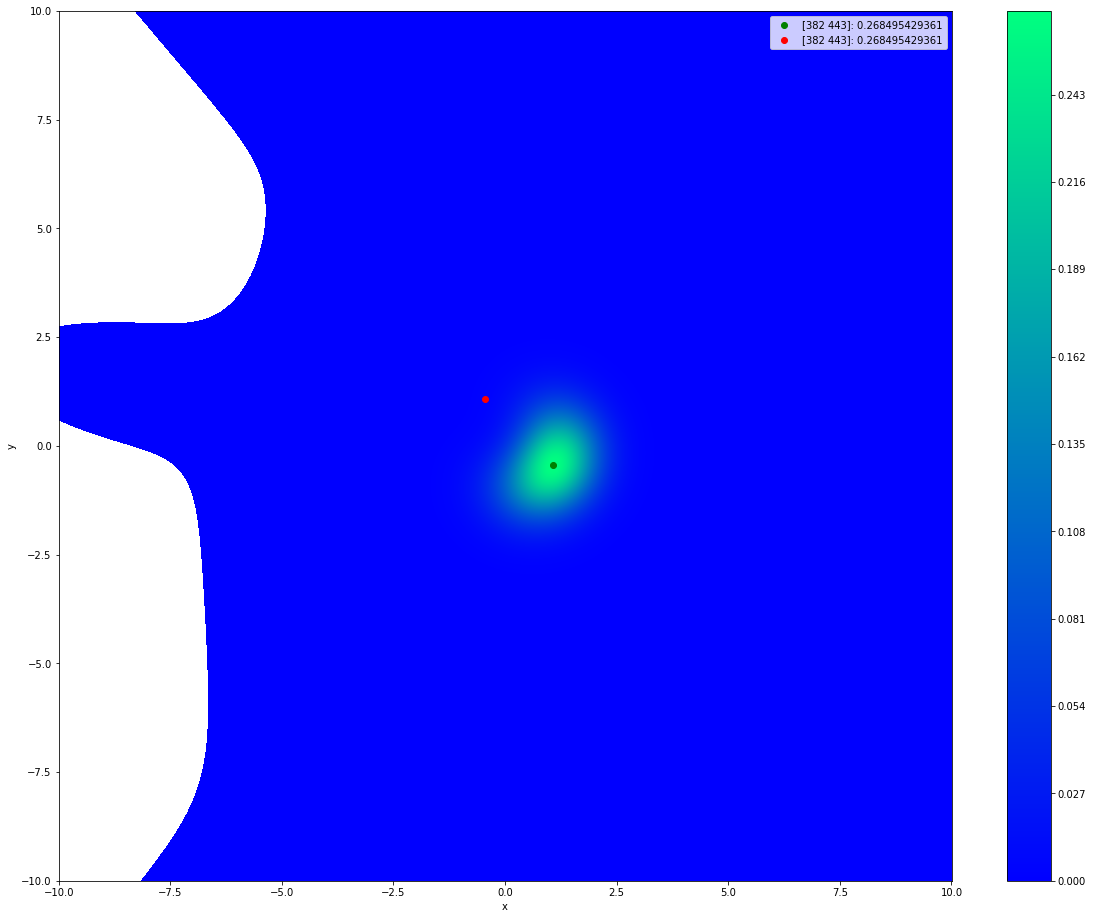

In [46]:
samples = [[i for i in relevantInfo if len(i['peaks']) == 1][123]]

for sample in samples:
    routine(sample['E'], sample['wd'])    

In [ ]:
doublePeaks = []

for a_i in relevantInfo:
    if len(a_i['peaks']) == 2:
        for b in a_i['peaks']:
            doublePeaks.append(b)
c = [i['peaks'][0] for i in relevantInfo if len(i['peaks']) == 1]
concacPeaks = np.sum([c, doublePeaks])

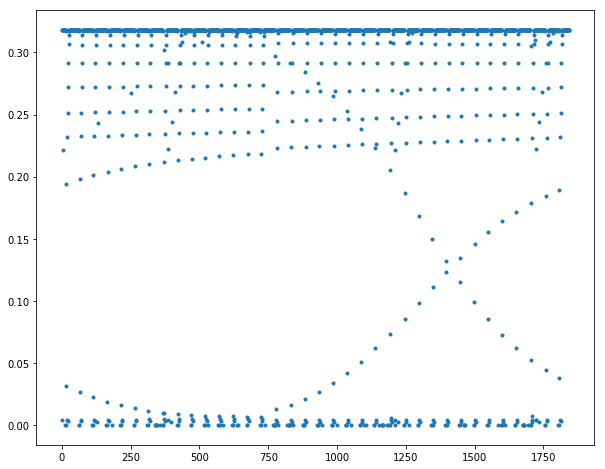

In [59]:
plt.plot(concacPeaks, '.')
plt.title('distribution of peak heights in data')
plt.ylabel('candidate peak heights')
plt.xlabel('arb index')
plt.axvline(x=len(c), color='k')
#plt.ylim(0.01,0.05)

In [ ]:
peaksTest = []
for relevantInfo_i in relevantInfo:
    for j in relevantInfo_i['peaks']:
        peaksTest.append(j)
    plt.plot(peaksTest, '.')
print(np.sum([j for j in peaksTest]))

In [84]:
#todo1: play with peaktrimlimit to affect width of leaf
#todo2: if 1 peak r = nothing? that might be the grey region

numIgnored = 0
plotData = []
peakTrimLimit = 0
biPeakLimit = 0.05#0.046
siPeakLimit = 9999999
singlePeakVals = []
for relevantInfo_i in relevantInfo:
    
    trimmedPeaks = []
    foundPeaks = relevantInfo_i['peaks']
    for foundPeak_i in foundPeaks:
        #if foundPeak_i > peakTrimLimit:
        trimmedPeaks.append(foundPeak_i)
    
    if len(trimmedPeaks) == 1:
#         r = 0
#         #singlePeakVals.append(trimmedPeaks[0])
#         if trimmedPeaks[0] > siPeakLimit:
#             plotData.append((relevantInfo_i['E'], relevantInfo_i['wd'], r))
        continue
    elif len(trimmedPeaks) == 2:
        #peak0 = relevantInfo_i['peaks'][0]
        #peak1 = relevantInfo_i['peaks'][1]
        peak0 = trimmedPeaks[0]
        peak1 = trimmedPeaks[1]
        if peak0 > biPeakLimit and peak1 > biPeakLimit:
            r = 1 - (abs(peak0-peak1)/(peak0+peak1))
            plotData.append((relevantInfo_i['E'], relevantInfo_i['wd'], r))
#         if r < 0.01:
#             print(peak0)
#             print(peak1)
#             print('bbbb')
#             break
#         if relevantInfo_i['wd'] < 0:
#             print(relevantInfo_i['wd'])
#             #print('aaaa')
#             break
        
    else:
        numIgnored += 1
        #print(relevantInfo_i['E'])
        #print(relevantInfo_i['wd'])
    #ignoreif more than 2 peaks
print(len(plotData))
print(len(trimmedPeaks))
print(numIgnored)
if len(plotData) == 0:
    print('NO BISTABILITY')

1600
0


In [ ]:
plotDataScaled = []
kappa = 0.0012 # 0.0012     
wc = 10.5665 # Cavity frequency/detuning 10.5665
for i in plotData:
    item = []
    item.append(i[0]/kappa)  
    item.append((i[1] - wc)/kappa)    
    item.append(i[2])
    plotDataScaled.append(item)

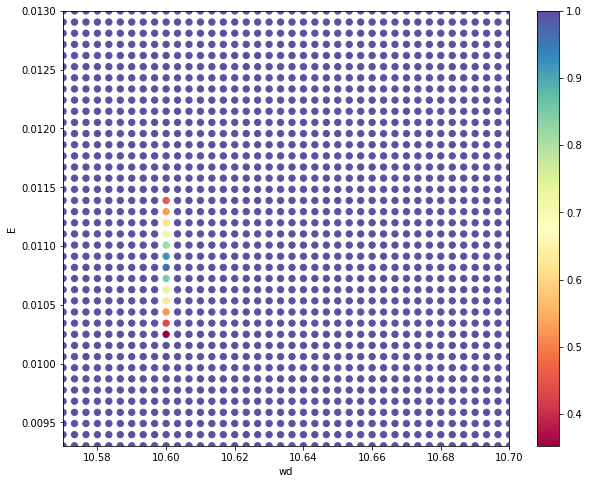

In [85]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

saveDir = 'peaks'
plt.scatter([i[1] for i in plotDataScaled], [i[0] for i in plotDataScaled], c=[i[2] for i in plotDataScaled], s=40, cmap=plt.cm.Spectral)
plt.ylabel(r"$E/\kappa$")
plt.xlabel(r"($\mathregular{w_{drive}}- \mathregular{w_{cavity}}) / \kappa$")
#plt.ylim(min([i[0] for i in plotData]), max([i[0] for i in plotData]))

plt.ylim((min([i[0] for i in plotDataScaled])), (max([i[0] for i in plotDataScaled])))
plt.xlim((min([i[1] for i in plotDataScaled])), (max([i[1] for i in plotDataScaled])))
#plt.ylim(0.00125,0.00150)
#plt.xlim(10.6095, 10.6109)
plt.colorbar()
print("EList = np.linspace(0.0,0.004,40)")
print("wdList = np.linspace(10.6,10.62,40)")

In [31]:
savedInfoTest = pickle.load(open(os.path.join(saveDir,'3.qpeak'), 'rb'))
print(savedInfoTest.keys())
print(savedInfoTest)

dict_keys(['E_i', 'wd_i', 'coors', 'peaks', 'Q3', 'xvec', 'yvec'])
{'E_i': 0.0092999999999999992, 'wd_i': 10.58, 'coors': array([[400, 389]], dtype=int64), 'peaks': array([[[  3.71981499e-42,   6.03714302e-42,   9.78587612e-42, ...,
           3.86383369e-46,   2.33972550e-46,   1.41393322e-46],
        [  3.46027758e-42,   5.61591545e-42,   9.10307879e-42, ...,
           4.96952922e-46,   3.03914073e-46,   1.85567570e-46]]]), 'Q3': array([[  1.27063246e-85,   2.06129774e-85,   3.33980115e-85, ...,
         -5.09309191e-87,  -3.21748216e-87,  -2.02921751e-87],
       [  2.09520430e-85,   3.39898621e-85,   5.50720856e-85, ...,
         -8.39814953e-87,  -5.30376654e-87,  -3.34401954e-87],
       [  3.45054122e-85,   5.59773654e-85,   9.06978057e-85, ...,
         -1.38264673e-86,  -8.72937698e-87,  -5.50230146e-87],
       ..., 
       [  2.69844315e-85,   4.37760420e-85,   7.09282702e-85, ...,
         -1.46887481e-86,  -9.26933073e-87,  -5.83999518e-87],
       [  1.63754064e-85,   2

In [ ]:
print(routine(savedInfoTest['E_i'],savedInfoTest['wd_i']))